In [1]:
%load_ext autoreload
%autoreload 2

import fd_imputer
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt

## Set up all paths and labels needed in this notebook

In [2]:
DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/adult.csv'
SPLITS_PATH = 'MLFD_fd_detection/data/'
METANOME_DATA_PATH = 'MLFD_fd_detection/backend/WEB-INF/classes/inputData/'
FD_PATH = 'MLFD_fd_detection/results/HyFD-1.2-SNAPSHOT.jar2019-05-07T082200_fds'
DATA_TITLE = 'adult'

In [3]:
df_train = pd.read_csv(SPLITS_PATH+'test/'+DATA_TITLE+'_test.csv', header=None)
df_test = pd.read_csv(SPLITS_PATH+'train/'+DATA_TITLE+'_train.csv', header=None)
fds = fd_imputer.read_fds(FD_PATH)
impute_column = str(9)
df_test = df_test.replace('noValueSetHere123156456', np.nan)
df_train = df_train.replace('noValueSetHere123156456', np.nan)

## FD_Imputer

### Getting metrics for all FDs in adult.csv

In [4]:
from sklearn import metrics
continuous = [0, 1, 3, 11, 12, 13] # cols containing continuous numbers

In [52]:
fd_imputer_results = {}
for rhs in fds:
    results = []
    for lhs in fds[rhs]:
        # print(rhs, lhs)
        fd = {rhs: lhs}
        df_fd_imputed = fd_imputer.fd_imputer(df_test, df_train, fd)
        
        # make sure that value for missing data is of same type as row to be imputed
        # to avoid mix of labels with scikit.metrics
        if isinstance(df_fd_imputed.loc[0, rhs], str):
            df_fd_imputed = df_fd_imputed.fillna('no value')
        else:
            df_fd_imputed = df_fd_imputed.fillna(0)

        y_pred = df_fd_imputed.loc[:, str(rhs)+'_imputed']
        y_true = df_fd_imputed.loc[:, rhs]
                
        if rhs in continuous:
            result = {
                'lhs': lhs,
                'mse': metrics.mean_squared_error(y_true, y_pred)
            }
        else:
            result = {
                'lhs': lhs,
                'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
                'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
                'f1': metrics.f1_score(y_true, y_pred, average='weighted')
            }
        results.append(result)
    fd_imputer_results[rhs] = results

/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [80]:
precision = [e['precision'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
recall = [e['recall'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
f1 = [e['f1'] for rhs in fd_imputer_results 
 for e in fd_imputer_results[rhs]]
rhs_color = [rhs for rhs in fd_imputer_results 
           for e in fd_imputer_results[rhs]]

area = [x*4000 for x in f1]
colormap = plt.cm.get_cmap('RdYlBu')

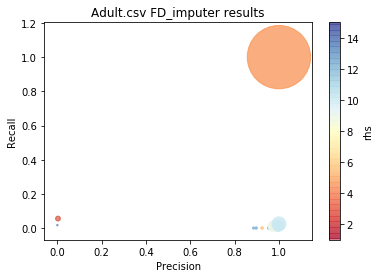

In [86]:
fig, ax = plt.subplots()
sc = plt.scatter(precision, 
                 recall, 
                 cmap=colormap,
                 c=rhs_color, 
                 s=area, 
                 alpha=0.5)
plt.colorbar(sc, label='rhs')
ax.set(title='Adult.csv FD_imputer results',
      xlabel = 'Precision',
      ylabel = 'Recall')
fig.savefig('fd_imputer_performance.png', transparent=False,
           dpi=320, bbox_inches='tight')

## ML imputation on fd's

In [6]:
ml_imputer_results = {}
for rhs in fds:
    results = []
    for lhs in fds[rhs]:
        relevant_cols = lhs + [rhs]
        
        # make sure that datawig doesn't perform regression on categories
        if rhs not in continuous:
            df_subset_train = df_train.iloc[:, relevant_cols].astype(
                {rhs: str})
            df_subset_test = df_test.iloc[:, relevant_cols].astype(
                {rhs: str})
        else:
            df_subset_train = df_train.iloc[:, relevant_cols].astype(
                {rhs: str})
            df_subset_test = df_test.iloc[:, relevant_cols].astype(
                {rhs: str})
        
        df_imputed = fd_imputer.ml_imputer(df_subset_train, 
                                           df_subset_test, 
                                           rhs)
        
        y_pred = df_imputed.loc[:, str(rhs)+'_imputed']
        y_true = df_imputed.loc[:, str(rhs)]
                
        if rhs in continuous:
            result = {
                'lhs': lhs,
                'mse': metrics.mean_squared_error(y_true, y_pred)
            }
        else:
            result = {
                'lhs': lhs,
                'precision': metrics.precision_score(y_true, y_pred, average='weighted'),
                'recall': metrics.recall_score(y_true, y_pred, average='weighted'),
                'f1': metrics.f1_score(y_true, y_pred, average='weighted')
            }
        results.append(result)
    ml_imputer_results[rhs] = results

2019-06-11 11:04:06,945 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 111483
2019-06-11 11:04:06,946 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 180985
2019-06-11 11:04:06,947 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 224566
2019-06-11 11:04:06,948 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 125933
2019-06-11 11:04:06,949 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 117789
2019-06-11 11:04:06,950 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 77884
2019-06-11 11:04:06,951 [INFO]  CategoricalEncoder for column 3                                found only 4 occurrences of value 109001
2019-06-11 11:04:06,953 [INFO]  CategoricalEncode

2019-06-11 11:04:07,061 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 99146
2019-06-11 11:04:07,063 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 60358
2019-06-11 11:04:07,066 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 225507
2019-06-11 11:04:07,067 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 148995
2019-06-11 11:04:07,069 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 214242
2019-06-11 11:04:07,071 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 323069
2019-06-11 11:04:07,073 [INFO]  CategoricalEncoder for column 3                                found only 2 occurrences of value 168262
2019-06-11 11:04:07,075 [INFO]  CategoricalEncoder

2019-06-11 11:04:10,277 [INFO]  Epoch[2] Validation-3-accuracy=0.062500
2019-06-11 11:04:10,761 [INFO]  Epoch[3] Batch [0-9]	Speed: 336.49 samples/sec	cross-entropy=3.387644	3-accuracy=0.568750
2019-06-11 11:04:11,108 [INFO]  Epoch[3] Train-cross-entropy=3.412777
2019-06-11 11:04:11,109 [INFO]  Epoch[3] Train-3-accuracy=0.599265
2019-06-11 11:04:11,110 [INFO]  Epoch[3] Time cost=0.832
2019-06-11 11:04:11,162 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 11:04:11,190 [INFO]  Epoch[3] Validation-cross-entropy=4.658157
2019-06-11 11:04:11,191 [INFO]  Epoch[3] Validation-3-accuracy=0.125000
2019-06-11 11:04:11,844 [INFO]  Epoch[4] Batch [0-9]	Speed: 242.74 samples/sec	cross-entropy=3.218192	3-accuracy=0.706250
2019-06-11 11:04:12,266 [INFO]  Epoch[4] Train-cross-entropy=3.220959
2019-06-11 11:04:12,266 [INFO]  Epoch[4] Train-3-accuracy=0.702206
2019-06-11 11:04:12,268 [INFO]  Epoch[4] Time cost=1.076
2019-06-11 11:04:12,323 [INFO]  Saved checkpoint to "imputer_mo

2019-06-11 11:04:23,741 [INFO]  Epoch[17] Validation-cross-entropy=3.587309
2019-06-11 11:04:23,745 [INFO]  Epoch[17] Validation-3-accuracy=0.312500
2019-06-11 11:04:24,386 [INFO]  Epoch[18] Batch [0-9]	Speed: 256.67 samples/sec	cross-entropy=1.090872	3-accuracy=1.000000
2019-06-11 11:04:24,754 [INFO]  Epoch[18] Train-cross-entropy=1.065933
2019-06-11 11:04:24,755 [INFO]  Epoch[18] Train-3-accuracy=1.000000
2019-06-11 11:04:24,756 [INFO]  Epoch[18] Time cost=1.009
2019-06-11 11:04:24,807 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 11:04:24,830 [INFO]  Epoch[18] Validation-cross-entropy=3.556228
2019-06-11 11:04:24,831 [INFO]  Epoch[18] Validation-3-accuracy=0.312500
2019-06-11 11:04:25,440 [INFO]  Epoch[19] Batch [0-9]	Speed: 270.41 samples/sec	cross-entropy=0.993530	3-accuracy=1.000000
2019-06-11 11:04:25,855 [INFO]  Epoch[19] Train-cross-entropy=0.969949
2019-06-11 11:04:25,857 [INFO]  Epoch[19] Train-3-accuracy=1.000000
2019-06-11 11:04:25,859 [INFO]  Ep

2019-06-11 11:04:53,387 [INFO]  CategoricalEncoder for column 11                                found only 6 occurrences of value 4650
2019-06-11 11:04:53,388 [INFO]  CategoricalEncoder for column 11                                found only 6 occurrences of value 14084
2019-06-11 11:04:53,389 [INFO]  CategoricalEncoder for column 11                                found only 5 occurrences of value 4787
2019-06-11 11:04:53,390 [INFO]  CategoricalEncoder for column 11                                found only 5 occurrences of value 6849
2019-06-11 11:04:53,390 [INFO]  CategoricalEncoder for column 11                                found only 5 occurrences of value 14344
2019-06-11 11:04:53,391 [INFO]  CategoricalEncoder for column 11                                found only 5 occurrences of value 20051
2019-06-11 11:04:53,392 [INFO]  CategoricalEncoder for column 11                                found only 4 occurrences of value 2829
2019-06-11 11:04:53,393 [INFO]  CategoricalEncoder f

2019-06-11 11:04:53,467 [INFO]  CategoricalEncoder for column 11                                found only 1 occurrences of value 6097
2019-06-11 11:04:53,469 [INFO]  CategoricalEncoder for column 11                                found only 1 occurrences of value 6514
2019-06-11 11:04:53,470 [INFO]  CategoricalEncoder for column 11                                found only 1 occurrences of value 3818
2019-06-11 11:04:53,472 [INFO]  CategoricalEncoder for column 11                                found only 1 occurrences of value 9562
2019-06-11 11:04:53,473 [INFO]  CategoricalEncoder for column 11                                found only 1 occurrences of value 5721
2019-06-11 11:04:53,475 [INFO]  CategoricalEncoder for column 11                                found only 1 occurrences of value 7430
2019-06-11 11:04:53,594 [WARNING]  Test set does not contain any ocurrences of values [7430, 3781, 2346, 3418, 1506, 4865, 6418, 8614, 2009, 25124, 14344, 2228, 27828, 3411, 2977, 2354, 1060

2019-06-11 11:08:16,354 [INFO]  Epoch[12] Train-cross-entropy=0.005774
2019-06-11 11:08:16,355 [INFO]  Epoch[12] Train-11-accuracy=0.999659
2019-06-11 11:08:16,356 [INFO]  Epoch[12] Time cost=15.170
2019-06-11 11:08:16,405 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 11:08:16,841 [INFO]  Epoch[12] Validation-cross-entropy=0.020820
2019-06-11 11:08:16,842 [INFO]  Epoch[12] Validation-11-accuracy=0.996951
2019-06-11 11:08:23,449 [INFO]  Epoch[13] Batch [0-184]	Speed: 448.28 samples/sec	cross-entropy=0.005079	11-accuracy=0.999324
2019-06-11 11:08:31,049 [INFO]  Epoch[13] Train-cross-entropy=0.004603
2019-06-11 11:08:31,050 [INFO]  Epoch[13] Train-11-accuracy=0.999659
2019-06-11 11:08:31,051 [INFO]  Epoch[13] Time cost=14.208
2019-06-11 11:08:31,084 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 11:08:31,627 [INFO]  Epoch[13] Validation-cross-entropy=0.019724
2019-06-11 11:08:31,628 [INFO]  Epoch[13] Validation-11-accuracy=0.996951
2019

2019-06-11 11:11:49,369 [INFO]  Epoch[26] Validation-11-accuracy=0.998476
2019-06-11 11:11:57,133 [INFO]  Epoch[27] Batch [0-184]	Speed: 381.32 samples/sec	cross-entropy=0.000390	11-accuracy=1.000000
2019-06-11 11:12:04,263 [INFO]  Epoch[27] Train-cross-entropy=0.000365
2019-06-11 11:12:04,265 [INFO]  Epoch[27] Train-11-accuracy=1.000000
2019-06-11 11:12:04,266 [INFO]  Epoch[27] Time cost=14.896
2019-06-11 11:12:04,312 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 11:12:04,747 [INFO]  Epoch[27] Validation-cross-entropy=0.017220
2019-06-11 11:12:04,748 [INFO]  Epoch[27] Validation-11-accuracy=0.998476
2019-06-11 11:12:12,257 [INFO]  Epoch[28] Batch [0-184]	Speed: 394.23 samples/sec	cross-entropy=0.000329	11-accuracy=1.000000
2019-06-11 11:12:19,663 [INFO]  Epoch[28] Train-cross-entropy=0.000308
2019-06-11 11:12:19,664 [INFO]  Epoch[28] Train-11-accuracy=1.000000
2019-06-11 11:12:19,665 [INFO]  Epoch[28] Time cost=14.915
2019-06-11 11:12:19,710 [INFO]  Saved ch

2019-06-11 11:12:38,573 [INFO]  CategoricalEncoder for column 13                                found only 3 occurrences of value 3
2019-06-11 11:12:38,574 [INFO]  CategoricalEncoder for column 13                                found only 3 occurrences of value 1
2019-06-11 11:12:38,575 [INFO]  CategoricalEncoder for column 13                                found only 3 occurrences of value 11
2019-06-11 11:12:38,576 [INFO]  CategoricalEncoder for column 13                                found only 3 occurrences of value 17
2019-06-11 11:12:38,577 [INFO]  CategoricalEncoder for column 13                                found only 3 occurrences of value 13
2019-06-11 11:12:38,577 [INFO]  CategoricalEncoder for column 13                                found only 3 occurrences of value 14
2019-06-11 11:12:38,578 [INFO]  CategoricalEncoder for column 13                                found only 2 occurrences of value 31
2019-06-11 11:12:38,579 [INFO]  CategoricalEncoder for column 13       

2019-06-11 11:14:49,250 [INFO]  Epoch[9] Train-cross-entropy=0.048228
2019-06-11 11:14:49,255 [INFO]  Epoch[9] Train-13-accuracy=0.995743
2019-06-11 11:14:49,256 [INFO]  Epoch[9] Time cost=12.294
2019-06-11 11:14:49,286 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 11:14:49,674 [INFO]  Epoch[9] Validation-cross-entropy=0.076773
2019-06-11 11:14:49,675 [INFO]  Epoch[9] Validation-13-accuracy=0.987805
2019-06-11 11:14:55,788 [INFO]  Epoch[10] Batch [0-184]	Speed: 484.46 samples/sec	cross-entropy=0.037942	13-accuracy=0.997297
2019-06-11 11:15:01,856 [INFO]  Epoch[10] Train-cross-entropy=0.039287
2019-06-11 11:15:01,857 [INFO]  Epoch[10] Train-13-accuracy=0.996253
2019-06-11 11:15:01,858 [INFO]  Epoch[10] Time cost=12.183
2019-06-11 11:15:01,888 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 11:15:02,371 [INFO]  Epoch[10] Validation-cross-entropy=0.067622
2019-06-11 11:15:02,373 [INFO]  Epoch[10] Validation-13-accuracy=0.987805
2019-06-1

2019-06-11 11:18:01,772 [INFO]  Epoch[23] Validation-13-accuracy=0.990854
2019-06-11 11:18:09,313 [INFO]  Epoch[24] Batch [0-184]	Speed: 392.61 samples/sec	cross-entropy=0.004326	13-accuracy=1.000000
2019-06-11 11:18:16,786 [INFO]  Epoch[24] Train-cross-entropy=0.004936
2019-06-11 11:18:16,787 [INFO]  Epoch[24] Train-13-accuracy=0.999830
2019-06-11 11:18:16,788 [INFO]  Epoch[24] Time cost=15.015
2019-06-11 11:18:16,851 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 11:18:17,296 [INFO]  Epoch[24] Validation-cross-entropy=0.034553
2019-06-11 11:18:17,297 [INFO]  Epoch[24] Validation-13-accuracy=0.990854
2019-06-11 11:18:24,338 [INFO]  Epoch[25] Batch [0-184]	Speed: 420.25 samples/sec	cross-entropy=0.003837	13-accuracy=1.000000
2019-06-11 11:18:31,261 [INFO]  Epoch[25] Train-cross-entropy=0.004390
2019-06-11 11:18:31,262 [INFO]  Epoch[25] Train-13-accuracy=0.999830
2019-06-11 11:18:31,263 [INFO]  Epoch[25] Time cost=13.965
2019-06-11 11:18:31,297 [INFO]  Saved ch

2019-06-11 11:19:32,911 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1092
2019-06-11 11:19:32,912 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1726
2019-06-11 11:19:32,913 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 880
2019-06-11 11:19:32,914 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 2392
2019-06-11 11:19:32,916 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 2042
2019-06-11 11:19:32,924 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 4356
2019-06-11 11:19:32,927 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1721
2019-06-11 11:19:32,928 [INFO]  CategoricalEncoder for c

2019-06-11 11:21:18,085 [INFO]  Epoch[8] Train-cross-entropy=0.015138
2019-06-11 11:21:18,086 [INFO]  Epoch[8] Train-12-accuracy=0.997956
2019-06-11 11:21:18,087 [INFO]  Epoch[8] Time cost=12.585
2019-06-11 11:21:18,120 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 11:21:19,069 [INFO]  Epoch[8] Validation-cross-entropy=0.015546
2019-06-11 11:21:19,073 [INFO]  Epoch[8] Validation-12-accuracy=0.998476
2019-06-11 11:21:25,268 [INFO]  Epoch[9] Batch [0-184]	Speed: 478.99 samples/sec	cross-entropy=0.013184	12-accuracy=0.998649
2019-06-11 11:21:30,361 [INFO]  Epoch[9] Train-cross-entropy=0.011402
2019-06-11 11:21:30,362 [INFO]  Epoch[9] Train-12-accuracy=0.998808
2019-06-11 11:21:30,365 [INFO]  Epoch[9] Time cost=11.290
2019-06-11 11:21:30,388 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 11:21:30,799 [INFO]  Epoch[9] Validation-cross-entropy=0.013627
2019-06-11 11:21:30,800 [INFO]  Epoch[9] Validation-12-accuracy=0.998476
2019-06-11 11:2

2019-06-11 11:23:47,210 [INFO]  Epoch[22] Validation-12-accuracy=0.998476
2019-06-11 11:23:52,310 [INFO]  Epoch[23] Batch [0-184]	Speed: 580.58 samples/sec	cross-entropy=0.000734	12-accuracy=1.000000
2019-06-11 11:23:57,209 [INFO]  Epoch[23] Train-cross-entropy=0.000666
2019-06-11 11:23:57,327 [INFO]  Epoch[23] Train-12-accuracy=1.000000
2019-06-11 11:23:57,329 [INFO]  Epoch[23] Time cost=10.119
2019-06-11 11:23:57,395 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 11:23:57,840 [INFO]  Epoch[23] Validation-cross-entropy=0.006218
2019-06-11 11:23:57,841 [INFO]  Epoch[23] Validation-12-accuracy=0.998476
2019-06-11 11:24:03,036 [INFO]  Epoch[24] Batch [0-184]	Speed: 569.84 samples/sec	cross-entropy=0.000624	12-accuracy=1.000000
2019-06-11 11:24:07,998 [INFO]  Epoch[24] Train-cross-entropy=0.000569
2019-06-11 11:24:07,999 [INFO]  Epoch[24] Train-12-accuracy=1.000000
2019-06-11 11:24:08,000 [INFO]  Epoch[24] Time cost=10.158
2019-06-11 11:24:08,025 [INFO]  Saved ch

2019-06-11 11:26:24,352 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 11:26:24,757 [INFO]  Epoch[37] Validation-cross-entropy=0.003294
2019-06-11 11:26:24,759 [INFO]  Epoch[37] Validation-12-accuracy=0.998476
2019-06-11 11:26:29,993 [INFO]  Epoch[38] Batch [0-184]	Speed: 565.71 samples/sec	cross-entropy=0.000070	12-accuracy=1.000000
2019-06-11 11:26:34,934 [INFO]  Epoch[38] Train-cross-entropy=0.000064
2019-06-11 11:26:34,935 [INFO]  Epoch[38] Train-12-accuracy=1.000000
2019-06-11 11:26:34,935 [INFO]  Epoch[38] Time cost=10.174
2019-06-11 11:26:34,958 [INFO]  Saved checkpoint to "imputer_model/model-0038.params"
2019-06-11 11:26:35,375 [INFO]  Epoch[38] Validation-cross-entropy=0.003007
2019-06-11 11:26:35,376 [INFO]  Epoch[38] Validation-12-accuracy=0.998476
2019-06-11 11:26:40,369 [INFO]  Epoch[39] Batch [0-184]	Speed: 593.06 samples/sec	cross-entropy=0.000062	12-accuracy=1.000000
2019-06-11 11:26:45,270 [INFO]  Epoch[39] Train-cross-entropy=0.000056
2019-0

2019-06-11 11:29:03,393 [INFO]  Epoch[52] Train-cross-entropy=0.000012
2019-06-11 11:29:03,394 [INFO]  Epoch[52] Train-12-accuracy=1.000000
2019-06-11 11:29:03,395 [INFO]  Epoch[52] Time cost=10.023
2019-06-11 11:29:03,420 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 11:29:03,839 [INFO]  Epoch[52] Validation-cross-entropy=0.000517
2019-06-11 11:29:03,840 [INFO]  Epoch[52] Validation-12-accuracy=1.000000
2019-06-11 11:29:08,827 [INFO]  Epoch[53] Batch [0-184]	Speed: 593.72 samples/sec	cross-entropy=0.000011	12-accuracy=1.000000
2019-06-11 11:29:13,911 [INFO]  Epoch[53] Train-cross-entropy=0.000010
2019-06-11 11:29:13,916 [INFO]  Epoch[53] Train-12-accuracy=1.000000
2019-06-11 11:29:13,917 [INFO]  Epoch[53] Time cost=10.076
2019-06-11 11:29:13,941 [INFO]  Saved checkpoint to "imputer_model/model-0053.params"
2019-06-11 11:29:14,370 [INFO]  Epoch[53] Validation-cross-entropy=0.000239
2019-06-11 11:29:14,371 [INFO]  Epoch[53] Validation-12-accuracy=1.000000
2019

2019-06-11 11:31:48,017 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 1672
2019-06-11 11:31:48,018 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 1590
2019-06-11 11:31:48,020 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 2415
2019-06-11 11:31:48,022 [INFO]  CategoricalEncoder for column 12                                found only 6 occurrences of value 1602
2019-06-11 11:31:48,023 [INFO]  CategoricalEncoder for column 12                                found only 5 occurrences of value 1408
2019-06-11 11:31:48,024 [INFO]  CategoricalEncoder for column 12                                found only 5 occurrences of value 2377
2019-06-11 11:31:48,025 [INFO]  CategoricalEncoder for column 12                                found only 5 occurrences of value 1579
2019-06-11 11:31:48,026 [INFO]  CategoricalEncoder for 

2019-06-11 11:32:42,617 [INFO]  Epoch[3] Train-cross-entropy=0.083803
2019-06-11 11:32:42,618 [INFO]  Epoch[3] Train-12-accuracy=0.972752
2019-06-11 11:32:42,619 [INFO]  Epoch[3] Time cost=14.149
2019-06-11 11:32:42,644 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 11:32:43,143 [INFO]  Epoch[3] Validation-cross-entropy=0.107675
2019-06-11 11:32:43,144 [INFO]  Epoch[3] Validation-12-accuracy=0.977134
2019-06-11 11:32:49,399 [INFO]  Epoch[4] Batch [0-184]	Speed: 473.68 samples/sec	cross-entropy=0.060079	12-accuracy=0.979730
2019-06-11 11:32:55,566 [INFO]  Epoch[4] Train-cross-entropy=0.054504
2019-06-11 11:32:55,567 [INFO]  Epoch[4] Train-12-accuracy=0.982459
2019-06-11 11:32:55,570 [INFO]  Epoch[4] Time cost=12.425
2019-06-11 11:32:55,597 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 11:32:56,160 [INFO]  Epoch[4] Validation-cross-entropy=0.094051
2019-06-11 11:32:56,162 [INFO]  Epoch[4] Validation-12-accuracy=0.978659
2019-06-11 11:3

2019-06-11 11:35:42,079 [INFO]  Epoch[18] Batch [0-184]	Speed: 583.26 samples/sec	cross-entropy=0.001595	12-accuracy=1.000000
2019-06-11 11:35:47,441 [INFO]  Epoch[18] Train-cross-entropy=0.001507
2019-06-11 11:35:47,760 [INFO]  Epoch[18] Train-12-accuracy=1.000000
2019-06-11 11:35:47,764 [INFO]  Epoch[18] Time cost=10.762
2019-06-11 11:35:47,801 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 11:35:48,276 [INFO]  Epoch[18] Validation-cross-entropy=0.069038
2019-06-11 11:35:48,277 [INFO]  Epoch[18] Validation-12-accuracy=0.987805
2019-06-11 11:35:53,345 [INFO]  Epoch[19] Batch [0-184]	Speed: 584.13 samples/sec	cross-entropy=0.001355	12-accuracy=1.000000
2019-06-11 11:35:58,337 [INFO]  Epoch[19] Train-cross-entropy=0.001273
2019-06-11 11:35:58,339 [INFO]  Epoch[19] Train-12-accuracy=1.000000
2019-06-11 11:35:58,341 [INFO]  Epoch[19] Time cost=10.063
2019-06-11 11:35:58,777 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 11:35:59,276 [INF

2019-06-11 11:37:46,477 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 2002
2019-06-11 11:37:46,478 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 1669
2019-06-11 11:37:46,479 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 2559
2019-06-11 11:37:46,480 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 1672
2019-06-11 11:37:46,481 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 1590
2019-06-11 11:37:46,482 [INFO]  CategoricalEncoder for column 12                                found only 7 occurrences of value 2415
2019-06-11 11:37:46,483 [INFO]  CategoricalEncoder for column 12                                found only 6 occurrences of value 1602
2019-06-11 11:37:46,485 [INFO]  CategoricalEncoder for 

2019-06-11 11:38:19,667 [INFO]  Epoch[2] Time cost=10.094
2019-06-11 11:38:19,690 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 11:38:20,098 [INFO]  Epoch[2] Validation-cross-entropy=0.113023
2019-06-11 11:38:20,099 [INFO]  Epoch[2] Validation-12-accuracy=0.977134
2019-06-11 11:38:25,216 [INFO]  Epoch[3] Batch [0-184]	Speed: 578.66 samples/sec	cross-entropy=0.086705	12-accuracy=0.969932
2019-06-11 11:38:30,214 [INFO]  Epoch[3] Train-cross-entropy=0.078613
2019-06-11 11:38:30,527 [INFO]  Epoch[3] Train-12-accuracy=0.973263
2019-06-11 11:38:30,530 [INFO]  Epoch[3] Time cost=10.431
2019-06-11 11:38:30,569 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 11:38:31,066 [INFO]  Epoch[3] Validation-cross-entropy=0.092699
2019-06-11 11:38:31,067 [INFO]  Epoch[3] Validation-12-accuracy=0.978659
2019-06-11 11:38:36,203 [INFO]  Epoch[4] Batch [0-184]	Speed: 576.49 samples/sec	cross-entropy=0.055272	12-accuracy=0.981757
2019-06-11 11:38:41,496 [INF

2019-06-11 11:41:02,648 [INFO]  Epoch[17] Train-cross-entropy=0.001736
2019-06-11 11:41:02,650 [INFO]  Epoch[17] Train-12-accuracy=1.000000
2019-06-11 11:41:02,650 [INFO]  Epoch[17] Time cost=10.093
2019-06-11 11:41:02,980 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 11:41:03,500 [INFO]  Epoch[17] Validation-cross-entropy=0.056434
2019-06-11 11:41:03,501 [INFO]  Epoch[17] Validation-12-accuracy=0.989329
2019-06-11 11:41:08,600 [INFO]  Epoch[18] Batch [0-184]	Speed: 580.93 samples/sec	cross-entropy=0.001528	12-accuracy=1.000000
2019-06-11 11:41:13,710 [INFO]  Epoch[18] Train-cross-entropy=0.001454
2019-06-11 11:41:13,711 [INFO]  Epoch[18] Train-12-accuracy=1.000000
2019-06-11 11:41:13,712 [INFO]  Epoch[18] Time cost=10.209
2019-06-11 11:41:13,733 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 11:41:14,159 [INFO]  Epoch[18] Validation-cross-entropy=0.056853
2019-06-11 11:41:14,160 [INFO]  Epoch[18] Validation-12-accuracy=0.989329
2019

2019-06-11 11:42:07,916 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1380
2019-06-11 11:42:07,917 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1092
2019-06-11 11:42:07,918 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1726
2019-06-11 11:42:07,919 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 880
2019-06-11 11:42:07,920 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 2392
2019-06-11 11:42:07,921 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 2042
2019-06-11 11:42:07,922 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 4356
2019-06-11 11:42:07,922 [INFO]  CategoricalEncoder for c

2019-06-11 11:43:35,455 [INFO]  Epoch[7] Validation-12-accuracy=0.989329
2019-06-11 11:43:40,606 [INFO]  Epoch[8] Batch [0-184]	Speed: 575.67 samples/sec	cross-entropy=0.011219	12-accuracy=1.000000
2019-06-11 11:43:46,142 [INFO]  Epoch[8] Train-cross-entropy=0.010531
2019-06-11 11:43:46,448 [INFO]  Epoch[8] Train-12-accuracy=1.000000
2019-06-11 11:43:46,452 [INFO]  Epoch[8] Time cost=10.996
2019-06-11 11:43:46,498 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 11:43:46,989 [INFO]  Epoch[8] Validation-cross-entropy=0.056416
2019-06-11 11:43:46,990 [INFO]  Epoch[8] Validation-12-accuracy=0.989329
2019-06-11 11:43:52,132 [INFO]  Epoch[9] Batch [0-184]	Speed: 576.18 samples/sec	cross-entropy=0.008526	12-accuracy=1.000000
2019-06-11 11:43:57,521 [INFO]  Epoch[9] Train-cross-entropy=0.008026
2019-06-11 11:43:57,523 [INFO]  Epoch[9] Train-12-accuracy=1.000000
2019-06-11 11:43:57,524 [INFO]  Epoch[9] Time cost=10.533
2019-06-11 11:43:57,545 [INFO]  Saved checkpoint to

2019-06-11 11:46:07,127 [INFO]  CategoricalEncoder for column 12                                found only 29 occurrences of value 1887
2019-06-11 11:46:07,128 [INFO]  CategoricalEncoder for column 12                                found only 10 occurrences of value 1848
2019-06-11 11:46:07,130 [INFO]  CategoricalEncoder for column 12                                found only 9 occurrences of value 1719
2019-06-11 11:46:07,131 [INFO]  CategoricalEncoder for column 12                                found only 8 occurrences of value 1980
2019-06-11 11:46:07,132 [INFO]  CategoricalEncoder for column 12                                found only 8 occurrences of value 1485
2019-06-11 11:46:07,133 [INFO]  CategoricalEncoder for column 12                                found only 8 occurrences of value 1876
2019-06-11 11:46:07,134 [INFO]  CategoricalEncoder for column 12                                found only 8 occurrences of value 1740
2019-06-11 11:46:07,135 [INFO]  CategoricalEncoder fo

2019-06-11 11:46:18,256 [INFO]  Epoch[0] Validation-cross-entropy=0.215982
2019-06-11 11:46:18,257 [INFO]  Epoch[0] Validation-12-accuracy=0.961890
2019-06-11 11:46:23,332 [INFO]  Epoch[1] Batch [0-184]	Speed: 583.50 samples/sec	cross-entropy=0.237095	12-accuracy=0.951351
2019-06-11 11:46:28,394 [INFO]  Epoch[1] Train-cross-entropy=0.218457
2019-06-11 11:46:28,397 [INFO]  Epoch[1] Train-12-accuracy=0.952657
2019-06-11 11:46:28,398 [INFO]  Epoch[1] Time cost=10.139
2019-06-11 11:46:28,422 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 11:46:28,836 [INFO]  Epoch[1] Validation-cross-entropy=0.161124
2019-06-11 11:46:28,837 [INFO]  Epoch[1] Validation-12-accuracy=0.963415
2019-06-11 11:46:33,927 [INFO]  Epoch[2] Batch [0-184]	Speed: 581.73 samples/sec	cross-entropy=0.155902	12-accuracy=0.956419
2019-06-11 11:46:39,319 [INFO]  Epoch[2] Train-cross-entropy=0.143802
2019-06-11 11:46:39,320 [INFO]  Epoch[2] Train-12-accuracy=0.959980
2019-06-11 11:46:39,321 [INFO]  Ep

2019-06-11 11:49:05,672 [INFO]  Epoch[15] Time cost=10.630
2019-06-11 11:49:05,699 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 11:49:06,116 [INFO]  Epoch[15] Validation-cross-entropy=0.073110
2019-06-11 11:49:06,118 [INFO]  Epoch[15] Validation-12-accuracy=0.984756
2019-06-11 11:49:11,341 [INFO]  Epoch[16] Batch [0-184]	Speed: 567.37 samples/sec	cross-entropy=0.002834	12-accuracy=1.000000
2019-06-11 11:49:16,530 [INFO]  Epoch[16] Train-cross-entropy=0.002681
2019-06-11 11:49:16,531 [INFO]  Epoch[16] Train-12-accuracy=1.000000
2019-06-11 11:49:16,532 [INFO]  Epoch[16] Time cost=10.412
2019-06-11 11:49:16,556 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 11:49:16,966 [INFO]  Epoch[16] Validation-cross-entropy=0.074171
2019-06-11 11:49:16,967 [INFO]  Epoch[16] Validation-12-accuracy=0.984756
2019-06-11 11:49:22,148 [INFO]  Epoch[17] Batch [0-184]	Speed: 571.65 samples/sec	cross-entropy=0.002410	12-accuracy=1.000000
2019-06-11 11:49:2

2019-06-11 11:49:46,931 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 2258
2019-06-11 11:49:46,932 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 2205
2019-06-11 11:49:46,933 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 2174
2019-06-11 11:49:46,934 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 2603
2019-06-11 11:49:46,935 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 2472
2019-06-11 11:49:46,936 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 2051
2019-06-11 11:49:46,938 [INFO]  CategoricalEncoder for column 12                                found only 1 occurrences of value 419
2019-06-11 11:49:46,939 [INFO]  CategoricalEncoder for c

2019-06-11 11:51:46,847 [INFO]  Epoch[10] Train-cross-entropy=0.005312
2019-06-11 11:51:46,848 [INFO]  Epoch[10] Train-12-accuracy=1.000000
2019-06-11 11:51:46,849 [INFO]  Epoch[10] Time cost=10.242
2019-06-11 11:51:46,967 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 11:51:47,460 [INFO]  Epoch[10] Validation-cross-entropy=0.051951
2019-06-11 11:51:47,462 [INFO]  Epoch[10] Validation-12-accuracy=0.989329
2019-06-11 11:51:52,533 [INFO]  Epoch[11] Batch [0-184]	Speed: 583.85 samples/sec	cross-entropy=0.004344	12-accuracy=1.000000
2019-06-11 11:51:57,515 [INFO]  Epoch[11] Train-cross-entropy=0.004177
2019-06-11 11:51:57,516 [INFO]  Epoch[11] Train-12-accuracy=1.000000
2019-06-11 11:51:57,517 [INFO]  Epoch[11] Time cost=10.054
2019-06-11 11:51:57,542 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 11:51:57,948 [INFO]  Epoch[11] Validation-cross-entropy=0.051655
2019-06-11 11:51:57,949 [INFO]  Epoch[11] Validation-12-accuracy=0.989329
2019

2019-06-11 11:53:11,756 [INFO]  CategoricalEncoder for column 12                                found only 3 occurrences of value 1504
2019-06-11 11:53:11,757 [INFO]  CategoricalEncoder for column 12                                found only 3 occurrences of value 213
2019-06-11 11:53:11,758 [INFO]  CategoricalEncoder for column 12                                found only 3 occurrences of value 1974
2019-06-11 11:53:11,759 [INFO]  CategoricalEncoder for column 12                                found only 3 occurrences of value 2339
2019-06-11 11:53:11,760 [INFO]  CategoricalEncoder for column 12                                found only 3 occurrences of value 2444
2019-06-11 11:53:11,761 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1651
2019-06-11 11:53:11,762 [INFO]  CategoricalEncoder for column 12                                found only 2 occurrences of value 1617
2019-06-11 11:53:11,763 [INFO]  CategoricalEncoder for c

2019-06-11 11:54:27,715 [INFO]  Epoch[6] Train-cross-entropy=0.015133
2019-06-11 11:54:28,019 [INFO]  Epoch[6] Train-12-accuracy=0.999489
2019-06-11 11:54:28,025 [INFO]  Epoch[6] Time cost=10.564
2019-06-11 11:54:28,083 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 11:54:28,547 [INFO]  Epoch[6] Validation-cross-entropy=0.051092
2019-06-11 11:54:28,548 [INFO]  Epoch[6] Validation-12-accuracy=0.989329
2019-06-11 11:54:33,711 [INFO]  Epoch[7] Batch [0-184]	Speed: 573.72 samples/sec	cross-entropy=0.011230	12-accuracy=1.000000
2019-06-11 11:54:39,040 [INFO]  Epoch[7] Train-cross-entropy=0.010676
2019-06-11 11:54:39,043 [INFO]  Epoch[7] Train-12-accuracy=0.999830
2019-06-11 11:54:39,044 [INFO]  Epoch[7] Time cost=10.495
2019-06-11 11:54:39,070 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 11:54:39,481 [INFO]  Epoch[7] Validation-cross-entropy=0.049335
2019-06-11 11:54:39,482 [INFO]  Epoch[7] Validation-12-accuracy=0.989329
2019-06-11 11:5

2019-06-11 11:56:15,000 [INFO]  CategoricalEncoder for column 1                                found only 25 occurrences of value 66
2019-06-11 11:56:15,001 [INFO]  CategoricalEncoder for column 1                                found only 21 occurrences of value 65
2019-06-11 11:56:15,002 [INFO]  CategoricalEncoder for column 1                                found only 19 occurrences of value 69
2019-06-11 11:56:15,003 [INFO]  CategoricalEncoder for column 1                                found only 17 occurrences of value 67
2019-06-11 11:56:15,005 [INFO]  CategoricalEncoder for column 1                                found only 15 occurrences of value 70
2019-06-11 11:56:15,006 [INFO]  CategoricalEncoder for column 1                                found only 14 occurrences of value 71
2019-06-11 11:56:15,006 [INFO]  CategoricalEncoder for column 1                                found only 12 occurrences of value 73
2019-06-11 11:56:15,008 [INFO]  CategoricalEncoder for column 1      

2019-06-11 11:58:14,681 [INFO]  Epoch[9] Train-1-accuracy=0.998978
2019-06-11 11:58:14,682 [INFO]  Epoch[9] Time cost=11.686
2019-06-11 11:58:15,005 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 11:58:15,515 [INFO]  Epoch[9] Validation-cross-entropy=0.036455
2019-06-11 11:58:15,516 [INFO]  Epoch[9] Validation-1-accuracy=1.000000
2019-06-11 11:58:21,297 [INFO]  Epoch[10] Batch [0-184]	Speed: 512.61 samples/sec	cross-entropy=0.033714	1-accuracy=0.999324
2019-06-11 11:58:26,978 [INFO]  Epoch[10] Train-cross-entropy=0.031005
2019-06-11 11:58:26,979 [INFO]  Epoch[10] Train-1-accuracy=0.999319
2019-06-11 11:58:26,980 [INFO]  Epoch[10] Time cost=11.463
2019-06-11 11:58:27,008 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 11:58:27,422 [INFO]  Epoch[10] Validation-cross-entropy=0.028646
2019-06-11 11:58:27,423 [INFO]  Epoch[10] Validation-1-accuracy=1.000000
2019-06-11 11:58:33,178 [INFO]  Epoch[11] Batch [0-184]	Speed: 515.12 samples/sec	cr

2019-06-11 12:01:33,452 [INFO]  Epoch[24] Train-cross-entropy=0.001909
2019-06-11 12:01:33,761 [INFO]  Epoch[24] Train-1-accuracy=1.000000
2019-06-11 12:01:33,764 [INFO]  Epoch[24] Time cost=14.248
2019-06-11 12:01:33,815 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 12:01:34,361 [INFO]  Epoch[24] Validation-cross-entropy=0.001924
2019-06-11 12:01:34,362 [INFO]  Epoch[24] Validation-1-accuracy=1.000000
2019-06-11 12:01:41,342 [INFO]  Epoch[25] Batch [0-184]	Speed: 424.09 samples/sec	cross-entropy=0.001700	1-accuracy=1.000000
2019-06-11 12:01:48,184 [INFO]  Epoch[25] Train-cross-entropy=0.001591
2019-06-11 12:01:48,185 [INFO]  Epoch[25] Train-1-accuracy=1.000000
2019-06-11 12:01:48,186 [INFO]  Epoch[25] Time cost=13.823
2019-06-11 12:01:48,219 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 12:01:48,717 [INFO]  Epoch[25] Validation-cross-entropy=0.001618
2019-06-11 12:01:48,718 [INFO]  Epoch[25] Validation-1-accuracy=1.000000
2019-06-1

2019-06-11 12:05:05,615 [INFO]  Epoch[39] Batch [0-184]	Speed: 339.16 samples/sec	cross-entropy=0.000162	1-accuracy=1.000000
2019-06-11 12:05:14,885 [INFO]  Epoch[39] Train-cross-entropy=0.000151
2019-06-11 12:05:14,887 [INFO]  Epoch[39] Train-1-accuracy=1.000000
2019-06-11 12:05:14,890 [INFO]  Epoch[39] Time cost=17.997
2019-06-11 12:05:14,919 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 12:05:15,327 [INFO]  Epoch[39] Validation-cross-entropy=0.000168
2019-06-11 12:05:15,328 [INFO]  Epoch[39] Validation-1-accuracy=1.000000
2019-06-11 12:05:22,105 [INFO]  Epoch[40] Batch [0-184]	Speed: 436.76 samples/sec	cross-entropy=0.000138	1-accuracy=1.000000
2019-06-11 12:05:30,516 [INFO]  Epoch[40] Train-cross-entropy=0.000129
2019-06-11 12:05:30,519 [INFO]  Epoch[40] Train-1-accuracy=1.000000
2019-06-11 12:05:30,521 [INFO]  Epoch[40] Time cost=15.191
2019-06-11 12:05:30,573 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 12:05:31,254 [INFO]  E

2019-06-11 12:08:54,871 [INFO]  Epoch[53] Validation-cross-entropy=0.000025
2019-06-11 12:08:54,872 [INFO]  Epoch[53] Validation-1-accuracy=1.000000
2019-06-11 12:09:02,058 [INFO]  Epoch[54] Batch [0-184]	Speed: 412.01 samples/sec	cross-entropy=0.000018	1-accuracy=1.000000
2019-06-11 12:09:08,933 [INFO]  Epoch[54] Train-cross-entropy=0.000017
2019-06-11 12:09:08,935 [INFO]  Epoch[54] Train-1-accuracy=1.000000
2019-06-11 12:09:08,936 [INFO]  Epoch[54] Time cost=14.063
2019-06-11 12:09:08,970 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 12:09:09,502 [INFO]  Epoch[54] Validation-cross-entropy=0.000022
2019-06-11 12:09:09,504 [INFO]  Epoch[54] Validation-1-accuracy=1.000000
2019-06-11 12:09:18,249 [INFO]  Epoch[55] Batch [0-184]	Speed: 338.09 samples/sec	cross-entropy=0.000016	1-accuracy=1.000000
2019-06-11 12:09:28,101 [INFO]  Epoch[55] Train-cross-entropy=0.000015
2019-06-11 12:09:28,102 [INFO]  Epoch[55] Train-1-accuracy=1.000000
2019-06-11 12:09:28,106 [INFO

2019-06-11 12:13:08,968 [INFO]  Epoch[68] Time cost=13.914
2019-06-11 12:13:09,000 [INFO]  Saved checkpoint to "imputer_model/model-0068.params"
2019-06-11 12:13:09,521 [INFO]  Epoch[68] Validation-cross-entropy=0.000005
2019-06-11 12:13:09,523 [INFO]  Epoch[68] Validation-1-accuracy=1.000000
2019-06-11 12:13:16,498 [INFO]  Epoch[69] Batch [0-184]	Speed: 424.70 samples/sec	cross-entropy=0.000003	1-accuracy=1.000000
2019-06-11 12:13:23,359 [INFO]  Epoch[69] Train-cross-entropy=0.000003
2019-06-11 12:13:23,362 [INFO]  Epoch[69] Train-1-accuracy=1.000000
2019-06-11 12:13:23,365 [INFO]  Epoch[69] Time cost=13.837
2019-06-11 12:13:23,395 [INFO]  Saved checkpoint to "imputer_model/model-0069.params"
2019-06-11 12:13:23,868 [INFO]  Epoch[69] Validation-cross-entropy=0.000004
2019-06-11 12:13:23,869 [INFO]  Epoch[69] Validation-1-accuracy=1.000000
2019-06-11 12:13:31,110 [INFO]  Epoch[70] Batch [0-184]	Speed: 408.94 samples/sec	cross-entropy=0.000004	1-accuracy=1.000000
2019-06-11 12:13:38,224

2019-06-11 12:16:46,405 [INFO]  Epoch[83] Train-cross-entropy=0.000000
2019-06-11 12:16:46,407 [INFO]  Epoch[83] Train-1-accuracy=1.000000
2019-06-11 12:16:46,411 [INFO]  Epoch[83] Time cost=13.811
2019-06-11 12:16:46,445 [INFO]  Saved checkpoint to "imputer_model/model-0083.params"
2019-06-11 12:16:46,909 [INFO]  Epoch[83] Validation-cross-entropy=0.000001
2019-06-11 12:16:46,910 [INFO]  Epoch[83] Validation-1-accuracy=1.000000
2019-06-11 12:16:53,841 [INFO]  Epoch[84] Batch [0-184]	Speed: 427.28 samples/sec	cross-entropy=0.000000	1-accuracy=1.000000
2019-06-11 12:17:00,636 [INFO]  Epoch[84] Train-cross-entropy=0.000000
2019-06-11 12:17:00,638 [INFO]  Epoch[84] Train-1-accuracy=1.000000
2019-06-11 12:17:00,640 [INFO]  Epoch[84] Time cost=13.728
2019-06-11 12:17:00,677 [INFO]  Saved checkpoint to "imputer_model/model-0084.params"
2019-06-11 12:17:01,166 [INFO]  Epoch[84] Validation-cross-entropy=0.000001
2019-06-11 12:17:01,167 [INFO]  Epoch[84] Validation-1-accuracy=1.000000
2019-06-1

2019-06-11 12:20:18,306 [INFO]  Epoch[98] Batch [0-184]	Speed: 430.42 samples/sec	cross-entropy=0.000011	1-accuracy=1.000000
2019-06-11 12:20:25,048 [INFO]  Epoch[98] Train-cross-entropy=0.000006
2019-06-11 12:20:25,050 [INFO]  Epoch[98] Train-1-accuracy=1.000000
2019-06-11 12:20:25,051 [INFO]  Epoch[98] Time cost=13.624
2019-06-11 12:20:25,082 [INFO]  Saved checkpoint to "imputer_model/model-0098.params"
2019-06-11 12:20:25,564 [INFO]  Epoch[98] Validation-cross-entropy=0.000001
2019-06-11 12:20:25,565 [INFO]  Epoch[98] Validation-1-accuracy=1.000000
2019-06-11 12:20:32,468 [INFO]  Epoch[99] Batch [0-184]	Speed: 429.19 samples/sec	cross-entropy=0.000003	1-accuracy=1.000000
2019-06-11 12:20:39,320 [INFO]  Epoch[99] Train-cross-entropy=0.000002
2019-06-11 12:20:39,323 [INFO]  Epoch[99] Train-1-accuracy=1.000000
2019-06-11 12:20:39,324 [INFO]  Epoch[99] Time cost=13.757
2019-06-11 12:20:39,358 [INFO]  Saved checkpoint to "imputer_model/model-0099.params"
2019-06-11 12:20:39,829 [INFO]  E

2019-06-11 12:21:31,243 [INFO]  Epoch[2] Validation-14-accuracy=0.998476
2019-06-11 12:21:36,157 [INFO]  Epoch[3] Batch [0-184]	Speed: 602.76 samples/sec	cross-entropy=0.025477	14-accuracy=0.998986
2019-06-11 12:21:40,509 [INFO]  Epoch[3] Train-cross-entropy=0.021790
2019-06-11 12:21:40,511 [INFO]  Epoch[3] Train-14-accuracy=0.999319
2019-06-11 12:21:40,513 [INFO]  Epoch[3] Time cost=9.270
2019-06-11 12:21:40,531 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 12:21:40,951 [INFO]  Epoch[3] Validation-cross-entropy=0.013534
2019-06-11 12:21:40,952 [INFO]  Epoch[3] Validation-14-accuracy=1.000000
2019-06-11 12:21:45,496 [INFO]  Epoch[4] Batch [0-184]	Speed: 651.63 samples/sec	cross-entropy=0.013580	14-accuracy=0.999662
2019-06-11 12:21:50,079 [INFO]  Epoch[4] Train-cross-entropy=0.012000
2019-06-11 12:21:50,081 [INFO]  Epoch[4] Train-14-accuracy=0.999830
2019-06-11 12:21:50,082 [INFO]  Epoch[4] Time cost=9.128
2019-06-11 12:21:50,099 [INFO]  Saved checkpoint to "

2019-06-11 12:24:00,243 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 12:24:00,611 [INFO]  Epoch[17] Validation-cross-entropy=0.000295
2019-06-11 12:24:00,612 [INFO]  Epoch[17] Validation-14-accuracy=1.000000
2019-06-11 12:24:05,034 [INFO]  Epoch[18] Batch [0-184]	Speed: 669.36 samples/sec	cross-entropy=0.000294	14-accuracy=1.000000
2019-06-11 12:24:09,412 [INFO]  Epoch[18] Train-cross-entropy=0.000288
2019-06-11 12:24:09,414 [INFO]  Epoch[18] Train-14-accuracy=1.000000
2019-06-11 12:24:09,416 [INFO]  Epoch[18] Time cost=8.803
2019-06-11 12:24:09,432 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 12:24:09,800 [INFO]  Epoch[18] Validation-cross-entropy=0.000243
2019-06-11 12:24:09,801 [INFO]  Epoch[18] Validation-14-accuracy=1.000000
2019-06-11 12:24:14,484 [INFO]  Epoch[19] Batch [0-184]	Speed: 631.70 samples/sec	cross-entropy=0.000243	14-accuracy=1.000000
2019-06-11 12:24:18,548 [INFO]  Epoch[19] Train-cross-entropy=0.000238
2019-06

2019-06-11 12:26:15,203 [INFO]  Epoch[32] Train-cross-entropy=0.000024
2019-06-11 12:26:15,204 [INFO]  Epoch[32] Train-14-accuracy=1.000000
2019-06-11 12:26:15,206 [INFO]  Epoch[32] Time cost=7.859
2019-06-11 12:26:15,222 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 12:26:15,613 [INFO]  Epoch[32] Validation-cross-entropy=0.000020
2019-06-11 12:26:15,616 [INFO]  Epoch[32] Validation-14-accuracy=1.000000
2019-06-11 12:26:19,485 [INFO]  Epoch[33] Batch [0-184]	Speed: 765.58 samples/sec	cross-entropy=0.000021	14-accuracy=1.000000
2019-06-11 12:26:23,313 [INFO]  Epoch[33] Train-cross-entropy=0.000020
2019-06-11 12:26:23,314 [INFO]  Epoch[33] Train-14-accuracy=1.000000
2019-06-11 12:26:23,315 [INFO]  Epoch[33] Time cost=7.697
2019-06-11 12:26:23,331 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 12:26:23,698 [INFO]  Epoch[33] Validation-cross-entropy=0.000017
2019-06-11 12:26:23,699 [INFO]  Epoch[33] Validation-14-accuracy=1.000000
2019-0

2019-06-11 12:28:14,697 [INFO]  Epoch[46] Validation-14-accuracy=1.000000
2019-06-11 12:28:18,759 [INFO]  Epoch[47] Batch [0-184]	Speed: 730.43 samples/sec	cross-entropy=0.000000	14-accuracy=1.000000
2019-06-11 12:28:22,587 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 12:28:22,588 [INFO]  Epoch[47] Train-14-accuracy=1.000000
2019-06-11 12:28:22,589 [INFO]  Epoch[47] Time cost=7.890
2019-06-11 12:28:22,606 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 12:28:23,022 [INFO]  Epoch[47] Validation-cross-entropy=0.000000
2019-06-11 12:28:23,024 [INFO]  Epoch[47] Validation-14-accuracy=1.000000
2019-06-11 12:28:26,911 [INFO]  Epoch[48] Batch [0-184]	Speed: 763.49 samples/sec	cross-entropy=0.000000	14-accuracy=1.000000
2019-06-11 12:28:30,739 [INFO]  Epoch[48] Train-cross-entropy=0.000000
2019-06-11 12:28:30,740 [INFO]  Epoch[48] Train-14-accuracy=1.000000
2019-06-11 12:28:30,742 [INFO]  Epoch[48] Time cost=7.716
2019-06-11 12:28:30,763 [INFO]  Saved chec

2019-06-11 12:30:21,954 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 12:30:22,355 [INFO]  No improvement detected for 5 epochs compared to 8.688412588844447e-08 last error obtained: 5.994372765965472e-07, stopping here
2019-06-11 12:30:22,356 [INFO]  
========== done (561.5824854373932 s) fit model
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2019-06-11 12:30:41,395 [INFO]  CategoricalEncoder for column 4                                found only 77 occurrences of value 12th
2019-06-11 12:30:41,397

2019-06-11 12:31:48,792 [INFO]  Epoch[11] Validation-4-accuracy=1.000000
2019-06-11 12:31:51,337 [INFO]  Epoch[12] Batch [0-184]	Speed: 1164.18 samples/sec	cross-entropy=0.000785	4-accuracy=1.000000
2019-06-11 12:31:53,848 [INFO]  Epoch[12] Train-cross-entropy=0.000755
2019-06-11 12:31:53,853 [INFO]  Epoch[12] Train-4-accuracy=1.000000
2019-06-11 12:31:53,854 [INFO]  Epoch[12] Time cost=5.061
2019-06-11 12:31:53,862 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 12:31:54,201 [INFO]  Epoch[12] Validation-cross-entropy=0.000708
2019-06-11 12:31:54,203 [INFO]  Epoch[12] Validation-4-accuracy=1.000000
2019-06-11 12:31:56,746 [INFO]  Epoch[13] Batch [0-184]	Speed: 1165.45 samples/sec	cross-entropy=0.000633	4-accuracy=1.000000
2019-06-11 12:31:59,279 [INFO]  Epoch[13] Train-cross-entropy=0.000610
2019-06-11 12:31:59,433 [INFO]  Epoch[13] Train-4-accuracy=1.000000
2019-06-11 12:31:59,436 [INFO]  Epoch[13] Time cost=5.230
2019-06-11 12:31:59,455 [INFO]  Saved checkpoi

2019-06-11 12:33:13,265 [INFO]  Saved checkpoint to "imputer_model/model-0026.params"
2019-06-11 12:33:13,607 [INFO]  Epoch[26] Validation-cross-entropy=0.000048
2019-06-11 12:33:13,608 [INFO]  Epoch[26] Validation-4-accuracy=1.000000
2019-06-11 12:33:16,145 [INFO]  Epoch[27] Batch [0-184]	Speed: 1167.97 samples/sec	cross-entropy=0.000043	4-accuracy=1.000000
2019-06-11 12:33:18,805 [INFO]  Epoch[27] Train-cross-entropy=0.000042
2019-06-11 12:33:18,806 [INFO]  Epoch[27] Train-4-accuracy=1.000000
2019-06-11 12:33:18,807 [INFO]  Epoch[27] Time cost=5.198
2019-06-11 12:33:18,817 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 12:33:19,157 [INFO]  Epoch[27] Validation-cross-entropy=0.000040
2019-06-11 12:33:19,158 [INFO]  Epoch[27] Validation-4-accuracy=1.000000
2019-06-11 12:33:21,702 [INFO]  Epoch[28] Batch [0-184]	Speed: 1165.01 samples/sec	cross-entropy=0.000036	4-accuracy=1.000000
2019-06-11 12:33:24,610 [INFO]  Epoch[28] Train-cross-entropy=0.000035
2019-06-11

2019-06-11 12:34:55,864 [INFO]  Epoch[41] Train-4-accuracy=1.000000
2019-06-11 12:34:55,866 [INFO]  Epoch[41] Time cost=6.192
2019-06-11 12:34:55,879 [INFO]  Saved checkpoint to "imputer_model/model-0041.params"
2019-06-11 12:34:56,266 [INFO]  Epoch[41] Validation-cross-entropy=0.000004
2019-06-11 12:34:56,267 [INFO]  Epoch[41] Validation-4-accuracy=1.000000
2019-06-11 12:34:59,358 [INFO]  Epoch[42] Batch [0-184]	Speed: 958.23 samples/sec	cross-entropy=0.000003	4-accuracy=1.000000
2019-06-11 12:35:02,413 [INFO]  Epoch[42] Train-cross-entropy=0.000003
2019-06-11 12:35:02,421 [INFO]  Epoch[42] Train-4-accuracy=1.000000
2019-06-11 12:35:02,423 [INFO]  Epoch[42] Time cost=6.154
2019-06-11 12:35:02,437 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 12:35:02,900 [INFO]  Epoch[42] Validation-cross-entropy=0.000003
2019-06-11 12:35:02,903 [INFO]  Epoch[42] Validation-4-accuracy=1.000000
2019-06-11 12:35:06,246 [INFO]  Epoch[43] Batch [0-184]	Speed: 886.10 samples/sec	

2019-06-11 12:36:38,810 [INFO]  Epoch[3] Time cost=6.117
2019-06-11 12:36:38,823 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 12:36:39,217 [INFO]  Epoch[3] Validation-cross-entropy=0.004425
2019-06-11 12:36:39,219 [INFO]  Epoch[3] Validation-4-accuracy=1.000000
2019-06-11 12:36:42,254 [INFO]  Epoch[4] Batch [0-184]	Speed: 976.60 samples/sec	cross-entropy=0.003856	4-accuracy=1.000000
2019-06-11 12:36:45,203 [INFO]  Epoch[4] Train-cross-entropy=0.003527
2019-06-11 12:36:45,204 [INFO]  Epoch[4] Train-4-accuracy=1.000000
2019-06-11 12:36:45,205 [INFO]  Epoch[4] Time cost=5.983
2019-06-11 12:36:45,215 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 12:36:45,595 [INFO]  Epoch[4] Validation-cross-entropy=0.002873
2019-06-11 12:36:45,600 [INFO]  Epoch[4] Validation-4-accuracy=1.000000
2019-06-11 12:36:48,639 [INFO]  Epoch[5] Batch [0-184]	Speed: 975.95 samples/sec	cross-entropy=0.002549	4-accuracy=1.000000
2019-06-11 12:36:51,712 [INFO]  Epo

2019-06-11 12:38:06,695 [INFO]  Epoch[18] Train-4-accuracy=1.000000
2019-06-11 12:38:06,696 [INFO]  Epoch[18] Time cost=5.312
2019-06-11 12:38:06,704 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 12:38:07,045 [INFO]  Epoch[18] Validation-cross-entropy=0.000090
2019-06-11 12:38:07,047 [INFO]  Epoch[18] Validation-4-accuracy=1.000000
2019-06-11 12:38:09,637 [INFO]  Epoch[19] Batch [0-184]	Speed: 1144.53 samples/sec	cross-entropy=0.000084	4-accuracy=1.000000
2019-06-11 12:38:12,184 [INFO]  Epoch[19] Train-cross-entropy=0.000080
2019-06-11 12:38:12,186 [INFO]  Epoch[19] Train-4-accuracy=1.000000
2019-06-11 12:38:12,187 [INFO]  Epoch[19] Time cost=5.138
2019-06-11 12:38:12,196 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 12:38:12,535 [INFO]  Epoch[19] Validation-cross-entropy=0.000074
2019-06-11 12:38:12,536 [INFO]  Epoch[19] Validation-4-accuracy=1.000000
2019-06-11 12:38:15,142 [INFO]  Epoch[20] Batch [0-184]	Speed: 1136.68 samples/se

2019-06-11 12:39:32,290 [INFO]  Epoch[33] Train-cross-entropy=0.000004
2019-06-11 12:39:32,291 [INFO]  Epoch[33] Train-4-accuracy=1.000000
2019-06-11 12:39:32,292 [INFO]  Epoch[33] Time cost=5.699
2019-06-11 12:39:32,300 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 12:39:32,635 [INFO]  Epoch[33] Validation-cross-entropy=0.000004
2019-06-11 12:39:32,636 [INFO]  Epoch[33] Validation-4-accuracy=1.000000
2019-06-11 12:39:35,252 [INFO]  Epoch[34] Batch [0-184]	Speed: 1132.57 samples/sec	cross-entropy=0.000003	4-accuracy=1.000000
2019-06-11 12:39:37,826 [INFO]  Epoch[34] Train-cross-entropy=0.000003
2019-06-11 12:39:37,828 [INFO]  Epoch[34] Train-4-accuracy=1.000000
2019-06-11 12:39:37,831 [INFO]  Epoch[34] Time cost=5.194
2019-06-11 12:39:37,840 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 12:39:38,186 [INFO]  Epoch[34] Validation-cross-entropy=0.000003
2019-06-11 12:39:38,187 [INFO]  Epoch[34] Validation-4-accuracy=1.000000
2019-06-11

2019-06-11 12:41:00,025 [INFO]  
========== done (287.388649225235 s) fit model
/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/datawig/calibration.py:92: RuntimeWarning: divide by zero encountered in log
  return np.log(probas)
2019-06-11 12:41:16,473 [INFO]  CategoricalEncoder for column 5                                found only 77 occurrences of value 8
2019-06-11 12:41:16,474 [INFO]  CategoricalEncoder for column 5                                found only 76 occurrences of value 16
2019-06-11 12:41:16,476 [INFO]  CategoricalEncoder for column 5                                found only 52 occurrences of value 3
2019-06-11 12:41:16,477 [INFO]  CategoricalEncoder for column 5                                found only 31 occurrences of value 2
2019-06-11 12:41:16,479 [INFO]  CategoricalEncoder for column 5                                found only 9 occurrences of value 1
2019-06-11 12:41:16,581 [INFO]  
========== start: fit model
2019-06-11 12:41:16,583 [WARNING] 

2019-06-11 12:42:45,269 [INFO]  Epoch[13] Batch [0-184]	Speed: 930.35 samples/sec	cross-entropy=0.006010	5-accuracy=1.000000
2019-06-11 12:42:48,296 [INFO]  Epoch[13] Train-cross-entropy=0.005836
2019-06-11 12:42:48,299 [INFO]  Epoch[13] Train-5-accuracy=1.000000
2019-06-11 12:42:48,301 [INFO]  Epoch[13] Time cost=6.228
2019-06-11 12:42:48,312 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 12:42:48,701 [INFO]  Epoch[13] Validation-cross-entropy=0.006013
2019-06-11 12:42:48,703 [INFO]  Epoch[13] Validation-5-accuracy=1.000000
2019-06-11 12:42:51,800 [INFO]  Epoch[14] Batch [0-184]	Speed: 957.48 samples/sec	cross-entropy=0.004856	5-accuracy=1.000000
2019-06-11 12:42:54,920 [INFO]  Epoch[14] Train-cross-entropy=0.004727
2019-06-11 12:42:54,922 [INFO]  Epoch[14] Train-5-accuracy=1.000000
2019-06-11 12:42:54,925 [INFO]  Epoch[14] Time cost=6.219
2019-06-11 12:42:54,937 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 12:42:55,387 [INFO]  Epo

2019-06-11 12:44:21,255 [INFO]  Epoch[27] Validation-cross-entropy=0.000533
2019-06-11 12:44:21,256 [INFO]  Epoch[27] Validation-5-accuracy=1.000000
2019-06-11 12:44:24,362 [INFO]  Epoch[28] Batch [0-184]	Speed: 953.66 samples/sec	cross-entropy=0.000353	5-accuracy=1.000000
2019-06-11 12:44:27,363 [INFO]  Epoch[28] Train-cross-entropy=0.000346
2019-06-11 12:44:27,364 [INFO]  Epoch[28] Train-5-accuracy=1.000000
2019-06-11 12:44:27,366 [INFO]  Epoch[28] Time cost=6.108
2019-06-11 12:44:27,378 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 12:44:27,777 [INFO]  Epoch[28] Validation-cross-entropy=0.000428
2019-06-11 12:44:27,781 [INFO]  Epoch[28] Validation-5-accuracy=1.000000
2019-06-11 12:44:30,859 [INFO]  Epoch[29] Batch [0-184]	Speed: 963.60 samples/sec	cross-entropy=0.000296	5-accuracy=1.000000
2019-06-11 12:44:33,837 [INFO]  Epoch[29] Train-cross-entropy=0.000290
2019-06-11 12:44:33,838 [INFO]  Epoch[29] Train-5-accuracy=1.000000
2019-06-11 12:44:33,839 [INFO]

2019-06-11 12:46:00,425 [INFO]  Epoch[42] Time cost=6.339
2019-06-11 12:46:00,435 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 12:46:00,851 [INFO]  Epoch[42] Validation-cross-entropy=0.000060
2019-06-11 12:46:00,854 [INFO]  Epoch[42] Validation-5-accuracy=1.000000
2019-06-11 12:46:04,137 [INFO]  Epoch[43] Batch [0-184]	Speed: 901.76 samples/sec	cross-entropy=0.000026	5-accuracy=1.000000
2019-06-11 12:46:07,370 [INFO]  Epoch[43] Train-cross-entropy=0.000026
2019-06-11 12:46:07,371 [INFO]  Epoch[43] Train-5-accuracy=1.000000
2019-06-11 12:46:07,373 [INFO]  Epoch[43] Time cost=6.518
2019-06-11 12:46:07,386 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 12:46:07,801 [INFO]  Epoch[43] Validation-cross-entropy=0.000048
2019-06-11 12:46:07,802 [INFO]  Epoch[43] Validation-5-accuracy=1.000000
2019-06-11 12:46:10,916 [INFO]  Epoch[44] Batch [0-184]	Speed: 951.76 samples/sec	cross-entropy=0.000022	5-accuracy=1.000000
2019-06-11 12:46:14,004 [

2019-06-11 12:47:40,472 [INFO]  Epoch[57] Train-cross-entropy=0.000002
2019-06-11 12:47:40,475 [INFO]  Epoch[57] Train-5-accuracy=1.000000
2019-06-11 12:47:40,476 [INFO]  Epoch[57] Time cost=6.087
2019-06-11 12:47:40,485 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 12:47:40,868 [INFO]  Epoch[57] Validation-cross-entropy=0.000006
2019-06-11 12:47:40,869 [INFO]  Epoch[57] Validation-5-accuracy=1.000000
2019-06-11 12:47:44,004 [INFO]  Epoch[58] Batch [0-184]	Speed: 944.39 samples/sec	cross-entropy=0.000002	5-accuracy=1.000000
2019-06-11 12:47:47,003 [INFO]  Epoch[58] Train-cross-entropy=0.000002
2019-06-11 12:47:47,004 [INFO]  Epoch[58] Train-5-accuracy=1.000000
2019-06-11 12:47:47,005 [INFO]  Epoch[58] Time cost=6.135
2019-06-11 12:47:47,020 [INFO]  Saved checkpoint to "imputer_model/model-0058.params"
2019-06-11 12:47:47,420 [INFO]  Epoch[58] Validation-cross-entropy=0.000005
2019-06-11 12:47:47,422 [INFO]  Epoch[58] Validation-5-accuracy=1.000000
2019-06-11 

2019-06-11 12:49:21,567 [INFO]  Epoch[1] Time cost=5.661
2019-06-11 12:49:21,577 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 12:49:21,980 [INFO]  Epoch[1] Validation-cross-entropy=0.021340
2019-06-11 12:49:21,982 [INFO]  Epoch[1] Validation-5-accuracy=1.000000
2019-06-11 12:49:24,797 [INFO]  Epoch[2] Batch [0-184]	Speed: 1052.10 samples/sec	cross-entropy=0.016336	5-accuracy=1.000000
2019-06-11 12:49:27,617 [INFO]  Epoch[2] Train-cross-entropy=0.013988
2019-06-11 12:49:27,620 [INFO]  Epoch[2] Train-5-accuracy=1.000000
2019-06-11 12:49:27,621 [INFO]  Epoch[2] Time cost=5.638
2019-06-11 12:49:27,631 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 12:49:28,051 [INFO]  Epoch[2] Validation-cross-entropy=0.010260
2019-06-11 12:49:28,053 [INFO]  Epoch[2] Validation-5-accuracy=1.000000
2019-06-11 12:49:30,946 [INFO]  Epoch[3] Batch [0-184]	Speed: 1023.27 samples/sec	cross-entropy=0.008410	5-accuracy=1.000000
2019-06-11 12:49:33,761 [INFO]  E

2019-06-11 12:50:53,151 [INFO]  Epoch[16] Train-5-accuracy=1.000000
2019-06-11 12:50:53,152 [INFO]  Epoch[16] Time cost=5.591
2019-06-11 12:50:53,163 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 12:50:53,570 [INFO]  Epoch[16] Validation-cross-entropy=0.000208
2019-06-11 12:50:53,573 [INFO]  Epoch[16] Validation-5-accuracy=1.000000
2019-06-11 12:50:56,294 [INFO]  Epoch[17] Batch [0-184]	Speed: 1088.49 samples/sec	cross-entropy=0.000189	5-accuracy=1.000000
2019-06-11 12:50:59,106 [INFO]  Epoch[17] Train-cross-entropy=0.000182
2019-06-11 12:50:59,109 [INFO]  Epoch[17] Train-5-accuracy=1.000000
2019-06-11 12:50:59,111 [INFO]  Epoch[17] Time cost=5.538
2019-06-11 12:50:59,121 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 12:50:59,543 [INFO]  Epoch[17] Validation-cross-entropy=0.000172
2019-06-11 12:50:59,544 [INFO]  Epoch[17] Validation-5-accuracy=1.000000
2019-06-11 12:51:02,359 [INFO]  Epoch[18] Batch [0-184]	Speed: 1052.35 samples/se

2019-06-11 12:52:24,187 [INFO]  Epoch[31] Train-cross-entropy=0.000014
2019-06-11 12:52:24,380 [INFO]  Epoch[31] Train-5-accuracy=1.000000
2019-06-11 12:52:24,386 [INFO]  Epoch[31] Time cost=5.831
2019-06-11 12:52:24,410 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 12:52:24,874 [INFO]  Epoch[31] Validation-cross-entropy=0.000013
2019-06-11 12:52:24,875 [INFO]  Epoch[31] Validation-5-accuracy=1.000000
2019-06-11 12:52:27,881 [INFO]  Epoch[32] Batch [0-184]	Speed: 986.72 samples/sec	cross-entropy=0.000012	5-accuracy=1.000000
2019-06-11 12:52:30,669 [INFO]  Epoch[32] Train-cross-entropy=0.000012
2019-06-11 12:52:30,671 [INFO]  Epoch[32] Train-5-accuracy=1.000000
2019-06-11 12:52:30,673 [INFO]  Epoch[32] Time cost=5.796
2019-06-11 12:52:30,683 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 12:52:31,074 [INFO]  Epoch[32] Validation-cross-entropy=0.000011
2019-06-11 12:52:31,075 [INFO]  Epoch[32] Validation-5-accuracy=1.000000
2019-06-11 

2019-06-11 12:53:56,262 [INFO]  Epoch[46] Batch [0-184]	Speed: 1113.75 samples/sec	cross-entropy=0.000000	5-accuracy=1.000000
2019-06-11 12:53:59,017 [INFO]  Epoch[46] Train-cross-entropy=0.000000
2019-06-11 12:53:59,018 [INFO]  Epoch[46] Train-5-accuracy=1.000000
2019-06-11 12:53:59,021 [INFO]  Epoch[46] Time cost=5.421
2019-06-11 12:53:59,035 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 12:53:59,459 [INFO]  Epoch[46] Validation-cross-entropy=0.000000
2019-06-11 12:53:59,460 [INFO]  Epoch[46] Validation-5-accuracy=1.000000
2019-06-11 12:54:02,237 [INFO]  Epoch[47] Batch [0-184]	Speed: 1066.13 samples/sec	cross-entropy=0.000000	5-accuracy=1.000000
2019-06-11 12:54:04,884 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 12:54:04,887 [INFO]  Epoch[47] Train-5-accuracy=1.000000
2019-06-11 12:54:04,889 [INFO]  Epoch[47] Time cost=5.429
2019-06-11 12:54:04,901 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 12:54:05,320 [INFO]  E

2019-06-11 12:55:31,115 [INFO]  Epoch[60] Validation-cross-entropy=0.000000
2019-06-11 12:55:31,116 [INFO]  Epoch[60] Validation-5-accuracy=1.000000
2019-06-11 12:55:33,986 [INFO]  Epoch[61] Batch [0-184]	Speed: 1033.22 samples/sec	cross-entropy=0.000000	5-accuracy=1.000000
2019-06-11 12:55:36,781 [INFO]  Epoch[61] Train-cross-entropy=0.000000
2019-06-11 12:55:36,785 [INFO]  Epoch[61] Train-5-accuracy=1.000000
2019-06-11 12:55:36,787 [INFO]  Epoch[61] Time cost=5.670
2019-06-11 12:55:36,796 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 12:55:37,207 [INFO]  Epoch[61] Validation-cross-entropy=0.000000
2019-06-11 12:55:37,208 [INFO]  Epoch[61] Validation-5-accuracy=1.000000
2019-06-11 12:55:40,073 [INFO]  Epoch[62] Batch [0-184]	Speed: 1035.77 samples/sec	cross-entropy=0.000000	5-accuracy=1.000000
2019-06-11 12:55:43,063 [INFO]  Epoch[62] Train-cross-entropy=0.000000
2019-06-11 12:55:43,067 [INFO]  Epoch[62] Train-5-accuracy=1.000000
2019-06-11 12:55:43,069 [INF

2019-06-11 12:57:00,212 [INFO]  Epoch[75] Time cost=4.792
2019-06-11 12:57:00,221 [INFO]  Saved checkpoint to "imputer_model/model-0075.params"
2019-06-11 12:57:00,557 [INFO]  Epoch[75] Validation-cross-entropy=0.000000
2019-06-11 12:57:00,558 [INFO]  Epoch[75] Validation-5-accuracy=1.000000
2019-06-11 12:57:03,103 [INFO]  Epoch[76] Batch [0-184]	Speed: 1162.94 samples/sec	cross-entropy=0.000000	5-accuracy=1.000000
2019-06-11 12:57:05,645 [INFO]  Epoch[76] Train-cross-entropy=0.000000
2019-06-11 12:57:05,647 [INFO]  Epoch[76] Train-5-accuracy=1.000000
2019-06-11 12:57:05,649 [INFO]  Epoch[76] Time cost=5.090
2019-06-11 12:57:05,658 [INFO]  Saved checkpoint to "imputer_model/model-0076.params"
2019-06-11 12:57:06,003 [INFO]  Epoch[76] Validation-cross-entropy=0.000000
2019-06-11 12:57:06,005 [INFO]  Epoch[76] Validation-5-accuracy=1.000000
2019-06-11 12:57:08,515 [INFO]  Epoch[77] Batch [0-184]	Speed: 1179.92 samples/sec	cross-entropy=0.000000	5-accuracy=1.000000
2019-06-11 12:57:10,876

2019-06-11 12:58:31,284 [INFO]  Epoch[9] Train-cross-entropy=0.000990
2019-06-11 12:58:31,286 [INFO]  Epoch[9] Train-7-accuracy=1.000000
2019-06-11 12:58:31,288 [INFO]  Epoch[9] Time cost=4.942
2019-06-11 12:58:31,296 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 12:58:31,618 [INFO]  Epoch[9] Validation-cross-entropy=0.000842
2019-06-11 12:58:31,620 [INFO]  Epoch[9] Validation-7-accuracy=1.000000
2019-06-11 12:58:34,124 [INFO]  Epoch[10] Batch [0-184]	Speed: 1183.05 samples/sec	cross-entropy=0.000824	7-accuracy=1.000000
2019-06-11 12:58:36,576 [INFO]  Epoch[10] Train-cross-entropy=0.000779
2019-06-11 12:58:36,578 [INFO]  Epoch[10] Train-7-accuracy=1.000000
2019-06-11 12:58:36,580 [INFO]  Epoch[10] Time cost=4.959
2019-06-11 12:58:36,589 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 12:58:36,926 [INFO]  Epoch[10] Validation-cross-entropy=0.000667
2019-06-11 12:58:36,927 [INFO]  Epoch[10] Validation-7-accuracy=1.000000
2019-06-11 12:5

2019-06-11 12:59:50,617 [INFO]  Epoch[24] Batch [0-184]	Speed: 1168.37 samples/sec	cross-entropy=0.000050	7-accuracy=1.000000
2019-06-11 12:59:53,081 [INFO]  Epoch[24] Train-cross-entropy=0.000048
2019-06-11 12:59:53,084 [INFO]  Epoch[24] Train-7-accuracy=1.000000
2019-06-11 12:59:53,085 [INFO]  Epoch[24] Time cost=5.002
2019-06-11 12:59:53,098 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 12:59:53,431 [INFO]  Epoch[24] Validation-cross-entropy=0.000042
2019-06-11 12:59:53,432 [INFO]  Epoch[24] Validation-7-accuracy=1.000000
2019-06-11 12:59:55,898 [INFO]  Epoch[25] Batch [0-184]	Speed: 1203.71 samples/sec	cross-entropy=0.000042	7-accuracy=1.000000
2019-06-11 12:59:58,343 [INFO]  Epoch[25] Train-cross-entropy=0.000040
2019-06-11 12:59:58,345 [INFO]  Epoch[25] Train-7-accuracy=1.000000
2019-06-11 12:59:58,347 [INFO]  Epoch[25] Time cost=4.914
2019-06-11 12:59:58,357 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 12:59:58,687 [INFO]  E

2019-06-11 13:01:10,534 [INFO]  Epoch[38] Validation-cross-entropy=0.000004
2019-06-11 13:01:10,535 [INFO]  Epoch[38] Validation-7-accuracy=1.000000
2019-06-11 13:01:13,078 [INFO]  Epoch[39] Batch [0-184]	Speed: 1166.01 samples/sec	cross-entropy=0.000004	7-accuracy=1.000000
2019-06-11 13:01:15,529 [INFO]  Epoch[39] Train-cross-entropy=0.000003
2019-06-11 13:01:15,924 [INFO]  Epoch[39] Train-7-accuracy=1.000000
2019-06-11 13:01:15,928 [INFO]  Epoch[39] Time cost=5.391
2019-06-11 13:01:15,945 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 13:01:16,360 [INFO]  Epoch[39] Validation-cross-entropy=0.000003
2019-06-11 13:01:16,361 [INFO]  Epoch[39] Validation-7-accuracy=1.000000
2019-06-11 13:01:18,889 [INFO]  Epoch[40] Batch [0-184]	Speed: 1171.74 samples/sec	cross-entropy=0.000003	7-accuracy=1.000000
2019-06-11 13:01:21,370 [INFO]  Epoch[40] Train-cross-entropy=0.000003
2019-06-11 13:01:21,455 [INFO]  Epoch[40] Train-7-accuracy=1.000000
2019-06-11 13:01:21,458 [INF

2019-06-11 13:02:45,343 [INFO]  Epoch[1] Train-cross-entropy=0.025103
2019-06-11 13:02:45,346 [INFO]  Epoch[1] Train-2-accuracy=1.000000
2019-06-11 13:02:45,347 [INFO]  Epoch[1] Time cost=3.939
2019-06-11 13:02:45,354 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 13:02:45,675 [INFO]  Epoch[1] Validation-cross-entropy=0.014424
2019-06-11 13:02:45,676 [INFO]  Epoch[1] Validation-2-accuracy=1.000000
2019-06-11 13:02:47,677 [INFO]  Epoch[2] Batch [0-184]	Speed: 1481.45 samples/sec	cross-entropy=0.011822	2-accuracy=1.000000
2019-06-11 13:02:49,664 [INFO]  Epoch[2] Train-cross-entropy=0.010146
2019-06-11 13:02:49,665 [INFO]  Epoch[2] Train-2-accuracy=1.000000
2019-06-11 13:02:49,666 [INFO]  Epoch[2] Time cost=3.989
2019-06-11 13:02:49,673 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 13:02:49,985 [INFO]  Epoch[2] Validation-cross-entropy=0.007317
2019-06-11 13:02:49,986 [INFO]  Epoch[2] Validation-2-accuracy=1.000000
2019-06-11 13:02:51,9

2019-06-11 13:03:50,331 [INFO]  Epoch[16] Train-cross-entropy=0.000173
2019-06-11 13:03:50,334 [INFO]  Epoch[16] Train-2-accuracy=1.000000
2019-06-11 13:03:50,337 [INFO]  Epoch[16] Time cost=3.966
2019-06-11 13:03:50,343 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 13:03:50,705 [INFO]  Epoch[16] Validation-cross-entropy=0.000160
2019-06-11 13:03:50,706 [INFO]  Epoch[16] Validation-2-accuracy=1.000000
2019-06-11 13:03:52,698 [INFO]  Epoch[17] Batch [0-184]	Speed: 1487.84 samples/sec	cross-entropy=0.000149	2-accuracy=1.000000
2019-06-11 13:03:54,660 [INFO]  Epoch[17] Train-cross-entropy=0.000142
2019-06-11 13:03:54,661 [INFO]  Epoch[17] Train-2-accuracy=1.000000
2019-06-11 13:03:54,662 [INFO]  Epoch[17] Time cost=3.955
2019-06-11 13:03:54,668 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 13:03:54,994 [INFO]  Epoch[17] Validation-cross-entropy=0.000131
2019-06-11 13:03:54,995 [INFO]  Epoch[17] Validation-2-accuracy=1.000000
2019-06-11

2019-06-11 13:04:53,416 [INFO]  Epoch[31] Batch [0-184]	Speed: 1487.32 samples/sec	cross-entropy=0.000011	2-accuracy=1.000000
2019-06-11 13:04:55,367 [INFO]  Epoch[31] Train-cross-entropy=0.000010
2019-06-11 13:04:55,368 [INFO]  Epoch[31] Train-2-accuracy=1.000000
2019-06-11 13:04:55,369 [INFO]  Epoch[31] Time cost=3.945
2019-06-11 13:04:55,375 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 13:04:55,685 [INFO]  Epoch[31] Validation-cross-entropy=0.000010
2019-06-11 13:04:55,686 [INFO]  Epoch[31] Validation-2-accuracy=1.000000
2019-06-11 13:04:57,678 [INFO]  Epoch[32] Batch [0-184]	Speed: 1487.79 samples/sec	cross-entropy=0.000009	2-accuracy=1.000000
2019-06-11 13:04:59,607 [INFO]  Epoch[32] Train-cross-entropy=0.000009
2019-06-11 13:04:59,608 [INFO]  Epoch[32] Train-2-accuracy=1.000000
2019-06-11 13:04:59,609 [INFO]  Epoch[32] Time cost=3.923
2019-06-11 13:04:59,616 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 13:04:59,955 [INFO]  E

2019-06-11 13:05:56,835 [INFO]  Epoch[45] Validation-cross-entropy=0.000000
2019-06-11 13:05:56,836 [INFO]  Epoch[45] Validation-2-accuracy=1.000000
2019-06-11 13:05:58,827 [INFO]  Epoch[46] Batch [0-184]	Speed: 1488.92 samples/sec	cross-entropy=0.000000	2-accuracy=1.000000
2019-06-11 13:06:00,767 [INFO]  Epoch[46] Train-cross-entropy=0.000000
2019-06-11 13:06:00,769 [INFO]  Epoch[46] Train-2-accuracy=1.000000
2019-06-11 13:06:00,770 [INFO]  Epoch[46] Time cost=3.932
2019-06-11 13:06:00,776 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 13:06:01,084 [INFO]  Epoch[46] Validation-cross-entropy=0.000000
2019-06-11 13:06:01,085 [INFO]  Epoch[46] Validation-2-accuracy=1.000000
2019-06-11 13:06:03,283 [INFO]  Epoch[47] Batch [0-184]	Speed: 1347.77 samples/sec	cross-entropy=0.000000	2-accuracy=1.000000
2019-06-11 13:06:05,268 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 13:06:05,270 [INFO]  Epoch[47] Train-2-accuracy=1.000000
2019-06-11 13:06:05,271 [INF

2019-06-11 13:07:06,817 [INFO]  Epoch[6] Validation-cross-entropy=0.001767
2019-06-11 13:07:06,818 [INFO]  Epoch[6] Validation-6-accuracy=1.000000
2019-06-11 13:07:08,804 [INFO]  Epoch[7] Batch [0-184]	Speed: 1492.36 samples/sec	cross-entropy=0.001198	6-accuracy=1.000000
2019-06-11 13:07:10,760 [INFO]  Epoch[7] Train-cross-entropy=0.001389
2019-06-11 13:07:10,763 [INFO]  Epoch[7] Train-6-accuracy=1.000000
2019-06-11 13:07:10,766 [INFO]  Epoch[7] Time cost=3.946
2019-06-11 13:07:10,772 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 13:07:11,088 [INFO]  Epoch[7] Validation-cross-entropy=0.001267
2019-06-11 13:07:11,089 [INFO]  Epoch[7] Validation-6-accuracy=1.000000
2019-06-11 13:07:13,087 [INFO]  Epoch[8] Batch [0-184]	Speed: 1483.09 samples/sec	cross-entropy=0.000912	6-accuracy=1.000000
2019-06-11 13:07:15,061 [INFO]  Epoch[8] Train-cross-entropy=0.001029
2019-06-11 13:07:15,063 [INFO]  Epoch[8] Train-6-accuracy=1.000000
2019-06-11 13:07:15,066 [INFO]  Epoch[8

2019-06-11 13:08:12,349 [INFO]  Epoch[21] Time cost=4.213
2019-06-11 13:08:12,365 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 13:08:12,765 [INFO]  Epoch[21] Validation-cross-entropy=0.000058
2019-06-11 13:08:12,768 [INFO]  Epoch[21] Validation-6-accuracy=1.000000
2019-06-11 13:08:14,761 [INFO]  Epoch[22] Batch [0-184]	Speed: 1486.29 samples/sec	cross-entropy=0.000048	6-accuracy=1.000000
2019-06-11 13:08:16,760 [INFO]  Epoch[22] Train-cross-entropy=0.000052
2019-06-11 13:08:16,761 [INFO]  Epoch[22] Train-6-accuracy=1.000000
2019-06-11 13:08:16,763 [INFO]  Epoch[22] Time cost=3.994
2019-06-11 13:08:16,770 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 13:08:17,084 [INFO]  Epoch[22] Validation-cross-entropy=0.000048
2019-06-11 13:08:17,085 [INFO]  Epoch[22] Validation-6-accuracy=1.000000
2019-06-11 13:08:19,079 [INFO]  Epoch[23] Batch [0-184]	Speed: 1485.44 samples/sec	cross-entropy=0.000040	6-accuracy=1.000000
2019-06-11 13:08:21,045

2019-06-11 13:09:19,119 [INFO]  Epoch[36] Train-cross-entropy=0.000004
2019-06-11 13:09:19,122 [INFO]  Epoch[36] Train-6-accuracy=1.000000
2019-06-11 13:09:19,123 [INFO]  Epoch[36] Time cost=4.009
2019-06-11 13:09:19,130 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 13:09:19,447 [INFO]  Epoch[36] Validation-cross-entropy=0.000004
2019-06-11 13:09:19,448 [INFO]  Epoch[36] Validation-6-accuracy=1.000000
2019-06-11 13:09:21,443 [INFO]  Epoch[37] Batch [0-184]	Speed: 1485.64 samples/sec	cross-entropy=0.000003	6-accuracy=1.000000
2019-06-11 13:09:23,394 [INFO]  Epoch[37] Train-cross-entropy=0.000003
2019-06-11 13:09:23,396 [INFO]  Epoch[37] Train-6-accuracy=1.000000
2019-06-11 13:09:23,397 [INFO]  Epoch[37] Time cost=3.947
2019-06-11 13:09:23,403 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 13:09:23,714 [INFO]  Epoch[37] Validation-cross-entropy=0.000003
2019-06-11 13:09:23,715 [INFO]  Epoch[37] Validation-6-accuracy=1.000000
2019-06-11

2019-06-11 13:10:20,469 [INFO]  
========== done (224.38665986061096 s) fit model
2019-06-11 13:10:33,914 [INFO]  CategoricalEncoder for column 6                                found only 77 occurrences of value Married-spouse-absent
2019-06-11 13:10:33,916 [INFO]  CategoricalEncoder for column 6                                found only 4 occurrences of value Married-AF-spouse
2019-06-11 13:10:34,545 [INFO]  
========== start: fit model
2019-06-11 13:10:34,858 [WARNING]  Already bound, ignoring bind()
2019-06-11 13:10:36,870 [INFO]  Epoch[0] Batch [0-184]	Speed: 1493.45 samples/sec	cross-entropy=0.484128	6-accuracy=0.878041
2019-06-11 13:10:38,854 [INFO]  Epoch[0] Train-cross-entropy=0.304514
2019-06-11 13:10:38,856 [INFO]  Epoch[0] Train-6-accuracy=0.933583
2019-06-11 13:10:38,858 [INFO]  Epoch[0] Time cost=3.992
2019-06-11 13:10:38,869 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 13:10:39,179 [INFO]  Epoch[0] Validation-cross-entropy=0.078389
2019-06-11 1

2019-06-11 13:11:37,896 [INFO]  Epoch[14] Batch [0-184]	Speed: 1466.62 samples/sec	cross-entropy=0.000512	6-accuracy=1.000000
2019-06-11 13:11:39,853 [INFO]  Epoch[14] Train-cross-entropy=0.000527
2019-06-11 13:11:39,854 [INFO]  Epoch[14] Train-6-accuracy=1.000000
2019-06-11 13:11:39,855 [INFO]  Epoch[14] Time cost=3.979
2019-06-11 13:11:39,861 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 13:11:40,176 [INFO]  Epoch[14] Validation-cross-entropy=0.001897
2019-06-11 13:11:40,178 [INFO]  Epoch[14] Validation-6-accuracy=0.998476
2019-06-11 13:11:42,192 [INFO]  Epoch[15] Batch [0-184]	Speed: 1471.26 samples/sec	cross-entropy=0.000418	6-accuracy=1.000000
2019-06-11 13:11:44,153 [INFO]  Epoch[15] Train-cross-entropy=0.000431
2019-06-11 13:11:44,156 [INFO]  Epoch[15] Train-6-accuracy=1.000000
2019-06-11 13:11:44,159 [INFO]  Epoch[15] Time cost=3.980
2019-06-11 13:11:44,165 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 13:11:44,477 [INFO]  E

2019-06-11 13:12:41,310 [INFO]  Epoch[28] Validation-cross-entropy=0.000589
2019-06-11 13:12:41,311 [INFO]  Epoch[28] Validation-6-accuracy=1.000000
2019-06-11 13:12:43,358 [INFO]  Epoch[29] Batch [0-184]	Speed: 1448.50 samples/sec	cross-entropy=0.000029	6-accuracy=1.000000
2019-06-11 13:12:45,333 [INFO]  Epoch[29] Train-cross-entropy=0.000037
2019-06-11 13:12:45,336 [INFO]  Epoch[29] Train-6-accuracy=1.000000
2019-06-11 13:12:45,337 [INFO]  Epoch[29] Time cost=4.024
2019-06-11 13:12:45,343 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 13:12:45,658 [INFO]  Epoch[29] Validation-cross-entropy=0.000913
2019-06-11 13:12:45,660 [INFO]  Epoch[29] Validation-6-accuracy=1.000000
2019-06-11 13:12:47,683 [INFO]  Epoch[30] Batch [0-184]	Speed: 1464.62 samples/sec	cross-entropy=0.000024	6-accuracy=1.000000
2019-06-11 13:12:49,655 [INFO]  Epoch[30] Train-cross-entropy=0.000029
2019-06-11 13:12:49,656 [INFO]  Epoch[30] Train-6-accuracy=1.000000
2019-06-11 13:12:49,657 [INF

2019-06-11 13:13:57,531 [INFO]  CategoricalEncoder for column 6                                found only 4 occurrences of value Married-AF-spouse
2019-06-11 13:13:58,285 [INFO]  
========== start: fit model
2019-06-11 13:13:58,287 [WARNING]  Already bound, ignoring bind()
2019-06-11 13:14:00,313 [INFO]  Epoch[0] Batch [0-184]	Speed: 1465.44 samples/sec	cross-entropy=0.523881	6-accuracy=0.861486
2019-06-11 13:14:02,407 [INFO]  Epoch[0] Train-cross-entropy=0.337685
2019-06-11 13:14:02,409 [INFO]  Epoch[0] Train-6-accuracy=0.920981
2019-06-11 13:14:02,410 [INFO]  Epoch[0] Time cost=4.120
2019-06-11 13:14:02,416 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 13:14:02,738 [INFO]  Epoch[0] Validation-cross-entropy=0.096471
2019-06-11 13:14:02,808 [INFO]  Epoch[0] Validation-6-accuracy=0.992378
2019-06-11 13:14:05,060 [INFO]  Epoch[1] Batch [0-184]	Speed: 1326.69 samples/sec	cross-entropy=0.070768	6-accuracy=0.997635
2019-06-11 13:14:07,200 [INFO]  Epoch[1] Train-cr

2019-06-11 13:15:04,567 [INFO]  Epoch[14] Train-6-accuracy=1.000000
2019-06-11 13:15:04,570 [INFO]  Epoch[14] Time cost=4.168
2019-06-11 13:15:04,576 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 13:15:04,891 [INFO]  Epoch[14] Validation-cross-entropy=0.004575
2019-06-11 13:15:04,892 [INFO]  Epoch[14] Validation-6-accuracy=0.998476
2019-06-11 13:15:07,041 [INFO]  Epoch[15] Batch [0-184]	Speed: 1378.73 samples/sec	cross-entropy=0.000536	6-accuracy=1.000000
2019-06-11 13:15:09,046 [INFO]  Epoch[15] Train-cross-entropy=0.000541
2019-06-11 13:15:09,049 [INFO]  Epoch[15] Train-6-accuracy=1.000000
2019-06-11 13:15:09,050 [INFO]  Epoch[15] Time cost=4.156
2019-06-11 13:15:09,057 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 13:15:09,378 [INFO]  Epoch[15] Validation-cross-entropy=0.004576
2019-06-11 13:15:09,379 [INFO]  Epoch[15] Validation-6-accuracy=0.998476
2019-06-11 13:15:11,392 [INFO]  Epoch[16] Batch [0-184]	Speed: 1472.06 samples/se

2019-06-11 13:16:10,470 [INFO]  Epoch[29] Train-cross-entropy=0.000042
2019-06-11 13:16:10,472 [INFO]  Epoch[29] Train-6-accuracy=1.000000
2019-06-11 13:16:10,473 [INFO]  Epoch[29] Time cost=4.116
2019-06-11 13:16:10,479 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 13:16:10,793 [INFO]  Epoch[29] Validation-cross-entropy=0.003602
2019-06-11 13:16:10,795 [INFO]  Epoch[29] Validation-6-accuracy=0.998476
2019-06-11 13:16:12,801 [INFO]  Epoch[30] Batch [0-184]	Speed: 1477.33 samples/sec	cross-entropy=0.000033	6-accuracy=1.000000
2019-06-11 13:16:14,799 [INFO]  Epoch[30] Train-cross-entropy=0.000035
2019-06-11 13:16:14,801 [INFO]  Epoch[30] Train-6-accuracy=1.000000
2019-06-11 13:16:14,802 [INFO]  Epoch[30] Time cost=4.004
2019-06-11 13:16:14,808 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 13:16:15,124 [INFO]  Epoch[30] Validation-cross-entropy=0.003408
2019-06-11 13:16:15,125 [INFO]  Epoch[30] Validation-6-accuracy=0.998476
2019-06-11

2019-06-11 13:17:24,123 [INFO]  Epoch[5] Train-cross-entropy=0.005319
2019-06-11 13:17:24,125 [INFO]  Epoch[5] Train-6-accuracy=0.999489
2019-06-11 13:17:24,127 [INFO]  Epoch[5] Time cost=4.034
2019-06-11 13:17:24,132 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 13:17:24,445 [INFO]  Epoch[5] Validation-cross-entropy=0.007989
2019-06-11 13:17:24,446 [INFO]  Epoch[5] Validation-6-accuracy=0.998476
2019-06-11 13:17:26,439 [INFO]  Epoch[6] Batch [0-184]	Speed: 1486.58 samples/sec	cross-entropy=0.003400	6-accuracy=1.000000
2019-06-11 13:17:28,452 [INFO]  Epoch[6] Train-cross-entropy=0.003773
2019-06-11 13:17:28,455 [INFO]  Epoch[6] Train-6-accuracy=0.999659
2019-06-11 13:17:28,457 [INFO]  Epoch[6] Time cost=4.010
2019-06-11 13:17:28,464 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 13:17:28,777 [INFO]  Epoch[6] Validation-cross-entropy=0.006660
2019-06-11 13:17:28,778 [INFO]  Epoch[6] Validation-6-accuracy=0.998476
2019-06-11 13:17:30,7

2019-06-11 13:18:37,045 [INFO]  
========== start: fit model
2019-06-11 13:18:37,047 [WARNING]  Already bound, ignoring bind()
2019-06-11 13:18:39,095 [INFO]  Epoch[0] Batch [0-184]	Speed: 1452.54 samples/sec	cross-entropy=0.455250	8-accuracy=0.925338
2019-06-11 13:18:41,134 [INFO]  Epoch[0] Train-cross-entropy=0.256185
2019-06-11 13:18:41,136 [INFO]  Epoch[0] Train-8-accuracy=0.962364
2019-06-11 13:18:41,139 [INFO]  Epoch[0] Time cost=4.087
2019-06-11 13:18:41,145 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 13:18:41,477 [INFO]  Epoch[0] Validation-cross-entropy=0.030799
2019-06-11 13:18:41,479 [INFO]  Epoch[0] Validation-8-accuracy=1.000000
2019-06-11 13:18:43,536 [INFO]  Epoch[1] Batch [0-184]	Speed: 1440.62 samples/sec	cross-entropy=0.022153	8-accuracy=1.000000
2019-06-11 13:18:45,555 [INFO]  Epoch[1] Train-cross-entropy=0.017426
2019-06-11 13:18:45,557 [INFO]  Epoch[1] Train-8-accuracy=1.000000
2019-06-11 13:18:45,558 [INFO]  Epoch[1] Time cost=4.078
20

2019-06-11 13:19:42,852 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 13:19:43,172 [INFO]  Epoch[14] Validation-cross-entropy=0.000165
2019-06-11 13:19:43,174 [INFO]  Epoch[14] Validation-8-accuracy=1.000000
2019-06-11 13:19:45,212 [INFO]  Epoch[15] Batch [0-184]	Speed: 1453.86 samples/sec	cross-entropy=0.000157	8-accuracy=1.000000
2019-06-11 13:19:47,218 [INFO]  Epoch[15] Train-cross-entropy=0.000149
2019-06-11 13:19:47,219 [INFO]  Epoch[15] Train-8-accuracy=1.000000
2019-06-11 13:19:47,221 [INFO]  Epoch[15] Time cost=4.046
2019-06-11 13:19:47,227 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 13:19:47,545 [INFO]  Epoch[15] Validation-cross-entropy=0.000135
2019-06-11 13:19:47,546 [INFO]  Epoch[15] Validation-8-accuracy=1.000000
2019-06-11 13:19:49,624 [INFO]  Epoch[16] Batch [0-184]	Speed: 1425.78 samples/sec	cross-entropy=0.000128	8-accuracy=1.000000
2019-06-11 13:19:51,650 [INFO]  Epoch[16] Train-cross-entropy=0.000122
2019-06-11

2019-06-11 13:20:49,411 [INFO]  Epoch[29] Train-8-accuracy=1.000000
2019-06-11 13:20:49,412 [INFO]  Epoch[29] Time cost=4.533
2019-06-11 13:20:49,418 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 13:20:49,744 [INFO]  Epoch[29] Validation-cross-entropy=0.000010
2019-06-11 13:20:49,745 [INFO]  Epoch[29] Validation-8-accuracy=1.000000
2019-06-11 13:20:51,771 [INFO]  Epoch[30] Batch [0-184]	Speed: 1465.22 samples/sec	cross-entropy=0.000009	8-accuracy=1.000000
2019-06-11 13:20:53,816 [INFO]  Epoch[30] Train-cross-entropy=0.000009
2019-06-11 13:20:53,818 [INFO]  Epoch[30] Train-8-accuracy=1.000000
2019-06-11 13:20:53,819 [INFO]  Epoch[30] Time cost=4.073
2019-06-11 13:20:53,824 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 13:20:54,196 [INFO]  Epoch[30] Validation-cross-entropy=0.000008
2019-06-11 13:20:54,197 [INFO]  Epoch[30] Validation-8-accuracy=1.000000
2019-06-11 13:20:56,211 [INFO]  Epoch[31] Batch [0-184]	Speed: 1471.32 samples/se

2019-06-11 13:21:56,292 [INFO]  Epoch[44] Train-cross-entropy=0.000000
2019-06-11 13:21:56,295 [INFO]  Epoch[44] Train-8-accuracy=1.000000
2019-06-11 13:21:56,296 [INFO]  Epoch[44] Time cost=4.057
2019-06-11 13:21:56,301 [INFO]  Saved checkpoint to "imputer_model/model-0044.params"
2019-06-11 13:21:56,620 [INFO]  Epoch[44] Validation-cross-entropy=0.000000
2019-06-11 13:21:56,621 [INFO]  Epoch[44] Validation-8-accuracy=1.000000
2019-06-11 13:21:58,698 [INFO]  Epoch[45] Batch [0-184]	Speed: 1428.97 samples/sec	cross-entropy=0.000000	8-accuracy=1.000000
2019-06-11 13:22:00,701 [INFO]  Epoch[45] Train-cross-entropy=0.000000
2019-06-11 13:22:00,702 [INFO]  Epoch[45] Train-8-accuracy=1.000000
2019-06-11 13:22:00,703 [INFO]  Epoch[45] Time cost=4.081
2019-06-11 13:22:00,709 [INFO]  Saved checkpoint to "imputer_model/model-0045.params"
2019-06-11 13:22:01,035 [INFO]  Epoch[45] Validation-cross-entropy=0.000000
2019-06-11 13:22:01,038 [INFO]  Epoch[45] Validation-8-accuracy=1.000000
2019-06-11

2019-06-11 13:23:11,316 [INFO]  Epoch[4] Train-cross-entropy=0.002100
2019-06-11 13:23:11,318 [INFO]  Epoch[4] Train-9-accuracy=1.000000
2019-06-11 13:23:11,320 [INFO]  Epoch[4] Time cost=3.823
2019-06-11 13:23:11,325 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 13:23:11,636 [INFO]  Epoch[4] Validation-cross-entropy=0.001783
2019-06-11 13:23:11,638 [INFO]  Epoch[4] Validation-9-accuracy=1.000000
2019-06-11 13:23:13,596 [INFO]  Epoch[5] Batch [0-184]	Speed: 1513.23 samples/sec	cross-entropy=0.001577	9-accuracy=1.000000
2019-06-11 13:23:15,478 [INFO]  Epoch[5] Train-cross-entropy=0.001433
2019-06-11 13:23:15,481 [INFO]  Epoch[5] Train-9-accuracy=1.000000
2019-06-11 13:23:15,484 [INFO]  Epoch[5] Time cost=3.845
2019-06-11 13:23:15,489 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 13:23:15,809 [INFO]  Epoch[5] Validation-cross-entropy=0.001253
2019-06-11 13:23:15,810 [INFO]  Epoch[5] Validation-9-accuracy=1.000000
2019-06-11 13:23:17,7

2019-06-11 13:24:12,794 [INFO]  Epoch[19] Batch [0-184]	Speed: 1562.42 samples/sec	cross-entropy=0.000059	9-accuracy=1.000000
2019-06-11 13:24:14,688 [INFO]  Epoch[19] Train-cross-entropy=0.000056
2019-06-11 13:24:14,690 [INFO]  Epoch[19] Train-9-accuracy=1.000000
2019-06-11 13:24:14,691 [INFO]  Epoch[19] Time cost=3.793
2019-06-11 13:24:14,695 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 13:24:15,017 [INFO]  Epoch[19] Validation-cross-entropy=0.000053
2019-06-11 13:24:15,019 [INFO]  Epoch[19] Validation-9-accuracy=1.000000
2019-06-11 13:24:17,247 [INFO]  Epoch[20] Batch [0-184]	Speed: 1328.96 samples/sec	cross-entropy=0.000049	9-accuracy=1.000000
2019-06-11 13:24:19,215 [INFO]  Epoch[20] Train-cross-entropy=0.000046
2019-06-11 13:24:19,216 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 13:24:19,218 [INFO]  Epoch[20] Time cost=4.198
2019-06-11 13:24:19,223 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 13:24:19,534 [INFO]  E

2019-06-11 13:25:15,198 [INFO]  Epoch[33] Validation-cross-entropy=0.000004
2019-06-11 13:25:15,199 [INFO]  Epoch[33] Validation-9-accuracy=1.000000
2019-06-11 13:25:17,159 [INFO]  Epoch[34] Batch [0-184]	Speed: 1512.32 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 13:25:19,045 [INFO]  Epoch[34] Train-cross-entropy=0.000003
2019-06-11 13:25:19,048 [INFO]  Epoch[34] Train-9-accuracy=1.000000
2019-06-11 13:25:19,049 [INFO]  Epoch[34] Time cost=3.848
2019-06-11 13:25:19,054 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 13:25:19,371 [INFO]  Epoch[34] Validation-cross-entropy=0.000003
2019-06-11 13:25:19,372 [INFO]  Epoch[34] Validation-9-accuracy=1.000000
2019-06-11 13:25:21,277 [INFO]  Epoch[35] Batch [0-184]	Speed: 1555.58 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 13:25:23,151 [INFO]  Epoch[35] Train-cross-entropy=0.000003
2019-06-11 13:25:23,250 [INFO]  Epoch[35] Train-9-accuracy=1.000000
2019-06-11 13:25:23,254 [INF

2019-06-11 13:26:18,199 [INFO]  Epoch[48] Time cost=3.896
2019-06-11 13:26:18,205 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 13:26:18,522 [INFO]  Epoch[48] Validation-cross-entropy=0.000000
2019-06-11 13:26:18,523 [INFO]  Epoch[48] Validation-9-accuracy=1.000000
2019-06-11 13:26:20,492 [INFO]  Epoch[49] Batch [0-184]	Speed: 1504.81 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:26:22,455 [INFO]  Epoch[49] Train-cross-entropy=0.000000
2019-06-11 13:26:22,457 [INFO]  Epoch[49] Train-9-accuracy=1.000000
2019-06-11 13:26:22,458 [INFO]  Epoch[49] Time cost=3.933
2019-06-11 13:26:22,463 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 13:26:22,779 [INFO]  Epoch[49] Validation-cross-entropy=0.000000
2019-06-11 13:26:22,780 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11 13:26:24,739 [INFO]  Epoch[50] Batch [0-184]	Speed: 1513.08 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:26:26,686

2019-06-11 13:27:32,888 [INFO]  Epoch[11] Time cost=3.906
2019-06-11 13:27:32,893 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 13:27:33,216 [INFO]  Epoch[11] Validation-cross-entropy=0.000791
2019-06-11 13:27:33,219 [INFO]  Epoch[11] Validation-9-accuracy=1.000000
2019-06-11 13:27:35,180 [INFO]  Epoch[12] Batch [0-184]	Speed: 1511.52 samples/sec	cross-entropy=0.000639	9-accuracy=1.000000
2019-06-11 13:27:37,065 [INFO]  Epoch[12] Train-cross-entropy=0.000582
2019-06-11 13:27:37,066 [INFO]  Epoch[12] Train-9-accuracy=1.000000
2019-06-11 13:27:37,068 [INFO]  Epoch[12] Time cost=3.846
2019-06-11 13:27:37,075 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 13:27:37,393 [INFO]  Epoch[12] Validation-cross-entropy=0.000641
2019-06-11 13:27:37,394 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 13:27:39,335 [INFO]  Epoch[13] Batch [0-184]	Speed: 1526.21 samples/sec	cross-entropy=0.000516	9-accuracy=1.000000
2019-06-11 13:27:41,265

2019-06-11 13:28:36,574 [INFO]  Epoch[26] Train-cross-entropy=0.000039
2019-06-11 13:28:36,575 [INFO]  Epoch[26] Train-9-accuracy=1.000000
2019-06-11 13:28:36,576 [INFO]  Epoch[26] Time cost=3.837
2019-06-11 13:28:36,581 [INFO]  Saved checkpoint to "imputer_model/model-0026.params"
2019-06-11 13:28:36,912 [INFO]  Epoch[26] Validation-cross-entropy=0.000046
2019-06-11 13:28:36,913 [INFO]  Epoch[26] Validation-9-accuracy=1.000000
2019-06-11 13:28:38,877 [INFO]  Epoch[27] Batch [0-184]	Speed: 1509.48 samples/sec	cross-entropy=0.000035	9-accuracy=1.000000
2019-06-11 13:28:40,791 [INFO]  Epoch[27] Train-cross-entropy=0.000032
2019-06-11 13:28:40,794 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 13:28:40,796 [INFO]  Epoch[27] Time cost=3.881
2019-06-11 13:28:40,801 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 13:28:41,127 [INFO]  Epoch[27] Validation-cross-entropy=0.000038
2019-06-11 13:28:41,128 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 13:29:38,950 [INFO]  Epoch[41] Batch [0-184]	Speed: 1499.32 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:29:40,856 [INFO]  Epoch[41] Train-cross-entropy=0.000002
2019-06-11 13:29:40,859 [INFO]  Epoch[41] Train-9-accuracy=1.000000
2019-06-11 13:29:40,861 [INFO]  Epoch[41] Time cost=3.885
2019-06-11 13:29:40,866 [INFO]  Saved checkpoint to "imputer_model/model-0041.params"
2019-06-11 13:29:41,202 [INFO]  Epoch[41] Validation-cross-entropy=0.000002
2019-06-11 13:29:41,203 [INFO]  Epoch[41] Validation-9-accuracy=1.000000
2019-06-11 13:29:43,174 [INFO]  Epoch[42] Batch [0-184]	Speed: 1503.42 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:29:45,102 [INFO]  Epoch[42] Train-cross-entropy=0.000001
2019-06-11 13:29:45,105 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 13:29:45,107 [INFO]  Epoch[42] Time cost=3.903
2019-06-11 13:29:45,112 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 13:29:45,440 [INFO]  E

2019-06-11 13:30:40,876 [INFO]  Epoch[55] Validation-cross-entropy=0.000053
2019-06-11 13:30:40,877 [INFO]  Epoch[55] Validation-9-accuracy=1.000000
2019-06-11 13:30:42,800 [INFO]  Epoch[56] Batch [0-184]	Speed: 1541.24 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:30:44,772 [INFO]  Epoch[56] Train-cross-entropy=0.000001
2019-06-11 13:30:44,773 [INFO]  Epoch[56] Train-9-accuracy=1.000000
2019-06-11 13:30:44,775 [INFO]  Epoch[56] Time cost=3.896
2019-06-11 13:30:44,779 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 13:30:45,101 [INFO]  No improvement detected for 5 epochs compared to 1.0911810080978889e-07 last error obtained: 3.218955460569154e-05, stopping here
2019-06-11 13:30:45,102 [INFO]  
========== done (244.0648262500763 s) fit model
2019-06-11 13:30:59,939 [INFO]  CategoricalEncoder for column 9                                found only 63 occurrences of value Amer-Indian-Eskimo
2019-06-11 13:30:59,942 [INFO]  CategoricalEncoder

2019-06-11 13:31:56,048 [INFO]  Epoch[12] Validation-cross-entropy=0.001074
2019-06-11 13:31:56,049 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 13:31:57,994 [INFO]  Epoch[13] Batch [0-184]	Speed: 1525.89 samples/sec	cross-entropy=0.000844	9-accuracy=1.000000
2019-06-11 13:31:59,889 [INFO]  Epoch[13] Train-cross-entropy=0.000770
2019-06-11 13:31:59,891 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 13:31:59,894 [INFO]  Epoch[13] Time cost=3.844
2019-06-11 13:31:59,899 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 13:32:00,227 [INFO]  Epoch[13] Validation-cross-entropy=0.000875
2019-06-11 13:32:00,229 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11 13:32:02,356 [INFO]  Epoch[14] Batch [0-184]	Speed: 1392.13 samples/sec	cross-entropy=0.000685	9-accuracy=1.000000
2019-06-11 13:32:04,368 [INFO]  Epoch[14] Train-cross-entropy=0.000625
2019-06-11 13:32:04,371 [INFO]  Epoch[14] Train-9-accuracy=1.000000
2019-06-11 13:32:04,374 [INF

2019-06-11 13:32:59,008 [INFO]  Epoch[27] Time cost=3.851
2019-06-11 13:32:59,016 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 13:32:59,344 [INFO]  Epoch[27] Validation-cross-entropy=0.000066
2019-06-11 13:32:59,346 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 13:33:01,272 [INFO]  Epoch[28] Batch [0-184]	Speed: 1539.04 samples/sec	cross-entropy=0.000049	9-accuracy=1.000000
2019-06-11 13:33:03,379 [INFO]  Epoch[28] Train-cross-entropy=0.000045
2019-06-11 13:33:03,380 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 13:33:03,381 [INFO]  Epoch[28] Time cost=4.034
2019-06-11 13:33:03,388 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 13:33:03,714 [INFO]  Epoch[28] Validation-cross-entropy=0.000055
2019-06-11 13:33:03,715 [INFO]  Epoch[28] Validation-9-accuracy=1.000000
2019-06-11 13:33:05,684 [INFO]  Epoch[29] Batch [0-184]	Speed: 1507.76 samples/sec	cross-entropy=0.000041	9-accuracy=1.000000
2019-06-11 13:33:07,594

2019-06-11 13:34:02,958 [INFO]  Epoch[42] Train-cross-entropy=0.000004
2019-06-11 13:34:02,959 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 13:34:02,960 [INFO]  Epoch[42] Time cost=4.021
2019-06-11 13:34:02,967 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 13:34:03,313 [INFO]  Epoch[42] Validation-cross-entropy=0.000005
2019-06-11 13:34:03,314 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 13:34:05,271 [INFO]  Epoch[43] Batch [0-184]	Speed: 1513.96 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 13:34:07,182 [INFO]  Epoch[43] Train-cross-entropy=0.000003
2019-06-11 13:34:07,183 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 13:34:07,184 [INFO]  Epoch[43] Time cost=3.869
2019-06-11 13:34:07,189 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 13:34:07,501 [INFO]  Epoch[43] Validation-cross-entropy=0.000004
2019-06-11 13:34:07,502 [INFO]  Epoch[43] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 13:35:04,620 [INFO]  Epoch[57] Batch [0-184]	Speed: 1329.08 samples/sec	cross-entropy=0.000001	9-accuracy=1.000000
2019-06-11 13:35:06,553 [INFO]  Epoch[57] Train-cross-entropy=0.000001
2019-06-11 13:35:06,555 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 13:35:06,558 [INFO]  Epoch[57] Time cost=4.167
2019-06-11 13:35:06,563 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 13:35:06,884 [INFO]  Epoch[57] Validation-cross-entropy=0.000001
2019-06-11 13:35:06,885 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11 13:35:08,871 [INFO]  Epoch[58] Batch [0-184]	Speed: 1492.14 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:35:10,784 [INFO]  Epoch[58] Train-cross-entropy=0.000000
2019-06-11 13:35:10,787 [INFO]  Epoch[58] Train-9-accuracy=1.000000
2019-06-11 13:35:10,789 [INFO]  Epoch[58] Time cost=3.903
2019-06-11 13:35:10,794 [INFO]  Saved checkpoint to "imputer_model/model-0058.params"
2019-06-11 13:35:11,122 [INFO]  N

2019-06-11 13:36:20,805 [INFO]  Epoch[12] Batch [0-184]	Speed: 1504.75 samples/sec	cross-entropy=0.000685	9-accuracy=1.000000
2019-06-11 13:36:22,695 [INFO]  Epoch[12] Train-cross-entropy=0.000632
2019-06-11 13:36:22,697 [INFO]  Epoch[12] Train-9-accuracy=1.000000
2019-06-11 13:36:22,699 [INFO]  Epoch[12] Time cost=3.866
2019-06-11 13:36:22,703 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 13:36:23,046 [INFO]  Epoch[12] Validation-cross-entropy=0.000674
2019-06-11 13:36:23,048 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 13:36:24,989 [INFO]  Epoch[13] Batch [0-184]	Speed: 1529.83 samples/sec	cross-entropy=0.000553	9-accuracy=1.000000
2019-06-11 13:36:26,902 [INFO]  Epoch[13] Train-cross-entropy=0.000510
2019-06-11 13:36:26,903 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 13:36:26,904 [INFO]  Epoch[13] Time cost=3.855
2019-06-11 13:36:26,910 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 13:36:27,229 [INFO]  E

2019-06-11 13:37:21,991 [INFO]  Epoch[26] Validation-cross-entropy=0.000048
2019-06-11 13:37:21,994 [INFO]  Epoch[26] Validation-9-accuracy=1.000000
2019-06-11 13:37:23,938 [INFO]  Epoch[27] Batch [0-184]	Speed: 1524.33 samples/sec	cross-entropy=0.000038	9-accuracy=1.000000
2019-06-11 13:37:25,832 [INFO]  Epoch[27] Train-cross-entropy=0.000035
2019-06-11 13:37:25,834 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 13:37:25,835 [INFO]  Epoch[27] Time cost=3.840
2019-06-11 13:37:25,840 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 13:37:26,160 [INFO]  Epoch[27] Validation-cross-entropy=0.000040
2019-06-11 13:37:26,162 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 13:37:28,099 [INFO]  Epoch[28] Batch [0-184]	Speed: 1529.65 samples/sec	cross-entropy=0.000032	9-accuracy=1.000000
2019-06-11 13:37:29,979 [INFO]  Epoch[28] Train-cross-entropy=0.000029
2019-06-11 13:37:29,982 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 13:37:29,985 [INF

2019-06-11 13:38:25,463 [INFO]  Epoch[41] Time cost=3.828
2019-06-11 13:38:25,469 [INFO]  Saved checkpoint to "imputer_model/model-0041.params"
2019-06-11 13:38:25,788 [INFO]  Epoch[41] Validation-cross-entropy=0.000003
2019-06-11 13:38:25,790 [INFO]  Epoch[41] Validation-9-accuracy=1.000000
2019-06-11 13:38:27,724 [INFO]  Epoch[42] Batch [0-184]	Speed: 1531.78 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:38:29,609 [INFO]  Epoch[42] Train-cross-entropy=0.000002
2019-06-11 13:38:29,610 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 13:38:29,612 [INFO]  Epoch[42] Time cost=3.820
2019-06-11 13:38:29,617 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 13:38:29,934 [INFO]  Epoch[42] Validation-cross-entropy=0.000002
2019-06-11 13:38:29,936 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 13:38:31,882 [INFO]  Epoch[43] Batch [0-184]	Speed: 1524.82 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:38:33,774

2019-06-11 13:39:28,401 [INFO]  Epoch[56] Train-cross-entropy=0.000000
2019-06-11 13:39:28,404 [INFO]  Epoch[56] Train-9-accuracy=1.000000
2019-06-11 13:39:28,407 [INFO]  Epoch[56] Time cost=3.880
2019-06-11 13:39:28,412 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 13:39:28,766 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 13:39:28,767 [INFO]  Epoch[56] Validation-9-accuracy=1.000000
2019-06-11 13:39:30,697 [INFO]  Epoch[57] Batch [0-184]	Speed: 1535.78 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:39:32,634 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 13:39:32,636 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 13:39:32,639 [INFO]  Epoch[57] Time cost=3.870
2019-06-11 13:39:32,644 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 13:39:32,969 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 13:39:32,971 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 13:40:43,449 [INFO]  Epoch[7] Train-cross-entropy=0.001244
2019-06-11 13:40:43,450 [INFO]  Epoch[7] Train-9-accuracy=1.000000
2019-06-11 13:40:43,452 [INFO]  Epoch[7] Time cost=3.827
2019-06-11 13:40:43,457 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 13:40:43,768 [INFO]  Epoch[7] Validation-cross-entropy=0.001224
2019-06-11 13:40:43,770 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 13:40:45,693 [INFO]  Epoch[8] Batch [0-184]	Speed: 1541.46 samples/sec	cross-entropy=0.001051	9-accuracy=1.000000
2019-06-11 13:40:47,602 [INFO]  Epoch[8] Train-cross-entropy=0.000949
2019-06-11 13:40:47,603 [INFO]  Epoch[8] Train-9-accuracy=1.000000
2019-06-11 13:40:47,604 [INFO]  Epoch[8] Time cost=3.833
2019-06-11 13:40:47,610 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 13:40:47,927 [INFO]  Epoch[8] Validation-cross-entropy=0.000946
2019-06-11 13:40:47,929 [INFO]  Epoch[8] Validation-9-accuracy=1.000000
2019-06-11 13:40:49,8

2019-06-11 13:41:45,072 [INFO]  Epoch[22] Batch [0-184]	Speed: 1491.75 samples/sec	cross-entropy=0.000058	9-accuracy=1.000000
2019-06-11 13:41:46,991 [INFO]  Epoch[22] Train-cross-entropy=0.000053
2019-06-11 13:41:46,994 [INFO]  Epoch[22] Train-9-accuracy=1.000000
2019-06-11 13:41:46,997 [INFO]  Epoch[22] Time cost=3.910
2019-06-11 13:41:47,005 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 13:41:47,346 [INFO]  Epoch[22] Validation-cross-entropy=0.000056
2019-06-11 13:41:47,348 [INFO]  Epoch[22] Validation-9-accuracy=1.000000
2019-06-11 13:41:49,301 [INFO]  Epoch[23] Batch [0-184]	Speed: 1517.14 samples/sec	cross-entropy=0.000048	9-accuracy=1.000000
2019-06-11 13:41:51,193 [INFO]  Epoch[23] Train-cross-entropy=0.000044
2019-06-11 13:41:51,195 [INFO]  Epoch[23] Train-9-accuracy=1.000000
2019-06-11 13:41:51,197 [INFO]  Epoch[23] Time cost=3.847
2019-06-11 13:41:51,202 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 13:41:51,528 [INFO]  E

2019-06-11 13:42:46,196 [INFO]  Epoch[36] Validation-cross-entropy=0.000004
2019-06-11 13:42:46,197 [INFO]  Epoch[36] Validation-9-accuracy=1.000000
2019-06-11 13:42:48,127 [INFO]  Epoch[37] Batch [0-184]	Speed: 1536.08 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 13:42:50,047 [INFO]  Epoch[37] Train-cross-entropy=0.000003
2019-06-11 13:42:50,049 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 13:42:50,051 [INFO]  Epoch[37] Time cost=3.852
2019-06-11 13:42:50,056 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 13:42:50,376 [INFO]  Epoch[37] Validation-cross-entropy=0.000003
2019-06-11 13:42:50,377 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11 13:42:52,284 [INFO]  Epoch[38] Batch [0-184]	Speed: 1554.08 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 13:42:54,155 [INFO]  Epoch[38] Train-cross-entropy=0.000002
2019-06-11 13:42:54,157 [INFO]  Epoch[38] Train-9-accuracy=1.000000
2019-06-11 13:42:54,159 [INF

2019-06-11 13:43:48,999 [INFO]  Epoch[51] Time cost=3.840
2019-06-11 13:43:49,005 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 13:43:49,322 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 13:43:49,325 [INFO]  Epoch[51] Validation-9-accuracy=1.000000
2019-06-11 13:43:51,293 [INFO]  Epoch[52] Batch [0-184]	Speed: 1505.91 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:43:53,192 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 13:43:53,194 [INFO]  Epoch[52] Train-9-accuracy=1.000000
2019-06-11 13:43:53,196 [INFO]  Epoch[52] Time cost=3.868
2019-06-11 13:43:53,200 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 13:43:53,546 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 13:43:53,548 [INFO]  Epoch[52] Validation-9-accuracy=1.000000
2019-06-11 13:43:55,514 [INFO]  Epoch[53] Batch [0-184]	Speed: 1507.43 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:43:57,436

2019-06-11 13:44:53,411 [INFO]  Epoch[66] Train-cross-entropy=0.000000
2019-06-11 13:44:53,413 [INFO]  Epoch[66] Train-9-accuracy=1.000000
2019-06-11 13:44:53,415 [INFO]  Epoch[66] Time cost=3.924
2019-06-11 13:44:53,419 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 13:44:53,736 [INFO]  Epoch[66] Validation-cross-entropy=0.000000
2019-06-11 13:44:53,737 [INFO]  Epoch[66] Validation-9-accuracy=1.000000
2019-06-11 13:44:55,676 [INFO]  Epoch[67] Batch [0-184]	Speed: 1528.26 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:44:57,578 [INFO]  Epoch[67] Train-cross-entropy=0.000000
2019-06-11 13:44:57,581 [INFO]  Epoch[67] Train-9-accuracy=1.000000
2019-06-11 13:44:57,584 [INFO]  Epoch[67] Time cost=3.845
2019-06-11 13:44:57,589 [INFO]  Saved checkpoint to "imputer_model/model-0067.params"
2019-06-11 13:44:57,904 [INFO]  Epoch[67] Validation-cross-entropy=0.000000
2019-06-11 13:44:57,906 [INFO]  Epoch[67] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 13:46:07,036 [INFO]  Epoch[6] Train-cross-entropy=0.000995
2019-06-11 13:46:07,037 [INFO]  Epoch[6] Train-9-accuracy=1.000000
2019-06-11 13:46:07,039 [INFO]  Epoch[6] Time cost=4.007
2019-06-11 13:46:07,043 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 13:46:07,366 [INFO]  Epoch[6] Validation-cross-entropy=0.000963
2019-06-11 13:46:07,368 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 13:46:09,293 [INFO]  Epoch[7] Batch [0-184]	Speed: 1540.04 samples/sec	cross-entropy=0.000810	9-accuracy=1.000000
2019-06-11 13:46:11,552 [INFO]  Epoch[7] Train-cross-entropy=0.000741
2019-06-11 13:46:11,554 [INFO]  Epoch[7] Train-9-accuracy=1.000000
2019-06-11 13:46:11,557 [INFO]  Epoch[7] Time cost=4.187
2019-06-11 13:46:11,563 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 13:46:11,873 [INFO]  Epoch[7] Validation-cross-entropy=0.000729
2019-06-11 13:46:11,875 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 13:46:13,8

2019-06-11 13:47:08,385 [INFO]  Epoch[21] Batch [0-184]	Speed: 1529.94 samples/sec	cross-entropy=0.000040	9-accuracy=1.000000
2019-06-11 13:47:10,307 [INFO]  Epoch[21] Train-cross-entropy=0.000037
2019-06-11 13:47:10,477 [INFO]  Epoch[21] Train-9-accuracy=1.000000
2019-06-11 13:47:10,482 [INFO]  Epoch[21] Time cost=4.036
2019-06-11 13:47:10,496 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 13:47:10,917 [INFO]  Epoch[21] Validation-cross-entropy=0.000039
2019-06-11 13:47:10,919 [INFO]  Epoch[21] Validation-9-accuracy=1.000000
2019-06-11 13:47:12,804 [INFO]  Epoch[22] Batch [0-184]	Speed: 1571.62 samples/sec	cross-entropy=0.000033	9-accuracy=1.000000
2019-06-11 13:47:14,681 [INFO]  Epoch[22] Train-cross-entropy=0.000031
2019-06-11 13:47:14,683 [INFO]  Epoch[22] Train-9-accuracy=1.000000
2019-06-11 13:47:14,684 [INFO]  Epoch[22] Time cost=3.764
2019-06-11 13:47:14,690 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 13:47:15,016 [INFO]  E

2019-06-11 13:48:09,899 [INFO]  Epoch[35] Validation-cross-entropy=0.000003
2019-06-11 13:48:09,901 [INFO]  Epoch[35] Validation-9-accuracy=1.000000
2019-06-11 13:48:11,807 [INFO]  Epoch[36] Batch [0-184]	Speed: 1554.85 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:48:13,678 [INFO]  Epoch[36] Train-cross-entropy=0.000002
2019-06-11 13:48:13,680 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 13:48:13,681 [INFO]  Epoch[36] Time cost=3.779
2019-06-11 13:48:13,687 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 13:48:14,020 [INFO]  Epoch[36] Validation-cross-entropy=0.000002
2019-06-11 13:48:14,021 [INFO]  Epoch[36] Validation-9-accuracy=1.000000
2019-06-11 13:48:15,940 [INFO]  Epoch[37] Batch [0-184]	Speed: 1544.31 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:48:17,817 [INFO]  Epoch[37] Train-cross-entropy=0.000002
2019-06-11 13:48:17,819 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 13:48:17,820 [INF

2019-06-11 13:49:12,526 [INFO]  Epoch[50] Time cost=3.805
2019-06-11 13:49:12,531 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 13:49:12,863 [INFO]  Epoch[50] Validation-cross-entropy=0.000005
2019-06-11 13:49:12,866 [INFO]  Epoch[50] Validation-9-accuracy=1.000000
2019-06-11 13:49:14,827 [INFO]  Epoch[51] Batch [0-184]	Speed: 1510.12 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 13:49:16,703 [INFO]  Epoch[51] Train-cross-entropy=0.000005
2019-06-11 13:49:16,706 [INFO]  Epoch[51] Train-9-accuracy=1.000000
2019-06-11 13:49:16,707 [INFO]  Epoch[51] Time cost=3.840
2019-06-11 13:49:16,712 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 13:49:17,032 [INFO]  No improvement detected for 5 epochs compared to 2.1036928686851018e-08 last error obtained: 3.1761866384896145e-06, stopping here
2019-06-11 13:49:17,033 [INFO]  
========== done (219.67190527915955 s) fit model
2019-06-11 13:49:30,335 [INFO]  CategoricalEncoder fo

2019-06-11 13:50:25,863 [INFO]  Epoch[12] Time cost=3.854
2019-06-11 13:50:25,868 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 13:50:26,224 [INFO]  Epoch[12] Validation-cross-entropy=0.000729
2019-06-11 13:50:26,227 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 13:50:28,154 [INFO]  Epoch[13] Batch [0-184]	Speed: 1539.10 samples/sec	cross-entropy=0.000612	9-accuracy=1.000000
2019-06-11 13:50:30,031 [INFO]  Epoch[13] Train-cross-entropy=0.000575
2019-06-11 13:50:30,338 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 13:50:30,343 [INFO]  Epoch[13] Time cost=4.115
2019-06-11 13:50:30,356 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 13:50:30,766 [INFO]  Epoch[13] Validation-cross-entropy=0.000592
2019-06-11 13:50:30,768 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11 13:50:32,692 [INFO]  Epoch[14] Batch [0-184]	Speed: 1540.02 samples/sec	cross-entropy=0.000496	9-accuracy=1.000000
2019-06-11 13:50:34,601

2019-06-11 13:51:29,663 [INFO]  Epoch[27] Train-cross-entropy=0.000038
2019-06-11 13:51:29,666 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 13:51:29,667 [INFO]  Epoch[27] Time cost=3.838
2019-06-11 13:51:29,672 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 13:51:30,001 [INFO]  Epoch[27] Validation-cross-entropy=0.000041
2019-06-11 13:51:30,004 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 13:51:31,938 [INFO]  Epoch[28] Batch [0-184]	Speed: 1532.47 samples/sec	cross-entropy=0.000033	9-accuracy=1.000000
2019-06-11 13:51:33,860 [INFO]  Epoch[28] Train-cross-entropy=0.000032
2019-06-11 13:51:33,862 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 13:51:33,863 [INFO]  Epoch[28] Time cost=3.857
2019-06-11 13:51:33,867 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 13:51:34,215 [INFO]  Epoch[28] Validation-cross-entropy=0.000034
2019-06-11 13:51:34,216 [INFO]  Epoch[28] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 13:52:30,617 [INFO]  Epoch[42] Batch [0-184]	Speed: 1542.91 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:52:32,529 [INFO]  Epoch[42] Train-cross-entropy=0.000002
2019-06-11 13:52:32,531 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 13:52:32,532 [INFO]  Epoch[42] Time cost=3.833
2019-06-11 13:52:32,538 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 13:52:32,862 [INFO]  Epoch[42] Validation-cross-entropy=0.000003
2019-06-11 13:52:32,863 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 13:52:34,769 [INFO]  Epoch[43] Batch [0-184]	Speed: 1555.10 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 13:52:36,672 [INFO]  Epoch[43] Train-cross-entropy=0.000002
2019-06-11 13:52:36,673 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 13:52:36,675 [INFO]  Epoch[43] Time cost=3.810
2019-06-11 13:52:36,680 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 13:52:37,005 [INFO]  E

2019-06-11 13:53:33,005 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 13:53:33,006 [INFO]  Epoch[56] Validation-9-accuracy=1.000000
2019-06-11 13:53:34,967 [INFO]  Epoch[57] Batch [0-184]	Speed: 1511.18 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:53:36,854 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 13:53:36,856 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 13:53:36,857 [INFO]  Epoch[57] Time cost=3.850
2019-06-11 13:53:36,862 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 13:53:37,184 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 13:53:37,185 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11 13:53:39,101 [INFO]  Epoch[58] Batch [0-184]	Speed: 1546.98 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:53:40,975 [INFO]  Epoch[58] Train-cross-entropy=0.000000
2019-06-11 13:53:40,980 [INFO]  Epoch[58] Train-9-accuracy=1.000000
2019-06-11 13:53:40,982 [INF

2019-06-11 13:54:47,562 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 13:54:47,896 [INFO]  Epoch[6] Validation-cross-entropy=0.004994
2019-06-11 13:54:47,897 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 13:54:49,859 [INFO]  Epoch[7] Batch [0-184]	Speed: 1510.85 samples/sec	cross-entropy=0.004126	9-accuracy=1.000000
2019-06-11 13:54:51,746 [INFO]  Epoch[7] Train-cross-entropy=0.003647
2019-06-11 13:54:51,748 [INFO]  Epoch[7] Train-9-accuracy=1.000000
2019-06-11 13:54:51,749 [INFO]  Epoch[7] Time cost=3.851
2019-06-11 13:54:51,754 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 13:54:52,079 [INFO]  Epoch[7] Validation-cross-entropy=0.003768
2019-06-11 13:54:52,081 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 13:54:54,034 [INFO]  Epoch[8] Batch [0-184]	Speed: 1516.67 samples/sec	cross-entropy=0.003104	9-accuracy=1.000000
2019-06-11 13:54:55,962 [INFO]  Epoch[8] Train-cross-entropy=0.002758
2019-06-11 13:54:55,

2019-06-11 13:55:50,939 [INFO]  Epoch[21] Train-9-accuracy=1.000000
2019-06-11 13:55:50,941 [INFO]  Epoch[21] Time cost=3.869
2019-06-11 13:55:50,947 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 13:55:51,276 [INFO]  Epoch[21] Validation-cross-entropy=0.000215
2019-06-11 13:55:51,278 [INFO]  Epoch[21] Validation-9-accuracy=1.000000
2019-06-11 13:55:53,221 [INFO]  Epoch[22] Batch [0-184]	Speed: 1524.78 samples/sec	cross-entropy=0.000166	9-accuracy=1.000000
2019-06-11 13:55:55,113 [INFO]  Epoch[22] Train-cross-entropy=0.000150
2019-06-11 13:55:55,114 [INFO]  Epoch[22] Train-9-accuracy=1.000000
2019-06-11 13:55:55,115 [INFO]  Epoch[22] Time cost=3.836
2019-06-11 13:55:55,120 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 13:55:55,458 [INFO]  Epoch[22] Validation-cross-entropy=0.000180
2019-06-11 13:55:55,461 [INFO]  Epoch[22] Validation-9-accuracy=1.000000
2019-06-11 13:55:57,407 [INFO]  Epoch[23] Batch [0-184]	Speed: 1522.68 samples/se

2019-06-11 13:56:54,038 [INFO]  Epoch[36] Train-cross-entropy=0.000012
2019-06-11 13:56:54,039 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 13:56:54,041 [INFO]  Epoch[36] Time cost=3.840
2019-06-11 13:56:54,046 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 13:56:54,366 [INFO]  Epoch[36] Validation-cross-entropy=0.000016
2019-06-11 13:56:54,367 [INFO]  Epoch[36] Validation-9-accuracy=1.000000
2019-06-11 13:56:56,317 [INFO]  Epoch[37] Batch [0-184]	Speed: 1519.90 samples/sec	cross-entropy=0.000011	9-accuracy=1.000000
2019-06-11 13:56:58,204 [INFO]  Epoch[37] Train-cross-entropy=0.000010
2019-06-11 13:56:58,205 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 13:56:58,206 [INFO]  Epoch[37] Time cost=3.837
2019-06-11 13:56:58,211 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 13:56:58,540 [INFO]  Epoch[37] Validation-cross-entropy=0.000013
2019-06-11 13:56:58,542 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 13:57:57,795 [INFO]  Epoch[51] Batch [0-184]	Speed: 1178.84 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:57:59,798 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 13:57:59,799 [INFO]  Epoch[51] Train-9-accuracy=1.000000
2019-06-11 13:57:59,801 [INFO]  Epoch[51] Time cost=4.523
2019-06-11 13:57:59,806 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 13:58:00,200 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 13:58:00,201 [INFO]  Epoch[51] Validation-9-accuracy=1.000000
2019-06-11 13:58:02,741 [INFO]  Epoch[52] Batch [0-184]	Speed: 1164.83 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 13:58:04,999 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 13:58:05,001 [INFO]  Epoch[52] Train-9-accuracy=1.000000
2019-06-11 13:58:05,002 [INFO]  Epoch[52] Time cost=4.800
2019-06-11 13:58:05,007 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 13:58:05,398 [INFO]  E

2019-06-11 13:59:32,008 [INFO]  Epoch[1] Validation-9-accuracy=0.989329
2019-06-11 13:59:34,376 [INFO]  Epoch[2] Batch [0-184]	Speed: 1254.59 samples/sec	cross-entropy=0.040021	9-accuracy=0.994595
2019-06-11 13:59:36,753 [INFO]  Epoch[2] Train-cross-entropy=0.032895
2019-06-11 13:59:37,044 [INFO]  Epoch[2] Train-9-accuracy=0.996083
2019-06-11 13:59:37,050 [INFO]  Epoch[2] Time cost=5.038
2019-06-11 13:59:37,061 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 13:59:37,492 [INFO]  Epoch[2] Validation-cross-entropy=0.025734
2019-06-11 13:59:37,495 [INFO]  Epoch[2] Validation-9-accuracy=0.995427
2019-06-11 13:59:39,841 [INFO]  Epoch[3] Batch [0-184]	Speed: 1263.68 samples/sec	cross-entropy=0.022040	9-accuracy=0.996622
2019-06-11 13:59:42,325 [INFO]  Epoch[3] Train-cross-entropy=0.018382
2019-06-11 13:59:42,327 [INFO]  Epoch[3] Train-9-accuracy=0.997616
2019-06-11 13:59:42,328 [INFO]  Epoch[3] Time cost=4.831
2019-06-11 13:59:42,335 [INFO]  Saved checkpoint to "impu

2019-06-11 14:00:50,973 [INFO]  Epoch[16] Validation-cross-entropy=0.000548
2019-06-11 14:00:50,976 [INFO]  Epoch[16] Validation-9-accuracy=1.000000
2019-06-11 14:00:53,360 [INFO]  Epoch[17] Batch [0-184]	Speed: 1242.44 samples/sec	cross-entropy=0.000476	9-accuracy=1.000000
2019-06-11 14:00:55,737 [INFO]  Epoch[17] Train-cross-entropy=0.000419
2019-06-11 14:00:55,738 [INFO]  Epoch[17] Train-9-accuracy=1.000000
2019-06-11 14:00:55,741 [INFO]  Epoch[17] Time cost=4.761
2019-06-11 14:00:55,747 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 14:00:56,129 [INFO]  Epoch[17] Validation-cross-entropy=0.000453
2019-06-11 14:00:56,131 [INFO]  Epoch[17] Validation-9-accuracy=1.000000
2019-06-11 14:00:58,454 [INFO]  Epoch[18] Batch [0-184]	Speed: 1274.61 samples/sec	cross-entropy=0.000392	9-accuracy=1.000000
2019-06-11 14:01:00,837 [INFO]  Epoch[18] Train-cross-entropy=0.000345
2019-06-11 14:01:00,840 [INFO]  Epoch[18] Train-9-accuracy=1.000000
2019-06-11 14:01:00,843 [INF

2019-06-11 14:02:10,243 [INFO]  Epoch[31] Time cost=4.965
2019-06-11 14:02:10,258 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 14:02:10,699 [INFO]  Epoch[31] Validation-cross-entropy=0.000037
2019-06-11 14:02:10,701 [INFO]  Epoch[31] Validation-9-accuracy=1.000000
2019-06-11 14:02:13,125 [INFO]  Epoch[32] Batch [0-184]	Speed: 1223.11 samples/sec	cross-entropy=0.000031	9-accuracy=1.000000
2019-06-11 14:02:15,497 [INFO]  Epoch[32] Train-cross-entropy=0.000027
2019-06-11 14:02:15,816 [INFO]  Epoch[32] Train-9-accuracy=1.000000
2019-06-11 14:02:15,822 [INFO]  Epoch[32] Time cost=5.119
2019-06-11 14:02:15,842 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 14:02:16,270 [INFO]  Epoch[32] Validation-cross-entropy=0.000031
2019-06-11 14:02:16,273 [INFO]  Epoch[32] Validation-9-accuracy=1.000000
2019-06-11 14:02:18,650 [INFO]  Epoch[33] Batch [0-184]	Speed: 1246.75 samples/sec	cross-entropy=0.000026	9-accuracy=1.000000
2019-06-11 14:02:21,008

2019-06-11 14:03:30,839 [INFO]  Epoch[46] Train-cross-entropy=0.000002
2019-06-11 14:03:30,842 [INFO]  Epoch[46] Train-9-accuracy=1.000000
2019-06-11 14:03:30,844 [INFO]  Epoch[46] Time cost=4.757
2019-06-11 14:03:30,855 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 14:03:31,245 [INFO]  Epoch[46] Validation-cross-entropy=0.000003
2019-06-11 14:03:31,247 [INFO]  Epoch[46] Validation-9-accuracy=1.000000
2019-06-11 14:03:33,599 [INFO]  Epoch[47] Batch [0-184]	Speed: 1259.97 samples/sec	cross-entropy=0.000002	9-accuracy=1.000000
2019-06-11 14:03:35,504 [INFO]  Epoch[47] Train-cross-entropy=0.000002
2019-06-11 14:03:35,506 [INFO]  Epoch[47] Train-9-accuracy=1.000000
2019-06-11 14:03:35,508 [INFO]  Epoch[47] Time cost=4.259
2019-06-11 14:03:35,513 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 14:03:35,833 [INFO]  Epoch[47] Validation-cross-entropy=0.000003
2019-06-11 14:03:35,835 [INFO]  Epoch[47] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:04:34,163 [INFO]  Epoch[61] Batch [0-184]	Speed: 1552.95 samples/sec	cross-entropy=0.012569	9-accuracy=0.998311
2019-06-11 14:04:36,131 [INFO]  Epoch[61] Train-cross-entropy=0.006688
2019-06-11 14:04:36,133 [INFO]  Epoch[61] Train-9-accuracy=0.998978
2019-06-11 14:04:36,136 [INFO]  Epoch[61] Time cost=3.880
2019-06-11 14:04:36,143 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 14:04:36,562 [INFO]  Epoch[61] Validation-cross-entropy=0.000039
2019-06-11 14:04:36,565 [INFO]  Epoch[61] Validation-9-accuracy=1.000000
2019-06-11 14:04:38,562 [INFO]  Epoch[62] Batch [0-184]	Speed: 1485.86 samples/sec	cross-entropy=0.000026	9-accuracy=1.000000
2019-06-11 14:04:40,497 [INFO]  Epoch[62] Train-cross-entropy=0.000020
2019-06-11 14:04:40,498 [INFO]  Epoch[62] Train-9-accuracy=1.000000
2019-06-11 14:04:40,500 [INFO]  Epoch[62] Time cost=3.933
2019-06-11 14:04:40,505 [INFO]  Saved checkpoint to "imputer_model/model-0062.params"
2019-06-11 14:04:40,827 [INFO]  E

2019-06-11 14:06:12,353 [INFO]  Epoch[10] Batch [0-184]	Speed: 1102.92 samples/sec	cross-entropy=0.001374	9-accuracy=1.000000
2019-06-11 14:06:14,995 [INFO]  Epoch[10] Train-cross-entropy=0.001242
2019-06-11 14:06:15,324 [INFO]  Epoch[10] Train-9-accuracy=1.000000
2019-06-11 14:06:15,328 [INFO]  Epoch[10] Time cost=5.659
2019-06-11 14:06:15,339 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 14:06:15,821 [INFO]  Epoch[10] Validation-cross-entropy=0.001326
2019-06-11 14:06:15,824 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 14:06:18,563 [INFO]  Epoch[11] Batch [0-184]	Speed: 1081.97 samples/sec	cross-entropy=0.001090	9-accuracy=1.000000
2019-06-11 14:06:21,319 [INFO]  Epoch[11] Train-cross-entropy=0.000988
2019-06-11 14:06:21,466 [INFO]  Epoch[11] Train-9-accuracy=1.000000
2019-06-11 14:06:21,471 [INFO]  Epoch[11] Time cost=5.642
2019-06-11 14:06:21,497 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 14:06:21,995 [INFO]  E

2019-06-11 14:07:20,022 [INFO]  Epoch[24] Validation-cross-entropy=0.000088
2019-06-11 14:07:20,024 [INFO]  Epoch[24] Validation-9-accuracy=1.000000
2019-06-11 14:07:21,948 [INFO]  Epoch[25] Batch [0-184]	Speed: 1540.68 samples/sec	cross-entropy=0.000070	9-accuracy=1.000000
2019-06-11 14:07:23,867 [INFO]  Epoch[25] Train-cross-entropy=0.000064
2019-06-11 14:07:23,868 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 14:07:23,870 [INFO]  Epoch[25] Time cost=3.844
2019-06-11 14:07:23,875 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 14:07:24,196 [INFO]  Epoch[25] Validation-cross-entropy=0.000073
2019-06-11 14:07:24,197 [INFO]  Epoch[25] Validation-9-accuracy=1.000000
2019-06-11 14:07:26,096 [INFO]  Epoch[26] Batch [0-184]	Speed: 1560.07 samples/sec	cross-entropy=0.000059	9-accuracy=1.000000
2019-06-11 14:07:28,034 [INFO]  Epoch[26] Train-cross-entropy=0.000053
2019-06-11 14:07:28,037 [INFO]  Epoch[26] Train-9-accuracy=1.000000
2019-06-11 14:07:28,039 [INF

2019-06-11 14:08:25,619 [INFO]  Epoch[39] Time cost=3.857
2019-06-11 14:08:25,624 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 14:08:25,943 [INFO]  Epoch[39] Validation-cross-entropy=0.000006
2019-06-11 14:08:25,946 [INFO]  Epoch[39] Validation-9-accuracy=1.000000
2019-06-11 14:08:27,883 [INFO]  Epoch[40] Batch [0-184]	Speed: 1534.76 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:08:29,767 [INFO]  Epoch[40] Train-cross-entropy=0.000004
2019-06-11 14:08:29,770 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 14:08:29,773 [INFO]  Epoch[40] Time cost=3.824
2019-06-11 14:08:29,779 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 14:08:30,113 [INFO]  Epoch[40] Validation-cross-entropy=0.000005
2019-06-11 14:08:30,114 [INFO]  Epoch[40] Validation-9-accuracy=1.000000
2019-06-11 14:08:32,097 [INFO]  Epoch[41] Batch [0-184]	Speed: 1498.10 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:08:34,052

2019-06-11 14:09:47,282 [INFO]  Epoch[54] Train-cross-entropy=0.000000
2019-06-11 14:09:47,452 [INFO]  Epoch[54] Train-9-accuracy=1.000000
2019-06-11 14:09:47,458 [INFO]  Epoch[54] Time cost=5.566
2019-06-11 14:09:47,478 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 14:09:47,980 [INFO]  Epoch[54] Validation-cross-entropy=0.000000
2019-06-11 14:09:47,982 [INFO]  Epoch[54] Validation-9-accuracy=1.000000
2019-06-11 14:09:50,718 [INFO]  Epoch[55] Batch [0-184]	Speed: 1082.81 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:09:53,524 [INFO]  Epoch[55] Train-cross-entropy=0.000000
2019-06-11 14:09:53,526 [INFO]  Epoch[55] Train-9-accuracy=1.000000
2019-06-11 14:09:53,528 [INFO]  Epoch[55] Time cost=5.543
2019-06-11 14:09:53,534 [INFO]  Saved checkpoint to "imputer_model/model-0055.params"
2019-06-11 14:09:54,001 [INFO]  No improvement detected for 5 epochs compared to 1.735966479075631e-07 last error obtained: 1.7787162988031745e-07, stopping he

2019-06-11 14:11:31,868 [INFO]  Epoch[12] Train-cross-entropy=0.000788
2019-06-11 14:11:31,870 [INFO]  Epoch[12] Train-9-accuracy=1.000000
2019-06-11 14:11:31,878 [INFO]  Epoch[12] Time cost=5.646
2019-06-11 14:11:32,162 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 14:11:32,615 [INFO]  Epoch[12] Validation-cross-entropy=0.000828
2019-06-11 14:11:32,618 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 14:11:35,514 [INFO]  Epoch[13] Batch [0-184]	Speed: 1022.82 samples/sec	cross-entropy=0.000714	9-accuracy=1.000000
2019-06-11 14:11:38,486 [INFO]  Epoch[13] Train-cross-entropy=0.000637
2019-06-11 14:11:38,488 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 14:11:38,491 [INFO]  Epoch[13] Time cost=5.869
2019-06-11 14:11:38,501 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 14:11:38,940 [INFO]  Epoch[13] Validation-cross-entropy=0.000675
2019-06-11 14:11:38,943 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:12:53,712 [INFO]  Epoch[27] Batch [0-184]	Speed: 1226.24 samples/sec	cross-entropy=0.000050	9-accuracy=1.000000
2019-06-11 14:12:56,165 [INFO]  Epoch[27] Train-cross-entropy=0.000044
2019-06-11 14:12:56,168 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 14:12:56,171 [INFO]  Epoch[27] Time cost=4.882
2019-06-11 14:12:56,181 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 14:12:56,576 [INFO]  Epoch[27] Validation-cross-entropy=0.000052
2019-06-11 14:12:56,578 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 14:12:59,190 [INFO]  Epoch[28] Batch [0-184]	Speed: 1133.12 samples/sec	cross-entropy=0.000041	9-accuracy=1.000000
2019-06-11 14:13:01,722 [INFO]  Epoch[28] Train-cross-entropy=0.000037
2019-06-11 14:13:01,724 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 14:13:01,726 [INFO]  Epoch[28] Time cost=5.147
2019-06-11 14:13:01,731 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 14:13:02,124 [INFO]  E

2019-06-11 14:14:07,674 [INFO]  Epoch[41] Validation-cross-entropy=0.000005
2019-06-11 14:14:07,677 [INFO]  Epoch[41] Validation-9-accuracy=1.000000
2019-06-11 14:14:09,839 [INFO]  Epoch[42] Batch [0-184]	Speed: 1369.65 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:14:11,891 [INFO]  Epoch[42] Train-cross-entropy=0.000003
2019-06-11 14:14:11,893 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 14:14:11,894 [INFO]  Epoch[42] Time cost=4.216
2019-06-11 14:14:11,899 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 14:14:12,318 [INFO]  Epoch[42] Validation-cross-entropy=0.000004
2019-06-11 14:14:12,320 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 14:14:14,819 [INFO]  Epoch[43] Batch [0-184]	Speed: 1184.46 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 14:14:17,419 [INFO]  Epoch[43] Train-cross-entropy=0.000003
2019-06-11 14:14:17,423 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 14:14:17,426 [INF

2019-06-11 14:15:24,023 [INFO]  Epoch[56] Time cost=3.888
2019-06-11 14:15:24,028 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 14:15:24,357 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 14:15:24,359 [INFO]  Epoch[56] Validation-9-accuracy=1.000000
2019-06-11 14:15:26,312 [INFO]  Epoch[57] Batch [0-184]	Speed: 1517.25 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:15:28,208 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 14:15:28,449 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 14:15:28,455 [INFO]  Epoch[57] Time cost=4.095
2019-06-11 14:15:28,470 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 14:15:28,875 [INFO]  No improvement detected for 5 epochs compared to 1.3921929257117803e-07 last error obtained: 1.5358626682643993e-07, stopping here
2019-06-11 14:15:28,876 [INFO]  
========== done (315.1184241771698 s) fit model
2019-06-11 14:15:44,792 [INFO]  CategoricalEncoder for

2019-06-11 14:16:41,411 [INFO]  Epoch[12] Time cost=3.917
2019-06-11 14:16:41,418 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 14:16:41,733 [INFO]  Epoch[12] Validation-cross-entropy=0.001053
2019-06-11 14:16:41,735 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 14:16:43,692 [INFO]  Epoch[13] Batch [0-184]	Speed: 1513.73 samples/sec	cross-entropy=0.000949	9-accuracy=1.000000
2019-06-11 14:16:45,642 [INFO]  Epoch[13] Train-cross-entropy=0.000874
2019-06-11 14:16:45,645 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 14:16:45,648 [INFO]  Epoch[13] Time cost=3.912
2019-06-11 14:16:45,654 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 14:16:45,983 [INFO]  Epoch[13] Validation-cross-entropy=0.000854
2019-06-11 14:16:45,985 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11 14:16:47,921 [INFO]  Epoch[14] Batch [0-184]	Speed: 1531.03 samples/sec	cross-entropy=0.000770	9-accuracy=1.000000
2019-06-11 14:16:49,865

2019-06-11 14:17:47,256 [INFO]  Epoch[27] Train-cross-entropy=0.000059
2019-06-11 14:17:47,516 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 14:17:47,521 [INFO]  Epoch[27] Time cost=4.180
2019-06-11 14:17:47,534 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 14:17:47,943 [INFO]  Epoch[27] Validation-cross-entropy=0.000060
2019-06-11 14:17:47,945 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 14:17:49,936 [INFO]  Epoch[28] Batch [0-184]	Speed: 1488.14 samples/sec	cross-entropy=0.000053	9-accuracy=1.000000
2019-06-11 14:17:51,863 [INFO]  Epoch[28] Train-cross-entropy=0.000049
2019-06-11 14:17:51,865 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 14:17:51,868 [INFO]  Epoch[28] Time cost=3.922
2019-06-11 14:17:51,874 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 14:17:52,193 [INFO]  Epoch[28] Validation-cross-entropy=0.000050
2019-06-11 14:17:52,194 [INFO]  Epoch[28] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:18:53,044 [INFO]  Epoch[42] Batch [0-184]	Speed: 1487.49 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:18:55,389 [INFO]  Epoch[42] Train-cross-entropy=0.000004
2019-06-11 14:18:55,391 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 14:18:55,394 [INFO]  Epoch[42] Time cost=4.341
2019-06-11 14:18:55,399 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 14:18:55,721 [INFO]  Epoch[42] Validation-cross-entropy=0.000004
2019-06-11 14:18:55,723 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 14:18:57,939 [INFO]  Epoch[43] Batch [0-184]	Speed: 1336.10 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:18:59,906 [INFO]  Epoch[43] Train-cross-entropy=0.000003
2019-06-11 14:18:59,908 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 14:18:59,911 [INFO]  Epoch[43] Time cost=4.186
2019-06-11 14:18:59,917 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 14:19:00,269 [INFO]  E

2019-06-11 14:19:57,570 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 14:19:57,571 [INFO]  Epoch[56] Validation-9-accuracy=1.000000
2019-06-11 14:19:59,513 [INFO]  Epoch[57] Batch [0-184]	Speed: 1529.09 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:20:01,432 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 14:20:01,434 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 14:20:01,436 [INFO]  Epoch[57] Time cost=3.863
2019-06-11 14:20:01,442 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 14:20:01,796 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 14:20:01,797 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11 14:20:03,974 [INFO]  Epoch[58] Batch [0-184]	Speed: 1361.03 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:20:06,181 [INFO]  Epoch[58] Train-cross-entropy=0.000000
2019-06-11 14:20:06,183 [INFO]  Epoch[58] Train-9-accuracy=1.000000
2019-06-11 14:20:06,185 [INF

2019-06-11 14:21:21,605 [INFO]  Epoch[6] Validation-cross-entropy=0.003552
2019-06-11 14:21:21,608 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 14:21:23,593 [INFO]  Epoch[7] Batch [0-184]	Speed: 1492.90 samples/sec	cross-entropy=0.003324	9-accuracy=1.000000
2019-06-11 14:21:25,811 [INFO]  Epoch[7] Train-cross-entropy=0.002963
2019-06-11 14:21:25,815 [INFO]  Epoch[7] Train-9-accuracy=1.000000
2019-06-11 14:21:25,817 [INFO]  Epoch[7] Time cost=4.208
2019-06-11 14:21:25,822 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 14:21:26,184 [INFO]  Epoch[7] Validation-cross-entropy=0.002667
2019-06-11 14:21:26,186 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 14:21:28,393 [INFO]  Epoch[8] Batch [0-184]	Speed: 1341.48 samples/sec	cross-entropy=0.002506	9-accuracy=1.000000
2019-06-11 14:21:30,700 [INFO]  Epoch[8] Train-cross-entropy=0.002244
2019-06-11 14:21:30,702 [INFO]  Epoch[8] Train-9-accuracy=1.000000
2019-06-11 14:21:30,704 [INFO]  Epoch[8

2019-06-11 14:22:32,373 [INFO]  Epoch[21] Time cost=4.691
2019-06-11 14:22:32,381 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 14:22:32,833 [INFO]  Epoch[21] Validation-cross-entropy=0.000143
2019-06-11 14:22:32,835 [INFO]  Epoch[21] Validation-9-accuracy=1.000000
2019-06-11 14:22:34,826 [INFO]  Epoch[22] Batch [0-184]	Speed: 1488.55 samples/sec	cross-entropy=0.000134	9-accuracy=1.000000
2019-06-11 14:22:36,775 [INFO]  Epoch[22] Train-cross-entropy=0.000122
2019-06-11 14:22:36,776 [INFO]  Epoch[22] Train-9-accuracy=1.000000
2019-06-11 14:22:36,778 [INFO]  Epoch[22] Time cost=3.941
2019-06-11 14:22:36,783 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 14:22:37,118 [INFO]  Epoch[22] Validation-cross-entropy=0.000119
2019-06-11 14:22:37,121 [INFO]  Epoch[22] Validation-9-accuracy=1.000000
2019-06-11 14:22:39,094 [INFO]  Epoch[23] Batch [0-184]	Speed: 1504.47 samples/sec	cross-entropy=0.000112	9-accuracy=1.000000
2019-06-11 14:22:41,022

2019-06-11 14:23:37,914 [INFO]  Epoch[36] Train-cross-entropy=0.000010
2019-06-11 14:23:37,916 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 14:23:37,919 [INFO]  Epoch[36] Time cost=3.890
2019-06-11 14:23:37,925 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 14:23:38,352 [INFO]  Epoch[36] Validation-cross-entropy=0.000010
2019-06-11 14:23:38,355 [INFO]  Epoch[36] Validation-9-accuracy=1.000000
2019-06-11 14:23:40,487 [INFO]  Epoch[37] Batch [0-184]	Speed: 1394.64 samples/sec	cross-entropy=0.000009	9-accuracy=1.000000
2019-06-11 14:23:42,422 [INFO]  Epoch[37] Train-cross-entropy=0.000008
2019-06-11 14:23:42,425 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 14:23:42,426 [INFO]  Epoch[37] Time cost=4.068
2019-06-11 14:23:42,431 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 14:23:42,761 [INFO]  Epoch[37] Validation-cross-entropy=0.000008
2019-06-11 14:23:42,763 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:24:41,800 [INFO]  Epoch[51] Batch [0-184]	Speed: 1344.30 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:24:43,725 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 14:24:43,727 [INFO]  Epoch[51] Train-9-accuracy=1.000000
2019-06-11 14:24:43,728 [INFO]  Epoch[51] Time cost=4.129
2019-06-11 14:24:43,734 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 14:24:44,067 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 14:24:44,070 [INFO]  Epoch[51] Validation-9-accuracy=1.000000
2019-06-11 14:24:46,044 [INFO]  Epoch[52] Batch [0-184]	Speed: 1500.82 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:24:48,235 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 14:24:48,241 [INFO]  Epoch[52] Train-9-accuracy=1.000000
2019-06-11 14:24:48,245 [INFO]  Epoch[52] Time cost=4.173
2019-06-11 14:24:48,253 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 14:24:48,653 [INFO]  E

2019-06-11 14:25:58,135 [INFO]  Epoch[3] Validation-9-accuracy=0.998476
2019-06-11 14:26:00,063 [INFO]  Epoch[4] Batch [0-184]	Speed: 1536.55 samples/sec	cross-entropy=0.009458	9-accuracy=0.999662
2019-06-11 14:26:02,532 [INFO]  Epoch[4] Train-cross-entropy=0.008036
2019-06-11 14:26:02,535 [INFO]  Epoch[4] Train-9-accuracy=0.999830
2019-06-11 14:26:02,538 [INFO]  Epoch[4] Time cost=4.401
2019-06-11 14:26:02,543 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 14:26:02,964 [INFO]  Epoch[4] Validation-cross-entropy=0.007054
2019-06-11 14:26:02,966 [INFO]  Epoch[4] Validation-9-accuracy=1.000000
2019-06-11 14:26:05,145 [INFO]  Epoch[5] Batch [0-184]	Speed: 1359.47 samples/sec	cross-entropy=0.006232	9-accuracy=1.000000
2019-06-11 14:26:07,099 [INFO]  Epoch[5] Train-cross-entropy=0.005377
2019-06-11 14:26:07,102 [INFO]  Epoch[5] Train-9-accuracy=1.000000
2019-06-11 14:26:07,104 [INFO]  Epoch[5] Time cost=4.136
2019-06-11 14:26:07,109 [INFO]  Saved checkpoint to "impu

2019-06-11 14:27:06,368 [INFO]  Epoch[18] Validation-cross-entropy=0.000253
2019-06-11 14:27:06,370 [INFO]  Epoch[18] Validation-9-accuracy=1.000000
2019-06-11 14:27:08,671 [INFO]  Epoch[19] Batch [0-184]	Speed: 1286.33 samples/sec	cross-entropy=0.000226	9-accuracy=1.000000
2019-06-11 14:27:11,077 [INFO]  Epoch[19] Train-cross-entropy=0.000203
2019-06-11 14:27:11,462 [INFO]  Epoch[19] Train-9-accuracy=1.000000
2019-06-11 14:27:11,469 [INFO]  Epoch[19] Time cost=5.098
2019-06-11 14:27:11,484 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 14:27:12,089 [INFO]  Epoch[19] Validation-cross-entropy=0.000210
2019-06-11 14:27:12,093 [INFO]  Epoch[19] Validation-9-accuracy=1.000000
2019-06-11 14:27:14,333 [INFO]  Epoch[20] Batch [0-184]	Speed: 1324.21 samples/sec	cross-entropy=0.000187	9-accuracy=1.000000
2019-06-11 14:27:16,330 [INFO]  Epoch[20] Train-cross-entropy=0.000168
2019-06-11 14:27:16,637 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 14:27:16,642 [INF

2019-06-11 14:28:17,332 [INFO]  Epoch[33] Time cost=4.262
2019-06-11 14:28:17,339 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 14:28:17,662 [INFO]  Epoch[33] Validation-cross-entropy=0.000017
2019-06-11 14:28:17,664 [INFO]  Epoch[33] Validation-9-accuracy=1.000000
2019-06-11 14:28:19,616 [INFO]  Epoch[34] Batch [0-184]	Speed: 1519.10 samples/sec	cross-entropy=0.000015	9-accuracy=1.000000
2019-06-11 14:28:21,597 [INFO]  Epoch[34] Train-cross-entropy=0.000013
2019-06-11 14:28:21,599 [INFO]  Epoch[34] Train-9-accuracy=1.000000
2019-06-11 14:28:21,601 [INFO]  Epoch[34] Time cost=3.935
2019-06-11 14:28:21,606 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 14:28:22,015 [INFO]  Epoch[34] Validation-cross-entropy=0.000014
2019-06-11 14:28:22,018 [INFO]  Epoch[34] Validation-9-accuracy=1.000000
2019-06-11 14:28:24,133 [INFO]  Epoch[35] Batch [0-184]	Speed: 1403.67 samples/sec	cross-entropy=0.000012	9-accuracy=1.000000
2019-06-11 14:28:26,141

2019-06-11 14:29:27,796 [INFO]  Epoch[48] Train-cross-entropy=0.000000
2019-06-11 14:29:27,798 [INFO]  Epoch[48] Train-9-accuracy=1.000000
2019-06-11 14:29:27,800 [INFO]  Epoch[48] Time cost=4.505
2019-06-11 14:29:27,806 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 14:29:28,139 [INFO]  Epoch[48] Validation-cross-entropy=0.000000
2019-06-11 14:29:28,143 [INFO]  Epoch[48] Validation-9-accuracy=1.000000
2019-06-11 14:29:30,217 [INFO]  Epoch[49] Batch [0-184]	Speed: 1430.68 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:29:32,581 [INFO]  Epoch[49] Train-cross-entropy=0.000000
2019-06-11 14:29:32,584 [INFO]  Epoch[49] Train-9-accuracy=1.000000
2019-06-11 14:29:32,586 [INFO]  Epoch[49] Time cost=4.441
2019-06-11 14:29:32,592 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 14:29:33,022 [INFO]  Epoch[49] Validation-cross-entropy=0.000000
2019-06-11 14:29:33,024 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:30:51,191 [INFO]  Epoch[3] Train-cross-entropy=0.013619
2019-06-11 14:30:51,192 [INFO]  Epoch[3] Train-9-accuracy=0.998978
2019-06-11 14:30:51,194 [INFO]  Epoch[3] Time cost=4.393
2019-06-11 14:30:51,200 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 14:30:51,569 [INFO]  Epoch[3] Validation-cross-entropy=0.011234
2019-06-11 14:30:51,572 [INFO]  Epoch[3] Validation-9-accuracy=1.000000
2019-06-11 14:30:53,905 [INFO]  Epoch[4] Batch [0-184]	Speed: 1269.89 samples/sec	cross-entropy=0.009588	9-accuracy=1.000000
2019-06-11 14:30:56,197 [INFO]  Epoch[4] Train-cross-entropy=0.008392
2019-06-11 14:30:56,198 [INFO]  Epoch[4] Train-9-accuracy=1.000000
2019-06-11 14:30:56,200 [INFO]  Epoch[4] Time cost=4.625
2019-06-11 14:30:56,206 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 14:30:56,586 [INFO]  Epoch[4] Validation-cross-entropy=0.007222
2019-06-11 14:30:56,588 [INFO]  Epoch[4] Validation-9-accuracy=1.000000
2019-06-11 14:30:58,6

2019-06-11 14:31:59,759 [INFO]  Epoch[18] Batch [0-184]	Speed: 1411.15 samples/sec	cross-entropy=0.000278	9-accuracy=1.000000
2019-06-11 14:32:02,188 [INFO]  Epoch[18] Train-cross-entropy=0.000255
2019-06-11 14:32:02,190 [INFO]  Epoch[18] Train-9-accuracy=1.000000
2019-06-11 14:32:02,191 [INFO]  Epoch[18] Time cost=4.533
2019-06-11 14:32:02,198 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 14:32:02,573 [INFO]  Epoch[18] Validation-cross-entropy=0.000252
2019-06-11 14:32:02,575 [INFO]  Epoch[18] Validation-9-accuracy=1.000000
2019-06-11 14:32:04,821 [INFO]  Epoch[19] Batch [0-184]	Speed: 1319.17 samples/sec	cross-entropy=0.000229	9-accuracy=1.000000
2019-06-11 14:32:07,042 [INFO]  Epoch[19] Train-cross-entropy=0.000211
2019-06-11 14:32:07,045 [INFO]  Epoch[19] Train-9-accuracy=1.000000
2019-06-11 14:32:07,048 [INFO]  Epoch[19] Time cost=4.471
2019-06-11 14:32:07,054 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 14:32:07,390 [INFO]  E

2019-06-11 14:33:15,540 [INFO]  Epoch[32] Validation-cross-entropy=0.000020
2019-06-11 14:33:15,541 [INFO]  Epoch[32] Validation-9-accuracy=1.000000
2019-06-11 14:33:17,782 [INFO]  Epoch[33] Batch [0-184]	Speed: 1322.06 samples/sec	cross-entropy=0.000018	9-accuracy=1.000000
2019-06-11 14:33:20,225 [INFO]  Epoch[33] Train-cross-entropy=0.000016
2019-06-11 14:33:20,227 [INFO]  Epoch[33] Train-9-accuracy=1.000000
2019-06-11 14:33:20,229 [INFO]  Epoch[33] Time cost=4.686
2019-06-11 14:33:20,235 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 14:33:20,710 [INFO]  Epoch[33] Validation-cross-entropy=0.000017
2019-06-11 14:33:20,713 [INFO]  Epoch[33] Validation-9-accuracy=1.000000
2019-06-11 14:33:23,350 [INFO]  Epoch[34] Batch [0-184]	Speed: 1125.67 samples/sec	cross-entropy=0.000015	9-accuracy=1.000000
2019-06-11 14:33:25,727 [INFO]  Epoch[34] Train-cross-entropy=0.000014
2019-06-11 14:33:25,729 [INFO]  Epoch[34] Train-9-accuracy=1.000000
2019-06-11 14:33:25,731 [INF

2019-06-11 14:34:36,629 [INFO]  Epoch[47] Time cost=4.836
2019-06-11 14:34:36,636 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 14:34:37,126 [INFO]  Epoch[47] Validation-cross-entropy=0.000001
2019-06-11 14:34:37,128 [INFO]  Epoch[47] Validation-9-accuracy=1.000000
2019-06-11 14:34:39,775 [INFO]  Epoch[48] Batch [0-184]	Speed: 1121.08 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:34:42,379 [INFO]  Epoch[48] Train-cross-entropy=0.000000
2019-06-11 14:34:42,381 [INFO]  Epoch[48] Train-9-accuracy=1.000000
2019-06-11 14:34:42,384 [INFO]  Epoch[48] Time cost=5.252
2019-06-11 14:34:42,395 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 14:34:42,926 [INFO]  Epoch[48] Validation-cross-entropy=0.000000
2019-06-11 14:34:42,928 [INFO]  Epoch[48] Validation-9-accuracy=1.000000
2019-06-11 14:34:45,593 [INFO]  Epoch[49] Batch [0-184]	Speed: 1115.82 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:34:47,990

2019-06-11 14:36:21,142 [INFO]  CategoricalEncoder for column 9                                found only 63 occurrences of value Amer-Indian-Eskimo
2019-06-11 14:36:21,145 [INFO]  CategoricalEncoder for column 9                                found only 44 occurrences of value Other
2019-06-11 14:36:22,330 [INFO]  
========== start: fit model
2019-06-11 14:36:22,331 [WARNING]  Already bound, ignoring bind()
2019-06-11 14:36:25,128 [INFO]  Epoch[0] Batch [0-184]	Speed: 1060.77 samples/sec	cross-entropy=0.435622	9-accuracy=0.854392
2019-06-11 14:36:27,854 [INFO]  Epoch[0] Train-cross-entropy=0.304657
2019-06-11 14:36:27,858 [INFO]  Epoch[0] Train-9-accuracy=0.903951
2019-06-11 14:36:27,861 [INFO]  Epoch[0] Time cost=5.526
2019-06-11 14:36:28,254 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 14:36:28,769 [INFO]  Epoch[0] Validation-cross-entropy=0.125819
2019-06-11 14:36:28,772 [INFO]  Epoch[0] Validation-9-accuracy=0.980183
2019-06-11 14:36:31,207 [INFO]  Epoc

2019-06-11 14:37:48,620 [INFO]  Epoch[14] Train-cross-entropy=0.000782
2019-06-11 14:37:48,623 [INFO]  Epoch[14] Train-9-accuracy=1.000000
2019-06-11 14:37:48,627 [INFO]  Epoch[14] Time cost=5.359
2019-06-11 14:37:48,633 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 14:37:49,152 [INFO]  Epoch[14] Validation-cross-entropy=0.000952
2019-06-11 14:37:49,154 [INFO]  Epoch[14] Validation-9-accuracy=1.000000
2019-06-11 14:37:52,153 [INFO]  Epoch[15] Batch [0-184]	Speed: 988.85 samples/sec	cross-entropy=0.000691	9-accuracy=1.000000
2019-06-11 14:37:54,716 [INFO]  Epoch[15] Train-cross-entropy=0.000638
2019-06-11 14:37:54,719 [INFO]  Epoch[15] Train-9-accuracy=1.000000
2019-06-11 14:37:54,722 [INFO]  Epoch[15] Time cost=5.566
2019-06-11 14:37:54,727 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 14:37:55,121 [INFO]  Epoch[15] Validation-cross-entropy=0.000787
2019-06-11 14:37:55,123 [INFO]  Epoch[15] Validation-9-accuracy=1.000000
2019-06-11 

2019-06-11 14:39:15,579 [INFO]  Epoch[29] Batch [0-184]	Speed: 1117.16 samples/sec	cross-entropy=0.000050	9-accuracy=1.000000
2019-06-11 14:39:18,562 [INFO]  Epoch[29] Train-cross-entropy=0.000047
2019-06-11 14:39:18,564 [INFO]  Epoch[29] Train-9-accuracy=1.000000
2019-06-11 14:39:18,566 [INFO]  Epoch[29] Time cost=5.633
2019-06-11 14:39:18,572 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 14:39:19,091 [INFO]  Epoch[29] Validation-cross-entropy=0.000067
2019-06-11 14:39:19,094 [INFO]  Epoch[29] Validation-9-accuracy=1.000000
2019-06-11 14:39:21,856 [INFO]  Epoch[30] Batch [0-184]	Speed: 1071.62 samples/sec	cross-entropy=0.000042	9-accuracy=1.000000
2019-06-11 14:39:24,605 [INFO]  Epoch[30] Train-cross-entropy=0.000039
2019-06-11 14:39:24,607 [INFO]  Epoch[30] Train-9-accuracy=1.000000
2019-06-11 14:39:24,610 [INFO]  Epoch[30] Time cost=5.515
2019-06-11 14:39:24,616 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 14:39:25,157 [INFO]  E

2019-06-11 14:40:42,679 [INFO]  Epoch[43] Validation-cross-entropy=0.000007
2019-06-11 14:40:42,682 [INFO]  Epoch[43] Validation-9-accuracy=1.000000
2019-06-11 14:40:45,050 [INFO]  Epoch[44] Batch [0-184]	Speed: 1252.88 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:40:47,574 [INFO]  Epoch[44] Train-cross-entropy=0.000004
2019-06-11 14:40:47,580 [INFO]  Epoch[44] Train-9-accuracy=1.000000
2019-06-11 14:40:47,587 [INFO]  Epoch[44] Time cost=4.902
2019-06-11 14:40:47,594 [INFO]  Saved checkpoint to "imputer_model/model-0044.params"
2019-06-11 14:40:47,982 [INFO]  Epoch[44] Validation-cross-entropy=0.000006
2019-06-11 14:40:47,984 [INFO]  Epoch[44] Validation-9-accuracy=1.000000
2019-06-11 14:40:50,728 [INFO]  Epoch[45] Batch [0-184]	Speed: 1080.99 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 14:40:53,656 [INFO]  Epoch[45] Train-cross-entropy=0.000003
2019-06-11 14:40:53,658 [INFO]  Epoch[45] Train-9-accuracy=1.000000
2019-06-11 14:40:53,660 [INF

2019-06-11 14:42:09,673 [INFO]  Epoch[58] Time cost=5.224
2019-06-11 14:42:09,679 [INFO]  Saved checkpoint to "imputer_model/model-0058.params"
2019-06-11 14:42:10,085 [INFO]  Epoch[58] Validation-cross-entropy=0.000002
2019-06-11 14:42:10,086 [INFO]  Epoch[58] Validation-9-accuracy=1.000000
2019-06-11 14:42:12,577 [INFO]  Epoch[59] Batch [0-184]	Speed: 1188.14 samples/sec	cross-entropy=0.000001	9-accuracy=1.000000
2019-06-11 14:42:15,000 [INFO]  Epoch[59] Train-cross-entropy=0.000000
2019-06-11 14:42:15,002 [INFO]  Epoch[59] Train-9-accuracy=1.000000
2019-06-11 14:42:15,005 [INFO]  Epoch[59] Time cost=4.917
2019-06-11 14:42:15,010 [INFO]  Saved checkpoint to "imputer_model/model-0059.params"
2019-06-11 14:42:15,358 [INFO]  Epoch[59] Validation-cross-entropy=0.000001
2019-06-11 14:42:15,361 [INFO]  Epoch[59] Validation-9-accuracy=1.000000
2019-06-11 14:42:17,999 [INFO]  Epoch[60] Batch [0-184]	Speed: 1121.61 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:42:20,463

2019-06-11 14:43:52,065 [INFO]  Epoch[11] Time cost=4.794
2019-06-11 14:43:52,378 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 14:43:52,886 [INFO]  Epoch[11] Validation-cross-entropy=0.001335
2019-06-11 14:43:52,889 [INFO]  Epoch[11] Validation-9-accuracy=1.000000
2019-06-11 14:43:55,547 [INFO]  Epoch[12] Batch [0-184]	Speed: 1113.18 samples/sec	cross-entropy=0.001015	9-accuracy=1.000000
2019-06-11 14:43:58,145 [INFO]  Epoch[12] Train-cross-entropy=0.000946
2019-06-11 14:43:58,147 [INFO]  Epoch[12] Train-9-accuracy=1.000000
2019-06-11 14:43:58,148 [INFO]  Epoch[12] Time cost=5.258
2019-06-11 14:43:58,155 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 14:43:58,643 [INFO]  Epoch[12] Validation-cross-entropy=0.001082
2019-06-11 14:43:58,645 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 14:44:00,966 [INFO]  Epoch[13] Batch [0-184]	Speed: 1275.57 samples/sec	cross-entropy=0.000819	9-accuracy=1.000000
2019-06-11 14:44:03,807

2019-06-11 14:45:16,189 [INFO]  Epoch[26] Train-cross-entropy=0.000064
2019-06-11 14:45:16,191 [INFO]  Epoch[26] Train-9-accuracy=1.000000
2019-06-11 14:45:16,194 [INFO]  Epoch[26] Time cost=4.327
2019-06-11 14:45:16,199 [INFO]  Saved checkpoint to "imputer_model/model-0026.params"
2019-06-11 14:45:16,547 [INFO]  Epoch[26] Validation-cross-entropy=0.000082
2019-06-11 14:45:16,549 [INFO]  Epoch[26] Validation-9-accuracy=1.000000
2019-06-11 14:45:18,793 [INFO]  Epoch[27] Batch [0-184]	Speed: 1322.73 samples/sec	cross-entropy=0.000056	9-accuracy=1.000000
2019-06-11 14:45:21,105 [INFO]  Epoch[27] Train-cross-entropy=0.000053
2019-06-11 14:45:21,297 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 14:45:21,299 [INFO]  Epoch[27] Time cost=4.748
2019-06-11 14:45:21,312 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 14:45:21,700 [INFO]  Epoch[27] Validation-cross-entropy=0.000069
2019-06-11 14:45:21,702 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:46:46,915 [INFO]  Epoch[41] Batch [0-184]	Speed: 1086.32 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 14:46:49,526 [INFO]  Epoch[41] Train-cross-entropy=0.000005
2019-06-11 14:46:49,529 [INFO]  Epoch[41] Train-9-accuracy=1.000000
2019-06-11 14:46:49,532 [INFO]  Epoch[41] Time cost=5.343
2019-06-11 14:46:49,539 [INFO]  Saved checkpoint to "imputer_model/model-0041.params"
2019-06-11 14:46:49,897 [INFO]  Epoch[41] Validation-cross-entropy=0.000007
2019-06-11 14:46:49,902 [INFO]  Epoch[41] Validation-9-accuracy=1.000000
2019-06-11 14:46:52,704 [INFO]  Epoch[42] Batch [0-184]	Speed: 1057.70 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 14:46:55,570 [INFO]  Epoch[42] Train-cross-entropy=0.000004
2019-06-11 14:46:55,572 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 14:46:55,574 [INFO]  Epoch[42] Time cost=5.669
2019-06-11 14:46:55,580 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 14:46:56,117 [INFO]  E

2019-06-11 14:48:20,278 [INFO]  Epoch[55] Validation-cross-entropy=0.000000
2019-06-11 14:48:20,281 [INFO]  Epoch[55] Validation-9-accuracy=1.000000
2019-06-11 14:48:23,187 [INFO]  Epoch[56] Batch [0-184]	Speed: 1019.50 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:48:25,769 [INFO]  Epoch[56] Train-cross-entropy=0.000738
2019-06-11 14:48:25,771 [INFO]  Epoch[56] Train-9-accuracy=0.999830
2019-06-11 14:48:25,773 [INFO]  Epoch[56] Time cost=5.490
2019-06-11 14:48:25,780 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 14:48:26,254 [INFO]  Epoch[56] Validation-cross-entropy=0.001981
2019-06-11 14:48:26,255 [INFO]  Epoch[56] Validation-9-accuracy=0.998476
2019-06-11 14:48:28,558 [INFO]  Epoch[57] Batch [0-184]	Speed: 1288.71 samples/sec	cross-entropy=0.003237	9-accuracy=0.998986
2019-06-11 14:48:31,462 [INFO]  Epoch[57] Train-cross-entropy=0.001634
2019-06-11 14:48:31,464 [INFO]  Epoch[57] Train-9-accuracy=0.999489
2019-06-11 14:48:31,467 [INF

2019-06-11 14:50:09,147 [INFO]  Epoch[9] Validation-cross-entropy=0.003614
2019-06-11 14:50:09,149 [INFO]  Epoch[9] Validation-9-accuracy=1.000000
2019-06-11 14:50:11,500 [INFO]  Epoch[10] Batch [0-184]	Speed: 1262.52 samples/sec	cross-entropy=0.002570	9-accuracy=1.000000
2019-06-11 14:50:13,886 [INFO]  Epoch[10] Train-cross-entropy=0.002273
2019-06-11 14:50:13,890 [INFO]  Epoch[10] Train-9-accuracy=1.000000
2019-06-11 14:50:13,893 [INFO]  Epoch[10] Time cost=4.740
2019-06-11 14:50:13,899 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 14:50:14,304 [INFO]  Epoch[10] Validation-cross-entropy=0.002905
2019-06-11 14:50:14,306 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 14:50:16,756 [INFO]  Epoch[11] Batch [0-184]	Speed: 1209.49 samples/sec	cross-entropy=0.002035	9-accuracy=1.000000
2019-06-11 14:50:19,702 [INFO]  Epoch[11] Train-cross-entropy=0.001803
2019-06-11 14:50:19,708 [INFO]  Epoch[11] Train-9-accuracy=1.000000
2019-06-11 14:50:19,713 [INFO]

2019-06-11 14:51:22,217 [INFO]  Epoch[24] Time cost=4.561
2019-06-11 14:51:22,224 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 14:51:22,704 [INFO]  Epoch[24] Validation-cross-entropy=0.000226
2019-06-11 14:51:22,705 [INFO]  Epoch[24] Validation-9-accuracy=1.000000
2019-06-11 14:51:25,576 [INFO]  Epoch[25] Batch [0-184]	Speed: 1030.33 samples/sec	cross-entropy=0.000132	9-accuracy=1.000000
2019-06-11 14:51:27,942 [INFO]  Epoch[25] Train-cross-entropy=0.000117
2019-06-11 14:51:27,944 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 14:51:27,948 [INFO]  Epoch[25] Time cost=5.241
2019-06-11 14:51:27,954 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 14:51:28,317 [INFO]  Epoch[25] Validation-cross-entropy=0.000191
2019-06-11 14:51:28,320 [INFO]  Epoch[25] Validation-9-accuracy=1.000000
2019-06-11 14:51:30,544 [INFO]  Epoch[26] Batch [0-184]	Speed: 1332.58 samples/sec	cross-entropy=0.000110	9-accuracy=1.000000
2019-06-11 14:51:33,072

2019-06-11 14:52:35,898 [INFO]  Epoch[39] Train-cross-entropy=0.000010
2019-06-11 14:52:35,900 [INFO]  Epoch[39] Train-9-accuracy=1.000000
2019-06-11 14:52:35,902 [INFO]  Epoch[39] Time cost=4.067
2019-06-11 14:52:35,910 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 14:52:36,260 [INFO]  Epoch[39] Validation-cross-entropy=0.000020
2019-06-11 14:52:36,261 [INFO]  Epoch[39] Validation-9-accuracy=1.000000
2019-06-11 14:52:38,363 [INFO]  Epoch[40] Batch [0-184]	Speed: 1410.10 samples/sec	cross-entropy=0.000010	9-accuracy=1.000000
2019-06-11 14:52:40,564 [INFO]  Epoch[40] Train-cross-entropy=0.000009
2019-06-11 14:52:40,565 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 14:52:40,567 [INFO]  Epoch[40] Time cost=4.304
2019-06-11 14:52:40,572 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 14:52:40,920 [INFO]  Epoch[40] Validation-cross-entropy=0.000017
2019-06-11 14:52:40,922 [INFO]  Epoch[40] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 14:53:41,614 [INFO]  Epoch[54] Batch [0-184]	Speed: 1475.88 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:53:43,838 [INFO]  Epoch[54] Train-cross-entropy=0.000000
2019-06-11 14:53:43,839 [INFO]  Epoch[54] Train-9-accuracy=1.000000
2019-06-11 14:53:43,841 [INFO]  Epoch[54] Time cost=4.234
2019-06-11 14:53:43,848 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 14:53:44,198 [INFO]  Epoch[54] Validation-cross-entropy=0.000001
2019-06-11 14:53:44,202 [INFO]  Epoch[54] Validation-9-accuracy=1.000000
2019-06-11 14:53:46,217 [INFO]  Epoch[55] Batch [0-184]	Speed: 1474.03 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 14:53:48,267 [INFO]  Epoch[55] Train-cross-entropy=0.000000
2019-06-11 14:53:48,270 [INFO]  Epoch[55] Train-9-accuracy=1.000000
2019-06-11 14:53:48,272 [INFO]  Epoch[55] Time cost=4.067
2019-06-11 14:53:48,278 [INFO]  Saved checkpoint to "imputer_model/model-0055.params"
2019-06-11 14:53:48,636 [INFO]  E

2019-06-11 14:55:00,767 [INFO]  Epoch[4] Validation-9-accuracy=0.998476
2019-06-11 14:55:02,974 [INFO]  Epoch[5] Batch [0-184]	Speed: 1342.40 samples/sec	cross-entropy=0.008833	9-accuracy=0.999662
2019-06-11 14:55:05,170 [INFO]  Epoch[5] Train-cross-entropy=0.007654
2019-06-11 14:55:05,173 [INFO]  Epoch[5] Train-9-accuracy=0.999830
2019-06-11 14:55:05,174 [INFO]  Epoch[5] Time cost=4.404
2019-06-11 14:55:05,180 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 14:55:05,537 [INFO]  Epoch[5] Validation-cross-entropy=0.007904
2019-06-11 14:55:05,539 [INFO]  Epoch[5] Validation-9-accuracy=1.000000
2019-06-11 14:55:07,528 [INFO]  Epoch[6] Batch [0-184]	Speed: 1490.96 samples/sec	cross-entropy=0.006196	9-accuracy=1.000000
2019-06-11 14:55:09,531 [INFO]  Epoch[6] Train-cross-entropy=0.005419
2019-06-11 14:55:09,533 [INFO]  Epoch[6] Train-9-accuracy=1.000000
2019-06-11 14:55:09,535 [INFO]  Epoch[6] Time cost=3.994
2019-06-11 14:55:09,540 [INFO]  Saved checkpoint to "impu

2019-06-11 14:56:29,406 [INFO]  Epoch[19] Validation-cross-entropy=0.000370
2019-06-11 14:56:29,410 [INFO]  Epoch[19] Validation-9-accuracy=1.000000
2019-06-11 14:56:32,268 [INFO]  Epoch[20] Batch [0-184]	Speed: 1038.75 samples/sec	cross-entropy=0.000264	9-accuracy=1.000000
2019-06-11 14:56:34,790 [INFO]  Epoch[20] Train-cross-entropy=0.000237
2019-06-11 14:56:34,792 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 14:56:34,794 [INFO]  Epoch[20] Time cost=5.377
2019-06-11 14:56:34,802 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 14:56:35,168 [INFO]  Epoch[20] Validation-cross-entropy=0.000309
2019-06-11 14:56:35,171 [INFO]  Epoch[20] Validation-9-accuracy=1.000000
2019-06-11 14:56:37,982 [INFO]  Epoch[21] Batch [0-184]	Speed: 1052.52 samples/sec	cross-entropy=0.000219	9-accuracy=1.000000
2019-06-11 14:56:40,488 [INFO]  Epoch[21] Train-cross-entropy=0.000197
2019-06-11 14:56:40,491 [INFO]  Epoch[21] Train-9-accuracy=1.000000
2019-06-11 14:56:40,494 [INF

2019-06-11 14:57:53,331 [INFO]  Epoch[34] Time cost=4.955
2019-06-11 14:57:53,346 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 14:57:53,859 [INFO]  Epoch[34] Validation-cross-entropy=0.000027
2019-06-11 14:57:53,865 [INFO]  Epoch[34] Validation-9-accuracy=1.000000
2019-06-11 14:57:56,726 [INFO]  Epoch[35] Batch [0-184]	Speed: 1039.78 samples/sec	cross-entropy=0.000018	9-accuracy=1.000000
2019-06-11 14:57:59,294 [INFO]  Epoch[35] Train-cross-entropy=0.000016
2019-06-11 14:57:59,298 [INFO]  Epoch[35] Train-9-accuracy=1.000000
2019-06-11 14:57:59,301 [INFO]  Epoch[35] Time cost=5.433
2019-06-11 14:57:59,312 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 14:57:59,681 [INFO]  Epoch[35] Validation-cross-entropy=0.000023
2019-06-11 14:57:59,683 [INFO]  Epoch[35] Validation-9-accuracy=1.000000
2019-06-11 14:58:02,285 [INFO]  Epoch[36] Batch [0-184]	Speed: 1140.17 samples/sec	cross-entropy=0.000015	9-accuracy=1.000000
2019-06-11 14:58:04,972

2019-06-11 14:59:21,678 [INFO]  Epoch[49] Train-cross-entropy=0.000001
2019-06-11 14:59:21,682 [INFO]  Epoch[49] Train-9-accuracy=1.000000
2019-06-11 14:59:21,686 [INFO]  Epoch[49] Time cost=5.975
2019-06-11 14:59:21,697 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 14:59:22,115 [INFO]  Epoch[49] Validation-cross-entropy=0.000001
2019-06-11 14:59:22,117 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11 14:59:24,774 [INFO]  Epoch[50] Batch [0-184]	Speed: 1114.29 samples/sec	cross-entropy=0.000001	9-accuracy=1.000000
2019-06-11 14:59:27,570 [INFO]  Epoch[50] Train-cross-entropy=0.000000
2019-06-11 14:59:27,572 [INFO]  Epoch[50] Train-9-accuracy=1.000000
2019-06-11 14:59:27,579 [INFO]  Epoch[50] Time cost=5.460
2019-06-11 14:59:27,585 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 14:59:28,013 [INFO]  Epoch[50] Validation-cross-entropy=0.000001
2019-06-11 14:59:28,015 [INFO]  Epoch[50] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:00:44,339 [INFO]  Epoch[64] Batch [0-184]	Speed: 1148.34 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:00:46,800 [INFO]  Epoch[64] Train-cross-entropy=0.000000
2019-06-11 15:00:46,802 [INFO]  Epoch[64] Train-9-accuracy=1.000000
2019-06-11 15:00:46,805 [INFO]  Epoch[64] Time cost=5.045
2019-06-11 15:00:46,819 [INFO]  Saved checkpoint to "imputer_model/model-0064.params"
2019-06-11 15:00:47,244 [INFO]  Epoch[64] Validation-cross-entropy=0.000000
2019-06-11 15:00:47,246 [INFO]  Epoch[64] Validation-9-accuracy=1.000000
2019-06-11 15:00:49,688 [INFO]  Epoch[65] Batch [0-184]	Speed: 1216.88 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:00:52,115 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 15:00:52,277 [INFO]  Epoch[65] Train-9-accuracy=1.000000
2019-06-11 15:00:52,284 [INFO]  Epoch[65] Time cost=5.031
2019-06-11 15:00:52,316 [INFO]  Saved checkpoint to "imputer_model/model-0065.params"
2019-06-11 15:00:52,770 [INFO]  N

2019-06-11 15:02:22,151 [INFO]  Epoch[12] Batch [0-184]	Speed: 1246.20 samples/sec	cross-entropy=0.001326	9-accuracy=1.000000
2019-06-11 15:02:24,921 [INFO]  Epoch[12] Train-cross-entropy=0.001216
2019-06-11 15:02:24,925 [INFO]  Epoch[12] Train-9-accuracy=1.000000
2019-06-11 15:02:24,929 [INFO]  Epoch[12] Time cost=5.159
2019-06-11 15:02:24,938 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 15:02:25,322 [INFO]  Epoch[12] Validation-cross-entropy=0.001446
2019-06-11 15:02:25,323 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 15:02:27,764 [INFO]  Epoch[13] Batch [0-184]	Speed: 1216.93 samples/sec	cross-entropy=0.001069	9-accuracy=1.000000
2019-06-11 15:02:30,131 [INFO]  Epoch[13] Train-cross-entropy=0.000982
2019-06-11 15:02:30,137 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 15:02:30,141 [INFO]  Epoch[13] Time cost=4.813
2019-06-11 15:02:30,148 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 15:02:30,539 [INFO]  E

2019-06-11 15:03:43,634 [INFO]  Epoch[26] Validation-cross-entropy=0.000110
2019-06-11 15:03:43,636 [INFO]  Epoch[26] Validation-9-accuracy=1.000000
2019-06-11 15:03:46,205 [INFO]  Epoch[27] Batch [0-184]	Speed: 1152.55 samples/sec	cross-entropy=0.000074	9-accuracy=1.000000
2019-06-11 15:03:48,668 [INFO]  Epoch[27] Train-cross-entropy=0.000068
2019-06-11 15:03:48,669 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 15:03:48,672 [INFO]  Epoch[27] Time cost=5.033
2019-06-11 15:03:48,677 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 15:03:49,086 [INFO]  Epoch[27] Validation-cross-entropy=0.000093
2019-06-11 15:03:49,089 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 15:03:51,716 [INFO]  Epoch[28] Batch [0-184]	Speed: 1128.34 samples/sec	cross-entropy=0.000062	9-accuracy=1.000000
2019-06-11 15:03:54,175 [INFO]  Epoch[28] Train-cross-entropy=0.000057
2019-06-11 15:03:54,177 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 15:03:54,179 [INF

2019-06-11 15:05:06,316 [INFO]  Epoch[41] Time cost=5.261
2019-06-11 15:05:06,322 [INFO]  Saved checkpoint to "imputer_model/model-0041.params"
2019-06-11 15:05:06,746 [INFO]  Epoch[41] Validation-cross-entropy=0.000009
2019-06-11 15:05:06,748 [INFO]  Epoch[41] Validation-9-accuracy=1.000000
2019-06-11 15:05:09,222 [INFO]  Epoch[42] Batch [0-184]	Speed: 1197.19 samples/sec	cross-entropy=0.000006	9-accuracy=1.000000
2019-06-11 15:05:11,683 [INFO]  Epoch[42] Train-cross-entropy=0.000005
2019-06-11 15:05:11,685 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 15:05:11,687 [INFO]  Epoch[42] Time cost=4.937
2019-06-11 15:05:11,991 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 15:05:12,481 [INFO]  Epoch[42] Validation-cross-entropy=0.000008
2019-06-11 15:05:12,482 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 15:05:14,860 [INFO]  Epoch[43] Batch [0-184]	Speed: 1248.55 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 15:05:17,399

2019-06-11 15:06:39,556 [INFO]  Epoch[56] Train-cross-entropy=0.000000
2019-06-11 15:06:39,558 [INFO]  Epoch[56] Train-9-accuracy=1.000000
2019-06-11 15:06:39,563 [INFO]  Epoch[56] Time cost=4.742
2019-06-11 15:06:39,569 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 15:06:40,104 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 15:06:40,105 [INFO]  Epoch[56] Validation-9-accuracy=1.000000
2019-06-11 15:06:43,103 [INFO]  Epoch[57] Batch [0-184]	Speed: 986.48 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:06:45,522 [INFO]  Epoch[57] Train-cross-entropy=0.000085
2019-06-11 15:06:45,526 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 15:06:45,528 [INFO]  Epoch[57] Time cost=5.420
2019-06-11 15:06:45,533 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 15:06:45,909 [INFO]  Epoch[57] Validation-cross-entropy=0.000695
2019-06-11 15:06:45,911 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11 

2019-06-11 15:08:19,712 [INFO]  Epoch[9] Train-cross-entropy=0.001909
2019-06-11 15:08:19,715 [INFO]  Epoch[9] Train-9-accuracy=1.000000
2019-06-11 15:08:19,718 [INFO]  Epoch[9] Time cost=5.443
2019-06-11 15:08:19,723 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 15:08:20,124 [INFO]  Epoch[9] Validation-cross-entropy=0.002143
2019-06-11 15:08:20,126 [INFO]  Epoch[9] Validation-9-accuracy=1.000000
2019-06-11 15:08:22,763 [INFO]  Epoch[10] Batch [0-184]	Speed: 1124.12 samples/sec	cross-entropy=0.001625	9-accuracy=1.000000
2019-06-11 15:08:25,411 [INFO]  Epoch[10] Train-cross-entropy=0.001499
2019-06-11 15:08:25,414 [INFO]  Epoch[10] Train-9-accuracy=1.000000
2019-06-11 15:08:25,421 [INFO]  Epoch[10] Time cost=5.293
2019-06-11 15:08:25,433 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 15:08:26,029 [INFO]  Epoch[10] Validation-cross-entropy=0.001706
2019-06-11 15:08:26,031 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 15:0

2019-06-11 15:09:43,690 [INFO]  Epoch[24] Batch [0-184]	Speed: 1240.26 samples/sec	cross-entropy=0.000099	9-accuracy=1.000000
2019-06-11 15:09:46,207 [INFO]  Epoch[24] Train-cross-entropy=0.000093
2019-06-11 15:09:46,505 [INFO]  Epoch[24] Train-9-accuracy=1.000000
2019-06-11 15:09:46,509 [INFO]  Epoch[24] Time cost=5.203
2019-06-11 15:09:46,519 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 15:09:47,047 [INFO]  Epoch[24] Validation-cross-entropy=0.000119
2019-06-11 15:09:47,049 [INFO]  Epoch[24] Validation-9-accuracy=1.000000
2019-06-11 15:09:49,533 [INFO]  Epoch[25] Batch [0-184]	Speed: 1193.12 samples/sec	cross-entropy=0.000082	9-accuracy=1.000000
2019-06-11 15:09:52,218 [INFO]  Epoch[25] Train-cross-entropy=0.000077
2019-06-11 15:09:52,445 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 15:09:52,451 [INFO]  Epoch[25] Time cost=5.400
2019-06-11 15:09:52,483 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 15:09:52,875 [INFO]  E

2019-06-11 15:11:04,761 [INFO]  Epoch[38] Validation-cross-entropy=0.000011
2019-06-11 15:11:04,764 [INFO]  Epoch[38] Validation-9-accuracy=1.000000
2019-06-11 15:11:07,538 [INFO]  Epoch[39] Batch [0-184]	Speed: 1070.86 samples/sec	cross-entropy=0.000007	9-accuracy=1.000000
2019-06-11 15:11:09,765 [INFO]  Epoch[39] Train-cross-entropy=0.000007
2019-06-11 15:11:09,768 [INFO]  Epoch[39] Train-9-accuracy=1.000000
2019-06-11 15:11:09,772 [INFO]  Epoch[39] Time cost=5.002
2019-06-11 15:11:09,780 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 15:11:10,202 [INFO]  Epoch[39] Validation-cross-entropy=0.000009
2019-06-11 15:11:10,203 [INFO]  Epoch[39] Validation-9-accuracy=1.000000
2019-06-11 15:11:12,350 [INFO]  Epoch[40] Batch [0-184]	Speed: 1380.97 samples/sec	cross-entropy=0.000006	9-accuracy=1.000000
2019-06-11 15:11:14,971 [INFO]  Epoch[40] Train-cross-entropy=0.000005
2019-06-11 15:11:14,972 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 15:11:14,975 [INF

2019-06-11 15:12:25,882 [INFO]  Epoch[53] Time cost=4.894
2019-06-11 15:12:25,888 [INFO]  Saved checkpoint to "imputer_model/model-0053.params"
2019-06-11 15:12:26,263 [INFO]  Epoch[53] Validation-cross-entropy=0.000000
2019-06-11 15:12:26,266 [INFO]  Epoch[53] Validation-9-accuracy=1.000000
2019-06-11 15:12:28,671 [INFO]  Epoch[54] Batch [0-184]	Speed: 1234.72 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:12:31,115 [INFO]  Epoch[54] Train-cross-entropy=0.000000
2019-06-11 15:12:31,214 [INFO]  Epoch[54] Train-9-accuracy=1.000000
2019-06-11 15:12:31,220 [INFO]  Epoch[54] Time cost=4.950
2019-06-11 15:12:31,235 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 15:12:31,706 [INFO]  Epoch[54] Validation-cross-entropy=0.000001
2019-06-11 15:12:31,709 [INFO]  Epoch[54] Validation-9-accuracy=1.000000
2019-06-11 15:12:34,231 [INFO]  Epoch[55] Batch [0-184]	Speed: 1173.83 samples/sec	cross-entropy=0.001515	9-accuracy=0.999324
2019-06-11 15:12:36,749

2019-06-11 15:13:53,203 [INFO]  Epoch[68] Train-cross-entropy=0.000000
2019-06-11 15:13:53,205 [INFO]  Epoch[68] Train-9-accuracy=1.000000
2019-06-11 15:13:53,212 [INFO]  Epoch[68] Time cost=5.822
2019-06-11 15:13:53,225 [INFO]  Saved checkpoint to "imputer_model/model-0068.params"
2019-06-11 15:13:53,579 [INFO]  Epoch[68] Validation-cross-entropy=0.000000
2019-06-11 15:13:53,580 [INFO]  Epoch[68] Validation-9-accuracy=1.000000
2019-06-11 15:13:55,975 [INFO]  Epoch[69] Batch [0-184]	Speed: 1235.83 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:13:57,920 [INFO]  Epoch[69] Train-cross-entropy=0.000000
2019-06-11 15:13:57,923 [INFO]  Epoch[69] Train-9-accuracy=1.000000
2019-06-11 15:13:57,925 [INFO]  Epoch[69] Time cost=4.344
2019-06-11 15:13:57,931 [INFO]  Saved checkpoint to "imputer_model/model-0069.params"
2019-06-11 15:13:58,332 [INFO]  Epoch[69] Validation-cross-entropy=0.000000
2019-06-11 15:13:58,334 [INFO]  Epoch[69] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:15:31,850 [INFO]  Epoch[2] Train-cross-entropy=0.019298
2019-06-11 15:15:31,852 [INFO]  Epoch[2] Train-9-accuracy=0.997616
2019-06-11 15:15:31,854 [INFO]  Epoch[2] Time cost=4.749
2019-06-11 15:15:31,860 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 15:15:32,308 [INFO]  Epoch[2] Validation-cross-entropy=0.014135
2019-06-11 15:15:32,310 [INFO]  Epoch[2] Validation-9-accuracy=0.996951
2019-06-11 15:15:34,548 [INFO]  Epoch[3] Batch [0-184]	Speed: 1323.27 samples/sec	cross-entropy=0.012409	9-accuracy=0.999324
2019-06-11 15:15:36,853 [INFO]  Epoch[3] Train-cross-entropy=0.010447
2019-06-11 15:15:36,857 [INFO]  Epoch[3] Train-9-accuracy=0.999659
2019-06-11 15:15:36,860 [INFO]  Epoch[3] Time cost=4.548
2019-06-11 15:15:36,865 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 15:15:37,318 [INFO]  Epoch[3] Validation-cross-entropy=0.008535
2019-06-11 15:15:37,321 [INFO]  Epoch[3] Validation-9-accuracy=1.000000
2019-06-11 15:15:40,0

2019-06-11 15:16:48,827 [INFO]  Epoch[17] Batch [0-184]	Speed: 1033.29 samples/sec	cross-entropy=0.000273	9-accuracy=1.000000
2019-06-11 15:16:51,812 [INFO]  Epoch[17] Train-cross-entropy=0.000245
2019-06-11 15:16:51,816 [INFO]  Epoch[17] Train-9-accuracy=1.000000
2019-06-11 15:16:51,818 [INFO]  Epoch[17] Time cost=5.852
2019-06-11 15:16:51,824 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 15:16:52,231 [INFO]  Epoch[17] Validation-cross-entropy=0.000263
2019-06-11 15:16:52,233 [INFO]  Epoch[17] Validation-9-accuracy=1.000000
2019-06-11 15:16:54,971 [INFO]  Epoch[18] Batch [0-184]	Speed: 1083.94 samples/sec	cross-entropy=0.000225	9-accuracy=1.000000
2019-06-11 15:16:57,481 [INFO]  Epoch[18] Train-cross-entropy=0.000202
2019-06-11 15:16:57,486 [INFO]  Epoch[18] Train-9-accuracy=1.000000
2019-06-11 15:16:57,488 [INFO]  Epoch[18] Time cost=5.251
2019-06-11 15:16:57,493 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 15:16:57,962 [INFO]  E

2019-06-11 15:18:06,077 [INFO]  Epoch[31] Validation-cross-entropy=0.000021
2019-06-11 15:18:06,080 [INFO]  Epoch[31] Validation-9-accuracy=1.000000
2019-06-11 15:18:08,349 [INFO]  Epoch[32] Batch [0-184]	Speed: 1305.63 samples/sec	cross-entropy=0.000017	9-accuracy=1.000000
2019-06-11 15:18:10,615 [INFO]  Epoch[32] Train-cross-entropy=0.000015
2019-06-11 15:18:10,618 [INFO]  Epoch[32] Train-9-accuracy=1.000000
2019-06-11 15:18:10,622 [INFO]  Epoch[32] Time cost=4.540
2019-06-11 15:18:10,631 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 15:18:11,020 [INFO]  Epoch[32] Validation-cross-entropy=0.000018
2019-06-11 15:18:11,023 [INFO]  Epoch[32] Validation-9-accuracy=1.000000
2019-06-11 15:18:13,383 [INFO]  Epoch[33] Batch [0-184]	Speed: 1258.00 samples/sec	cross-entropy=0.000014	9-accuracy=1.000000
2019-06-11 15:18:15,644 [INFO]  Epoch[33] Train-cross-entropy=0.000013
2019-06-11 15:18:15,646 [INFO]  Epoch[33] Train-9-accuracy=1.000000
2019-06-11 15:18:15,648 [INF

2019-06-11 15:19:26,218 [INFO]  Epoch[46] Time cost=4.909
2019-06-11 15:19:26,224 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 15:19:26,645 [INFO]  Epoch[46] Validation-cross-entropy=0.000001
2019-06-11 15:19:26,648 [INFO]  Epoch[46] Validation-9-accuracy=1.000000
2019-06-11 15:19:29,380 [INFO]  Epoch[47] Batch [0-184]	Speed: 1084.57 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:19:31,711 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 15:19:31,713 [INFO]  Epoch[47] Train-9-accuracy=1.000000
2019-06-11 15:19:31,717 [INFO]  Epoch[47] Time cost=5.068
2019-06-11 15:19:31,723 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 15:19:32,159 [INFO]  Epoch[47] Validation-cross-entropy=0.000000
2019-06-11 15:19:32,163 [INFO]  Epoch[47] Validation-9-accuracy=1.000000
2019-06-11 15:19:35,010 [INFO]  Epoch[48] Batch [0-184]	Speed: 1042.36 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:19:37,991

2019-06-11 15:20:48,566 [INFO]  Epoch[61] Train-cross-entropy=0.000000
2019-06-11 15:20:48,568 [INFO]  Epoch[61] Train-9-accuracy=1.000000
2019-06-11 15:20:48,570 [INFO]  Epoch[61] Time cost=4.740
2019-06-11 15:20:48,579 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 15:20:48,959 [INFO]  Epoch[61] Validation-cross-entropy=0.000000
2019-06-11 15:20:48,963 [INFO]  Epoch[61] Validation-9-accuracy=1.000000
2019-06-11 15:20:51,438 [INFO]  Epoch[62] Batch [0-184]	Speed: 1196.23 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:20:53,834 [INFO]  Epoch[62] Train-cross-entropy=0.000000
2019-06-11 15:20:53,835 [INFO]  Epoch[62] Train-9-accuracy=1.000000
2019-06-11 15:20:53,839 [INFO]  Epoch[62] Time cost=4.874
2019-06-11 15:20:53,844 [INFO]  Saved checkpoint to "imputer_model/model-0062.params"
2019-06-11 15:20:54,241 [INFO]  Epoch[62] Validation-cross-entropy=0.000000
2019-06-11 15:20:54,244 [INFO]  Epoch[62] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:22:02,117 [INFO]  Epoch[76] Batch [0-184]	Speed: 787.14 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:22:04,860 [INFO]  Epoch[76] Train-cross-entropy=0.000000
2019-06-11 15:22:04,865 [INFO]  Epoch[76] Train-9-accuracy=1.000000
2019-06-11 15:22:04,870 [INFO]  Epoch[76] Time cost=6.515
2019-06-11 15:22:04,878 [INFO]  Saved checkpoint to "imputer_model/model-0076.params"
2019-06-11 15:22:05,304 [INFO]  Epoch[76] Validation-cross-entropy=0.000000
2019-06-11 15:22:05,307 [INFO]  Epoch[76] Validation-9-accuracy=1.000000
2019-06-11 15:22:07,827 [INFO]  Epoch[77] Batch [0-184]	Speed: 1179.85 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:22:10,259 [INFO]  Epoch[77] Train-cross-entropy=0.000000
2019-06-11 15:22:10,262 [INFO]  Epoch[77] Train-9-accuracy=1.000000
2019-06-11 15:22:10,269 [INFO]  Epoch[77] Time cost=4.953
2019-06-11 15:22:10,278 [INFO]  Saved checkpoint to "imputer_model/model-0077.params"
2019-06-11 15:22:10,667 [INFO]  Ep

2019-06-11 15:23:35,801 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 15:23:38,142 [INFO]  Epoch[8] Batch [0-184]	Speed: 1264.97 samples/sec	cross-entropy=0.001250	9-accuracy=1.000000
2019-06-11 15:23:40,336 [INFO]  Epoch[8] Train-cross-entropy=0.001126
2019-06-11 15:23:40,338 [INFO]  Epoch[8] Train-9-accuracy=1.000000
2019-06-11 15:23:40,340 [INFO]  Epoch[8] Time cost=4.537
2019-06-11 15:23:40,347 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 15:23:40,715 [INFO]  Epoch[8] Validation-cross-entropy=0.001083
2019-06-11 15:23:40,717 [INFO]  Epoch[8] Validation-9-accuracy=1.000000
2019-06-11 15:23:43,111 [INFO]  Epoch[9] Batch [0-184]	Speed: 1238.52 samples/sec	cross-entropy=0.000966	9-accuracy=1.000000
2019-06-11 15:23:45,558 [INFO]  Epoch[9] Train-cross-entropy=0.000874
2019-06-11 15:23:45,560 [INFO]  Epoch[9] Train-9-accuracy=1.000000
2019-06-11 15:23:45,565 [INFO]  Epoch[9] Time cost=4.846
2019-06-11 15:23:45,570 [INFO]  Saved checkpoint to "impu

2019-06-11 15:24:52,373 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 15:24:52,739 [INFO]  Epoch[22] Validation-cross-entropy=0.000064
2019-06-11 15:24:52,741 [INFO]  Epoch[22] Validation-9-accuracy=1.000000
2019-06-11 15:24:55,001 [INFO]  Epoch[23] Batch [0-184]	Speed: 1312.41 samples/sec	cross-entropy=0.000056	9-accuracy=1.000000
2019-06-11 15:24:57,238 [INFO]  Epoch[23] Train-cross-entropy=0.000051
2019-06-11 15:24:57,239 [INFO]  Epoch[23] Train-9-accuracy=1.000000
2019-06-11 15:24:57,241 [INFO]  Epoch[23] Time cost=4.496
2019-06-11 15:24:57,248 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 15:24:57,624 [INFO]  Epoch[23] Validation-cross-entropy=0.000053
2019-06-11 15:24:57,627 [INFO]  Epoch[23] Validation-9-accuracy=1.000000
2019-06-11 15:24:59,901 [INFO]  Epoch[24] Batch [0-184]	Speed: 1304.20 samples/sec	cross-entropy=0.000046	9-accuracy=1.000000
2019-06-11 15:25:02,300 [INFO]  Epoch[24] Train-cross-entropy=0.000042
2019-06-11

2019-06-11 15:26:09,131 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 15:26:09,133 [INFO]  Epoch[37] Time cost=4.713
2019-06-11 15:26:09,138 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 15:26:09,524 [INFO]  Epoch[37] Validation-cross-entropy=0.000004
2019-06-11 15:26:09,525 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11 15:26:11,824 [INFO]  Epoch[38] Batch [0-184]	Speed: 1289.47 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 15:26:14,034 [INFO]  Epoch[38] Train-cross-entropy=0.000003
2019-06-11 15:26:14,036 [INFO]  Epoch[38] Train-9-accuracy=1.000000
2019-06-11 15:26:14,038 [INFO]  Epoch[38] Time cost=4.511
2019-06-11 15:26:14,045 [INFO]  Saved checkpoint to "imputer_model/model-0038.params"
2019-06-11 15:26:14,417 [INFO]  Epoch[38] Validation-cross-entropy=0.000004
2019-06-11 15:26:14,426 [INFO]  Epoch[38] Validation-9-accuracy=1.000000
2019-06-11 15:26:16,657 [INFO]  Epoch[39] Batch [0-184]	Speed: 1329.49 samples/se

2019-06-11 15:27:20,847 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 15:27:20,850 [INFO]  Epoch[52] Train-9-accuracy=1.000000
2019-06-11 15:27:20,852 [INFO]  Epoch[52] Time cost=3.940
2019-06-11 15:27:20,862 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 15:27:21,182 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 15:27:21,185 [INFO]  Epoch[52] Validation-9-accuracy=1.000000
2019-06-11 15:27:23,170 [INFO]  Epoch[53] Batch [0-184]	Speed: 1492.57 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:27:25,069 [INFO]  Epoch[53] Train-cross-entropy=0.000000
2019-06-11 15:27:25,072 [INFO]  Epoch[53] Train-9-accuracy=1.000000
2019-06-11 15:27:25,075 [INFO]  Epoch[53] Time cost=3.889
2019-06-11 15:27:25,081 [INFO]  Saved checkpoint to "imputer_model/model-0053.params"
2019-06-11 15:27:25,406 [INFO]  No improvement detected for 5 epochs compared to 5.47301731956287e-08 last error obtained: 1.506768780423502e-07, stopping here

2019-06-11 15:28:35,841 [INFO]  Epoch[12] Train-cross-entropy=0.001070
2019-06-11 15:28:35,844 [INFO]  Epoch[12] Train-9-accuracy=1.000000
2019-06-11 15:28:35,846 [INFO]  Epoch[12] Time cost=3.855
2019-06-11 15:28:35,851 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 15:28:36,189 [INFO]  Epoch[12] Validation-cross-entropy=0.001025
2019-06-11 15:28:36,191 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 15:28:38,140 [INFO]  Epoch[13] Batch [0-184]	Speed: 1520.68 samples/sec	cross-entropy=0.000937	9-accuracy=1.000000
2019-06-11 15:28:40,052 [INFO]  Epoch[13] Train-cross-entropy=0.000865
2019-06-11 15:28:40,055 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 15:28:40,058 [INFO]  Epoch[13] Time cost=3.866
2019-06-11 15:28:40,064 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 15:28:40,385 [INFO]  Epoch[13] Validation-cross-entropy=0.000833
2019-06-11 15:28:40,388 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:29:38,001 [INFO]  Epoch[27] Batch [0-184]	Speed: 1525.86 samples/sec	cross-entropy=0.000063	9-accuracy=1.000000
2019-06-11 15:29:39,952 [INFO]  Epoch[27] Train-cross-entropy=0.000059
2019-06-11 15:29:39,954 [INFO]  Epoch[27] Train-9-accuracy=1.000000
2019-06-11 15:29:39,956 [INFO]  Epoch[27] Time cost=3.896
2019-06-11 15:29:39,962 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 15:29:40,283 [INFO]  Epoch[27] Validation-cross-entropy=0.000059
2019-06-11 15:29:40,286 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 15:29:42,287 [INFO]  Epoch[28] Batch [0-184]	Speed: 1481.57 samples/sec	cross-entropy=0.000052	9-accuracy=1.000000
2019-06-11 15:29:44,234 [INFO]  Epoch[28] Train-cross-entropy=0.000049
2019-06-11 15:29:44,235 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 15:29:44,238 [INFO]  Epoch[28] Time cost=3.949
2019-06-11 15:29:44,243 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 15:29:44,563 [INFO]  E

2019-06-11 15:30:39,723 [INFO]  Epoch[41] Validation-cross-entropy=0.000005
2019-06-11 15:30:39,725 [INFO]  Epoch[41] Validation-9-accuracy=1.000000
2019-06-11 15:30:41,698 [INFO]  Epoch[42] Batch [0-184]	Speed: 1504.83 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 15:30:43,599 [INFO]  Epoch[42] Train-cross-entropy=0.000004
2019-06-11 15:30:43,600 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 15:30:43,603 [INFO]  Epoch[42] Time cost=3.876
2019-06-11 15:30:43,609 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 15:30:43,929 [INFO]  Epoch[42] Validation-cross-entropy=0.000004
2019-06-11 15:30:43,930 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 15:30:45,875 [INFO]  Epoch[43] Batch [0-184]	Speed: 1523.60 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 15:30:47,814 [INFO]  Epoch[43] Train-cross-entropy=0.000003
2019-06-11 15:30:47,817 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 15:30:47,820 [INF

2019-06-11 15:31:42,902 [INFO]  Epoch[56] Time cost=3.942
2019-06-11 15:31:42,920 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 15:31:43,397 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 15:31:43,401 [INFO]  Epoch[56] Validation-9-accuracy=1.000000
2019-06-11 15:31:45,376 [INFO]  Epoch[57] Batch [0-184]	Speed: 1506.54 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:31:47,935 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 15:31:47,938 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 15:31:47,941 [INFO]  Epoch[57] Time cost=4.537
2019-06-11 15:31:47,947 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 15:31:48,358 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 15:31:48,360 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11 15:31:50,916 [INFO]  Epoch[58] Batch [0-184]	Speed: 1159.06 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:31:53,258

2019-06-11 15:32:50,748 [INFO]  Epoch[71] Train-cross-entropy=0.000000
2019-06-11 15:32:50,750 [INFO]  Epoch[71] Train-9-accuracy=1.000000
2019-06-11 15:32:50,752 [INFO]  Epoch[71] Time cost=3.818
2019-06-11 15:32:50,758 [INFO]  Saved checkpoint to "imputer_model/model-0071.params"
2019-06-11 15:32:51,077 [INFO]  Epoch[71] Validation-cross-entropy=0.000000
2019-06-11 15:32:51,080 [INFO]  Epoch[71] Validation-9-accuracy=1.000000
2019-06-11 15:32:52,998 [INFO]  Epoch[72] Batch [0-184]	Speed: 1545.02 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:32:54,900 [INFO]  Epoch[72] Train-cross-entropy=0.000000
2019-06-11 15:32:54,902 [INFO]  Epoch[72] Train-9-accuracy=1.000000
2019-06-11 15:32:54,903 [INFO]  Epoch[72] Time cost=3.821
2019-06-11 15:32:54,908 [INFO]  Saved checkpoint to "imputer_model/model-0072.params"
2019-06-11 15:32:55,224 [INFO]  Epoch[72] Validation-cross-entropy=0.000000
2019-06-11 15:32:55,226 [INFO]  Epoch[72] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:34:05,942 [INFO]  Epoch[8] Train-cross-entropy=0.001954
2019-06-11 15:34:05,944 [INFO]  Epoch[8] Train-9-accuracy=1.000000
2019-06-11 15:34:05,948 [INFO]  Epoch[8] Time cost=4.233
2019-06-11 15:34:05,954 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 15:34:06,270 [INFO]  Epoch[8] Validation-cross-entropy=0.001634
2019-06-11 15:34:06,272 [INFO]  Epoch[8] Validation-9-accuracy=1.000000
2019-06-11 15:34:08,231 [INFO]  Epoch[9] Batch [0-184]	Speed: 1513.21 samples/sec	cross-entropy=0.001656	9-accuracy=1.000000
2019-06-11 15:34:10,127 [INFO]  Epoch[9] Train-cross-entropy=0.001513
2019-06-11 15:34:10,454 [INFO]  Epoch[9] Train-9-accuracy=1.000000
2019-06-11 15:34:10,458 [INFO]  Epoch[9] Time cost=4.184
2019-06-11 15:34:10,472 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 15:34:10,876 [INFO]  Epoch[9] Validation-cross-entropy=0.001278
2019-06-11 15:34:10,878 [INFO]  Epoch[9] Validation-9-accuracy=1.000000
2019-06-11 15:34:12,8

2019-06-11 15:35:07,428 [INFO]  Epoch[23] Batch [0-184]	Speed: 1558.19 samples/sec	cross-entropy=0.000096	9-accuracy=1.000000
2019-06-11 15:35:09,292 [INFO]  Epoch[23] Train-cross-entropy=0.000089
2019-06-11 15:35:09,294 [INFO]  Epoch[23] Train-9-accuracy=1.000000
2019-06-11 15:35:09,295 [INFO]  Epoch[23] Time cost=3.767
2019-06-11 15:35:09,300 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 15:35:09,623 [INFO]  Epoch[23] Validation-cross-entropy=0.000078
2019-06-11 15:35:09,626 [INFO]  Epoch[23] Validation-9-accuracy=1.000000
2019-06-11 15:35:11,567 [INFO]  Epoch[24] Batch [0-184]	Speed: 1526.85 samples/sec	cross-entropy=0.000080	9-accuracy=1.000000
2019-06-11 15:35:13,451 [INFO]  Epoch[24] Train-cross-entropy=0.000074
2019-06-11 15:35:13,453 [INFO]  Epoch[24] Train-9-accuracy=1.000000
2019-06-11 15:35:13,455 [INFO]  Epoch[24] Time cost=3.827
2019-06-11 15:35:13,461 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 15:35:13,773 [INFO]  E

2019-06-11 15:36:08,773 [INFO]  Epoch[37] Validation-cross-entropy=0.000006
2019-06-11 15:36:08,775 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11 15:36:10,727 [INFO]  Epoch[38] Batch [0-184]	Speed: 1518.02 samples/sec	cross-entropy=0.000006	9-accuracy=1.000000
2019-06-11 15:36:12,633 [INFO]  Epoch[38] Train-cross-entropy=0.000006
2019-06-11 15:36:12,635 [INFO]  Epoch[38] Train-9-accuracy=1.000000
2019-06-11 15:36:12,636 [INFO]  Epoch[38] Time cost=3.860
2019-06-11 15:36:12,642 [INFO]  Saved checkpoint to "imputer_model/model-0038.params"
2019-06-11 15:36:12,962 [INFO]  Epoch[38] Validation-cross-entropy=0.000005
2019-06-11 15:36:12,965 [INFO]  Epoch[38] Validation-9-accuracy=1.000000
2019-06-11 15:36:14,883 [INFO]  Epoch[39] Batch [0-184]	Speed: 1544.77 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 15:36:16,803 [INFO]  Epoch[39] Train-cross-entropy=0.000005
2019-06-11 15:36:16,805 [INFO]  Epoch[39] Train-9-accuracy=1.000000
2019-06-11 15:36:16,807 [INF

2019-06-11 15:37:14,359 [INFO]  Epoch[52] Time cost=3.894
2019-06-11 15:37:14,364 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 15:37:14,709 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 15:37:14,711 [INFO]  Epoch[52] Validation-9-accuracy=1.000000
2019-06-11 15:37:16,632 [INFO]  Epoch[53] Batch [0-184]	Speed: 1542.03 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:37:18,542 [INFO]  Epoch[53] Train-cross-entropy=0.000000
2019-06-11 15:37:18,544 [INFO]  Epoch[53] Train-9-accuracy=1.000000
2019-06-11 15:37:18,546 [INFO]  Epoch[53] Time cost=3.833
2019-06-11 15:37:18,551 [INFO]  Saved checkpoint to "imputer_model/model-0053.params"
2019-06-11 15:37:18,883 [INFO]  Epoch[53] Validation-cross-entropy=0.000000
2019-06-11 15:37:18,886 [INFO]  Epoch[53] Validation-9-accuracy=1.000000
2019-06-11 15:37:20,800 [INFO]  Epoch[54] Batch [0-184]	Speed: 1549.39 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 15:37:22,675

2019-06-11 15:38:29,458 [INFO]  Epoch[1] Train-9-accuracy=0.994891
2019-06-11 15:38:29,460 [INFO]  Epoch[1] Time cost=3.882
2019-06-11 15:38:29,466 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 15:38:29,824 [INFO]  Epoch[1] Validation-cross-entropy=0.021605
2019-06-11 15:38:29,826 [INFO]  Epoch[1] Validation-9-accuracy=0.996951
2019-06-11 15:38:31,727 [INFO]  Epoch[2] Batch [0-184]	Speed: 1559.47 samples/sec	cross-entropy=0.017512	9-accuracy=0.998986
2019-06-11 15:38:33,651 [INFO]  Epoch[2] Train-cross-entropy=0.014458
2019-06-11 15:38:33,653 [INFO]  Epoch[2] Train-9-accuracy=0.999489
2019-06-11 15:38:33,656 [INFO]  Epoch[2] Time cost=3.829
2019-06-11 15:38:33,662 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 15:38:33,980 [INFO]  Epoch[2] Validation-cross-entropy=0.010637
2019-06-11 15:38:33,982 [INFO]  Epoch[2] Validation-9-accuracy=1.000000
2019-06-11 15:38:35,907 [INFO]  Epoch[3] Batch [0-184]	Speed: 1539.38 samples/sec	cross-ent

2019-06-11 15:39:31,913 [INFO]  Epoch[16] Train-cross-entropy=0.000226
2019-06-11 15:39:31,916 [INFO]  Epoch[16] Train-9-accuracy=1.000000
2019-06-11 15:39:31,918 [INFO]  Epoch[16] Time cost=3.825
2019-06-11 15:39:31,923 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 15:39:32,239 [INFO]  Epoch[16] Validation-cross-entropy=0.000224
2019-06-11 15:39:32,240 [INFO]  Epoch[16] Validation-9-accuracy=1.000000
2019-06-11 15:39:34,171 [INFO]  Epoch[17] Batch [0-184]	Speed: 1538.27 samples/sec	cross-entropy=0.000203	9-accuracy=1.000000
2019-06-11 15:39:36,048 [INFO]  Epoch[17] Train-cross-entropy=0.000186
2019-06-11 15:39:36,051 [INFO]  Epoch[17] Train-9-accuracy=1.000000
2019-06-11 15:39:36,055 [INFO]  Epoch[17] Time cost=3.812
2019-06-11 15:39:36,060 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 15:39:36,382 [INFO]  Epoch[17] Validation-cross-entropy=0.000185
2019-06-11 15:39:36,384 [INFO]  Epoch[17] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:40:33,026 [INFO]  Epoch[31] Batch [0-184]	Speed: 1524.05 samples/sec	cross-entropy=0.000015	9-accuracy=1.000000
2019-06-11 15:40:34,957 [INFO]  Epoch[31] Train-cross-entropy=0.000014
2019-06-11 15:40:34,960 [INFO]  Epoch[31] Train-9-accuracy=1.000000
2019-06-11 15:40:34,963 [INFO]  Epoch[31] Time cost=3.879
2019-06-11 15:40:34,968 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 15:40:35,296 [INFO]  Epoch[31] Validation-cross-entropy=0.000014
2019-06-11 15:40:35,299 [INFO]  Epoch[31] Validation-9-accuracy=1.000000
2019-06-11 15:40:37,242 [INFO]  Epoch[32] Batch [0-184]	Speed: 1526.22 samples/sec	cross-entropy=0.000013	9-accuracy=1.000000
2019-06-11 15:40:39,186 [INFO]  Epoch[32] Train-cross-entropy=0.000012
2019-06-11 15:40:39,188 [INFO]  Epoch[32] Train-9-accuracy=1.000000
2019-06-11 15:40:39,190 [INFO]  Epoch[32] Time cost=3.888
2019-06-11 15:40:39,196 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 15:40:39,515 [INFO]  E

2019-06-11 15:41:33,477 [INFO]  Epoch[45] Validation-cross-entropy=0.000000
2019-06-11 15:41:33,479 [INFO]  Epoch[45] Validation-9-accuracy=1.000000
2019-06-11 15:41:35,405 [INFO]  Epoch[46] Batch [0-184]	Speed: 1539.55 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:41:37,313 [INFO]  Epoch[46] Train-cross-entropy=0.000000
2019-06-11 15:41:37,316 [INFO]  Epoch[46] Train-9-accuracy=1.000000
2019-06-11 15:41:37,319 [INFO]  Epoch[46] Time cost=3.837
2019-06-11 15:41:37,325 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 15:41:37,651 [INFO]  Epoch[46] Validation-cross-entropy=0.000000
2019-06-11 15:41:37,653 [INFO]  Epoch[46] Validation-9-accuracy=1.000000
2019-06-11 15:41:39,585 [INFO]  Epoch[47] Batch [0-184]	Speed: 1535.09 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:41:41,491 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 15:41:41,493 [INFO]  Epoch[47] Train-9-accuracy=1.000000
2019-06-11 15:41:41,495 [INF

2019-06-11 15:42:48,714 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 15:42:49,131 [INFO]  Epoch[4] Validation-cross-entropy=0.004239
2019-06-11 15:42:49,135 [INFO]  Epoch[4] Validation-9-accuracy=1.000000
2019-06-11 15:42:52,330 [INFO]  Epoch[5] Batch [0-184]	Speed: 927.46 samples/sec	cross-entropy=0.003525	9-accuracy=1.000000
2019-06-11 15:42:54,334 [INFO]  Epoch[5] Train-cross-entropy=0.003051
2019-06-11 15:42:54,337 [INFO]  Epoch[5] Train-9-accuracy=1.000000
2019-06-11 15:42:54,340 [INFO]  Epoch[5] Time cost=5.202
2019-06-11 15:42:54,346 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 15:42:54,659 [INFO]  Epoch[5] Validation-cross-entropy=0.002959
2019-06-11 15:42:54,661 [INFO]  Epoch[5] Validation-9-accuracy=1.000000
2019-06-11 15:42:56,574 [INFO]  Epoch[6] Batch [0-184]	Speed: 1549.52 samples/sec	cross-entropy=0.002493	9-accuracy=1.000000
2019-06-11 15:42:59,012 [INFO]  Epoch[6] Train-cross-entropy=0.002179
2019-06-11 15:42:59,0

2019-06-11 15:43:54,045 [INFO]  Epoch[19] Train-9-accuracy=1.000000
2019-06-11 15:43:54,047 [INFO]  Epoch[19] Time cost=3.856
2019-06-11 15:43:54,051 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 15:43:54,391 [INFO]  Epoch[19] Validation-cross-entropy=0.000127
2019-06-11 15:43:54,393 [INFO]  Epoch[19] Validation-9-accuracy=1.000000
2019-06-11 15:43:56,309 [INFO]  Epoch[20] Batch [0-184]	Speed: 1547.21 samples/sec	cross-entropy=0.000110	9-accuracy=1.000000
2019-06-11 15:43:58,179 [INFO]  Epoch[20] Train-cross-entropy=0.000098
2019-06-11 15:43:58,181 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 15:43:58,183 [INFO]  Epoch[20] Time cost=3.788
2019-06-11 15:43:58,188 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 15:43:58,510 [INFO]  Epoch[20] Validation-cross-entropy=0.000105
2019-06-11 15:43:58,513 [INFO]  Epoch[20] Validation-9-accuracy=1.000000
2019-06-11 15:44:00,395 [INFO]  Epoch[21] Batch [0-184]	Speed: 1575.23 samples/se

2019-06-11 15:44:56,980 [INFO]  Epoch[34] Train-cross-entropy=0.000008
2019-06-11 15:44:56,982 [INFO]  Epoch[34] Train-9-accuracy=1.000000
2019-06-11 15:44:56,984 [INFO]  Epoch[34] Time cost=3.789
2019-06-11 15:44:56,990 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 15:44:57,308 [INFO]  Epoch[34] Validation-cross-entropy=0.000008
2019-06-11 15:44:57,309 [INFO]  Epoch[34] Validation-9-accuracy=1.000000
2019-06-11 15:44:59,205 [INFO]  Epoch[35] Batch [0-184]	Speed: 1563.40 samples/sec	cross-entropy=0.000007	9-accuracy=1.000000
2019-06-11 15:45:01,117 [INFO]  Epoch[35] Train-cross-entropy=0.000006
2019-06-11 15:45:01,119 [INFO]  Epoch[35] Train-9-accuracy=1.000000
2019-06-11 15:45:01,121 [INFO]  Epoch[35] Time cost=3.810
2019-06-11 15:45:01,127 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 15:45:01,442 [INFO]  Epoch[35] Validation-cross-entropy=0.000007
2019-06-11 15:45:01,443 [INFO]  Epoch[35] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:45:58,087 [INFO]  Epoch[49] Batch [0-184]	Speed: 1534.30 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:45:59,968 [INFO]  Epoch[49] Train-cross-entropy=0.000000
2019-06-11 15:46:00,325 [INFO]  Epoch[49] Train-9-accuracy=1.000000
2019-06-11 15:46:00,330 [INFO]  Epoch[49] Time cost=4.173
2019-06-11 15:46:00,346 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 15:46:00,740 [INFO]  Epoch[49] Validation-cross-entropy=0.000000
2019-06-11 15:46:00,741 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11 15:46:02,907 [INFO]  Epoch[50] Batch [0-184]	Speed: 1367.58 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:46:04,983 [INFO]  Epoch[50] Train-cross-entropy=0.000000
2019-06-11 15:46:04,984 [INFO]  Epoch[50] Train-9-accuracy=1.000000
2019-06-11 15:46:04,986 [INFO]  Epoch[50] Time cost=4.243
2019-06-11 15:46:04,993 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 15:46:05,354 [INFO]  E

2019-06-11 15:46:59,405 [INFO]  Epoch[63] Validation-cross-entropy=0.000000
2019-06-11 15:46:59,406 [INFO]  Epoch[63] Validation-9-accuracy=1.000000
2019-06-11 15:47:01,334 [INFO]  Epoch[64] Batch [0-184]	Speed: 1538.07 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:47:03,572 [INFO]  Epoch[64] Train-cross-entropy=0.000000
2019-06-11 15:47:03,574 [INFO]  Epoch[64] Train-9-accuracy=1.000000
2019-06-11 15:47:03,576 [INFO]  Epoch[64] Time cost=4.167
2019-06-11 15:47:03,582 [INFO]  Saved checkpoint to "imputer_model/model-0064.params"
2019-06-11 15:47:03,921 [INFO]  Epoch[64] Validation-cross-entropy=0.000000
2019-06-11 15:47:03,922 [INFO]  Epoch[64] Validation-9-accuracy=1.000000
2019-06-11 15:47:05,921 [INFO]  Epoch[65] Batch [0-184]	Speed: 1482.90 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:47:07,791 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 15:47:07,793 [INFO]  Epoch[65] Train-9-accuracy=1.000000
2019-06-11 15:47:07,795 [INF

2019-06-11 15:48:02,721 [INFO]  Epoch[78] Time cost=4.061
2019-06-11 15:48:02,727 [INFO]  Saved checkpoint to "imputer_model/model-0078.params"
2019-06-11 15:48:03,174 [INFO]  Epoch[78] Validation-cross-entropy=0.000000
2019-06-11 15:48:03,177 [INFO]  Epoch[78] Validation-9-accuracy=1.000000
2019-06-11 15:48:05,286 [INFO]  Epoch[79] Batch [0-184]	Speed: 1407.76 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:48:07,177 [INFO]  Epoch[79] Train-cross-entropy=0.000000
2019-06-11 15:48:07,179 [INFO]  Epoch[79] Train-9-accuracy=1.000000
2019-06-11 15:48:07,181 [INFO]  Epoch[79] Time cost=4.002
2019-06-11 15:48:07,186 [INFO]  Saved checkpoint to "imputer_model/model-0079.params"
2019-06-11 15:48:07,524 [INFO]  Epoch[79] Validation-cross-entropy=0.000000
2019-06-11 15:48:07,526 [INFO]  Epoch[79] Validation-9-accuracy=1.000000
2019-06-11 15:48:09,517 [INFO]  Epoch[80] Batch [0-184]	Speed: 1492.75 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:48:11,423

2019-06-11 15:49:17,423 [INFO]  Epoch[2] Train-9-accuracy=0.999489
2019-06-11 15:49:17,428 [INFO]  Epoch[2] Time cost=4.207
2019-06-11 15:49:17,443 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 15:49:17,842 [INFO]  Epoch[2] Validation-cross-entropy=0.011194
2019-06-11 15:49:17,844 [INFO]  Epoch[2] Validation-9-accuracy=1.000000
2019-06-11 15:49:19,743 [INFO]  Epoch[3] Batch [0-184]	Speed: 1561.25 samples/sec	cross-entropy=0.008923	9-accuracy=1.000000
2019-06-11 15:49:21,621 [INFO]  Epoch[3] Train-cross-entropy=0.007710
2019-06-11 15:49:21,625 [INFO]  Epoch[3] Train-9-accuracy=1.000000
2019-06-11 15:49:21,628 [INFO]  Epoch[3] Time cost=3.780
2019-06-11 15:49:21,632 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 15:49:21,945 [INFO]  Epoch[3] Validation-cross-entropy=0.006627
2019-06-11 15:49:21,947 [INFO]  Epoch[3] Validation-9-accuracy=1.000000
2019-06-11 15:49:23,859 [INFO]  Epoch[4] Batch [0-184]	Speed: 1553.38 samples/sec	cross-ent

2019-06-11 15:50:20,090 [INFO]  Epoch[17] Train-cross-entropy=0.000184
2019-06-11 15:50:20,338 [INFO]  Epoch[17] Train-9-accuracy=1.000000
2019-06-11 15:50:20,346 [INFO]  Epoch[17] Time cost=4.101
2019-06-11 15:50:20,361 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 15:50:20,781 [INFO]  Epoch[17] Validation-cross-entropy=0.000191
2019-06-11 15:50:20,784 [INFO]  Epoch[17] Validation-9-accuracy=1.000000
2019-06-11 15:50:22,698 [INFO]  Epoch[18] Batch [0-184]	Speed: 1547.90 samples/sec	cross-entropy=0.000164	9-accuracy=1.000000
2019-06-11 15:50:24,591 [INFO]  Epoch[18] Train-cross-entropy=0.000151
2019-06-11 15:50:24,594 [INFO]  Epoch[18] Train-9-accuracy=1.000000
2019-06-11 15:50:24,596 [INFO]  Epoch[18] Time cost=3.810
2019-06-11 15:50:24,601 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 15:50:24,928 [INFO]  Epoch[18] Validation-cross-entropy=0.000158
2019-06-11 15:50:24,931 [INFO]  Epoch[18] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:51:21,908 [INFO]  Epoch[32] Batch [0-184]	Speed: 1529.43 samples/sec	cross-entropy=0.000012	9-accuracy=1.000000
2019-06-11 15:51:23,830 [INFO]  Epoch[32] Train-cross-entropy=0.000011
2019-06-11 15:51:23,832 [INFO]  Epoch[32] Train-9-accuracy=1.000000
2019-06-11 15:51:23,834 [INFO]  Epoch[32] Time cost=3.862
2019-06-11 15:51:23,838 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 15:51:24,153 [INFO]  Epoch[32] Validation-cross-entropy=0.000012
2019-06-11 15:51:24,155 [INFO]  Epoch[32] Validation-9-accuracy=1.000000
2019-06-11 15:51:26,083 [INFO]  Epoch[33] Batch [0-184]	Speed: 1536.70 samples/sec	cross-entropy=0.000010	9-accuracy=1.000000
2019-06-11 15:51:27,983 [INFO]  Epoch[33] Train-cross-entropy=0.000010
2019-06-11 15:51:27,985 [INFO]  Epoch[33] Train-9-accuracy=1.000000
2019-06-11 15:51:27,987 [INFO]  Epoch[33] Time cost=3.830
2019-06-11 15:51:27,992 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 15:51:28,331 [INFO]  E

2019-06-11 15:52:22,887 [INFO]  Epoch[46] Validation-cross-entropy=0.000000
2019-06-11 15:52:22,888 [INFO]  Epoch[46] Validation-9-accuracy=1.000000
2019-06-11 15:52:24,828 [INFO]  Epoch[47] Batch [0-184]	Speed: 1527.54 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:52:26,741 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 15:52:26,742 [INFO]  Epoch[47] Train-9-accuracy=1.000000
2019-06-11 15:52:26,745 [INFO]  Epoch[47] Time cost=3.854
2019-06-11 15:52:26,750 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 15:52:27,062 [INFO]  Epoch[47] Validation-cross-entropy=0.000000
2019-06-11 15:52:27,063 [INFO]  Epoch[47] Validation-9-accuracy=1.000000
2019-06-11 15:52:28,983 [INFO]  Epoch[48] Batch [0-184]	Speed: 1544.21 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:52:30,867 [INFO]  Epoch[48] Train-cross-entropy=0.000000
2019-06-11 15:52:30,869 [INFO]  Epoch[48] Train-9-accuracy=1.000000
2019-06-11 15:52:30,872 [INF

2019-06-11 15:53:36,687 [INFO]  Epoch[6] Validation-cross-entropy=0.001597
2019-06-11 15:53:36,689 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 15:53:38,627 [INFO]  Epoch[7] Batch [0-184]	Speed: 1528.99 samples/sec	cross-entropy=0.001397	9-accuracy=1.000000
2019-06-11 15:53:40,516 [INFO]  Epoch[7] Train-cross-entropy=0.001277
2019-06-11 15:53:40,519 [INFO]  Epoch[7] Train-9-accuracy=1.000000
2019-06-11 15:53:40,521 [INFO]  Epoch[7] Time cost=3.830
2019-06-11 15:53:40,526 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 15:53:40,862 [INFO]  Epoch[7] Validation-cross-entropy=0.001207
2019-06-11 15:53:40,863 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 15:53:42,798 [INFO]  Epoch[8] Batch [0-184]	Speed: 1531.99 samples/sec	cross-entropy=0.001060	9-accuracy=1.000000
2019-06-11 15:53:44,723 [INFO]  Epoch[8] Train-cross-entropy=0.000974
2019-06-11 15:53:44,725 [INFO]  Epoch[8] Train-9-accuracy=1.000000
2019-06-11 15:53:44,727 [INFO]  Epoch[8

2019-06-11 15:54:39,843 [INFO]  Epoch[21] Time cost=3.861
2019-06-11 15:54:39,849 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 15:54:40,179 [INFO]  Epoch[21] Validation-cross-entropy=0.000064
2019-06-11 15:54:40,182 [INFO]  Epoch[21] Validation-9-accuracy=1.000000
2019-06-11 15:54:42,118 [INFO]  Epoch[22] Batch [0-184]	Speed: 1534.46 samples/sec	cross-entropy=0.000058	9-accuracy=1.000000
2019-06-11 15:54:44,045 [INFO]  Epoch[22] Train-cross-entropy=0.000054
2019-06-11 15:54:44,285 [INFO]  Epoch[22] Train-9-accuracy=1.000000
2019-06-11 15:54:44,290 [INFO]  Epoch[22] Time cost=4.105
2019-06-11 15:54:44,304 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 15:54:44,704 [INFO]  Epoch[22] Validation-cross-entropy=0.000053
2019-06-11 15:54:44,706 [INFO]  Epoch[22] Validation-9-accuracy=1.000000
2019-06-11 15:54:46,603 [INFO]  Epoch[23] Batch [0-184]	Speed: 1562.49 samples/sec	cross-entropy=0.000048	9-accuracy=1.000000
2019-06-11 15:54:48,470

2019-06-11 15:55:43,368 [INFO]  Epoch[36] Train-cross-entropy=0.000004
2019-06-11 15:55:43,370 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 15:55:43,371 [INFO]  Epoch[36] Time cost=3.845
2019-06-11 15:55:43,377 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 15:55:43,705 [INFO]  Epoch[36] Validation-cross-entropy=0.000004
2019-06-11 15:55:43,707 [INFO]  Epoch[36] Validation-9-accuracy=1.000000
2019-06-11 15:55:45,632 [INFO]  Epoch[37] Batch [0-184]	Speed: 1538.83 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 15:55:47,511 [INFO]  Epoch[37] Train-cross-entropy=0.000003
2019-06-11 15:55:47,513 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 15:55:47,515 [INFO]  Epoch[37] Time cost=3.806
2019-06-11 15:55:47,520 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 15:55:47,837 [INFO]  Epoch[37] Validation-cross-entropy=0.000003
2019-06-11 15:55:47,841 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 15:56:44,937 [INFO]  Epoch[51] Batch [0-184]	Speed: 1506.94 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:56:46,862 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 15:56:46,865 [INFO]  Epoch[51] Train-9-accuracy=1.000000
2019-06-11 15:56:46,867 [INFO]  Epoch[51] Time cost=3.894
2019-06-11 15:56:47,245 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 15:56:47,667 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 15:56:47,668 [INFO]  Epoch[51] Validation-9-accuracy=1.000000
2019-06-11 15:56:49,578 [INFO]  Epoch[52] Batch [0-184]	Speed: 1551.62 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:56:51,478 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 15:56:51,481 [INFO]  Epoch[52] Train-9-accuracy=1.000000
2019-06-11 15:56:51,482 [INFO]  Epoch[52] Time cost=3.813
2019-06-11 15:56:51,488 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 15:56:51,804 [INFO]  E

2019-06-11 15:57:46,465 [INFO]  Epoch[65] Validation-cross-entropy=0.000000
2019-06-11 15:57:46,467 [INFO]  Epoch[65] Validation-9-accuracy=1.000000
2019-06-11 15:57:48,362 [INFO]  Epoch[66] Batch [0-184]	Speed: 1564.04 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:57:50,261 [INFO]  Epoch[66] Train-cross-entropy=0.000000
2019-06-11 15:57:50,263 [INFO]  Epoch[66] Train-9-accuracy=1.000000
2019-06-11 15:57:50,266 [INFO]  Epoch[66] Time cost=3.797
2019-06-11 15:57:50,271 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 15:57:50,584 [INFO]  Epoch[66] Validation-cross-entropy=0.000000
2019-06-11 15:57:50,586 [INFO]  Epoch[66] Validation-9-accuracy=1.000000
2019-06-11 15:57:52,517 [INFO]  Epoch[67] Batch [0-184]	Speed: 1535.35 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:57:54,406 [INFO]  Epoch[67] Train-cross-entropy=0.000000
2019-06-11 15:57:54,409 [INFO]  Epoch[67] Train-9-accuracy=1.000000
2019-06-11 15:57:54,410 [INF

2019-06-11 15:58:55,138 [INFO]  Epoch[80] Time cost=5.877
2019-06-11 15:58:55,147 [INFO]  Saved checkpoint to "imputer_model/model-0080.params"
2019-06-11 15:58:55,632 [INFO]  Epoch[80] Validation-cross-entropy=0.000000
2019-06-11 15:58:55,635 [INFO]  Epoch[80] Validation-9-accuracy=1.000000
2019-06-11 15:58:58,653 [INFO]  Epoch[81] Batch [0-184]	Speed: 981.88 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:59:01,553 [INFO]  Epoch[81] Train-cross-entropy=0.000000
2019-06-11 15:59:01,561 [INFO]  Epoch[81] Train-9-accuracy=1.000000
2019-06-11 15:59:01,563 [INFO]  Epoch[81] Time cost=5.925
2019-06-11 15:59:01,572 [INFO]  Saved checkpoint to "imputer_model/model-0081.params"
2019-06-11 15:59:01,964 [INFO]  Epoch[81] Validation-cross-entropy=0.000000
2019-06-11 15:59:01,966 [INFO]  Epoch[81] Validation-9-accuracy=1.000000
2019-06-11 15:59:04,579 [INFO]  Epoch[82] Batch [0-184]	Speed: 1136.35 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 15:59:07,661 

2019-06-11 16:00:31,328 [INFO]  Epoch[10] Time cost=5.489
2019-06-11 16:00:31,364 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 16:00:31,929 [INFO]  Epoch[10] Validation-cross-entropy=0.000588
2019-06-11 16:00:31,932 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 16:00:34,708 [INFO]  Epoch[11] Batch [0-184]	Speed: 1066.99 samples/sec	cross-entropy=0.000485	9-accuracy=1.000000
2019-06-11 16:00:37,294 [INFO]  Epoch[11] Train-cross-entropy=0.000434
2019-06-11 16:00:37,296 [INFO]  Epoch[11] Train-9-accuracy=1.000000
2019-06-11 16:00:37,298 [INFO]  Epoch[11] Time cost=5.362
2019-06-11 16:00:37,314 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 16:00:38,039 [INFO]  Epoch[11] Validation-cross-entropy=0.000472
2019-06-11 16:00:38,042 [INFO]  Epoch[11] Validation-9-accuracy=1.000000
2019-06-11 16:00:41,055 [INFO]  Epoch[12] Batch [0-184]	Speed: 982.01 samples/sec	cross-entropy=0.000390	9-accuracy=1.000000
2019-06-11 16:00:43,773 

2019-06-11 16:01:53,867 [INFO]  Epoch[25] Train-cross-entropy=0.000029
2019-06-11 16:01:53,869 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 16:01:53,871 [INFO]  Epoch[25] Time cost=3.838
2019-06-11 16:01:53,877 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 16:01:54,198 [INFO]  Epoch[25] Validation-cross-entropy=0.000033
2019-06-11 16:01:54,201 [INFO]  Epoch[25] Validation-9-accuracy=1.000000
2019-06-11 16:01:56,130 [INFO]  Epoch[26] Batch [0-184]	Speed: 1535.75 samples/sec	cross-entropy=0.000026	9-accuracy=1.000000
2019-06-11 16:01:58,017 [INFO]  Epoch[26] Train-cross-entropy=0.000024
2019-06-11 16:01:58,020 [INFO]  Epoch[26] Train-9-accuracy=1.000000
2019-06-11 16:01:58,023 [INFO]  Epoch[26] Time cost=3.821
2019-06-11 16:01:58,029 [INFO]  Saved checkpoint to "imputer_model/model-0026.params"
2019-06-11 16:01:58,348 [INFO]  Epoch[26] Validation-cross-entropy=0.000027
2019-06-11 16:01:58,349 [INFO]  Epoch[26] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:03:04,228 [INFO]  Epoch[40] Batch [0-184]	Speed: 1122.96 samples/sec	cross-entropy=0.000001	9-accuracy=1.000000
2019-06-11 16:03:06,576 [INFO]  Epoch[40] Train-cross-entropy=0.000001
2019-06-11 16:03:06,580 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 16:03:06,583 [INFO]  Epoch[40] Time cost=4.991
2019-06-11 16:03:06,588 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 16:03:06,991 [INFO]  Epoch[40] Validation-cross-entropy=0.000001
2019-06-11 16:03:06,993 [INFO]  Epoch[40] Validation-9-accuracy=1.000000
2019-06-11 16:03:09,434 [INFO]  Epoch[41] Batch [0-184]	Speed: 1216.36 samples/sec	cross-entropy=0.000001	9-accuracy=1.000000
2019-06-11 16:03:11,817 [INFO]  Epoch[41] Train-cross-entropy=0.000001
2019-06-11 16:03:11,821 [INFO]  Epoch[41] Train-9-accuracy=1.000000
2019-06-11 16:03:11,824 [INFO]  Epoch[41] Time cost=4.828
2019-06-11 16:03:11,829 [INFO]  Saved checkpoint to "imputer_model/model-0041.params"
2019-06-11 16:03:12,237 [INFO]  E

2019-06-11 16:04:21,030 [INFO]  Epoch[54] Validation-cross-entropy=0.000000
2019-06-11 16:04:21,033 [INFO]  Epoch[54] Validation-9-accuracy=1.000000
2019-06-11 16:04:23,504 [INFO]  Epoch[55] Batch [0-184]	Speed: 1201.87 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:04:26,116 [INFO]  Epoch[55] Train-cross-entropy=0.000000
2019-06-11 16:04:26,121 [INFO]  Epoch[55] Train-9-accuracy=1.000000
2019-06-11 16:04:26,123 [INFO]  Epoch[55] Time cost=5.081
2019-06-11 16:04:26,130 [INFO]  Saved checkpoint to "imputer_model/model-0055.params"
2019-06-11 16:04:26,558 [INFO]  No improvement detected for 5 epochs compared to 3.8311133885900554e-08 last error obtained: 6.550500079488136e-08, stopping here
2019-06-11 16:04:26,561 [INFO]  
========== done (298.640554189682 s) fit model
2019-06-11 16:04:44,327 [INFO]  CategoricalEncoder for column 9                                found only 63 occurrences of value Amer-Indian-Eskimo
2019-06-11 16:04:44,332 [INFO]  CategoricalEncoder 

2019-06-11 16:05:52,355 [INFO]  Epoch[12] Validation-cross-entropy=0.000279
2019-06-11 16:05:52,358 [INFO]  Epoch[12] Validation-9-accuracy=1.000000
2019-06-11 16:05:55,197 [INFO]  Epoch[13] Batch [0-184]	Speed: 1042.54 samples/sec	cross-entropy=0.000245	9-accuracy=1.000000
2019-06-11 16:05:57,408 [INFO]  Epoch[13] Train-cross-entropy=0.000229
2019-06-11 16:05:57,411 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 16:05:57,413 [INFO]  Epoch[13] Time cost=5.053
2019-06-11 16:05:57,420 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 16:05:57,790 [INFO]  Epoch[13] Validation-cross-entropy=0.000227
2019-06-11 16:05:57,792 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11 16:06:00,162 [INFO]  Epoch[14] Batch [0-184]	Speed: 1250.23 samples/sec	cross-entropy=0.000199	9-accuracy=1.000000
2019-06-11 16:06:02,527 [INFO]  Epoch[14] Train-cross-entropy=0.000186
2019-06-11 16:06:02,529 [INFO]  Epoch[14] Train-9-accuracy=1.000000
2019-06-11 16:06:02,531 [INF

2019-06-11 16:07:08,779 [INFO]  Epoch[27] Time cost=4.648
2019-06-11 16:07:09,157 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 16:07:09,599 [INFO]  Epoch[27] Validation-cross-entropy=0.000016
2019-06-11 16:07:09,603 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 16:07:11,963 [INFO]  Epoch[28] Batch [0-184]	Speed: 1255.50 samples/sec	cross-entropy=0.000014	9-accuracy=1.000000
2019-06-11 16:07:14,198 [INFO]  Epoch[28] Train-cross-entropy=0.000013
2019-06-11 16:07:14,200 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 16:07:14,204 [INFO]  Epoch[28] Time cost=4.598
2019-06-11 16:07:14,215 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 16:07:14,590 [INFO]  Epoch[28] Validation-cross-entropy=0.000013
2019-06-11 16:07:14,593 [INFO]  Epoch[28] Validation-9-accuracy=1.000000
2019-06-11 16:07:16,862 [INFO]  Epoch[29] Batch [0-184]	Speed: 1305.76 samples/sec	cross-entropy=0.000012	9-accuracy=1.000000
2019-06-11 16:07:19,151

2019-06-11 16:08:25,494 [INFO]  Epoch[42] Train-cross-entropy=0.000000
2019-06-11 16:08:25,495 [INFO]  Epoch[42] Train-9-accuracy=1.000000
2019-06-11 16:08:25,497 [INFO]  Epoch[42] Time cost=4.612
2019-06-11 16:08:25,502 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 16:08:25,868 [INFO]  Epoch[42] Validation-cross-entropy=0.000000
2019-06-11 16:08:25,871 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 16:08:28,165 [INFO]  Epoch[43] Batch [0-184]	Speed: 1294.59 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:08:30,517 [INFO]  Epoch[43] Train-cross-entropy=0.000000
2019-06-11 16:08:30,520 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 16:08:30,524 [INFO]  Epoch[43] Time cost=4.648
2019-06-11 16:08:30,530 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 16:08:30,907 [INFO]  Epoch[43] Validation-cross-entropy=0.000000
2019-06-11 16:08:30,909 [INFO]  Epoch[43] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:10:05,584 [INFO]  Epoch[5] Train-cross-entropy=0.003878
2019-06-11 16:10:05,587 [INFO]  Epoch[5] Train-9-accuracy=1.000000
2019-06-11 16:10:05,591 [INFO]  Epoch[5] Time cost=5.218
2019-06-11 16:10:05,597 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 16:10:05,995 [INFO]  Epoch[5] Validation-cross-entropy=0.003588
2019-06-11 16:10:05,997 [INFO]  Epoch[5] Validation-9-accuracy=1.000000
2019-06-11 16:10:08,399 [INFO]  Epoch[6] Batch [0-184]	Speed: 1234.35 samples/sec	cross-entropy=0.003068	9-accuracy=1.000000
2019-06-11 16:10:10,707 [INFO]  Epoch[6] Train-cross-entropy=0.002763
2019-06-11 16:10:10,710 [INFO]  Epoch[6] Train-9-accuracy=1.000000
2019-06-11 16:10:10,714 [INFO]  Epoch[6] Time cost=4.715
2019-06-11 16:10:10,721 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 16:10:11,113 [INFO]  Epoch[6] Validation-cross-entropy=0.002612
2019-06-11 16:10:11,117 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 16:10:13,6

2019-06-11 16:11:21,963 [INFO]  Epoch[20] Batch [0-184]	Speed: 1218.83 samples/sec	cross-entropy=0.000134	9-accuracy=1.000000
2019-06-11 16:11:24,340 [INFO]  Epoch[20] Train-cross-entropy=0.000124
2019-06-11 16:11:24,343 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 16:11:24,345 [INFO]  Epoch[20] Time cost=4.812
2019-06-11 16:11:24,350 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 16:11:24,761 [INFO]  Epoch[20] Validation-cross-entropy=0.000125
2019-06-11 16:11:24,763 [INFO]  Epoch[20] Validation-9-accuracy=1.000000
2019-06-11 16:11:27,207 [INFO]  Epoch[21] Batch [0-184]	Speed: 1214.69 samples/sec	cross-entropy=0.000111	9-accuracy=1.000000
2019-06-11 16:11:29,534 [INFO]  Epoch[21] Train-cross-entropy=0.000103
2019-06-11 16:11:29,537 [INFO]  Epoch[21] Train-9-accuracy=1.000000
2019-06-11 16:11:29,542 [INFO]  Epoch[21] Time cost=4.773
2019-06-11 16:11:29,548 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 16:11:29,957 [INFO]  E

2019-06-11 16:12:42,988 [INFO]  Epoch[34] Validation-cross-entropy=0.000009
2019-06-11 16:12:42,990 [INFO]  Epoch[34] Validation-9-accuracy=1.000000
2019-06-11 16:12:45,405 [INFO]  Epoch[35] Batch [0-184]	Speed: 1228.71 samples/sec	cross-entropy=0.000008	9-accuracy=1.000000
2019-06-11 16:12:47,664 [INFO]  Epoch[35] Train-cross-entropy=0.000008
2019-06-11 16:12:47,666 [INFO]  Epoch[35] Train-9-accuracy=1.000000
2019-06-11 16:12:47,668 [INFO]  Epoch[35] Time cost=4.676
2019-06-11 16:12:47,676 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 16:12:48,041 [INFO]  Epoch[35] Validation-cross-entropy=0.000008
2019-06-11 16:12:48,046 [INFO]  Epoch[35] Validation-9-accuracy=1.000000
2019-06-11 16:12:50,383 [INFO]  Epoch[36] Batch [0-184]	Speed: 1267.86 samples/sec	cross-entropy=0.000007	9-accuracy=1.000000
2019-06-11 16:12:52,650 [INFO]  Epoch[36] Train-cross-entropy=0.000006
2019-06-11 16:12:52,654 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 16:12:52,656 [INF

2019-06-11 16:13:59,907 [INFO]  Epoch[49] Time cost=4.730
2019-06-11 16:13:59,915 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 16:14:00,370 [INFO]  Epoch[49] Validation-cross-entropy=0.000000
2019-06-11 16:14:00,372 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11 16:14:02,900 [INFO]  Epoch[50] Batch [0-184]	Speed: 1173.11 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:14:05,368 [INFO]  Epoch[50] Train-cross-entropy=0.000000
2019-06-11 16:14:05,371 [INFO]  Epoch[50] Train-9-accuracy=1.000000
2019-06-11 16:14:05,373 [INFO]  Epoch[50] Time cost=4.998
2019-06-11 16:14:05,380 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 16:14:05,755 [INFO]  Epoch[50] Validation-cross-entropy=0.000000
2019-06-11 16:14:05,758 [INFO]  Epoch[50] Validation-9-accuracy=1.000000
2019-06-11 16:14:08,145 [INFO]  Epoch[51] Batch [0-184]	Speed: 1244.39 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:14:10,543

2019-06-11 16:15:30,249 [INFO]  Epoch[7] Train-9-accuracy=1.000000
2019-06-11 16:15:30,252 [INFO]  Epoch[7] Time cost=4.600
2019-06-11 16:15:30,261 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 16:15:30,645 [INFO]  Epoch[7] Validation-cross-entropy=0.001850
2019-06-11 16:15:30,649 [INFO]  Epoch[7] Validation-9-accuracy=1.000000
2019-06-11 16:15:33,022 [INFO]  Epoch[8] Batch [0-184]	Speed: 1248.08 samples/sec	cross-entropy=0.001599	9-accuracy=1.000000
2019-06-11 16:15:35,692 [INFO]  Epoch[8] Train-cross-entropy=0.001442
2019-06-11 16:15:35,695 [INFO]  Epoch[8] Train-9-accuracy=1.000000
2019-06-11 16:15:35,697 [INFO]  Epoch[8] Time cost=5.046
2019-06-11 16:15:35,961 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 16:15:36,454 [INFO]  Epoch[8] Validation-cross-entropy=0.001421
2019-06-11 16:15:36,456 [INFO]  Epoch[8] Validation-9-accuracy=1.000000
2019-06-11 16:15:38,788 [INFO]  Epoch[9] Batch [0-184]	Speed: 1272.14 samples/sec	cross-ent

2019-06-11 16:16:50,730 [INFO]  Epoch[22] Train-cross-entropy=0.000080
2019-06-11 16:16:50,733 [INFO]  Epoch[22] Train-9-accuracy=1.000000
2019-06-11 16:16:50,737 [INFO]  Epoch[22] Time cost=4.816
2019-06-11 16:16:50,743 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 16:16:51,170 [INFO]  Epoch[22] Validation-cross-entropy=0.000082
2019-06-11 16:16:51,172 [INFO]  Epoch[22] Validation-9-accuracy=1.000000
2019-06-11 16:16:53,529 [INFO]  Epoch[23] Batch [0-184]	Speed: 1257.78 samples/sec	cross-entropy=0.000071	9-accuracy=1.000000
2019-06-11 16:16:56,025 [INFO]  Epoch[23] Train-cross-entropy=0.000066
2019-06-11 16:16:56,028 [INFO]  Epoch[23] Train-9-accuracy=1.000000
2019-06-11 16:16:56,030 [INFO]  Epoch[23] Time cost=4.856
2019-06-11 16:16:56,037 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 16:16:56,413 [INFO]  Epoch[23] Validation-cross-entropy=0.000068
2019-06-11 16:16:56,417 [INFO]  Epoch[23] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:18:08,500 [INFO]  Epoch[37] Batch [0-184]	Speed: 1266.27 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 16:18:10,800 [INFO]  Epoch[37] Train-cross-entropy=0.000005
2019-06-11 16:18:10,802 [INFO]  Epoch[37] Train-9-accuracy=1.000000
2019-06-11 16:18:10,805 [INFO]  Epoch[37] Time cost=4.648
2019-06-11 16:18:10,814 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 16:18:11,185 [INFO]  Epoch[37] Validation-cross-entropy=0.000005
2019-06-11 16:18:11,188 [INFO]  Epoch[37] Validation-9-accuracy=1.000000
2019-06-11 16:18:13,583 [INFO]  Epoch[38] Batch [0-184]	Speed: 1239.82 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 16:18:15,925 [INFO]  Epoch[38] Train-cross-entropy=0.000004
2019-06-11 16:18:15,931 [INFO]  Epoch[38] Train-9-accuracy=1.000000
2019-06-11 16:18:15,933 [INFO]  Epoch[38] Time cost=4.741
2019-06-11 16:18:15,938 [INFO]  Saved checkpoint to "imputer_model/model-0038.params"
2019-06-11 16:18:16,299 [INFO]  E

2019-06-11 16:19:24,420 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 16:19:24,422 [INFO]  Epoch[51] Validation-9-accuracy=1.000000
2019-06-11 16:19:27,058 [INFO]  Epoch[52] Batch [0-184]	Speed: 1123.46 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:19:29,205 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 16:19:29,207 [INFO]  Epoch[52] Train-9-accuracy=1.000000
2019-06-11 16:19:29,209 [INFO]  Epoch[52] Time cost=4.784
2019-06-11 16:19:29,214 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 16:19:29,557 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 16:19:29,560 [INFO]  Epoch[52] Validation-9-accuracy=1.000000
2019-06-11 16:19:31,736 [INFO]  Epoch[53] Batch [0-184]	Speed: 1361.92 samples/sec	cross-entropy=0.000153	9-accuracy=1.000000
2019-06-11 16:19:33,855 [INFO]  Epoch[53] Train-cross-entropy=0.000077
2019-06-11 16:19:33,858 [INFO]  Epoch[53] Train-9-accuracy=1.000000
2019-06-11 16:19:33,860 [INF

2019-06-11 16:20:51,018 [INFO]  Epoch[9] Validation-cross-entropy=0.001183
2019-06-11 16:20:51,020 [INFO]  Epoch[9] Validation-9-accuracy=1.000000
2019-06-11 16:20:53,640 [INFO]  Epoch[10] Batch [0-184]	Speed: 1132.52 samples/sec	cross-entropy=0.001014	9-accuracy=1.000000
2019-06-11 16:20:57,644 [INFO]  Epoch[10] Train-cross-entropy=0.000942
2019-06-11 16:20:57,647 [INFO]  Epoch[10] Train-9-accuracy=1.000000
2019-06-11 16:20:57,658 [INFO]  Epoch[10] Time cost=6.635
2019-06-11 16:20:57,667 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 16:20:58,288 [INFO]  Epoch[10] Validation-cross-entropy=0.000936
2019-06-11 16:20:58,290 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 16:21:00,964 [INFO]  Epoch[11] Batch [0-184]	Speed: 1108.73 samples/sec	cross-entropy=0.000805	9-accuracy=1.000000
2019-06-11 16:21:03,712 [INFO]  Epoch[11] Train-cross-entropy=0.000749
2019-06-11 16:21:03,714 [INFO]  Epoch[11] Train-9-accuracy=1.000000
2019-06-11 16:21:03,718 [INFO]

2019-06-11 16:22:11,157 [INFO]  Epoch[24] Time cost=4.290
2019-06-11 16:22:11,164 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 16:22:11,482 [INFO]  Epoch[24] Validation-cross-entropy=0.000059
2019-06-11 16:22:11,484 [INFO]  Epoch[24] Validation-9-accuracy=1.000000
2019-06-11 16:22:14,248 [INFO]  Epoch[25] Batch [0-184]	Speed: 1073.24 samples/sec	cross-entropy=0.000051	9-accuracy=1.000000
2019-06-11 16:22:17,855 [INFO]  Epoch[25] Train-cross-entropy=0.000048
2019-06-11 16:22:17,861 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 16:22:17,863 [INFO]  Epoch[25] Time cost=6.376
2019-06-11 16:22:17,871 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 16:22:18,350 [INFO]  Epoch[25] Validation-cross-entropy=0.000049
2019-06-11 16:22:18,352 [INFO]  Epoch[25] Validation-9-accuracy=1.000000
2019-06-11 16:22:20,614 [INFO]  Epoch[26] Batch [0-184]	Speed: 1309.54 samples/sec	cross-entropy=0.000042	9-accuracy=1.000000
2019-06-11 16:22:22,758

2019-06-11 16:23:27,782 [INFO]  Epoch[39] Train-cross-entropy=0.000003
2019-06-11 16:23:27,784 [INFO]  Epoch[39] Train-9-accuracy=1.000000
2019-06-11 16:23:27,786 [INFO]  Epoch[39] Time cost=4.130
2019-06-11 16:23:27,953 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 16:23:28,375 [INFO]  Epoch[39] Validation-cross-entropy=0.000004
2019-06-11 16:23:28,378 [INFO]  Epoch[39] Validation-9-accuracy=1.000000
2019-06-11 16:23:31,257 [INFO]  Epoch[40] Batch [0-184]	Speed: 1027.43 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 16:23:33,398 [INFO]  Epoch[40] Train-cross-entropy=0.000003
2019-06-11 16:23:33,401 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 16:23:33,405 [INFO]  Epoch[40] Time cost=5.024
2019-06-11 16:23:33,412 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 16:23:33,752 [INFO]  Epoch[40] Validation-cross-entropy=0.000003
2019-06-11 16:23:33,755 [INFO]  Epoch[40] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:24:36,909 [INFO]  Epoch[54] Batch [0-184]	Speed: 1519.45 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 16:24:39,042 [INFO]  Epoch[54] Train-cross-entropy=0.000002
2019-06-11 16:24:39,045 [INFO]  Epoch[54] Train-9-accuracy=1.000000
2019-06-11 16:24:39,049 [INFO]  Epoch[54] Time cost=4.088
2019-06-11 16:24:39,058 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 16:24:39,416 [INFO]  No improvement detected for 5 epochs compared to 8.397665398835044e-08 last error obtained: 5.483211337983593e-07, stopping here
2019-06-11 16:24:39,419 [INFO]  
========== done (274.86947679519653 s) fit model
2019-06-11 16:24:54,929 [INFO]  CategoricalEncoder for column 9                                found only 63 occurrences of value Amer-Indian-Eskimo
2019-06-11 16:24:54,931 [INFO]  CategoricalEncoder for column 9                                found only 44 occurrences of value Other
2019-06-11 16:24:56,281 [INFO]  
========== start: fit model
20

2019-06-11 16:26:04,642 [INFO]  Epoch[13] Batch [0-184]	Speed: 1402.15 samples/sec	cross-entropy=0.000867	9-accuracy=1.000000
2019-06-11 16:26:06,643 [INFO]  Epoch[13] Train-cross-entropy=0.000778
2019-06-11 16:26:06,646 [INFO]  Epoch[13] Train-9-accuracy=1.000000
2019-06-11 16:26:06,649 [INFO]  Epoch[13] Time cost=4.122
2019-06-11 16:26:06,654 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 16:26:06,996 [INFO]  Epoch[13] Validation-cross-entropy=0.000904
2019-06-11 16:26:06,999 [INFO]  Epoch[13] Validation-9-accuracy=1.000000
2019-06-11 16:26:08,994 [INFO]  Epoch[14] Batch [0-184]	Speed: 1485.68 samples/sec	cross-entropy=0.000704	9-accuracy=1.000000
2019-06-11 16:26:10,983 [INFO]  Epoch[14] Train-cross-entropy=0.000632
2019-06-11 16:26:10,987 [INFO]  Epoch[14] Train-9-accuracy=1.000000
2019-06-11 16:26:10,989 [INFO]  Epoch[14] Time cost=3.988
2019-06-11 16:26:10,994 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 16:26:11,354 [INFO]  E

2019-06-11 16:27:11,774 [INFO]  Epoch[27] Validation-cross-entropy=0.000072
2019-06-11 16:27:11,777 [INFO]  Epoch[27] Validation-9-accuracy=1.000000
2019-06-11 16:27:14,255 [INFO]  Epoch[28] Batch [0-184]	Speed: 1194.43 samples/sec	cross-entropy=0.000050	9-accuracy=1.000000
2019-06-11 16:27:16,726 [INFO]  Epoch[28] Train-cross-entropy=0.000045
2019-06-11 16:27:16,728 [INFO]  Epoch[28] Train-9-accuracy=1.000000
2019-06-11 16:27:16,730 [INFO]  Epoch[28] Time cost=4.952
2019-06-11 16:27:16,737 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 16:27:17,127 [INFO]  Epoch[28] Validation-cross-entropy=0.000060
2019-06-11 16:27:17,130 [INFO]  Epoch[28] Validation-9-accuracy=1.000000
2019-06-11 16:27:19,304 [INFO]  Epoch[29] Batch [0-184]	Speed: 1366.17 samples/sec	cross-entropy=0.000042	9-accuracy=1.000000
2019-06-11 16:27:21,891 [INFO]  Epoch[29] Train-cross-entropy=0.000038
2019-06-11 16:27:21,894 [INFO]  Epoch[29] Train-9-accuracy=1.000000
2019-06-11 16:27:21,897 [INF

2019-06-11 16:28:23,107 [INFO]  Epoch[42] Time cost=4.239
2019-06-11 16:28:23,112 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 16:28:23,433 [INFO]  Epoch[42] Validation-cross-entropy=0.000006
2019-06-11 16:28:23,435 [INFO]  Epoch[42] Validation-9-accuracy=1.000000
2019-06-11 16:28:25,355 [INFO]  Epoch[43] Batch [0-184]	Speed: 1547.90 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 16:28:27,228 [INFO]  Epoch[43] Train-cross-entropy=0.000003
2019-06-11 16:28:27,229 [INFO]  Epoch[43] Train-9-accuracy=1.000000
2019-06-11 16:28:27,231 [INFO]  Epoch[43] Time cost=3.795
2019-06-11 16:28:27,237 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 16:28:27,552 [INFO]  Epoch[43] Validation-cross-entropy=0.000005
2019-06-11 16:28:27,555 [INFO]  Epoch[43] Validation-9-accuracy=1.000000
2019-06-11 16:28:29,486 [INFO]  Epoch[44] Batch [0-184]	Speed: 1534.95 samples/sec	cross-entropy=0.000003	9-accuracy=1.000000
2019-06-11 16:28:31,361

2019-06-11 16:29:26,914 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 16:29:26,916 [INFO]  Epoch[57] Train-9-accuracy=1.000000
2019-06-11 16:29:26,918 [INFO]  Epoch[57] Time cost=3.846
2019-06-11 16:29:26,923 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 16:29:27,247 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 16:29:27,249 [INFO]  Epoch[57] Validation-9-accuracy=1.000000
2019-06-11 16:29:29,146 [INFO]  Epoch[58] Batch [0-184]	Speed: 1561.79 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:29:31,061 [INFO]  Epoch[58] Train-cross-entropy=0.000000
2019-06-11 16:29:31,063 [INFO]  Epoch[58] Train-9-accuracy=1.000000
2019-06-11 16:29:31,065 [INFO]  Epoch[58] Time cost=3.815
2019-06-11 16:29:31,070 [INFO]  Saved checkpoint to "imputer_model/model-0058.params"
2019-06-11 16:29:31,393 [INFO]  Epoch[58] Validation-cross-entropy=0.000000
2019-06-11 16:29:31,395 [INFO]  Epoch[58] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:30:43,489 [INFO]  Epoch[9] Train-cross-entropy=0.002783
2019-06-11 16:30:43,493 [INFO]  Epoch[9] Train-9-accuracy=1.000000
2019-06-11 16:30:43,495 [INFO]  Epoch[9] Time cost=3.821
2019-06-11 16:30:43,502 [INFO]  Saved checkpoint to "imputer_model/model-0009.params"
2019-06-11 16:30:43,818 [INFO]  Epoch[9] Validation-cross-entropy=0.002941
2019-06-11 16:30:43,819 [INFO]  Epoch[9] Validation-9-accuracy=1.000000
2019-06-11 16:30:45,826 [INFO]  Epoch[10] Batch [0-184]	Speed: 1476.87 samples/sec	cross-entropy=0.002435	9-accuracy=1.000000
2019-06-11 16:30:47,700 [INFO]  Epoch[10] Train-cross-entropy=0.002182
2019-06-11 16:30:47,703 [INFO]  Epoch[10] Train-9-accuracy=1.000000
2019-06-11 16:30:47,705 [INFO]  Epoch[10] Time cost=3.883
2019-06-11 16:30:47,710 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 16:30:48,038 [INFO]  Epoch[10] Validation-cross-entropy=0.002343
2019-06-11 16:30:48,040 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 16:3

2019-06-11 16:31:44,243 [INFO]  Epoch[24] Batch [0-184]	Speed: 1561.82 samples/sec	cross-entropy=0.000150	9-accuracy=1.000000
2019-06-11 16:31:46,137 [INFO]  Epoch[24] Train-cross-entropy=0.000135
2019-06-11 16:31:46,360 [INFO]  Epoch[24] Train-9-accuracy=1.000000
2019-06-11 16:31:46,365 [INFO]  Epoch[24] Time cost=4.020
2019-06-11 16:31:46,381 [INFO]  Saved checkpoint to "imputer_model/model-0024.params"
2019-06-11 16:31:46,800 [INFO]  Epoch[24] Validation-cross-entropy=0.000165
2019-06-11 16:31:46,803 [INFO]  Epoch[24] Validation-9-accuracy=1.000000
2019-06-11 16:31:48,740 [INFO]  Epoch[25] Batch [0-184]	Speed: 1530.61 samples/sec	cross-entropy=0.000125	9-accuracy=1.000000
2019-06-11 16:31:50,619 [INFO]  Epoch[25] Train-cross-entropy=0.000112
2019-06-11 16:31:50,622 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 16:31:50,623 [INFO]  Epoch[25] Time cost=3.818
2019-06-11 16:31:50,629 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 16:31:50,947 [INFO]  E

2019-06-11 16:32:45,825 [INFO]  Epoch[38] Validation-cross-entropy=0.000016
2019-06-11 16:32:45,828 [INFO]  Epoch[38] Validation-9-accuracy=1.000000
2019-06-11 16:32:47,749 [INFO]  Epoch[39] Batch [0-184]	Speed: 1542.30 samples/sec	cross-entropy=0.000011	9-accuracy=1.000000
2019-06-11 16:32:49,644 [INFO]  Epoch[39] Train-cross-entropy=0.000010
2019-06-11 16:32:49,646 [INFO]  Epoch[39] Train-9-accuracy=1.000000
2019-06-11 16:32:49,648 [INFO]  Epoch[39] Time cost=3.818
2019-06-11 16:32:49,654 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 16:32:49,975 [INFO]  Epoch[39] Validation-cross-entropy=0.000014
2019-06-11 16:32:49,978 [INFO]  Epoch[39] Validation-9-accuracy=1.000000
2019-06-11 16:32:51,875 [INFO]  Epoch[40] Batch [0-184]	Speed: 1562.79 samples/sec	cross-entropy=0.000009	9-accuracy=1.000000
2019-06-11 16:32:53,751 [INFO]  Epoch[40] Train-cross-entropy=0.000008
2019-06-11 16:32:53,753 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 16:32:53,756 [INF

2019-06-11 16:33:48,590 [INFO]  Epoch[53] Time cost=3.795
2019-06-11 16:33:48,596 [INFO]  Saved checkpoint to "imputer_model/model-0053.params"
2019-06-11 16:33:48,928 [INFO]  Epoch[53] Validation-cross-entropy=0.000001
2019-06-11 16:33:48,930 [INFO]  Epoch[53] Validation-9-accuracy=1.000000
2019-06-11 16:33:50,843 [INFO]  Epoch[54] Batch [0-184]	Speed: 1550.24 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:33:52,770 [INFO]  Epoch[54] Train-cross-entropy=0.000000
2019-06-11 16:33:52,773 [INFO]  Epoch[54] Train-9-accuracy=1.000000
2019-06-11 16:33:52,774 [INFO]  Epoch[54] Time cost=3.842
2019-06-11 16:33:52,779 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 16:33:53,119 [INFO]  Epoch[54] Validation-cross-entropy=0.000001
2019-06-11 16:33:53,121 [INFO]  Epoch[54] Validation-9-accuracy=1.000000
2019-06-11 16:33:55,024 [INFO]  Epoch[55] Batch [0-184]	Speed: 1557.63 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:33:56,919

2019-06-11 16:34:52,353 [INFO]  Epoch[68] Train-cross-entropy=0.000000
2019-06-11 16:34:52,356 [INFO]  Epoch[68] Train-9-accuracy=1.000000
2019-06-11 16:34:52,358 [INFO]  Epoch[68] Time cost=3.863
2019-06-11 16:34:52,362 [INFO]  Saved checkpoint to "imputer_model/model-0068.params"
2019-06-11 16:34:52,706 [INFO]  Epoch[68] Validation-cross-entropy=0.000000
2019-06-11 16:34:52,708 [INFO]  Epoch[68] Validation-9-accuracy=1.000000
2019-06-11 16:34:54,613 [INFO]  Epoch[69] Batch [0-184]	Speed: 1556.04 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:34:56,499 [INFO]  Epoch[69] Train-cross-entropy=0.000000
2019-06-11 16:34:56,502 [INFO]  Epoch[69] Train-9-accuracy=1.000000
2019-06-11 16:34:56,504 [INFO]  Epoch[69] Time cost=3.793
2019-06-11 16:34:56,510 [INFO]  Saved checkpoint to "imputer_model/model-0069.params"
2019-06-11 16:34:56,830 [INFO]  Epoch[69] Validation-cross-entropy=0.000000
2019-06-11 16:34:56,832 [INFO]  Epoch[69] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:35:53,329 [INFO]  Epoch[83] Batch [0-184]	Speed: 1531.38 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:35:55,240 [INFO]  Epoch[83] Train-cross-entropy=0.000000
2019-06-11 16:35:55,244 [INFO]  Epoch[83] Train-9-accuracy=1.000000
2019-06-11 16:35:55,247 [INFO]  Epoch[83] Time cost=3.851
2019-06-11 16:35:55,253 [INFO]  Saved checkpoint to "imputer_model/model-0083.params"
2019-06-11 16:35:55,574 [INFO]  Epoch[83] Validation-cross-entropy=0.000000
2019-06-11 16:35:55,576 [INFO]  Epoch[83] Validation-9-accuracy=1.000000
2019-06-11 16:35:57,519 [INFO]  Epoch[84] Batch [0-184]	Speed: 1528.29 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:35:59,371 [INFO]  Epoch[84] Train-cross-entropy=0.000000
2019-06-11 16:35:59,374 [INFO]  Epoch[84] Train-9-accuracy=1.000000
2019-06-11 16:35:59,377 [INFO]  Epoch[84] Time cost=3.799
2019-06-11 16:35:59,383 [INFO]  Saved checkpoint to "imputer_model/model-0084.params"
2019-06-11 16:35:59,726 [INFO]  E

2019-06-11 16:37:10,024 [INFO]  Epoch[10] Batch [0-184]	Speed: 1521.95 samples/sec	cross-entropy=0.001730	9-accuracy=1.000000
2019-06-11 16:37:11,919 [INFO]  Epoch[10] Train-cross-entropy=0.001556
2019-06-11 16:37:11,922 [INFO]  Epoch[10] Train-9-accuracy=1.000000
2019-06-11 16:37:11,924 [INFO]  Epoch[10] Time cost=3.845
2019-06-11 16:37:11,930 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 16:37:12,271 [INFO]  Epoch[10] Validation-cross-entropy=0.001731
2019-06-11 16:37:12,273 [INFO]  Epoch[10] Validation-9-accuracy=1.000000
2019-06-11 16:37:14,193 [INFO]  Epoch[11] Batch [0-184]	Speed: 1543.60 samples/sec	cross-entropy=0.001371	9-accuracy=1.000000
2019-06-11 16:37:16,102 [INFO]  Epoch[11] Train-cross-entropy=0.001236
2019-06-11 16:37:16,427 [INFO]  Epoch[11] Train-9-accuracy=1.000000
2019-06-11 16:37:16,433 [INFO]  Epoch[11] Time cost=4.158
2019-06-11 16:37:16,452 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 16:37:16,859 [INFO]  E

2019-06-11 16:38:11,622 [INFO]  Epoch[24] Validation-cross-entropy=0.000117
2019-06-11 16:38:11,625 [INFO]  Epoch[24] Validation-9-accuracy=1.000000
2019-06-11 16:38:13,530 [INFO]  Epoch[25] Batch [0-184]	Speed: 1557.19 samples/sec	cross-entropy=0.000088	9-accuracy=1.000000
2019-06-11 16:38:15,389 [INFO]  Epoch[25] Train-cross-entropy=0.000080
2019-06-11 16:38:15,390 [INFO]  Epoch[25] Train-9-accuracy=1.000000
2019-06-11 16:38:15,392 [INFO]  Epoch[25] Time cost=3.765
2019-06-11 16:38:15,398 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 16:38:15,718 [INFO]  Epoch[25] Validation-cross-entropy=0.000098
2019-06-11 16:38:15,721 [INFO]  Epoch[25] Validation-9-accuracy=1.000000
2019-06-11 16:38:17,701 [INFO]  Epoch[26] Batch [0-184]	Speed: 1497.04 samples/sec	cross-entropy=0.000073	9-accuracy=1.000000
2019-06-11 16:38:19,604 [INFO]  Epoch[26] Train-cross-entropy=0.000067
2019-06-11 16:38:19,607 [INFO]  Epoch[26] Train-9-accuracy=1.000000
2019-06-11 16:38:19,609 [INF

2019-06-11 16:39:14,544 [INFO]  Epoch[39] Time cost=3.809
2019-06-11 16:39:14,550 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 16:39:14,870 [INFO]  Epoch[39] Validation-cross-entropy=0.000008
2019-06-11 16:39:14,873 [INFO]  Epoch[39] Validation-9-accuracy=1.000000
2019-06-11 16:39:16,766 [INFO]  Epoch[40] Batch [0-184]	Speed: 1566.26 samples/sec	cross-entropy=0.000006	9-accuracy=1.000000
2019-06-11 16:39:18,696 [INFO]  Epoch[40] Train-cross-entropy=0.000005
2019-06-11 16:39:18,698 [INFO]  Epoch[40] Train-9-accuracy=1.000000
2019-06-11 16:39:18,701 [INFO]  Epoch[40] Time cost=3.824
2019-06-11 16:39:18,706 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 16:39:19,020 [INFO]  Epoch[40] Validation-cross-entropy=0.000007
2019-06-11 16:39:19,022 [INFO]  Epoch[40] Validation-9-accuracy=1.000000
2019-06-11 16:39:20,936 [INFO]  Epoch[41] Batch [0-184]	Speed: 1548.84 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 16:39:22,801

2019-06-11 16:40:17,644 [INFO]  Epoch[54] Train-cross-entropy=0.000002
2019-06-11 16:40:17,649 [INFO]  Epoch[54] Train-9-accuracy=1.000000
2019-06-11 16:40:17,653 [INFO]  Epoch[54] Time cost=3.760
2019-06-11 16:40:17,659 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 16:40:18,030 [INFO]  Epoch[54] Validation-cross-entropy=0.000000
2019-06-11 16:40:18,032 [INFO]  Epoch[54] Validation-9-accuracy=1.000000
2019-06-11 16:40:20,016 [INFO]  Epoch[55] Batch [0-184]	Speed: 1495.62 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:40:21,903 [INFO]  Epoch[55] Train-cross-entropy=0.000000
2019-06-11 16:40:21,904 [INFO]  Epoch[55] Train-9-accuracy=1.000000
2019-06-11 16:40:21,907 [INFO]  Epoch[55] Time cost=3.873
2019-06-11 16:40:21,914 [INFO]  Saved checkpoint to "imputer_model/model-0055.params"
2019-06-11 16:40:22,266 [INFO]  Epoch[55] Validation-cross-entropy=0.000000
2019-06-11 16:40:22,269 [INFO]  Epoch[55] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:41:18,307 [INFO]  
========== done (291.8452651500702 s) fit model
2019-06-11 16:41:33,628 [INFO]  CategoricalEncoder for column 9                                found only 63 occurrences of value Amer-Indian-Eskimo
2019-06-11 16:41:33,630 [INFO]  CategoricalEncoder for column 9                                found only 44 occurrences of value Other
2019-06-11 16:41:34,621 [INFO]  
========== start: fit model
2019-06-11 16:41:34,921 [WARNING]  Already bound, ignoring bind()
2019-06-11 16:41:36,872 [INFO]  Epoch[0] Batch [0-184]	Speed: 1541.61 samples/sec	cross-entropy=0.435196	9-accuracy=0.857095
2019-06-11 16:41:38,758 [INFO]  Epoch[0] Train-cross-entropy=0.304085
2019-06-11 16:41:38,760 [INFO]  Epoch[0] Train-9-accuracy=0.902929
2019-06-11 16:41:38,762 [INFO]  Epoch[0] Time cost=3.833
2019-06-11 16:41:38,768 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 16:41:39,084 [INFO]  Epoch[0] Validation-cross-entropy=0.123545
2019-06-11 16:41:39,086 [IN

2019-06-11 16:42:36,123 [INFO]  Epoch[14] Batch [0-184]	Speed: 1520.69 samples/sec	cross-entropy=0.000956	9-accuracy=1.000000
2019-06-11 16:42:38,021 [INFO]  Epoch[14] Train-cross-entropy=0.000862
2019-06-11 16:42:38,023 [INFO]  Epoch[14] Train-9-accuracy=1.000000
2019-06-11 16:42:38,025 [INFO]  Epoch[14] Time cost=3.849
2019-06-11 16:42:38,031 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 16:42:38,349 [INFO]  Epoch[14] Validation-cross-entropy=0.000938
2019-06-11 16:42:38,353 [INFO]  Epoch[14] Validation-9-accuracy=1.000000
2019-06-11 16:42:40,289 [INFO]  Epoch[15] Batch [0-184]	Speed: 1530.13 samples/sec	cross-entropy=0.000780	9-accuracy=1.000000
2019-06-11 16:42:42,214 [INFO]  Epoch[15] Train-cross-entropy=0.000704
2019-06-11 16:42:42,217 [INFO]  Epoch[15] Train-9-accuracy=1.000000
2019-06-11 16:42:42,219 [INFO]  Epoch[15] Time cost=3.864
2019-06-11 16:42:42,225 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 16:42:42,544 [INFO]  E

2019-06-11 16:43:37,012 [INFO]  Epoch[28] Validation-cross-entropy=0.000073
2019-06-11 16:43:37,015 [INFO]  Epoch[28] Validation-9-accuracy=1.000000
2019-06-11 16:43:38,892 [INFO]  Epoch[29] Batch [0-184]	Speed: 1579.12 samples/sec	cross-entropy=0.000057	9-accuracy=1.000000
2019-06-11 16:43:40,781 [INFO]  Epoch[29] Train-cross-entropy=0.000052
2019-06-11 16:43:40,782 [INFO]  Epoch[29] Train-9-accuracy=1.000000
2019-06-11 16:43:40,785 [INFO]  Epoch[29] Time cost=3.768
2019-06-11 16:43:40,790 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 16:43:41,119 [INFO]  Epoch[29] Validation-cross-entropy=0.000061
2019-06-11 16:43:41,121 [INFO]  Epoch[29] Validation-9-accuracy=1.000000
2019-06-11 16:43:43,040 [INFO]  Epoch[30] Batch [0-184]	Speed: 1544.92 samples/sec	cross-entropy=0.000048	9-accuracy=1.000000
2019-06-11 16:43:44,938 [INFO]  Epoch[30] Train-cross-entropy=0.000043
2019-06-11 16:43:44,941 [INFO]  Epoch[30] Train-9-accuracy=1.000000
2019-06-11 16:43:44,943 [INF

2019-06-11 16:44:40,091 [INFO]  Epoch[43] Time cost=3.877
2019-06-11 16:44:40,097 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 16:44:40,411 [INFO]  Epoch[43] Validation-cross-entropy=0.000006
2019-06-11 16:44:40,413 [INFO]  Epoch[43] Validation-9-accuracy=1.000000
2019-06-11 16:44:42,368 [INFO]  Epoch[44] Batch [0-184]	Speed: 1515.33 samples/sec	cross-entropy=0.000005	9-accuracy=1.000000
2019-06-11 16:44:44,312 [INFO]  Epoch[44] Train-cross-entropy=0.000004
2019-06-11 16:44:44,336 [INFO]  Epoch[44] Train-9-accuracy=1.000000
2019-06-11 16:44:44,338 [INFO]  Epoch[44] Time cost=3.923
2019-06-11 16:44:44,344 [INFO]  Saved checkpoint to "imputer_model/model-0044.params"
2019-06-11 16:44:44,655 [INFO]  Epoch[44] Validation-cross-entropy=0.000005
2019-06-11 16:44:44,657 [INFO]  Epoch[44] Validation-9-accuracy=1.000000
2019-06-11 16:44:46,588 [INFO]  Epoch[45] Batch [0-184]	Speed: 1534.49 samples/sec	cross-entropy=0.000004	9-accuracy=1.000000
2019-06-11 16:44:48,457

2019-06-11 16:45:43,028 [INFO]  Epoch[58] Train-cross-entropy=0.000001
2019-06-11 16:45:43,030 [INFO]  Epoch[58] Train-9-accuracy=1.000000
2019-06-11 16:45:43,033 [INFO]  Epoch[58] Time cost=3.834
2019-06-11 16:45:43,038 [INFO]  Saved checkpoint to "imputer_model/model-0058.params"
2019-06-11 16:45:43,350 [INFO]  Epoch[58] Validation-cross-entropy=0.000000
2019-06-11 16:45:43,352 [INFO]  Epoch[58] Validation-9-accuracy=1.000000
2019-06-11 16:45:45,292 [INFO]  Epoch[59] Batch [0-184]	Speed: 1528.43 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:45:47,223 [INFO]  Epoch[59] Train-cross-entropy=0.000000
2019-06-11 16:45:47,225 [INFO]  Epoch[59] Train-9-accuracy=1.000000
2019-06-11 16:45:47,226 [INFO]  Epoch[59] Time cost=3.872
2019-06-11 16:45:47,231 [INFO]  Saved checkpoint to "imputer_model/model-0059.params"
2019-06-11 16:45:47,549 [INFO]  Epoch[59] Validation-cross-entropy=0.000000
2019-06-11 16:45:47,551 [INFO]  Epoch[59] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:46:59,302 [INFO]  Epoch[5] Train-cross-entropy=0.005037
2019-06-11 16:46:59,305 [INFO]  Epoch[5] Train-9-accuracy=1.000000
2019-06-11 16:46:59,307 [INFO]  Epoch[5] Time cost=3.832
2019-06-11 16:46:59,312 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 16:46:59,622 [INFO]  Epoch[5] Validation-cross-entropy=0.005106
2019-06-11 16:46:59,624 [INFO]  Epoch[5] Validation-9-accuracy=1.000000
2019-06-11 16:47:01,573 [INFO]  Epoch[6] Batch [0-184]	Speed: 1520.18 samples/sec	cross-entropy=0.004044	9-accuracy=1.000000
2019-06-11 16:47:03,624 [INFO]  Epoch[6] Train-cross-entropy=0.003571
2019-06-11 16:47:03,626 [INFO]  Epoch[6] Train-9-accuracy=1.000000
2019-06-11 16:47:03,629 [INFO]  Epoch[6] Time cost=4.002
2019-06-11 16:47:03,635 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 16:47:04,006 [INFO]  Epoch[6] Validation-cross-entropy=0.003707
2019-06-11 16:47:04,008 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 16:47:06,2

2019-06-11 16:48:00,800 [INFO]  Epoch[20] Batch [0-184]	Speed: 1548.96 samples/sec	cross-entropy=0.000173	9-accuracy=1.000000
2019-06-11 16:48:02,868 [INFO]  Epoch[20] Train-cross-entropy=0.000158
2019-06-11 16:48:02,872 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 16:48:02,875 [INFO]  Epoch[20] Time cost=3.988
2019-06-11 16:48:02,881 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 16:48:03,205 [INFO]  Epoch[20] Validation-cross-entropy=0.000180
2019-06-11 16:48:03,208 [INFO]  Epoch[20] Validation-9-accuracy=1.000000
2019-06-11 16:48:05,106 [INFO]  Epoch[21] Batch [0-184]	Speed: 1561.41 samples/sec	cross-entropy=0.000144	9-accuracy=1.000000
2019-06-11 16:48:06,976 [INFO]  Epoch[21] Train-cross-entropy=0.000131
2019-06-11 16:48:06,978 [INFO]  Epoch[21] Train-9-accuracy=1.000000
2019-06-11 16:48:06,980 [INFO]  Epoch[21] Time cost=3.770
2019-06-11 16:48:06,986 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 16:48:07,306 [INFO]  E

2019-06-11 16:49:01,729 [INFO]  Epoch[34] Validation-cross-entropy=0.000014
2019-06-11 16:49:01,731 [INFO]  Epoch[34] Validation-9-accuracy=1.000000
2019-06-11 16:49:03,779 [INFO]  Epoch[35] Batch [0-184]	Speed: 1446.47 samples/sec	cross-entropy=0.000011	9-accuracy=1.000000
2019-06-11 16:49:05,663 [INFO]  Epoch[35] Train-cross-entropy=0.000010
2019-06-11 16:49:05,665 [INFO]  Epoch[35] Train-9-accuracy=1.000000
2019-06-11 16:49:05,667 [INFO]  Epoch[35] Time cost=3.935
2019-06-11 16:49:05,673 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 16:49:05,995 [INFO]  Epoch[35] Validation-cross-entropy=0.000012
2019-06-11 16:49:05,996 [INFO]  Epoch[35] Validation-9-accuracy=1.000000
2019-06-11 16:49:07,921 [INFO]  Epoch[36] Batch [0-184]	Speed: 1542.57 samples/sec	cross-entropy=0.000009	9-accuracy=1.000000
2019-06-11 16:49:09,779 [INFO]  Epoch[36] Train-cross-entropy=0.000008
2019-06-11 16:49:09,781 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 16:49:09,783 [INF

2019-06-11 16:50:03,930 [INFO]  Epoch[49] Time cost=3.965
2019-06-11 16:50:03,935 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 16:50:04,264 [INFO]  Epoch[49] Validation-cross-entropy=0.000000
2019-06-11 16:50:04,266 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11 16:50:06,216 [INFO]  Epoch[50] Batch [0-184]	Speed: 1519.94 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:50:08,087 [INFO]  Epoch[50] Train-cross-entropy=0.000000
2019-06-11 16:50:08,089 [INFO]  Epoch[50] Train-9-accuracy=1.000000
2019-06-11 16:50:08,091 [INFO]  Epoch[50] Time cost=3.823
2019-06-11 16:50:08,097 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 16:50:08,410 [INFO]  Epoch[50] Validation-cross-entropy=0.000000
2019-06-11 16:50:08,411 [INFO]  Epoch[50] Validation-9-accuracy=1.000000
2019-06-11 16:50:10,330 [INFO]  Epoch[51] Batch [0-184]	Speed: 1544.36 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:50:12,253

2019-06-11 16:51:18,957 [INFO]  Epoch[5] Train-9-accuracy=1.000000
2019-06-11 16:51:18,961 [INFO]  Epoch[5] Time cost=3.786
2019-06-11 16:51:18,967 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 16:51:19,316 [INFO]  Epoch[5] Validation-cross-entropy=0.003804
2019-06-11 16:51:19,318 [INFO]  Epoch[5] Validation-9-accuracy=1.000000
2019-06-11 16:51:21,221 [INFO]  Epoch[6] Batch [0-184]	Speed: 1558.01 samples/sec	cross-entropy=0.002987	9-accuracy=1.000000
2019-06-11 16:51:23,145 [INFO]  Epoch[6] Train-cross-entropy=0.002652
2019-06-11 16:51:23,147 [INFO]  Epoch[6] Train-9-accuracy=1.000000
2019-06-11 16:51:23,149 [INFO]  Epoch[6] Time cost=3.828
2019-06-11 16:51:23,154 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 16:51:23,472 [INFO]  Epoch[6] Validation-cross-entropy=0.002773
2019-06-11 16:51:23,474 [INFO]  Epoch[6] Validation-9-accuracy=1.000000
2019-06-11 16:51:25,383 [INFO]  Epoch[7] Batch [0-184]	Speed: 1552.64 samples/sec	cross-ent

2019-06-11 16:52:21,999 [INFO]  Epoch[20] Train-cross-entropy=0.000120
2019-06-11 16:52:22,001 [INFO]  Epoch[20] Train-9-accuracy=1.000000
2019-06-11 16:52:22,004 [INFO]  Epoch[20] Time cost=4.007
2019-06-11 16:52:22,010 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 16:52:22,330 [INFO]  Epoch[20] Validation-cross-entropy=0.000136
2019-06-11 16:52:22,332 [INFO]  Epoch[20] Validation-9-accuracy=1.000000
2019-06-11 16:52:24,265 [INFO]  Epoch[21] Batch [0-184]	Speed: 1532.46 samples/sec	cross-entropy=0.000108	9-accuracy=1.000000
2019-06-11 16:52:26,147 [INFO]  Epoch[21] Train-cross-entropy=0.000100
2019-06-11 16:52:26,441 [INFO]  Epoch[21] Train-9-accuracy=1.000000
2019-06-11 16:52:26,448 [INFO]  Epoch[21] Time cost=4.115
2019-06-11 16:52:26,463 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 16:52:26,867 [INFO]  Epoch[21] Validation-cross-entropy=0.000113
2019-06-11 16:52:26,869 [INFO]  Epoch[21] Validation-9-accuracy=1.000000
2019-06-11

2019-06-11 16:53:22,928 [INFO]  Epoch[35] Batch [0-184]	Speed: 1556.00 samples/sec	cross-entropy=0.000008	9-accuracy=1.000000
2019-06-11 16:53:24,806 [INFO]  Epoch[35] Train-cross-entropy=0.000007
2019-06-11 16:53:24,809 [INFO]  Epoch[35] Train-9-accuracy=1.000000
2019-06-11 16:53:24,811 [INFO]  Epoch[35] Time cost=3.786
2019-06-11 16:53:24,816 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 16:53:25,134 [INFO]  Epoch[35] Validation-cross-entropy=0.000009
2019-06-11 16:53:25,136 [INFO]  Epoch[35] Validation-9-accuracy=1.000000
2019-06-11 16:53:27,105 [INFO]  Epoch[36] Batch [0-184]	Speed: 1505.46 samples/sec	cross-entropy=0.000006	9-accuracy=1.000000
2019-06-11 16:53:28,996 [INFO]  Epoch[36] Train-cross-entropy=0.000006
2019-06-11 16:53:29,393 [INFO]  Epoch[36] Train-9-accuracy=1.000000
2019-06-11 16:53:29,398 [INFO]  Epoch[36] Time cost=4.259
2019-06-11 16:53:29,415 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 16:53:29,815 [INFO]  E

2019-06-11 16:54:24,570 [INFO]  Epoch[49] Validation-cross-entropy=0.000000
2019-06-11 16:54:24,572 [INFO]  Epoch[49] Validation-9-accuracy=1.000000
2019-06-11 16:54:26,495 [INFO]  Epoch[50] Batch [0-184]	Speed: 1542.64 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:54:28,393 [INFO]  Epoch[50] Train-cross-entropy=0.000000
2019-06-11 16:54:28,395 [INFO]  Epoch[50] Train-9-accuracy=1.000000
2019-06-11 16:54:28,397 [INFO]  Epoch[50] Time cost=3.823
2019-06-11 16:54:28,403 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 16:54:28,722 [INFO]  Epoch[50] Validation-cross-entropy=0.000000
2019-06-11 16:54:28,724 [INFO]  Epoch[50] Validation-9-accuracy=1.000000
2019-06-11 16:54:30,827 [INFO]  Epoch[51] Batch [0-184]	Speed: 1408.34 samples/sec	cross-entropy=0.000000	9-accuracy=1.000000
2019-06-11 16:54:32,895 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 16:54:32,898 [INFO]  Epoch[51] Train-9-accuracy=1.000000
2019-06-11 16:54:32,901 [INF

2019-06-11 16:55:48,791 [INFO]  Epoch[7] Train-cross-entropy=0.003081
2019-06-11 16:55:48,794 [INFO]  Epoch[7] Train-10-accuracy=1.000000
2019-06-11 16:55:48,797 [INFO]  Epoch[7] Time cost=3.581
2019-06-11 16:55:48,801 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 16:55:49,256 [INFO]  Epoch[7] Validation-cross-entropy=0.002640
2019-06-11 16:55:49,265 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 16:55:51,319 [INFO]  Epoch[8] Batch [0-184]	Speed: 1445.28 samples/sec	cross-entropy=0.002509	10-accuracy=1.000000
2019-06-11 16:55:53,134 [INFO]  Epoch[8] Train-cross-entropy=0.002357
2019-06-11 16:55:53,286 [INFO]  Epoch[8] Train-10-accuracy=1.000000
2019-06-11 16:55:53,294 [INFO]  Epoch[8] Time cost=4.026
2019-06-11 16:55:53,314 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 16:55:53,740 [INFO]  Epoch[8] Validation-cross-entropy=0.002040
2019-06-11 16:55:53,743 [INFO]  Epoch[8] Validation-10-accuracy=1.000000
2019-06-11 16:55

2019-06-11 16:56:49,268 [INFO]  Epoch[21] Validation-10-accuracy=1.000000
2019-06-11 16:56:51,294 [INFO]  Epoch[22] Batch [0-184]	Speed: 1462.41 samples/sec	cross-entropy=0.000135	10-accuracy=1.000000
2019-06-11 16:56:53,269 [INFO]  Epoch[22] Train-cross-entropy=0.000129
2019-06-11 16:56:53,272 [INFO]  Epoch[22] Train-10-accuracy=1.000000
2019-06-11 16:56:53,275 [INFO]  Epoch[22] Time cost=4.004
2019-06-11 16:56:53,279 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 16:56:53,601 [INFO]  Epoch[22] Validation-cross-entropy=0.000116
2019-06-11 16:56:53,603 [INFO]  Epoch[22] Validation-10-accuracy=1.000000
2019-06-11 16:56:55,653 [INFO]  Epoch[23] Batch [0-184]	Speed: 1445.27 samples/sec	cross-entropy=0.000112	10-accuracy=1.000000
2019-06-11 16:56:57,951 [INFO]  Epoch[23] Train-cross-entropy=0.000107
2019-06-11 16:56:57,955 [INFO]  Epoch[23] Train-10-accuracy=1.000000
2019-06-11 16:56:57,958 [INFO]  Epoch[23] Time cost=4.353
2019-06-11 16:56:57,965 [INFO]  Saved ch

2019-06-11 16:57:53,458 [INFO]  Epoch[36] Time cost=3.600
2019-06-11 16:57:53,462 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 16:57:53,779 [INFO]  Epoch[36] Validation-cross-entropy=0.000009
2019-06-11 16:57:53,782 [INFO]  Epoch[36] Validation-10-accuracy=1.000000
2019-06-11 16:57:55,683 [INFO]  Epoch[37] Batch [0-184]	Speed: 1562.48 samples/sec	cross-entropy=0.000009	10-accuracy=1.000000
2019-06-11 16:57:57,595 [INFO]  Epoch[37] Train-cross-entropy=0.000008
2019-06-11 16:57:57,598 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 16:57:57,600 [INFO]  Epoch[37] Time cost=3.815
2019-06-11 16:57:57,604 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 16:57:57,929 [INFO]  Epoch[37] Validation-cross-entropy=0.000007
2019-06-11 16:57:57,931 [INFO]  Epoch[37] Validation-10-accuracy=1.000000
2019-06-11 16:57:59,920 [INFO]  Epoch[38] Batch [0-184]	Speed: 1489.88 samples/sec	cross-entropy=0.000007	10-accuracy=1.000000
2019-06-11 16:58:0

2019-06-11 16:59:10,993 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 16:59:10,996 [INFO]  Epoch[51] Train-10-accuracy=1.000000
2019-06-11 16:59:10,999 [INFO]  Epoch[51] Time cost=4.464
2019-06-11 16:59:11,006 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 16:59:11,399 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 16:59:11,401 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 16:59:13,667 [INFO]  Epoch[52] Batch [0-184]	Speed: 1307.55 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 16:59:16,768 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 16:59:16,770 [INFO]  Epoch[52] Train-10-accuracy=1.000000
2019-06-11 16:59:16,773 [INFO]  Epoch[52] Time cost=5.369
2019-06-11 16:59:16,779 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 16:59:17,189 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 16:59:17,191 [INFO]  Epoch[52] Validation-10-accuracy=1.000000
2019-

2019-06-11 17:00:36,838 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 17:00:37,201 [INFO]  Epoch[6] Validation-cross-entropy=0.005796
2019-06-11 17:00:37,205 [INFO]  Epoch[6] Validation-10-accuracy=1.000000
2019-06-11 17:00:39,186 [INFO]  Epoch[7] Batch [0-184]	Speed: 1498.67 samples/sec	cross-entropy=0.005355	10-accuracy=1.000000
2019-06-11 17:00:41,865 [INFO]  Epoch[7] Train-cross-entropy=0.004900
2019-06-11 17:00:41,869 [INFO]  Epoch[7] Train-10-accuracy=1.000000
2019-06-11 17:00:41,873 [INFO]  Epoch[7] Time cost=4.666
2019-06-11 17:00:41,892 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 17:00:42,705 [INFO]  Epoch[7] Validation-cross-entropy=0.004438
2019-06-11 17:00:42,709 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 17:00:45,404 [INFO]  Epoch[8] Batch [0-184]	Speed: 1102.10 samples/sec	cross-entropy=0.004106	10-accuracy=1.000000
2019-06-11 17:00:48,977 [INFO]  Epoch[8] Train-cross-entropy=0.003771
2019-06-11 17:0

2019-06-11 17:02:01,146 [INFO]  Epoch[21] Train-cross-entropy=0.000262
2019-06-11 17:02:01,149 [INFO]  Epoch[21] Train-10-accuracy=1.000000
2019-06-11 17:02:01,151 [INFO]  Epoch[21] Time cost=5.427
2019-06-11 17:02:01,158 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 17:02:01,552 [INFO]  Epoch[21] Validation-cross-entropy=0.000260
2019-06-11 17:02:01,554 [INFO]  Epoch[21] Validation-10-accuracy=1.000000
2019-06-11 17:02:04,553 [INFO]  Epoch[22] Batch [0-184]	Speed: 986.04 samples/sec	cross-entropy=0.000234	10-accuracy=1.000000
2019-06-11 17:02:07,444 [INFO]  Epoch[22] Train-cross-entropy=0.000217
2019-06-11 17:02:07,447 [INFO]  Epoch[22] Train-10-accuracy=1.000000
2019-06-11 17:02:07,451 [INFO]  Epoch[22] Time cost=5.894
2019-06-11 17:02:07,458 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 17:02:07,939 [INFO]  Epoch[22] Validation-cross-entropy=0.000216
2019-06-11 17:02:07,941 [INFO]  Epoch[22] Validation-10-accuracy=1.000000
2019-0

2019-06-11 17:03:14,771 [INFO]  Epoch[35] Validation-10-accuracy=1.000000
2019-06-11 17:03:16,791 [INFO]  Epoch[36] Batch [0-184]	Speed: 1468.96 samples/sec	cross-entropy=0.000013	10-accuracy=1.000000
2019-06-11 17:03:19,366 [INFO]  Epoch[36] Train-cross-entropy=0.000012
2019-06-11 17:03:19,369 [INFO]  Epoch[36] Train-10-accuracy=1.000000
2019-06-11 17:03:19,373 [INFO]  Epoch[36] Time cost=4.598
2019-06-11 17:03:19,379 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 17:03:19,801 [INFO]  Epoch[36] Validation-cross-entropy=0.000013
2019-06-11 17:03:19,803 [INFO]  Epoch[36] Validation-10-accuracy=1.000000
2019-06-11 17:03:22,213 [INFO]  Epoch[37] Batch [0-184]	Speed: 1229.32 samples/sec	cross-entropy=0.000011	10-accuracy=1.000000
2019-06-11 17:03:24,746 [INFO]  Epoch[37] Train-cross-entropy=0.000010
2019-06-11 17:03:24,749 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 17:03:24,751 [INFO]  Epoch[37] Time cost=4.945
2019-06-11 17:03:24,757 [INFO]  Saved ch

2019-06-11 17:04:36,094 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 17:04:36,539 [INFO]  Epoch[50] Validation-cross-entropy=0.000001
2019-06-11 17:04:36,541 [INFO]  Epoch[50] Validation-10-accuracy=1.000000
2019-06-11 17:04:38,980 [INFO]  Epoch[51] Batch [0-184]	Speed: 1222.36 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:04:41,527 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 17:04:41,532 [INFO]  Epoch[51] Train-10-accuracy=1.000000
2019-06-11 17:04:41,537 [INFO]  Epoch[51] Time cost=4.994
2019-06-11 17:04:41,546 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 17:04:42,010 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 17:04:42,014 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 17:04:44,454 [INFO]  Epoch[52] Batch [0-184]	Speed: 1215.97 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:04:46,596 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-

2019-06-11 17:05:49,149 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 17:05:49,150 [INFO]  Epoch[65] Train-10-accuracy=1.000000
2019-06-11 17:05:49,153 [INFO]  Epoch[65] Time cost=4.323
2019-06-11 17:05:49,165 [INFO]  Saved checkpoint to "imputer_model/model-0065.params"
2019-06-11 17:05:49,646 [INFO]  Epoch[65] Validation-cross-entropy=0.000000
2019-06-11 17:05:49,649 [INFO]  Epoch[65] Validation-10-accuracy=1.000000
2019-06-11 17:05:52,500 [INFO]  Epoch[66] Batch [0-184]	Speed: 1040.78 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:05:54,709 [INFO]  Epoch[66] Train-cross-entropy=0.000000
2019-06-11 17:05:54,711 [INFO]  Epoch[66] Train-10-accuracy=1.000000
2019-06-11 17:05:54,714 [INFO]  Epoch[66] Time cost=5.060
2019-06-11 17:05:54,722 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 17:05:55,146 [INFO]  Epoch[66] Validation-cross-entropy=0.000000
2019-06-11 17:05:55,150 [INFO]  Epoch[66] Validation-10-accuracy=1.000000
2019-

2019-06-11 17:07:01,020 [INFO]  Epoch[79] Validation-10-accuracy=1.000000
2019-06-11 17:07:03,243 [INFO]  Epoch[80] Batch [0-184]	Speed: 1331.97 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:07:05,319 [INFO]  Epoch[80] Train-cross-entropy=0.000000
2019-06-11 17:07:05,322 [INFO]  Epoch[80] Train-10-accuracy=1.000000
2019-06-11 17:07:05,324 [INFO]  Epoch[80] Time cost=4.303
2019-06-11 17:07:05,331 [INFO]  Saved checkpoint to "imputer_model/model-0080.params"
2019-06-11 17:07:05,761 [INFO]  Epoch[80] Validation-cross-entropy=0.000000
2019-06-11 17:07:05,763 [INFO]  Epoch[80] Validation-10-accuracy=1.000000
2019-06-11 17:07:07,886 [INFO]  Epoch[81] Batch [0-184]	Speed: 1398.21 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:07:09,983 [INFO]  Epoch[81] Train-cross-entropy=0.000000
2019-06-11 17:07:09,987 [INFO]  Epoch[81] Train-10-accuracy=1.000000
2019-06-11 17:07:09,989 [INFO]  Epoch[81] Time cost=4.223
2019-06-11 17:07:09,995 [INFO]  Saved ch

2019-06-11 17:08:54,892 [INFO]  Epoch[3] Train-cross-entropy=0.014289
2019-06-11 17:08:54,895 [INFO]  Epoch[3] Train-10-accuracy=1.000000
2019-06-11 17:08:54,899 [INFO]  Epoch[3] Time cost=5.547
2019-06-11 17:08:54,905 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 17:08:55,373 [INFO]  Epoch[3] Validation-cross-entropy=0.011509
2019-06-11 17:08:55,376 [INFO]  Epoch[3] Validation-10-accuracy=1.000000
2019-06-11 17:08:58,424 [INFO]  Epoch[4] Batch [0-184]	Speed: 974.36 samples/sec	cross-entropy=0.010369	10-accuracy=1.000000
2019-06-11 17:09:00,685 [INFO]  Epoch[4] Train-cross-entropy=0.009306
2019-06-11 17:09:00,693 [INFO]  Epoch[4] Train-10-accuracy=1.000000
2019-06-11 17:09:00,696 [INFO]  Epoch[4] Time cost=5.313
2019-06-11 17:09:00,705 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 17:09:01,189 [INFO]  Epoch[4] Validation-cross-entropy=0.007855
2019-06-11 17:09:01,192 [INFO]  Epoch[4] Validation-10-accuracy=1.000000
2019-06-11 17:09:

2019-06-11 17:10:10,018 [INFO]  Epoch[18] Batch [0-184]	Speed: 1353.12 samples/sec	cross-entropy=0.000355	10-accuracy=1.000000
2019-06-11 17:10:12,169 [INFO]  Epoch[18] Train-cross-entropy=0.000330
2019-06-11 17:10:12,172 [INFO]  Epoch[18] Train-10-accuracy=1.000000
2019-06-11 17:10:12,174 [INFO]  Epoch[18] Time cost=4.345
2019-06-11 17:10:12,180 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 17:10:12,537 [INFO]  Epoch[18] Validation-cross-entropy=0.000325
2019-06-11 17:10:12,539 [INFO]  Epoch[18] Validation-10-accuracy=1.000000
2019-06-11 17:10:14,717 [INFO]  Epoch[19] Batch [0-184]	Speed: 1360.49 samples/sec	cross-entropy=0.000293	10-accuracy=1.000000
2019-06-11 17:10:16,854 [INFO]  Epoch[19] Train-cross-entropy=0.000273
2019-06-11 17:10:16,857 [INFO]  Epoch[19] Train-10-accuracy=1.000000
2019-06-11 17:10:16,861 [INFO]  Epoch[19] Time cost=4.320
2019-06-11 17:10:16,866 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 17:10:17,324 [INF

2019-06-11 17:11:20,261 [INFO]  Epoch[32] Validation-cross-entropy=0.000019
2019-06-11 17:11:20,265 [INFO]  Epoch[32] Validation-10-accuracy=1.000000
2019-06-11 17:11:22,376 [INFO]  Epoch[33] Batch [0-184]	Speed: 1403.40 samples/sec	cross-entropy=0.000016	10-accuracy=1.000000
2019-06-11 17:11:24,451 [INFO]  Epoch[33] Train-cross-entropy=0.000015
2019-06-11 17:11:24,455 [INFO]  Epoch[33] Train-10-accuracy=1.000000
2019-06-11 17:11:24,457 [INFO]  Epoch[33] Time cost=4.191
2019-06-11 17:11:24,464 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 17:11:24,821 [INFO]  Epoch[33] Validation-cross-entropy=0.000016
2019-06-11 17:11:24,823 [INFO]  Epoch[33] Validation-10-accuracy=1.000000
2019-06-11 17:11:27,102 [INFO]  Epoch[34] Batch [0-184]	Speed: 1302.69 samples/sec	cross-entropy=0.000013	10-accuracy=1.000000
2019-06-11 17:11:29,166 [INFO]  Epoch[34] Train-cross-entropy=0.000012
2019-06-11 17:11:29,169 [INFO]  Epoch[34] Train-10-accuracy=1.000000
2019-06-11 17:11:29,17

2019-06-11 17:12:35,671 [INFO]  Epoch[47] Train-10-accuracy=1.000000
2019-06-11 17:12:35,674 [INFO]  Epoch[47] Time cost=5.304
2019-06-11 17:12:35,680 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 17:12:36,073 [INFO]  Epoch[47] Validation-cross-entropy=0.000001
2019-06-11 17:12:36,076 [INFO]  Epoch[47] Validation-10-accuracy=1.000000
2019-06-11 17:12:38,547 [INFO]  Epoch[48] Batch [0-184]	Speed: 1200.40 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:12:40,967 [INFO]  Epoch[48] Train-cross-entropy=0.000001
2019-06-11 17:12:40,971 [INFO]  Epoch[48] Train-10-accuracy=1.000000
2019-06-11 17:12:40,974 [INFO]  Epoch[48] Time cost=4.894
2019-06-11 17:12:40,980 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 17:12:41,440 [INFO]  Epoch[48] Validation-cross-entropy=0.000001
2019-06-11 17:12:41,442 [INFO]  Epoch[48] Validation-10-accuracy=1.000000
2019-06-11 17:12:43,854 [INFO]  Epoch[49] Batch [0-184]	Speed: 1227.27 sampl

2019-06-11 17:13:54,937 [INFO]  Epoch[62] Batch [0-184]	Speed: 1308.27 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:13:57,005 [INFO]  Epoch[62] Train-cross-entropy=0.000000
2019-06-11 17:13:57,008 [INFO]  Epoch[62] Train-10-accuracy=1.000000
2019-06-11 17:13:57,017 [INFO]  Epoch[62] Time cost=4.342
2019-06-11 17:13:57,022 [INFO]  Saved checkpoint to "imputer_model/model-0062.params"
2019-06-11 17:13:57,429 [INFO]  Epoch[62] Validation-cross-entropy=0.000000
2019-06-11 17:13:57,431 [INFO]  Epoch[62] Validation-10-accuracy=1.000000
2019-06-11 17:13:59,763 [INFO]  Epoch[63] Batch [0-184]	Speed: 1271.91 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:14:02,052 [INFO]  Epoch[63] Train-cross-entropy=0.000000
2019-06-11 17:14:02,055 [INFO]  Epoch[63] Train-10-accuracy=1.000000
2019-06-11 17:14:02,058 [INFO]  Epoch[63] Time cost=4.624
2019-06-11 17:14:02,066 [INFO]  Saved checkpoint to "imputer_model/model-0063.params"
2019-06-11 17:14:02,486 [INF

2019-06-11 17:15:27,458 [INFO]  Epoch[1] Train-cross-entropy=0.086191
2019-06-11 17:15:27,461 [INFO]  Epoch[1] Train-10-accuracy=0.997786
2019-06-11 17:15:27,465 [INFO]  Epoch[1] Time cost=4.437
2019-06-11 17:15:27,470 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 17:15:27,894 [INFO]  Epoch[1] Validation-cross-entropy=0.058825
2019-06-11 17:15:27,898 [INFO]  Epoch[1] Validation-10-accuracy=1.000000
2019-06-11 17:15:30,096 [INFO]  Epoch[2] Batch [0-184]	Speed: 1349.39 samples/sec	cross-entropy=0.050562	10-accuracy=0.999662
2019-06-11 17:15:32,292 [INFO]  Epoch[2] Train-cross-entropy=0.043719
2019-06-11 17:15:32,295 [INFO]  Epoch[2] Train-10-accuracy=0.999830
2019-06-11 17:15:32,299 [INFO]  Epoch[2] Time cost=4.399
2019-06-11 17:15:32,304 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 17:15:32,680 [INFO]  Epoch[2] Validation-cross-entropy=0.032995
2019-06-11 17:15:32,684 [INFO]  Epoch[2] Validation-10-accuracy=1.000000
2019-06-11 17:15

2019-06-11 17:16:41,596 [INFO]  Epoch[16] Batch [0-184]	Speed: 1241.91 samples/sec	cross-entropy=0.001010	10-accuracy=1.000000
2019-06-11 17:16:43,755 [INFO]  Epoch[16] Train-cross-entropy=0.000939
2019-06-11 17:16:43,757 [INFO]  Epoch[16] Train-10-accuracy=1.000000
2019-06-11 17:16:43,759 [INFO]  Epoch[16] Time cost=4.546
2019-06-11 17:16:43,766 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 17:16:44,215 [INFO]  Epoch[16] Validation-cross-entropy=0.000883
2019-06-11 17:16:44,220 [INFO]  Epoch[16] Validation-10-accuracy=1.000000
2019-06-11 17:16:46,418 [INFO]  Epoch[17] Batch [0-184]	Speed: 1348.26 samples/sec	cross-entropy=0.000834	10-accuracy=1.000000
2019-06-11 17:16:48,609 [INFO]  Epoch[17] Train-cross-entropy=0.000775
2019-06-11 17:16:48,612 [INFO]  Epoch[17] Train-10-accuracy=1.000000
2019-06-11 17:16:48,614 [INFO]  Epoch[17] Time cost=4.392
2019-06-11 17:16:48,619 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 17:16:49,023 [INF

2019-06-11 17:18:01,323 [INFO]  Epoch[30] Validation-cross-entropy=0.000067
2019-06-11 17:18:01,325 [INFO]  Epoch[30] Validation-10-accuracy=1.000000
2019-06-11 17:18:03,662 [INFO]  Epoch[31] Batch [0-184]	Speed: 1271.61 samples/sec	cross-entropy=0.000061	10-accuracy=1.000000
2019-06-11 17:18:05,704 [INFO]  Epoch[31] Train-cross-entropy=0.000056
2019-06-11 17:18:05,709 [INFO]  Epoch[31] Train-10-accuracy=1.000000
2019-06-11 17:18:05,712 [INFO]  Epoch[31] Time cost=4.379
2019-06-11 17:18:05,717 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 17:18:06,087 [INFO]  Epoch[31] Validation-cross-entropy=0.000055
2019-06-11 17:18:06,092 [INFO]  Epoch[31] Validation-10-accuracy=1.000000
2019-06-11 17:18:08,248 [INFO]  Epoch[32] Batch [0-184]	Speed: 1373.47 samples/sec	cross-entropy=0.000049	10-accuracy=1.000000
2019-06-11 17:18:10,328 [INFO]  Epoch[32] Train-cross-entropy=0.000046
2019-06-11 17:18:10,330 [INFO]  Epoch[32] Train-10-accuracy=1.000000
2019-06-11 17:18:10,33

2019-06-11 17:19:18,533 [INFO]  Epoch[45] Train-10-accuracy=1.000000
2019-06-11 17:19:18,536 [INFO]  Epoch[45] Time cost=4.732
2019-06-11 17:19:18,543 [INFO]  Saved checkpoint to "imputer_model/model-0045.params"
2019-06-11 17:19:19,025 [INFO]  Epoch[45] Validation-cross-entropy=0.000003
2019-06-11 17:19:19,029 [INFO]  Epoch[45] Validation-10-accuracy=1.000000
2019-06-11 17:19:21,844 [INFO]  Epoch[46] Batch [0-184]	Speed: 1052.35 samples/sec	cross-entropy=0.000003	10-accuracy=1.000000
2019-06-11 17:19:24,244 [INFO]  Epoch[46] Train-cross-entropy=0.000003
2019-06-11 17:19:24,247 [INFO]  Epoch[46] Train-10-accuracy=1.000000
2019-06-11 17:19:24,250 [INFO]  Epoch[46] Time cost=5.218
2019-06-11 17:19:24,255 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 17:19:24,727 [INFO]  Epoch[46] Validation-cross-entropy=0.000003
2019-06-11 17:19:24,731 [INFO]  Epoch[46] Validation-10-accuracy=1.000000
2019-06-11 17:19:27,084 [INFO]  Epoch[47] Batch [0-184]	Speed: 1261.00 sampl

2019-06-11 17:20:35,614 [INFO]  Epoch[60] Batch [0-184]	Speed: 1133.23 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:20:37,832 [INFO]  Epoch[60] Train-cross-entropy=0.000000
2019-06-11 17:20:37,834 [INFO]  Epoch[60] Train-10-accuracy=1.000000
2019-06-11 17:20:37,836 [INFO]  Epoch[60] Time cost=4.848
2019-06-11 17:20:38,145 [INFO]  Saved checkpoint to "imputer_model/model-0060.params"
2019-06-11 17:20:38,642 [INFO]  Epoch[60] Validation-cross-entropy=0.000000
2019-06-11 17:20:38,646 [INFO]  Epoch[60] Validation-10-accuracy=1.000000
2019-06-11 17:20:40,864 [INFO]  Epoch[61] Batch [0-184]	Speed: 1337.74 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:20:43,239 [INFO]  Epoch[61] Train-cross-entropy=0.000000
2019-06-11 17:20:43,533 [INFO]  Epoch[61] Train-10-accuracy=1.000000
2019-06-11 17:20:43,562 [INFO]  Epoch[61] Time cost=4.913
2019-06-11 17:20:43,600 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 17:20:44,031 [INF

2019-06-11 17:21:46,378 [INFO]  Epoch[74] Validation-cross-entropy=0.000000
2019-06-11 17:21:46,381 [INFO]  Epoch[74] Validation-10-accuracy=1.000000
2019-06-11 17:21:48,186 [INFO]  Epoch[75] Batch [0-184]	Speed: 1642.86 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:21:51,529 [INFO]  Epoch[75] Train-cross-entropy=0.000000
2019-06-11 17:21:51,534 [INFO]  Epoch[75] Train-10-accuracy=1.000000
2019-06-11 17:21:51,548 [INFO]  Epoch[75] Time cost=5.165
2019-06-11 17:21:51,557 [INFO]  Saved checkpoint to "imputer_model/model-0075.params"
2019-06-11 17:21:52,084 [INFO]  Epoch[75] Validation-cross-entropy=0.000000
2019-06-11 17:21:52,087 [INFO]  Epoch[75] Validation-10-accuracy=1.000000
2019-06-11 17:21:54,975 [INFO]  Epoch[76] Batch [0-184]	Speed: 1025.58 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:21:57,858 [INFO]  Epoch[76] Train-cross-entropy=0.000000
2019-06-11 17:21:57,861 [INFO]  Epoch[76] Train-10-accuracy=1.000000
2019-06-11 17:21:57,86

2019-06-11 17:23:24,782 [INFO]  Epoch[5] Batch [0-184]	Speed: 1180.32 samples/sec	cross-entropy=0.012878	10-accuracy=1.000000
2019-06-11 17:23:26,689 [INFO]  Epoch[5] Train-cross-entropy=0.011650
2019-06-11 17:23:26,692 [INFO]  Epoch[5] Train-10-accuracy=1.000000
2019-06-11 17:23:26,694 [INFO]  Epoch[5] Time cost=4.417
2019-06-11 17:23:26,700 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 17:23:27,040 [INFO]  Epoch[5] Validation-cross-entropy=0.010062
2019-06-11 17:23:27,043 [INFO]  Epoch[5] Validation-10-accuracy=1.000000
2019-06-11 17:23:29,086 [INFO]  Epoch[6] Batch [0-184]	Speed: 1449.84 samples/sec	cross-entropy=0.009360	10-accuracy=1.000000
2019-06-11 17:23:32,582 [INFO]  Epoch[6] Train-cross-entropy=0.008523
2019-06-11 17:23:32,586 [INFO]  Epoch[6] Train-10-accuracy=1.000000
2019-06-11 17:23:32,592 [INFO]  Epoch[6] Time cost=5.547
2019-06-11 17:23:32,599 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 17:23:33,122 [INFO]  Epoch[

2019-06-11 17:24:39,551 [INFO]  Epoch[19] Validation-cross-entropy=0.000481
2019-06-11 17:24:39,553 [INFO]  Epoch[19] Validation-10-accuracy=1.000000
2019-06-11 17:24:41,807 [INFO]  Epoch[20] Batch [0-184]	Speed: 1316.40 samples/sec	cross-entropy=0.000446	10-accuracy=1.000000
2019-06-11 17:24:43,921 [INFO]  Epoch[20] Train-cross-entropy=0.000414
2019-06-11 17:24:43,923 [INFO]  Epoch[20] Train-10-accuracy=1.000000
2019-06-11 17:24:43,926 [INFO]  Epoch[20] Time cost=4.371
2019-06-11 17:24:44,238 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 17:24:44,709 [INFO]  Epoch[20] Validation-cross-entropy=0.000400
2019-06-11 17:24:44,711 [INFO]  Epoch[20] Validation-10-accuracy=1.000000
2019-06-11 17:24:46,841 [INFO]  Epoch[21] Batch [0-184]	Speed: 1391.19 samples/sec	cross-entropy=0.000370	10-accuracy=1.000000
2019-06-11 17:24:49,022 [INFO]  Epoch[21] Train-cross-entropy=0.000343
2019-06-11 17:24:49,423 [INFO]  Epoch[21] Train-10-accuracy=1.000000
2019-06-11 17:24:49,42

2019-06-11 17:25:56,596 [INFO]  Epoch[34] Train-10-accuracy=1.000000
2019-06-11 17:25:56,600 [INFO]  Epoch[34] Time cost=4.239
2019-06-11 17:25:56,606 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 17:25:56,989 [INFO]  Epoch[34] Validation-cross-entropy=0.000026
2019-06-11 17:25:56,991 [INFO]  Epoch[34] Validation-10-accuracy=1.000000
2019-06-11 17:25:59,108 [INFO]  Epoch[35] Batch [0-184]	Speed: 1400.94 samples/sec	cross-entropy=0.000023	10-accuracy=1.000000
2019-06-11 17:26:01,188 [INFO]  Epoch[35] Train-cross-entropy=0.000021
2019-06-11 17:26:01,190 [INFO]  Epoch[35] Train-10-accuracy=1.000000
2019-06-11 17:26:01,193 [INFO]  Epoch[35] Time cost=4.198
2019-06-11 17:26:01,199 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 17:26:01,579 [INFO]  Epoch[35] Validation-cross-entropy=0.000021
2019-06-11 17:26:01,582 [INFO]  Epoch[35] Validation-10-accuracy=1.000000
2019-06-11 17:26:03,895 [INFO]  Epoch[36] Batch [0-184]	Speed: 1280.82 sampl

2019-06-11 17:27:04,063 [INFO]  Epoch[49] Batch [0-184]	Speed: 1635.95 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:27:05,851 [INFO]  Epoch[49] Train-cross-entropy=0.000001
2019-06-11 17:27:05,854 [INFO]  Epoch[49] Train-10-accuracy=1.000000
2019-06-11 17:27:05,856 [INFO]  Epoch[49] Time cost=3.603
2019-06-11 17:27:05,861 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 17:27:06,178 [INFO]  Epoch[49] Validation-cross-entropy=0.000001
2019-06-11 17:27:06,181 [INFO]  Epoch[49] Validation-10-accuracy=1.000000
2019-06-11 17:27:07,925 [INFO]  Epoch[50] Batch [0-184]	Speed: 1700.33 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:27:09,711 [INFO]  Epoch[50] Train-cross-entropy=0.000001
2019-06-11 17:27:09,713 [INFO]  Epoch[50] Train-10-accuracy=1.000000
2019-06-11 17:27:09,715 [INFO]  Epoch[50] Time cost=3.533
2019-06-11 17:27:09,720 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 17:27:10,058 [INF

2019-06-11 17:28:00,950 [INFO]  Epoch[63] Validation-cross-entropy=0.000000
2019-06-11 17:28:00,952 [INFO]  Epoch[63] Validation-10-accuracy=1.000000
2019-06-11 17:28:02,876 [INFO]  Epoch[64] Batch [0-184]	Speed: 1539.34 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:28:04,693 [INFO]  Epoch[64] Train-cross-entropy=0.000000
2019-06-11 17:28:04,695 [INFO]  Epoch[64] Train-10-accuracy=1.000000
2019-06-11 17:28:04,698 [INFO]  Epoch[64] Time cost=3.744
2019-06-11 17:28:04,703 [INFO]  Saved checkpoint to "imputer_model/model-0064.params"
2019-06-11 17:28:05,013 [INFO]  Epoch[64] Validation-cross-entropy=0.000000
2019-06-11 17:28:05,015 [INFO]  Epoch[64] Validation-10-accuracy=1.000000
2019-06-11 17:28:06,766 [INFO]  Epoch[65] Batch [0-184]	Speed: 1693.44 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:28:08,505 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 17:28:08,507 [INFO]  Epoch[65] Train-10-accuracy=1.000000
2019-06-11 17:28:08,50

2019-06-11 17:29:14,225 [INFO]  Epoch[1] Batch [0-184]	Speed: 1673.10 samples/sec	cross-entropy=0.080168	10-accuracy=0.997973
2019-06-11 17:29:15,967 [INFO]  Epoch[1] Train-cross-entropy=0.065538
2019-06-11 17:29:16,214 [INFO]  Epoch[1] Train-10-accuracy=0.998978
2019-06-11 17:29:16,219 [INFO]  Epoch[1] Time cost=3.769
2019-06-11 17:29:16,234 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 17:29:16,628 [INFO]  Epoch[1] Validation-cross-entropy=0.042682
2019-06-11 17:29:16,631 [INFO]  Epoch[1] Validation-10-accuracy=1.000000
2019-06-11 17:29:18,403 [INFO]  Epoch[2] Batch [0-184]	Speed: 1674.45 samples/sec	cross-entropy=0.036740	10-accuracy=0.999662
2019-06-11 17:29:20,140 [INFO]  Epoch[2] Train-cross-entropy=0.031627
2019-06-11 17:29:20,142 [INFO]  Epoch[2] Train-10-accuracy=0.999830
2019-06-11 17:29:20,144 [INFO]  Epoch[2] Time cost=3.509
2019-06-11 17:29:20,150 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 17:29:20,466 [INFO]  Epoch[

2019-06-11 17:30:11,384 [INFO]  Epoch[15] Validation-cross-entropy=0.000737
2019-06-11 17:30:11,387 [INFO]  Epoch[15] Validation-10-accuracy=1.000000
2019-06-11 17:30:13,134 [INFO]  Epoch[16] Batch [0-184]	Speed: 1698.29 samples/sec	cross-entropy=0.000695	10-accuracy=1.000000
2019-06-11 17:30:14,845 [INFO]  Epoch[16] Train-cross-entropy=0.000647
2019-06-11 17:30:15,153 [INFO]  Epoch[16] Train-10-accuracy=1.000000
2019-06-11 17:30:15,161 [INFO]  Epoch[16] Time cost=3.770
2019-06-11 17:30:15,177 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 17:30:15,582 [INFO]  Epoch[16] Validation-cross-entropy=0.000609
2019-06-11 17:30:15,585 [INFO]  Epoch[16] Validation-10-accuracy=1.000000
2019-06-11 17:30:17,363 [INFO]  Epoch[17] Batch [0-184]	Speed: 1667.84 samples/sec	cross-entropy=0.000573	10-accuracy=1.000000
2019-06-11 17:30:19,161 [INFO]  Epoch[17] Train-cross-entropy=0.000534
2019-06-11 17:30:19,165 [INFO]  Epoch[17] Train-10-accuracy=1.000000
2019-06-11 17:30:19,16

2019-06-11 17:31:10,749 [INFO]  Epoch[30] Train-10-accuracy=1.000000
2019-06-11 17:31:10,750 [INFO]  Epoch[30] Time cost=3.524
2019-06-11 17:31:10,755 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 17:31:11,082 [INFO]  Epoch[30] Validation-cross-entropy=0.000043
2019-06-11 17:31:11,084 [INFO]  Epoch[30] Validation-10-accuracy=1.000000
2019-06-11 17:31:12,898 [INFO]  Epoch[31] Batch [0-184]	Speed: 1634.00 samples/sec	cross-entropy=0.000039	10-accuracy=1.000000
2019-06-11 17:31:14,698 [INFO]  Epoch[31] Train-cross-entropy=0.000035
2019-06-11 17:31:14,701 [INFO]  Epoch[31] Train-10-accuracy=1.000000
2019-06-11 17:31:14,705 [INFO]  Epoch[31] Time cost=3.618
2019-06-11 17:31:14,710 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 17:31:15,057 [INFO]  Epoch[31] Validation-cross-entropy=0.000034
2019-06-11 17:31:15,061 [INFO]  Epoch[31] Validation-10-accuracy=1.000000
2019-06-11 17:31:16,812 [INFO]  Epoch[32] Batch [0-184]	Speed: 1692.82 sampl

2019-06-11 17:32:07,670 [INFO]  Epoch[45] Batch [0-184]	Speed: 1694.03 samples/sec	cross-entropy=0.000002	10-accuracy=1.000000
2019-06-11 17:32:09,510 [INFO]  Epoch[45] Train-cross-entropy=0.000002
2019-06-11 17:32:09,512 [INFO]  Epoch[45] Train-10-accuracy=1.000000
2019-06-11 17:32:09,515 [INFO]  Epoch[45] Time cost=3.593
2019-06-11 17:32:09,519 [INFO]  Saved checkpoint to "imputer_model/model-0045.params"
2019-06-11 17:32:09,828 [INFO]  Epoch[45] Validation-cross-entropy=0.000002
2019-06-11 17:32:09,832 [INFO]  Epoch[45] Validation-10-accuracy=1.000000
2019-06-11 17:32:11,581 [INFO]  Epoch[46] Batch [0-184]	Speed: 1695.46 samples/sec	cross-entropy=0.000002	10-accuracy=1.000000
2019-06-11 17:32:13,383 [INFO]  Epoch[46] Train-cross-entropy=0.000002
2019-06-11 17:32:13,386 [INFO]  Epoch[46] Train-10-accuracy=1.000000
2019-06-11 17:32:13,389 [INFO]  Epoch[46] Time cost=3.554
2019-06-11 17:32:13,395 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 17:32:13,704 [INF

2019-06-11 17:33:04,838 [INFO]  Epoch[59] Validation-cross-entropy=0.000000
2019-06-11 17:33:04,841 [INFO]  Epoch[59] Validation-10-accuracy=1.000000
2019-06-11 17:33:06,650 [INFO]  Epoch[60] Batch [0-184]	Speed: 1638.28 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:33:08,400 [INFO]  Epoch[60] Train-cross-entropy=0.000000
2019-06-11 17:33:08,404 [INFO]  Epoch[60] Train-10-accuracy=1.000000
2019-06-11 17:33:08,407 [INFO]  Epoch[60] Time cost=3.564
2019-06-11 17:33:08,413 [INFO]  Saved checkpoint to "imputer_model/model-0060.params"
2019-06-11 17:33:08,730 [INFO]  Epoch[60] Validation-cross-entropy=0.000000
2019-06-11 17:33:08,732 [INFO]  Epoch[60] Validation-10-accuracy=1.000000
2019-06-11 17:33:10,518 [INFO]  Epoch[61] Batch [0-184]	Speed: 1661.01 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:33:12,278 [INFO]  Epoch[61] Train-cross-entropy=0.000000
2019-06-11 17:33:12,281 [INFO]  Epoch[61] Train-10-accuracy=1.000000
2019-06-11 17:33:12,28

2019-06-11 17:34:17,190 [INFO]  Epoch[5] Batch [0-184]	Speed: 1713.68 samples/sec	cross-entropy=0.008923	10-accuracy=1.000000
2019-06-11 17:34:18,942 [INFO]  Epoch[5] Train-cross-entropy=0.008087
2019-06-11 17:34:18,945 [INFO]  Epoch[5] Train-10-accuracy=1.000000
2019-06-11 17:34:18,947 [INFO]  Epoch[5] Time cost=3.484
2019-06-11 17:34:18,953 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 17:34:19,265 [INFO]  Epoch[5] Validation-cross-entropy=0.006979
2019-06-11 17:34:19,268 [INFO]  Epoch[5] Validation-10-accuracy=1.000000
2019-06-11 17:34:21,029 [INFO]  Epoch[6] Batch [0-184]	Speed: 1686.77 samples/sec	cross-entropy=0.006456	10-accuracy=1.000000
2019-06-11 17:34:22,814 [INFO]  Epoch[6] Train-cross-entropy=0.005894
2019-06-11 17:34:22,817 [INFO]  Epoch[6] Train-10-accuracy=1.000000
2019-06-11 17:34:22,820 [INFO]  Epoch[6] Time cost=3.550
2019-06-11 17:34:22,825 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 17:34:23,143 [INFO]  Epoch[

2019-06-11 17:35:14,991 [INFO]  Epoch[19] Validation-cross-entropy=0.000327
2019-06-11 17:35:14,993 [INFO]  Epoch[19] Validation-10-accuracy=1.000000
2019-06-11 17:35:16,797 [INFO]  Epoch[20] Batch [0-184]	Speed: 1644.36 samples/sec	cross-entropy=0.000302	10-accuracy=1.000000
2019-06-11 17:35:18,536 [INFO]  Epoch[20] Train-cross-entropy=0.000281
2019-06-11 17:35:18,538 [INFO]  Epoch[20] Train-10-accuracy=1.000000
2019-06-11 17:35:18,540 [INFO]  Epoch[20] Time cost=3.545
2019-06-11 17:35:18,545 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 17:35:18,868 [INFO]  Epoch[20] Validation-cross-entropy=0.000272
2019-06-11 17:35:18,870 [INFO]  Epoch[20] Validation-10-accuracy=1.000000
2019-06-11 17:35:20,667 [INFO]  Epoch[21] Batch [0-184]	Speed: 1653.08 samples/sec	cross-entropy=0.000250	10-accuracy=1.000000
2019-06-11 17:35:22,377 [INFO]  Epoch[21] Train-cross-entropy=0.000233
2019-06-11 17:35:22,378 [INFO]  Epoch[21] Train-10-accuracy=1.000000
2019-06-11 17:35:22,38

2019-06-11 17:36:20,808 [INFO]  Epoch[34] Train-10-accuracy=1.000000
2019-06-11 17:36:20,810 [INFO]  Epoch[34] Time cost=4.501
2019-06-11 17:36:20,815 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 17:36:21,149 [INFO]  Epoch[34] Validation-cross-entropy=0.000016
2019-06-11 17:36:21,153 [INFO]  Epoch[34] Validation-10-accuracy=1.000000
2019-06-11 17:36:23,288 [INFO]  Epoch[35] Batch [0-184]	Speed: 1389.31 samples/sec	cross-entropy=0.000014	10-accuracy=1.000000
2019-06-11 17:36:25,294 [INFO]  Epoch[35] Train-cross-entropy=0.000013
2019-06-11 17:36:25,297 [INFO]  Epoch[35] Train-10-accuracy=1.000000
2019-06-11 17:36:25,299 [INFO]  Epoch[35] Time cost=4.144
2019-06-11 17:36:25,314 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 17:36:25,841 [INFO]  Epoch[35] Validation-cross-entropy=0.000013
2019-06-11 17:36:25,847 [INFO]  Epoch[35] Validation-10-accuracy=1.000000
2019-06-11 17:36:28,357 [INFO]  Epoch[36] Batch [0-184]	Speed: 1182.94 sampl

2019-06-11 17:37:23,490 [INFO]  Epoch[49] Batch [0-184]	Speed: 1619.11 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:37:25,226 [INFO]  Epoch[49] Train-cross-entropy=0.000001
2019-06-11 17:37:25,229 [INFO]  Epoch[49] Train-10-accuracy=1.000000
2019-06-11 17:37:25,231 [INFO]  Epoch[49] Time cost=3.569
2019-06-11 17:37:25,236 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 17:37:25,554 [INFO]  Epoch[49] Validation-cross-entropy=0.000001
2019-06-11 17:37:25,556 [INFO]  Epoch[49] Validation-10-accuracy=1.000000
2019-06-11 17:37:27,346 [INFO]  Epoch[50] Batch [0-184]	Speed: 1655.59 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:37:29,095 [INFO]  Epoch[50] Train-cross-entropy=0.000001
2019-06-11 17:37:29,275 [INFO]  Epoch[50] Train-10-accuracy=1.000000
2019-06-11 17:37:29,281 [INFO]  Epoch[50] Time cost=3.723
2019-06-11 17:37:29,304 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 17:37:29,688 [INF

2019-06-11 17:38:26,742 [INFO]  Epoch[63] Validation-cross-entropy=0.000000
2019-06-11 17:38:26,746 [INFO]  Epoch[63] Validation-10-accuracy=1.000000
2019-06-11 17:38:28,708 [INFO]  Epoch[64] Batch [0-184]	Speed: 1511.01 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:38:30,858 [INFO]  Epoch[64] Train-cross-entropy=0.000000
2019-06-11 17:38:30,860 [INFO]  Epoch[64] Train-10-accuracy=1.000000
2019-06-11 17:38:30,864 [INFO]  Epoch[64] Time cost=4.115
2019-06-11 17:38:30,874 [INFO]  Saved checkpoint to "imputer_model/model-0064.params"
2019-06-11 17:38:31,253 [INFO]  Epoch[64] Validation-cross-entropy=0.000000
2019-06-11 17:38:31,255 [INFO]  Epoch[64] Validation-10-accuracy=1.000000
2019-06-11 17:38:33,422 [INFO]  Epoch[65] Batch [0-184]	Speed: 1368.44 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:38:35,515 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 17:38:35,927 [INFO]  Epoch[65] Train-10-accuracy=1.000000
2019-06-11 17:38:35,94

2019-06-11 17:39:45,246 [INFO]  Epoch[0] Batch [0-184]	Speed: 1680.26 samples/sec	cross-entropy=0.287158	10-accuracy=0.921622
2019-06-11 17:39:46,978 [INFO]  Epoch[0] Train-cross-entropy=0.190471
2019-06-11 17:39:46,980 [INFO]  Epoch[0] Train-10-accuracy=0.960320
2019-06-11 17:39:46,983 [INFO]  Epoch[0] Time cost=3.500
2019-06-11 17:39:46,988 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 17:39:47,302 [INFO]  Epoch[0] Validation-cross-entropy=0.067301
2019-06-11 17:39:47,304 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-11 17:39:49,105 [INFO]  Epoch[1] Batch [0-184]	Speed: 1648.87 samples/sec	cross-entropy=0.050499	10-accuracy=0.999324
2019-06-11 17:39:50,905 [INFO]  Epoch[1] Train-cross-entropy=0.040485
2019-06-11 17:39:50,908 [INFO]  Epoch[1] Train-10-accuracy=0.999659
2019-06-11 17:39:50,912 [INFO]  Epoch[1] Time cost=3.605
2019-06-11 17:39:50,916 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 17:39:51,226 [INFO]  Epoch[

2019-06-11 17:40:55,525 [INFO]  Epoch[14] Validation-cross-entropy=0.000481
2019-06-11 17:40:55,529 [INFO]  Epoch[14] Validation-10-accuracy=1.000000
2019-06-11 17:40:57,373 [INFO]  Epoch[15] Batch [0-184]	Speed: 1607.41 samples/sec	cross-entropy=0.000455	10-accuracy=1.000000
2019-06-11 17:40:59,171 [INFO]  Epoch[15] Train-cross-entropy=0.000426
2019-06-11 17:40:59,175 [INFO]  Epoch[15] Train-10-accuracy=1.000000
2019-06-11 17:40:59,178 [INFO]  Epoch[15] Time cost=3.647
2019-06-11 17:40:59,183 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 17:40:59,512 [INFO]  Epoch[15] Validation-cross-entropy=0.000395
2019-06-11 17:40:59,514 [INFO]  Epoch[15] Validation-10-accuracy=1.000000
2019-06-11 17:41:01,345 [INFO]  Epoch[16] Batch [0-184]	Speed: 1618.96 samples/sec	cross-entropy=0.000373	10-accuracy=1.000000
2019-06-11 17:41:03,560 [INFO]  Epoch[16] Train-cross-entropy=0.000350
2019-06-11 17:41:03,563 [INFO]  Epoch[16] Train-10-accuracy=1.000000
2019-06-11 17:41:03,56

2019-06-11 17:42:00,597 [INFO]  Epoch[29] Train-10-accuracy=1.000000
2019-06-11 17:42:00,601 [INFO]  Epoch[29] Time cost=3.582
2019-06-11 17:42:00,606 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 17:42:00,914 [INFO]  Epoch[29] Validation-cross-entropy=0.000021
2019-06-11 17:42:00,916 [INFO]  Epoch[29] Validation-10-accuracy=1.000000
2019-06-11 17:42:03,154 [INFO]  Epoch[30] Batch [0-184]	Speed: 1323.11 samples/sec	cross-entropy=0.000019	10-accuracy=1.000000
2019-06-11 17:42:05,681 [INFO]  Epoch[30] Train-cross-entropy=0.000018
2019-06-11 17:42:05,683 [INFO]  Epoch[30] Train-10-accuracy=1.000000
2019-06-11 17:42:05,686 [INFO]  Epoch[30] Time cost=4.767
2019-06-11 17:42:05,691 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 17:42:06,066 [INFO]  Epoch[30] Validation-cross-entropy=0.000016
2019-06-11 17:42:06,069 [INFO]  Epoch[30] Validation-10-accuracy=1.000000
2019-06-11 17:42:08,048 [INFO]  Epoch[31] Batch [0-184]	Speed: 1497.50 sampl

2019-06-11 17:43:06,120 [INFO]  Epoch[44] Batch [0-184]	Speed: 1590.65 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:43:07,885 [INFO]  Epoch[44] Train-cross-entropy=0.000001
2019-06-11 17:43:07,889 [INFO]  Epoch[44] Train-10-accuracy=1.000000
2019-06-11 17:43:07,891 [INFO]  Epoch[44] Time cost=3.632
2019-06-11 17:43:07,896 [INFO]  Saved checkpoint to "imputer_model/model-0044.params"
2019-06-11 17:43:08,215 [INFO]  Epoch[44] Validation-cross-entropy=0.000001
2019-06-11 17:43:08,217 [INFO]  Epoch[44] Validation-10-accuracy=1.000000
2019-06-11 17:43:10,022 [INFO]  Epoch[45] Batch [0-184]	Speed: 1641.68 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:43:11,766 [INFO]  Epoch[45] Train-cross-entropy=0.000001
2019-06-11 17:43:11,768 [INFO]  Epoch[45] Train-10-accuracy=1.000000
2019-06-11 17:43:11,770 [INFO]  Epoch[45] Time cost=3.551
2019-06-11 17:43:11,775 [INFO]  Saved checkpoint to "imputer_model/model-0045.params"
2019-06-11 17:43:12,094 [INF

2019-06-11 17:44:06,825 [INFO]  Epoch[58] Validation-cross-entropy=0.000000
2019-06-11 17:44:06,829 [INFO]  Epoch[58] Validation-10-accuracy=1.000000
2019-06-11 17:44:08,605 [INFO]  Epoch[59] Batch [0-184]	Speed: 1674.97 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:44:10,401 [INFO]  Epoch[59] Train-cross-entropy=0.000000
2019-06-11 17:44:10,405 [INFO]  Epoch[59] Train-10-accuracy=1.000000
2019-06-11 17:44:10,408 [INFO]  Epoch[59] Time cost=3.577
2019-06-11 17:44:10,417 [INFO]  Saved checkpoint to "imputer_model/model-0059.params"
2019-06-11 17:44:10,742 [INFO]  Epoch[59] Validation-cross-entropy=0.000000
2019-06-11 17:44:10,744 [INFO]  Epoch[59] Validation-10-accuracy=1.000000
2019-06-11 17:44:12,534 [INFO]  Epoch[60] Batch [0-184]	Speed: 1660.22 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:44:14,290 [INFO]  Epoch[60] Train-cross-entropy=0.000000
2019-06-11 17:44:14,292 [INFO]  Epoch[60] Train-10-accuracy=1.000000
2019-06-11 17:44:14,29

2019-06-11 17:45:18,706 [INFO]  Epoch[1] Validation-cross-entropy=0.038818
2019-06-11 17:45:18,709 [INFO]  Epoch[1] Validation-10-accuracy=1.000000
2019-06-11 17:45:20,542 [INFO]  Epoch[2] Batch [0-184]	Speed: 1620.40 samples/sec	cross-entropy=0.030736	10-accuracy=1.000000
2019-06-11 17:45:22,295 [INFO]  Epoch[2] Train-cross-entropy=0.026636
2019-06-11 17:45:22,297 [INFO]  Epoch[2] Train-10-accuracy=1.000000
2019-06-11 17:45:22,299 [INFO]  Epoch[2] Time cost=3.588
2019-06-11 17:45:22,304 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 17:45:22,624 [INFO]  Epoch[2] Validation-cross-entropy=0.021046
2019-06-11 17:45:22,626 [INFO]  Epoch[2] Validation-10-accuracy=1.000000
2019-06-11 17:45:24,435 [INFO]  Epoch[3] Batch [0-184]	Speed: 1642.96 samples/sec	cross-entropy=0.017508	10-accuracy=1.000000
2019-06-11 17:45:26,184 [INFO]  Epoch[3] Train-cross-entropy=0.015634
2019-06-11 17:45:26,187 [INFO]  Epoch[3] Train-10-accuracy=1.000000
2019-06-11 17:45:26,189 [INFO]  E

2019-06-11 17:46:20,325 [INFO]  Epoch[16] Time cost=3.977
2019-06-11 17:46:20,330 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 17:46:20,686 [INFO]  Epoch[16] Validation-cross-entropy=0.000528
2019-06-11 17:46:20,689 [INFO]  Epoch[16] Validation-10-accuracy=1.000000
2019-06-11 17:46:22,717 [INFO]  Epoch[17] Batch [0-184]	Speed: 1460.79 samples/sec	cross-entropy=0.000463	10-accuracy=1.000000
2019-06-11 17:46:24,736 [INFO]  Epoch[17] Train-cross-entropy=0.000442
2019-06-11 17:46:24,740 [INFO]  Epoch[17] Train-10-accuracy=1.000000
2019-06-11 17:46:24,744 [INFO]  Epoch[17] Time cost=4.053
2019-06-11 17:46:24,749 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 17:46:25,143 [INFO]  Epoch[17] Validation-cross-entropy=0.000436
2019-06-11 17:46:25,145 [INFO]  Epoch[17] Validation-10-accuracy=1.000000
2019-06-11 17:46:27,206 [INFO]  Epoch[18] Batch [0-184]	Speed: 1437.28 samples/sec	cross-entropy=0.000381	10-accuracy=1.000000
2019-06-11 17:46:2

2019-06-11 17:47:27,499 [INFO]  Epoch[31] Train-cross-entropy=0.000027
2019-06-11 17:47:27,504 [INFO]  Epoch[31] Train-10-accuracy=1.000000
2019-06-11 17:47:27,508 [INFO]  Epoch[31] Time cost=4.014
2019-06-11 17:47:27,514 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 17:47:27,857 [INFO]  Epoch[31] Validation-cross-entropy=0.000026
2019-06-11 17:47:27,859 [INFO]  Epoch[31] Validation-10-accuracy=1.000000
2019-06-11 17:47:30,733 [INFO]  Epoch[32] Batch [0-184]	Speed: 1028.90 samples/sec	cross-entropy=0.000022	10-accuracy=1.000000
2019-06-11 17:47:32,573 [INFO]  Epoch[32] Train-cross-entropy=0.000021
2019-06-11 17:47:32,577 [INFO]  Epoch[32] Train-10-accuracy=1.000000
2019-06-11 17:47:32,579 [INFO]  Epoch[32] Time cost=4.718
2019-06-11 17:47:32,584 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 17:47:32,893 [INFO]  Epoch[32] Validation-cross-entropy=0.000021
2019-06-11 17:47:32,895 [INFO]  Epoch[32] Validation-10-accuracy=1.000000
2019-

2019-06-11 17:48:32,342 [INFO]  Epoch[45] Validation-10-accuracy=1.000000
2019-06-11 17:48:34,191 [INFO]  Epoch[46] Batch [0-184]	Speed: 1607.34 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:48:35,999 [INFO]  Epoch[46] Train-cross-entropy=0.000001
2019-06-11 17:48:36,001 [INFO]  Epoch[46] Train-10-accuracy=1.000000
2019-06-11 17:48:36,004 [INFO]  Epoch[46] Time cost=3.658
2019-06-11 17:48:36,011 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 17:48:36,450 [INFO]  Epoch[46] Validation-cross-entropy=0.000001
2019-06-11 17:48:36,452 [INFO]  Epoch[46] Validation-10-accuracy=1.000000
2019-06-11 17:48:38,346 [INFO]  Epoch[47] Batch [0-184]	Speed: 1568.71 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 17:48:40,324 [INFO]  Epoch[47] Train-cross-entropy=0.000001
2019-06-11 17:48:40,327 [INFO]  Epoch[47] Train-10-accuracy=1.000000
2019-06-11 17:48:40,331 [INFO]  Epoch[47] Time cost=3.877
2019-06-11 17:48:40,344 [INFO]  Saved ch

2019-06-11 17:49:34,790 [INFO]  Epoch[60] Time cost=3.605
2019-06-11 17:49:34,795 [INFO]  Saved checkpoint to "imputer_model/model-0060.params"
2019-06-11 17:49:35,112 [INFO]  Epoch[60] Validation-cross-entropy=0.000000
2019-06-11 17:49:35,114 [INFO]  Epoch[60] Validation-10-accuracy=1.000000
2019-06-11 17:49:36,879 [INFO]  Epoch[61] Batch [0-184]	Speed: 1680.75 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:49:38,618 [INFO]  Epoch[61] Train-cross-entropy=0.000000
2019-06-11 17:49:38,621 [INFO]  Epoch[61] Train-10-accuracy=1.000000
2019-06-11 17:49:38,623 [INFO]  Epoch[61] Time cost=3.506
2019-06-11 17:49:38,629 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 17:49:38,945 [INFO]  Epoch[61] Validation-cross-entropy=0.000000
2019-06-11 17:49:38,948 [INFO]  Epoch[61] Validation-10-accuracy=1.000000
2019-06-11 17:49:40,736 [INFO]  Epoch[62] Batch [0-184]	Speed: 1657.92 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:49:4

2019-06-11 17:50:33,769 [INFO]  Epoch[75] Train-cross-entropy=0.000000
2019-06-11 17:50:33,771 [INFO]  Epoch[75] Train-10-accuracy=1.000000
2019-06-11 17:50:33,773 [INFO]  Epoch[75] Time cost=3.683
2019-06-11 17:50:33,778 [INFO]  Saved checkpoint to "imputer_model/model-0075.params"
2019-06-11 17:50:34,095 [INFO]  No improvement detected for 5 epochs compared to 9.235725918461235e-09 last error obtained: 1.9104079346108415e-07, stopping here
2019-06-11 17:50:34,098 [INFO]  
========== done (323.1907699108124 s) fit model
2019-06-11 17:50:49,650 [INFO]  
========== start: fit model
2019-06-11 17:50:49,653 [WARNING]  Already bound, ignoring bind()
2019-06-11 17:50:51,466 [INFO]  Epoch[0] Batch [0-184]	Speed: 1637.42 samples/sec	cross-entropy=0.346089	10-accuracy=0.870608
2019-06-11 17:50:53,225 [INFO]  Epoch[0] Train-cross-entropy=0.248966
2019-06-11 17:50:53,227 [INFO]  Epoch[0] Train-10-accuracy=0.928815
2019-06-11 17:50:53,229 [INFO]  Epoch[0] Time cost=3.571
2019-06-11 17:50:53,233 [

2019-06-11 17:51:54,713 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 17:51:55,168 [INFO]  Epoch[13] Validation-cross-entropy=0.001233
2019-06-11 17:51:55,172 [INFO]  Epoch[13] Validation-10-accuracy=1.000000
2019-06-11 17:51:57,274 [INFO]  Epoch[14] Batch [0-184]	Speed: 1414.82 samples/sec	cross-entropy=0.001169	10-accuracy=1.000000
2019-06-11 17:51:59,323 [INFO]  Epoch[14] Train-cross-entropy=0.001098
2019-06-11 17:51:59,329 [INFO]  Epoch[14] Train-10-accuracy=1.000000
2019-06-11 17:51:59,331 [INFO]  Epoch[14] Time cost=4.154
2019-06-11 17:51:59,337 [INFO]  Saved checkpoint to "imputer_model/model-0014.params"
2019-06-11 17:51:59,890 [INFO]  Epoch[14] Validation-cross-entropy=0.001009
2019-06-11 17:51:59,892 [INFO]  Epoch[14] Validation-10-accuracy=1.000000
2019-06-11 17:52:02,044 [INFO]  Epoch[15] Batch [0-184]	Speed: 1382.28 samples/sec	cross-entropy=0.000957	10-accuracy=1.000000
2019-06-11 17:52:04,287 [INFO]  Epoch[15] Train-cross-entropy=0.000900
2019-

2019-06-11 17:53:01,050 [INFO]  Epoch[28] Train-cross-entropy=0.000080
2019-06-11 17:53:01,052 [INFO]  Epoch[28] Train-10-accuracy=1.000000
2019-06-11 17:53:01,053 [INFO]  Epoch[28] Time cost=3.671
2019-06-11 17:53:01,059 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 17:53:01,368 [INFO]  Epoch[28] Validation-cross-entropy=0.000075
2019-06-11 17:53:01,370 [INFO]  Epoch[28] Validation-10-accuracy=1.000000
2019-06-11 17:53:03,497 [INFO]  Epoch[29] Batch [0-184]	Speed: 1392.80 samples/sec	cross-entropy=0.000070	10-accuracy=1.000000
2019-06-11 17:53:05,414 [INFO]  Epoch[29] Train-cross-entropy=0.000066
2019-06-11 17:53:05,417 [INFO]  Epoch[29] Train-10-accuracy=1.000000
2019-06-11 17:53:05,421 [INFO]  Epoch[29] Time cost=4.048
2019-06-11 17:53:05,427 [INFO]  Saved checkpoint to "imputer_model/model-0029.params"
2019-06-11 17:53:05,746 [INFO]  Epoch[29] Validation-cross-entropy=0.000062
2019-06-11 17:53:05,750 [INFO]  Epoch[29] Validation-10-accuracy=1.000000
2019-

2019-06-11 17:53:57,344 [INFO]  Epoch[42] Validation-10-accuracy=1.000000
2019-06-11 17:53:59,122 [INFO]  Epoch[43] Batch [0-184]	Speed: 1666.94 samples/sec	cross-entropy=0.000004	10-accuracy=1.000000
2019-06-11 17:54:00,928 [INFO]  Epoch[43] Train-cross-entropy=0.000003
2019-06-11 17:54:00,930 [INFO]  Epoch[43] Train-10-accuracy=1.000000
2019-06-11 17:54:00,936 [INFO]  Epoch[43] Time cost=3.590
2019-06-11 17:54:00,943 [INFO]  Saved checkpoint to "imputer_model/model-0043.params"
2019-06-11 17:54:01,271 [INFO]  Epoch[43] Validation-cross-entropy=0.000003
2019-06-11 17:54:01,273 [INFO]  Epoch[43] Validation-10-accuracy=1.000000
2019-06-11 17:54:03,192 [INFO]  Epoch[44] Batch [0-184]	Speed: 1544.69 samples/sec	cross-entropy=0.000003	10-accuracy=1.000000
2019-06-11 17:54:04,913 [INFO]  Epoch[44] Train-cross-entropy=0.000003
2019-06-11 17:54:04,916 [INFO]  Epoch[44] Train-10-accuracy=1.000000
2019-06-11 17:54:04,921 [INFO]  Epoch[44] Time cost=3.646
2019-06-11 17:54:04,928 [INFO]  Saved ch

2019-06-11 17:54:56,865 [INFO]  Epoch[57] Time cost=3.849
2019-06-11 17:54:56,872 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 17:54:57,221 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 17:54:57,225 [INFO]  Epoch[57] Validation-10-accuracy=1.000000
2019-06-11 17:54:59,120 [INFO]  Epoch[58] Batch [0-184]	Speed: 1564.04 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:55:01,079 [INFO]  Epoch[58] Train-cross-entropy=0.000000
2019-06-11 17:55:01,082 [INFO]  Epoch[58] Train-10-accuracy=1.000000
2019-06-11 17:55:01,085 [INFO]  Epoch[58] Time cost=3.857
2019-06-11 17:55:01,091 [INFO]  Saved checkpoint to "imputer_model/model-0058.params"
2019-06-11 17:55:01,435 [INFO]  Epoch[58] Validation-cross-entropy=0.000000
2019-06-11 17:55:01,439 [INFO]  Epoch[58] Validation-10-accuracy=1.000000
2019-06-11 17:55:03,432 [INFO]  Epoch[59] Batch [0-184]	Speed: 1493.05 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:55:0

2019-06-11 17:56:01,286 [INFO]  Epoch[72] Train-cross-entropy=0.000000
2019-06-11 17:56:01,346 [INFO]  Epoch[72] Train-10-accuracy=1.000000
2019-06-11 17:56:01,348 [INFO]  Epoch[72] Time cost=3.671
2019-06-11 17:56:01,354 [INFO]  Saved checkpoint to "imputer_model/model-0072.params"
2019-06-11 17:56:01,699 [INFO]  Epoch[72] Validation-cross-entropy=0.000000
2019-06-11 17:56:01,702 [INFO]  Epoch[72] Validation-10-accuracy=1.000000
2019-06-11 17:56:03,706 [INFO]  Epoch[73] Batch [0-184]	Speed: 1480.92 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 17:56:05,487 [INFO]  Epoch[73] Train-cross-entropy=0.000000
2019-06-11 17:56:05,489 [INFO]  Epoch[73] Train-10-accuracy=1.000000
2019-06-11 17:56:05,492 [INFO]  Epoch[73] Time cost=3.787
2019-06-11 17:56:05,497 [INFO]  Saved checkpoint to "imputer_model/model-0073.params"
2019-06-11 17:56:05,847 [INFO]  No improvement detected for 5 epochs compared to 1.847145116537293e-08 last error obtained: 3.112780628377894e-08, stopping

2019-06-11 17:57:13,475 [INFO]  Saved checkpoint to "imputer_model/model-0012.params"
2019-06-11 17:57:13,834 [INFO]  Epoch[12] Validation-cross-entropy=0.001199
2019-06-11 17:57:13,838 [INFO]  Epoch[12] Validation-10-accuracy=1.000000
2019-06-11 17:57:15,613 [INFO]  Epoch[13] Batch [0-184]	Speed: 1672.25 samples/sec	cross-entropy=0.001123	10-accuracy=1.000000
2019-06-11 17:57:17,365 [INFO]  Epoch[13] Train-cross-entropy=0.001055
2019-06-11 17:57:17,367 [INFO]  Epoch[13] Train-10-accuracy=1.000000
2019-06-11 17:57:17,370 [INFO]  Epoch[13] Time cost=3.529
2019-06-11 17:57:17,380 [INFO]  Saved checkpoint to "imputer_model/model-0013.params"
2019-06-11 17:57:17,712 [INFO]  Epoch[13] Validation-cross-entropy=0.000975
2019-06-11 17:57:17,714 [INFO]  Epoch[13] Validation-10-accuracy=1.000000
2019-06-11 17:57:19,473 [INFO]  Epoch[14] Batch [0-184]	Speed: 1688.96 samples/sec	cross-entropy=0.000914	10-accuracy=1.000000
2019-06-11 17:57:21,241 [INFO]  Epoch[14] Train-cross-entropy=0.000859
2019-

2019-06-11 17:58:13,253 [INFO]  Epoch[27] Train-cross-entropy=0.000072
2019-06-11 17:58:13,257 [INFO]  Epoch[27] Train-10-accuracy=1.000000
2019-06-11 17:58:13,259 [INFO]  Epoch[27] Time cost=3.507
2019-06-11 17:58:13,543 [INFO]  Saved checkpoint to "imputer_model/model-0027.params"
2019-06-11 17:58:13,971 [INFO]  Epoch[27] Validation-cross-entropy=0.000068
2019-06-11 17:58:13,973 [INFO]  Epoch[27] Validation-10-accuracy=1.000000
2019-06-11 17:58:15,732 [INFO]  Epoch[28] Batch [0-184]	Speed: 1688.82 samples/sec	cross-entropy=0.000063	10-accuracy=1.000000
2019-06-11 17:58:17,460 [INFO]  Epoch[28] Train-cross-entropy=0.000059
2019-06-11 17:58:17,462 [INFO]  Epoch[28] Train-10-accuracy=1.000000
2019-06-11 17:58:17,465 [INFO]  Epoch[28] Time cost=3.489
2019-06-11 17:58:17,471 [INFO]  Saved checkpoint to "imputer_model/model-0028.params"
2019-06-11 17:58:17,812 [INFO]  Epoch[28] Validation-cross-entropy=0.000056
2019-06-11 17:58:17,814 [INFO]  Epoch[28] Validation-10-accuracy=1.000000
2019-

2019-06-11 17:59:08,907 [INFO]  Epoch[41] Validation-10-accuracy=1.000000
2019-06-11 17:59:10,693 [INFO]  Epoch[42] Batch [0-184]	Speed: 1664.66 samples/sec	cross-entropy=0.000003	10-accuracy=1.000000
2019-06-11 17:59:12,440 [INFO]  Epoch[42] Train-cross-entropy=0.000003
2019-06-11 17:59:12,444 [INFO]  Epoch[42] Train-10-accuracy=1.000000
2019-06-11 17:59:12,447 [INFO]  Epoch[42] Time cost=3.538
2019-06-11 17:59:12,454 [INFO]  Saved checkpoint to "imputer_model/model-0042.params"
2019-06-11 17:59:12,775 [INFO]  Epoch[42] Validation-cross-entropy=0.000003
2019-06-11 17:59:12,777 [INFO]  Epoch[42] Validation-10-accuracy=1.000000
2019-06-11 17:59:14,559 [INFO]  Epoch[43] Batch [0-184]	Speed: 1667.55 samples/sec	cross-entropy=0.000002	10-accuracy=1.000000
2019-06-11 17:59:16,306 [INFO]  Epoch[43] Train-cross-entropy=0.000002
2019-06-11 17:59:16,309 [INFO]  Epoch[43] Train-10-accuracy=1.000000
2019-06-11 17:59:16,311 [INFO]  Epoch[43] Time cost=3.532
2019-06-11 17:59:16,321 [INFO]  Saved ch

2019-06-11 18:00:07,129 [INFO]  Epoch[56] Time cost=3.620
2019-06-11 18:00:07,135 [INFO]  Saved checkpoint to "imputer_model/model-0056.params"
2019-06-11 18:00:07,457 [INFO]  Epoch[56] Validation-cross-entropy=0.000000
2019-06-11 18:00:07,459 [INFO]  Epoch[56] Validation-10-accuracy=1.000000
2019-06-11 18:00:09,219 [INFO]  Epoch[57] Batch [0-184]	Speed: 1688.72 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:00:10,963 [INFO]  Epoch[57] Train-cross-entropy=0.000000
2019-06-11 18:00:10,965 [INFO]  Epoch[57] Train-10-accuracy=1.000000
2019-06-11 18:00:10,968 [INFO]  Epoch[57] Time cost=3.505
2019-06-11 18:00:10,975 [INFO]  Saved checkpoint to "imputer_model/model-0057.params"
2019-06-11 18:00:11,302 [INFO]  Epoch[57] Validation-cross-entropy=0.000000
2019-06-11 18:00:11,304 [INFO]  Epoch[57] Validation-10-accuracy=1.000000
2019-06-11 18:00:13,115 [INFO]  Epoch[58] Batch [0-184]	Speed: 1639.72 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:00:1

2019-06-11 18:01:19,292 [INFO]  Epoch[0] Validation-cross-entropy=0.115982
2019-06-11 18:01:19,294 [INFO]  Epoch[0] Validation-10-accuracy=0.996951
2019-06-11 18:01:21,141 [INFO]  Epoch[1] Batch [0-184]	Speed: 1610.78 samples/sec	cross-entropy=0.087853	10-accuracy=0.999324
2019-06-11 18:01:23,300 [INFO]  Epoch[1] Train-cross-entropy=0.072076
2019-06-11 18:01:23,302 [INFO]  Epoch[1] Train-10-accuracy=0.999659
2019-06-11 18:01:23,305 [INFO]  Epoch[1] Time cost=4.009
2019-06-11 18:01:23,312 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 18:01:23,631 [INFO]  Epoch[1] Validation-cross-entropy=0.045369
2019-06-11 18:01:23,635 [INFO]  Epoch[1] Validation-10-accuracy=1.000000
2019-06-11 18:01:25,394 [INFO]  Epoch[2] Batch [0-184]	Speed: 1691.45 samples/sec	cross-entropy=0.038115	10-accuracy=1.000000
2019-06-11 18:01:27,169 [INFO]  Epoch[2] Train-cross-entropy=0.033217
2019-06-11 18:01:27,220 [INFO]  Epoch[2] Train-10-accuracy=1.000000
2019-06-11 18:01:27,222 [INFO]  E

2019-06-11 18:02:19,138 [INFO]  Epoch[15] Time cost=3.575
2019-06-11 18:02:19,145 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 18:02:19,470 [INFO]  Epoch[15] Validation-cross-entropy=0.000702
2019-06-11 18:02:19,473 [INFO]  Epoch[15] Validation-10-accuracy=1.000000
2019-06-11 18:02:21,245 [INFO]  Epoch[16] Batch [0-184]	Speed: 1679.51 samples/sec	cross-entropy=0.000669	10-accuracy=1.000000
2019-06-11 18:02:23,033 [INFO]  Epoch[16] Train-cross-entropy=0.000640
2019-06-11 18:02:23,281 [INFO]  Epoch[16] Train-10-accuracy=1.000000
2019-06-11 18:02:23,286 [INFO]  Epoch[16] Time cost=3.811
2019-06-11 18:02:23,305 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 18:02:23,715 [INFO]  Epoch[16] Validation-cross-entropy=0.000578
2019-06-11 18:02:23,717 [INFO]  Epoch[16] Validation-10-accuracy=1.000000
2019-06-11 18:02:25,467 [INFO]  Epoch[17] Batch [0-184]	Speed: 1698.18 samples/sec	cross-entropy=0.000551	10-accuracy=1.000000
2019-06-11 18:02:2

2019-06-11 18:03:18,925 [INFO]  Epoch[30] Train-cross-entropy=0.000048
2019-06-11 18:03:18,926 [INFO]  Epoch[30] Train-10-accuracy=1.000000
2019-06-11 18:03:18,930 [INFO]  Epoch[30] Time cost=3.554
2019-06-11 18:03:18,938 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 18:03:19,288 [INFO]  Epoch[30] Validation-cross-entropy=0.000043
2019-06-11 18:03:19,292 [INFO]  Epoch[30] Validation-10-accuracy=1.000000
2019-06-11 18:03:21,089 [INFO]  Epoch[31] Batch [0-184]	Speed: 1652.42 samples/sec	cross-entropy=0.000042	10-accuracy=1.000000
2019-06-11 18:03:22,804 [INFO]  Epoch[31] Train-cross-entropy=0.000040
2019-06-11 18:03:23,116 [INFO]  Epoch[31] Train-10-accuracy=1.000000
2019-06-11 18:03:23,122 [INFO]  Epoch[31] Time cost=3.828
2019-06-11 18:03:23,138 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 18:03:23,559 [INFO]  Epoch[31] Validation-cross-entropy=0.000036
2019-06-11 18:03:23,563 [INFO]  Epoch[31] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:04:15,235 [INFO]  Epoch[44] Validation-10-accuracy=1.000000
2019-06-11 18:04:17,039 [INFO]  Epoch[45] Batch [0-184]	Speed: 1647.54 samples/sec	cross-entropy=0.000003	10-accuracy=1.000000
2019-06-11 18:04:18,765 [INFO]  Epoch[45] Train-cross-entropy=0.000003
2019-06-11 18:04:18,766 [INFO]  Epoch[45] Train-10-accuracy=1.000000
2019-06-11 18:04:18,769 [INFO]  Epoch[45] Time cost=3.531
2019-06-11 18:04:18,777 [INFO]  Saved checkpoint to "imputer_model/model-0045.params"
2019-06-11 18:04:19,095 [INFO]  Epoch[45] Validation-cross-entropy=0.000003
2019-06-11 18:04:19,096 [INFO]  Epoch[45] Validation-10-accuracy=1.000000
2019-06-11 18:04:20,910 [INFO]  Epoch[46] Batch [0-184]	Speed: 1638.49 samples/sec	cross-entropy=0.000003	10-accuracy=1.000000
2019-06-11 18:04:22,675 [INFO]  Epoch[46] Train-cross-entropy=0.000002
2019-06-11 18:04:22,677 [INFO]  Epoch[46] Train-10-accuracy=1.000000
2019-06-11 18:04:22,680 [INFO]  Epoch[46] Time cost=3.579
2019-06-11 18:04:22,685 [INFO]  Saved ch

2019-06-11 18:05:15,285 [INFO]  Epoch[59] Time cost=4.003
2019-06-11 18:05:15,299 [INFO]  Saved checkpoint to "imputer_model/model-0059.params"
2019-06-11 18:05:15,711 [INFO]  Epoch[59] Validation-cross-entropy=0.000000
2019-06-11 18:05:15,713 [INFO]  Epoch[59] Validation-10-accuracy=1.000000
2019-06-11 18:05:17,489 [INFO]  Epoch[60] Batch [0-184]	Speed: 1673.38 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:05:19,288 [INFO]  Epoch[60] Train-cross-entropy=0.000000
2019-06-11 18:05:19,291 [INFO]  Epoch[60] Train-10-accuracy=1.000000
2019-06-11 18:05:19,293 [INFO]  Epoch[60] Time cost=3.576
2019-06-11 18:05:19,301 [INFO]  Saved checkpoint to "imputer_model/model-0060.params"
2019-06-11 18:05:19,625 [INFO]  Epoch[60] Validation-cross-entropy=0.000000
2019-06-11 18:05:19,628 [INFO]  Epoch[60] Validation-10-accuracy=1.000000
2019-06-11 18:05:21,408 [INFO]  Epoch[61] Batch [0-184]	Speed: 1668.20 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:05:2

2019-06-11 18:06:33,824 [INFO]  Epoch[3] Validation-cross-entropy=0.012107
2019-06-11 18:06:33,826 [INFO]  Epoch[3] Validation-10-accuracy=1.000000
2019-06-11 18:06:35,946 [INFO]  Epoch[4] Batch [0-184]	Speed: 1398.81 samples/sec	cross-entropy=0.010994	10-accuracy=1.000000
2019-06-11 18:06:37,934 [INFO]  Epoch[4] Train-cross-entropy=0.009833
2019-06-11 18:06:37,938 [INFO]  Epoch[4] Train-10-accuracy=1.000000
2019-06-11 18:06:37,941 [INFO]  Epoch[4] Time cost=4.113
2019-06-11 18:06:37,968 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 18:06:38,697 [INFO]  Epoch[4] Validation-cross-entropy=0.008201
2019-06-11 18:06:38,699 [INFO]  Epoch[4] Validation-10-accuracy=1.000000
2019-06-11 18:06:41,709 [INFO]  Epoch[5] Batch [0-184]	Speed: 983.80 samples/sec	cross-entropy=0.007578	10-accuracy=1.000000
2019-06-11 18:06:45,044 [INFO]  Epoch[5] Train-cross-entropy=0.006851
2019-06-11 18:06:45,048 [INFO]  Epoch[5] Train-10-accuracy=1.000000
2019-06-11 18:06:45,053 [INFO]  Ep

2019-06-11 18:07:56,913 [INFO]  Epoch[18] Time cost=4.706
2019-06-11 18:07:56,921 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 18:07:57,533 [INFO]  Epoch[18] Validation-cross-entropy=0.000322
2019-06-11 18:07:57,537 [INFO]  Epoch[18] Validation-10-accuracy=1.000000
2019-06-11 18:08:00,352 [INFO]  Epoch[19] Batch [0-184]	Speed: 1058.87 samples/sec	cross-entropy=0.000309	10-accuracy=1.000000
2019-06-11 18:08:04,527 [INFO]  Epoch[19] Train-cross-entropy=0.000287
2019-06-11 18:08:04,531 [INFO]  Epoch[19] Train-10-accuracy=1.000000
2019-06-11 18:08:04,535 [INFO]  Epoch[19] Time cost=6.995
2019-06-11 18:08:04,567 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 18:08:05,522 [INFO]  Epoch[19] Validation-cross-entropy=0.000267
2019-06-11 18:08:05,525 [INFO]  Epoch[19] Validation-10-accuracy=1.000000
2019-06-11 18:08:09,028 [INFO]  Epoch[20] Batch [0-184]	Speed: 854.99 samples/sec	cross-entropy=0.000256	10-accuracy=1.000000
2019-06-11 18:08:11

2019-06-11 18:09:11,463 [INFO]  Epoch[33] Train-cross-entropy=0.000016
2019-06-11 18:09:11,465 [INFO]  Epoch[33] Train-10-accuracy=1.000000
2019-06-11 18:09:11,469 [INFO]  Epoch[33] Time cost=6.533
2019-06-11 18:09:11,474 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 18:09:11,986 [INFO]  Epoch[33] Validation-cross-entropy=0.000015
2019-06-11 18:09:11,989 [INFO]  Epoch[33] Validation-10-accuracy=1.000000
2019-06-11 18:09:15,329 [INFO]  Epoch[34] Batch [0-184]	Speed: 888.29 samples/sec	cross-entropy=0.000014	10-accuracy=1.000000
2019-06-11 18:09:18,405 [INFO]  Epoch[34] Train-cross-entropy=0.000013
2019-06-11 18:09:18,409 [INFO]  Epoch[34] Train-10-accuracy=1.000000
2019-06-11 18:09:18,413 [INFO]  Epoch[34] Time cost=6.418
2019-06-11 18:09:18,421 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 18:09:18,941 [INFO]  Epoch[34] Validation-cross-entropy=0.000012
2019-06-11 18:09:18,943 [INFO]  Epoch[34] Validation-10-accuracy=1.000000
2019-0

2019-06-11 18:10:25,282 [INFO]  Epoch[47] Validation-10-accuracy=1.000000
2019-06-11 18:10:27,680 [INFO]  Epoch[48] Batch [0-184]	Speed: 1238.96 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:10:29,910 [INFO]  Epoch[48] Train-cross-entropy=0.000001
2019-06-11 18:10:29,913 [INFO]  Epoch[48] Train-10-accuracy=1.000000
2019-06-11 18:10:29,917 [INFO]  Epoch[48] Time cost=4.633
2019-06-11 18:10:29,923 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 18:10:30,331 [INFO]  Epoch[48] Validation-cross-entropy=0.000001
2019-06-11 18:10:30,335 [INFO]  Epoch[48] Validation-10-accuracy=1.000000
2019-06-11 18:10:32,757 [INFO]  Epoch[49] Batch [0-184]	Speed: 1223.48 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:10:35,579 [INFO]  Epoch[49] Train-cross-entropy=0.000000
2019-06-11 18:10:35,581 [INFO]  Epoch[49] Train-10-accuracy=1.000000
2019-06-11 18:10:35,584 [INFO]  Epoch[49] Time cost=5.246
2019-06-11 18:10:35,595 [INFO]  Saved ch

2019-06-11 18:11:39,853 [INFO]  Epoch[62] Time cost=4.519
2019-06-11 18:11:39,859 [INFO]  Saved checkpoint to "imputer_model/model-0062.params"
2019-06-11 18:11:40,273 [INFO]  Epoch[62] Validation-cross-entropy=0.000000
2019-06-11 18:11:40,275 [INFO]  Epoch[62] Validation-10-accuracy=1.000000
2019-06-11 18:11:42,833 [INFO]  Epoch[63] Batch [0-184]	Speed: 1158.23 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:11:45,454 [INFO]  Epoch[63] Train-cross-entropy=0.000000
2019-06-11 18:11:45,457 [INFO]  Epoch[63] Train-10-accuracy=1.000000
2019-06-11 18:11:45,462 [INFO]  Epoch[63] Time cost=5.182
2019-06-11 18:11:45,469 [INFO]  Saved checkpoint to "imputer_model/model-0063.params"
2019-06-11 18:11:46,085 [INFO]  Epoch[63] Validation-cross-entropy=0.000000
2019-06-11 18:11:46,088 [INFO]  Epoch[63] Validation-10-accuracy=1.000000
2019-06-11 18:11:49,168 [INFO]  Epoch[64] Batch [0-184]	Speed: 971.90 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:11:51

2019-06-11 18:13:08,252 [INFO]  Epoch[6] Validation-10-accuracy=1.000000
2019-06-11 18:13:10,172 [INFO]  Epoch[7] Batch [0-184]	Speed: 1544.06 samples/sec	cross-entropy=0.003717	10-accuracy=1.000000
2019-06-11 18:13:12,072 [INFO]  Epoch[7] Train-cross-entropy=0.003519
2019-06-11 18:13:12,077 [INFO]  Epoch[7] Train-10-accuracy=1.000000
2019-06-11 18:13:12,080 [INFO]  Epoch[7] Time cost=3.826
2019-06-11 18:13:12,089 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 18:13:12,445 [INFO]  Epoch[7] Validation-cross-entropy=0.002957
2019-06-11 18:13:12,449 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 18:13:14,310 [INFO]  Epoch[8] Batch [0-184]	Speed: 1592.60 samples/sec	cross-entropy=0.002838	10-accuracy=1.000000
2019-06-11 18:13:16,152 [INFO]  Epoch[8] Train-cross-entropy=0.002700
2019-06-11 18:13:16,155 [INFO]  Epoch[8] Train-10-accuracy=1.000000
2019-06-11 18:13:16,159 [INFO]  Epoch[8] Time cost=3.707
2019-06-11 18:13:16,164 [INFO]  Saved checkpoint to

2019-06-11 18:14:14,473 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 18:14:14,873 [INFO]  Epoch[21] Validation-cross-entropy=0.000160
2019-06-11 18:14:14,878 [INFO]  Epoch[21] Validation-10-accuracy=1.000000
2019-06-11 18:14:16,826 [INFO]  Epoch[22] Batch [0-184]	Speed: 1524.19 samples/sec	cross-entropy=0.000157	10-accuracy=1.000000
2019-06-11 18:14:18,640 [INFO]  Epoch[22] Train-cross-entropy=0.000153
2019-06-11 18:14:18,644 [INFO]  Epoch[22] Train-10-accuracy=1.000000
2019-06-11 18:14:18,646 [INFO]  Epoch[22] Time cost=3.762
2019-06-11 18:14:18,652 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 18:14:19,025 [INFO]  Epoch[22] Validation-cross-entropy=0.000133
2019-06-11 18:14:19,028 [INFO]  Epoch[22] Validation-10-accuracy=1.000000
2019-06-11 18:14:20,987 [INFO]  Epoch[23] Batch [0-184]	Speed: 1515.66 samples/sec	cross-entropy=0.000131	10-accuracy=1.000000
2019-06-11 18:14:22,989 [INFO]  Epoch[23] Train-cross-entropy=0.000127
2019-

2019-06-11 18:15:25,960 [INFO]  Epoch[36] Train-cross-entropy=0.000012
2019-06-11 18:15:25,963 [INFO]  Epoch[36] Train-10-accuracy=1.000000
2019-06-11 18:15:25,967 [INFO]  Epoch[36] Time cost=4.755
2019-06-11 18:15:25,974 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 18:15:26,322 [INFO]  Epoch[36] Validation-cross-entropy=0.000010
2019-06-11 18:15:26,326 [INFO]  Epoch[36] Validation-10-accuracy=1.000000
2019-06-11 18:15:28,777 [INFO]  Epoch[37] Batch [0-184]	Speed: 1207.67 samples/sec	cross-entropy=0.000010	10-accuracy=1.000000
2019-06-11 18:15:30,872 [INFO]  Epoch[37] Train-cross-entropy=0.000010
2019-06-11 18:15:30,874 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 18:15:30,877 [INFO]  Epoch[37] Time cost=4.548
2019-06-11 18:15:30,882 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 18:15:31,209 [INFO]  Epoch[37] Validation-cross-entropy=0.000008
2019-06-11 18:15:31,212 [INFO]  Epoch[37] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:16:32,383 [INFO]  Epoch[50] Validation-10-accuracy=1.000000
2019-06-11 18:16:34,647 [INFO]  Epoch[51] Batch [0-184]	Speed: 1306.76 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:16:37,115 [INFO]  Epoch[51] Train-cross-entropy=0.000000
2019-06-11 18:16:37,118 [INFO]  Epoch[51] Train-10-accuracy=1.000000
2019-06-11 18:16:37,120 [INFO]  Epoch[51] Time cost=4.735
2019-06-11 18:16:37,124 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 18:16:37,474 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 18:16:37,475 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 18:16:39,825 [INFO]  Epoch[52] Batch [0-184]	Speed: 1262.23 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:16:42,020 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 18:16:42,024 [INFO]  Epoch[52] Train-10-accuracy=1.000000
2019-06-11 18:16:42,029 [INFO]  Epoch[52] Time cost=4.551
2019-06-11 18:16:42,039 [INFO]  Saved ch

2019-06-11 18:18:01,723 [INFO]  Epoch[0] Train-cross-entropy=0.194422
2019-06-11 18:18:01,727 [INFO]  Epoch[0] Train-10-accuracy=0.962534
2019-06-11 18:18:01,729 [INFO]  Epoch[0] Time cost=3.568
2019-06-11 18:18:01,735 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-11 18:18:02,092 [INFO]  Epoch[0] Validation-cross-entropy=0.068317
2019-06-11 18:18:02,095 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-06-11 18:18:04,031 [INFO]  Epoch[1] Batch [0-184]	Speed: 1531.25 samples/sec	cross-entropy=0.051917	10-accuracy=0.999662
2019-06-11 18:18:06,056 [INFO]  Epoch[1] Train-cross-entropy=0.041670
2019-06-11 18:18:06,058 [INFO]  Epoch[1] Train-10-accuracy=0.999830
2019-06-11 18:18:06,061 [INFO]  Epoch[1] Time cost=3.964
2019-06-11 18:18:06,067 [INFO]  Saved checkpoint to "imputer_model/model-0001.params"
2019-06-11 18:18:06,390 [INFO]  Epoch[1] Validation-cross-entropy=0.026029
2019-06-11 18:18:06,392 [INFO]  Epoch[1] Validation-10-accuracy=1.000000
2019-06-11 18:18

2019-06-11 18:19:09,395 [INFO]  Epoch[15] Batch [0-184]	Speed: 1286.79 samples/sec	cross-entropy=0.000467	10-accuracy=1.000000
2019-06-11 18:19:11,131 [INFO]  Epoch[15] Train-cross-entropy=0.000439
2019-06-11 18:19:11,133 [INFO]  Epoch[15] Train-10-accuracy=1.000000
2019-06-11 18:19:11,135 [INFO]  Epoch[15] Time cost=4.044
2019-06-11 18:19:11,140 [INFO]  Saved checkpoint to "imputer_model/model-0015.params"
2019-06-11 18:19:11,467 [INFO]  Epoch[15] Validation-cross-entropy=0.000399
2019-06-11 18:19:11,469 [INFO]  Epoch[15] Validation-10-accuracy=1.000000
2019-06-11 18:19:13,335 [INFO]  Epoch[16] Batch [0-184]	Speed: 1587.77 samples/sec	cross-entropy=0.000383	10-accuracy=1.000000
2019-06-11 18:19:15,129 [INFO]  Epoch[16] Train-cross-entropy=0.000360
2019-06-11 18:19:15,131 [INFO]  Epoch[16] Train-10-accuracy=1.000000
2019-06-11 18:19:15,133 [INFO]  Epoch[16] Time cost=3.662
2019-06-11 18:19:15,139 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 18:19:15,491 [INF

2019-06-11 18:20:17,011 [INFO]  Epoch[29] Validation-cross-entropy=0.000021
2019-06-11 18:20:17,016 [INFO]  Epoch[29] Validation-10-accuracy=1.000000
2019-06-11 18:20:18,969 [INFO]  Epoch[30] Batch [0-184]	Speed: 1518.10 samples/sec	cross-entropy=0.000020	10-accuracy=1.000000
2019-06-11 18:20:21,294 [INFO]  Epoch[30] Train-cross-entropy=0.000018
2019-06-11 18:20:21,302 [INFO]  Epoch[30] Train-10-accuracy=1.000000
2019-06-11 18:20:21,306 [INFO]  Epoch[30] Time cost=4.286
2019-06-11 18:20:21,321 [INFO]  Saved checkpoint to "imputer_model/model-0030.params"
2019-06-11 18:20:21,867 [INFO]  Epoch[30] Validation-cross-entropy=0.000017
2019-06-11 18:20:21,869 [INFO]  Epoch[30] Validation-10-accuracy=1.000000
2019-06-11 18:20:23,901 [INFO]  Epoch[31] Batch [0-184]	Speed: 1459.60 samples/sec	cross-entropy=0.000016	10-accuracy=1.000000
2019-06-11 18:20:25,714 [INFO]  Epoch[31] Train-cross-entropy=0.000015
2019-06-11 18:20:25,718 [INFO]  Epoch[31] Train-10-accuracy=1.000000
2019-06-11 18:20:25,72

2019-06-11 18:21:27,770 [INFO]  Epoch[44] Train-10-accuracy=1.000000
2019-06-11 18:21:27,772 [INFO]  Epoch[44] Time cost=3.699
2019-06-11 18:21:27,779 [INFO]  Saved checkpoint to "imputer_model/model-0044.params"
2019-06-11 18:21:28,100 [INFO]  Epoch[44] Validation-cross-entropy=0.000001
2019-06-11 18:21:28,104 [INFO]  Epoch[44] Validation-10-accuracy=1.000000
2019-06-11 18:21:29,964 [INFO]  Epoch[45] Batch [0-184]	Speed: 1593.99 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:21:31,808 [INFO]  Epoch[45] Train-cross-entropy=0.000001
2019-06-11 18:21:31,810 [INFO]  Epoch[45] Train-10-accuracy=1.000000
2019-06-11 18:21:31,813 [INFO]  Epoch[45] Time cost=3.705
2019-06-11 18:21:31,819 [INFO]  Saved checkpoint to "imputer_model/model-0045.params"
2019-06-11 18:21:32,164 [INFO]  Epoch[45] Validation-cross-entropy=0.000001
2019-06-11 18:21:32,166 [INFO]  Epoch[45] Validation-10-accuracy=1.000000
2019-06-11 18:21:34,491 [INFO]  Epoch[46] Batch [0-184]	Speed: 1273.06 sampl

2019-06-11 18:22:34,150 [INFO]  Epoch[59] Batch [0-184]	Speed: 1334.23 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:22:36,441 [INFO]  Epoch[59] Train-cross-entropy=0.000000
2019-06-11 18:22:36,443 [INFO]  Epoch[59] Train-10-accuracy=1.000000
2019-06-11 18:22:36,447 [INFO]  Epoch[59] Time cost=4.517
2019-06-11 18:22:36,453 [INFO]  Saved checkpoint to "imputer_model/model-0059.params"
2019-06-11 18:22:36,785 [INFO]  Epoch[59] Validation-cross-entropy=0.000000
2019-06-11 18:22:36,788 [INFO]  Epoch[59] Validation-10-accuracy=1.000000
2019-06-11 18:22:38,814 [INFO]  Epoch[60] Batch [0-184]	Speed: 1463.60 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:22:40,786 [INFO]  Epoch[60] Train-cross-entropy=0.000000
2019-06-11 18:22:40,790 [INFO]  Epoch[60] Train-10-accuracy=1.000000
2019-06-11 18:22:40,794 [INFO]  Epoch[60] Time cost=4.003
2019-06-11 18:22:40,800 [INFO]  Saved checkpoint to "imputer_model/model-0060.params"
2019-06-11 18:22:41,147 [INF

2019-06-11 18:23:58,277 [INFO]  Epoch[6] Train-10-accuracy=1.000000
2019-06-11 18:23:58,279 [INFO]  Epoch[6] Time cost=4.480
2019-06-11 18:23:58,285 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 18:23:58,605 [INFO]  Epoch[6] Validation-cross-entropy=0.005639
2019-06-11 18:23:58,608 [INFO]  Epoch[6] Validation-10-accuracy=1.000000
2019-06-11 18:24:00,575 [INFO]  Epoch[7] Batch [0-184]	Speed: 1505.99 samples/sec	cross-entropy=0.005239	10-accuracy=1.000000
2019-06-11 18:24:02,518 [INFO]  Epoch[7] Train-cross-entropy=0.005010
2019-06-11 18:24:02,520 [INFO]  Epoch[7] Train-10-accuracy=1.000000
2019-06-11 18:24:02,524 [INFO]  Epoch[7] Time cost=3.914
2019-06-11 18:24:02,530 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 18:24:02,974 [INFO]  Epoch[7] Validation-cross-entropy=0.004289
2019-06-11 18:24:02,976 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 18:24:04,995 [INFO]  Epoch[8] Batch [0-184]	Speed: 1470.07 samples/sec	cros

2019-06-11 18:25:01,989 [INFO]  Epoch[21] Batch [0-184]	Speed: 1197.53 samples/sec	cross-entropy=0.000271	10-accuracy=1.000000
2019-06-11 18:25:04,213 [INFO]  Epoch[21] Train-cross-entropy=0.000266
2019-06-11 18:25:04,215 [INFO]  Epoch[21] Train-10-accuracy=1.000000
2019-06-11 18:25:04,219 [INFO]  Epoch[21] Time cost=4.699
2019-06-11 18:25:04,231 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 18:25:04,643 [INFO]  Epoch[21] Validation-cross-entropy=0.000237
2019-06-11 18:25:04,647 [INFO]  Epoch[21] Validation-10-accuracy=1.000000
2019-06-11 18:25:07,164 [INFO]  Epoch[22] Batch [0-184]	Speed: 1176.26 samples/sec	cross-entropy=0.000225	10-accuracy=1.000000
2019-06-11 18:25:09,091 [INFO]  Epoch[22] Train-cross-entropy=0.000221
2019-06-11 18:25:09,095 [INFO]  Epoch[22] Train-10-accuracy=1.000000
2019-06-11 18:25:09,098 [INFO]  Epoch[22] Time cost=4.447
2019-06-11 18:25:09,104 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 18:25:09,437 [INF

2019-06-11 18:26:04,115 [INFO]  Epoch[35] Validation-cross-entropy=0.000018
2019-06-11 18:26:04,119 [INFO]  Epoch[35] Validation-10-accuracy=1.000000
2019-06-11 18:26:06,362 [INFO]  Epoch[36] Batch [0-184]	Speed: 1320.73 samples/sec	cross-entropy=0.000017	10-accuracy=1.000000
2019-06-11 18:26:08,292 [INFO]  Epoch[36] Train-cross-entropy=0.000017
2019-06-11 18:26:08,296 [INFO]  Epoch[36] Train-10-accuracy=1.000000
2019-06-11 18:26:08,298 [INFO]  Epoch[36] Time cost=4.175
2019-06-11 18:26:08,304 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 18:26:08,643 [INFO]  Epoch[36] Validation-cross-entropy=0.000015
2019-06-11 18:26:08,647 [INFO]  Epoch[36] Validation-10-accuracy=1.000000
2019-06-11 18:26:10,630 [INFO]  Epoch[37] Batch [0-184]	Speed: 1496.09 samples/sec	cross-entropy=0.000014	10-accuracy=1.000000
2019-06-11 18:26:12,548 [INFO]  Epoch[37] Train-cross-entropy=0.000014
2019-06-11 18:26:12,552 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 18:26:12,55

2019-06-11 18:27:13,596 [INFO]  Epoch[50] Train-10-accuracy=1.000000
2019-06-11 18:27:13,598 [INFO]  Epoch[50] Time cost=3.836
2019-06-11 18:27:13,604 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 18:27:13,944 [INFO]  Epoch[50] Validation-cross-entropy=0.000001
2019-06-11 18:27:13,947 [INFO]  Epoch[50] Validation-10-accuracy=1.000000
2019-06-11 18:27:15,735 [INFO]  Epoch[51] Batch [0-184]	Speed: 1659.47 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:27:17,518 [INFO]  Epoch[51] Train-cross-entropy=0.000001
2019-06-11 18:27:17,520 [INFO]  Epoch[51] Train-10-accuracy=1.000000
2019-06-11 18:27:17,523 [INFO]  Epoch[51] Time cost=3.572
2019-06-11 18:27:17,527 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 18:27:17,851 [INFO]  Epoch[51] Validation-cross-entropy=0.000000
2019-06-11 18:27:17,853 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 18:27:19,698 [INFO]  Epoch[52] Batch [0-184]	Speed: 1607.52 sampl

2019-06-11 18:28:14,952 [INFO]  Epoch[65] Batch [0-184]	Speed: 1438.29 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:28:17,053 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 18:28:17,055 [INFO]  Epoch[65] Train-10-accuracy=1.000000
2019-06-11 18:28:17,058 [INFO]  Epoch[65] Time cost=4.162
2019-06-11 18:28:17,063 [INFO]  Saved checkpoint to "imputer_model/model-0065.params"
2019-06-11 18:28:17,555 [INFO]  Epoch[65] Validation-cross-entropy=0.000000
2019-06-11 18:28:17,561 [INFO]  Epoch[65] Validation-10-accuracy=1.000000
2019-06-11 18:28:19,555 [INFO]  Epoch[66] Batch [0-184]	Speed: 1494.53 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:28:21,997 [INFO]  Epoch[66] Train-cross-entropy=0.000000
2019-06-11 18:28:22,001 [INFO]  Epoch[66] Train-10-accuracy=1.000000
2019-06-11 18:28:22,006 [INFO]  Epoch[66] Time cost=4.437
2019-06-11 18:28:22,019 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 18:28:22,455 [INF

2019-06-11 18:29:48,342 [INFO]  Epoch[3] Batch [0-184]	Speed: 1671.33 samples/sec	cross-entropy=0.017819	10-accuracy=1.000000
2019-06-11 18:29:50,359 [INFO]  Epoch[3] Train-cross-entropy=0.015971
2019-06-11 18:29:50,367 [INFO]  Epoch[3] Train-10-accuracy=1.000000
2019-06-11 18:29:50,382 [INFO]  Epoch[3] Time cost=3.811
2019-06-11 18:29:50,394 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 18:29:50,883 [INFO]  Epoch[3] Validation-cross-entropy=0.013538
2019-06-11 18:29:50,885 [INFO]  Epoch[3] Validation-10-accuracy=1.000000
2019-06-11 18:29:53,725 [INFO]  Epoch[4] Batch [0-184]	Speed: 1042.51 samples/sec	cross-entropy=0.011447	10-accuracy=1.000000
2019-06-11 18:29:57,116 [INFO]  Epoch[4] Train-cross-entropy=0.010451
2019-06-11 18:29:57,118 [INFO]  Epoch[4] Train-10-accuracy=1.000000
2019-06-11 18:29:57,121 [INFO]  Epoch[4] Time cost=6.234
2019-06-11 18:29:57,127 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 18:29:57,490 [INFO]  Epoch[

2019-06-11 18:30:54,052 [INFO]  Epoch[17] Validation-cross-entropy=0.000441
2019-06-11 18:30:54,055 [INFO]  Epoch[17] Validation-10-accuracy=1.000000
2019-06-11 18:30:55,850 [INFO]  Epoch[18] Batch [0-184]	Speed: 1653.42 samples/sec	cross-entropy=0.000387	10-accuracy=1.000000
2019-06-11 18:30:57,636 [INFO]  Epoch[18] Train-cross-entropy=0.000372
2019-06-11 18:30:57,640 [INFO]  Epoch[18] Train-10-accuracy=1.000000
2019-06-11 18:30:57,642 [INFO]  Epoch[18] Time cost=3.583
2019-06-11 18:30:57,647 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 18:30:57,965 [INFO]  Epoch[18] Validation-cross-entropy=0.000365
2019-06-11 18:30:57,967 [INFO]  Epoch[18] Validation-10-accuracy=1.000000
2019-06-11 18:30:59,747 [INFO]  Epoch[19] Batch [0-184]	Speed: 1666.88 samples/sec	cross-entropy=0.000319	10-accuracy=1.000000
2019-06-11 18:31:01,560 [INFO]  Epoch[19] Train-cross-entropy=0.000307
2019-06-11 18:31:01,562 [INFO]  Epoch[19] Train-10-accuracy=1.000000
2019-06-11 18:31:01,56

2019-06-11 18:31:55,279 [INFO]  Epoch[32] Train-10-accuracy=1.000000
2019-06-11 18:31:55,281 [INFO]  Epoch[32] Time cost=4.163
2019-06-11 18:31:55,286 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 18:31:55,597 [INFO]  Epoch[32] Validation-cross-entropy=0.000021
2019-06-11 18:31:55,599 [INFO]  Epoch[32] Validation-10-accuracy=1.000000
2019-06-11 18:31:57,545 [INFO]  Epoch[33] Batch [0-184]	Speed: 1522.23 samples/sec	cross-entropy=0.000018	10-accuracy=1.000000
2019-06-11 18:31:59,655 [INFO]  Epoch[33] Train-cross-entropy=0.000017
2019-06-11 18:31:59,659 [INFO]  Epoch[33] Train-10-accuracy=1.000000
2019-06-11 18:31:59,663 [INFO]  Epoch[33] Time cost=4.061
2019-06-11 18:31:59,668 [INFO]  Saved checkpoint to "imputer_model/model-0033.params"
2019-06-11 18:32:00,061 [INFO]  Epoch[33] Validation-cross-entropy=0.000017
2019-06-11 18:32:00,065 [INFO]  Epoch[33] Validation-10-accuracy=1.000000
2019-06-11 18:32:02,125 [INFO]  Epoch[34] Batch [0-184]	Speed: 1437.91 sampl

2019-06-11 18:32:56,354 [INFO]  Epoch[47] Batch [0-184]	Speed: 1455.12 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:32:58,437 [INFO]  Epoch[47] Train-cross-entropy=0.000001
2019-06-11 18:32:58,439 [INFO]  Epoch[47] Train-10-accuracy=1.000000
2019-06-11 18:32:58,447 [INFO]  Epoch[47] Time cost=4.126
2019-06-11 18:32:58,452 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 18:32:58,816 [INFO]  Epoch[47] Validation-cross-entropy=0.000001
2019-06-11 18:32:58,819 [INFO]  Epoch[47] Validation-10-accuracy=1.000000
2019-06-11 18:33:01,134 [INFO]  Epoch[48] Batch [0-184]	Speed: 1280.76 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:33:03,173 [INFO]  Epoch[48] Train-cross-entropy=0.000001
2019-06-11 18:33:03,177 [INFO]  Epoch[48] Train-10-accuracy=1.000000
2019-06-11 18:33:03,181 [INFO]  Epoch[48] Time cost=4.359
2019-06-11 18:33:03,187 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 18:33:03,580 [INF

2019-06-11 18:34:02,895 [INFO]  Epoch[61] Validation-cross-entropy=0.000000
2019-06-11 18:34:02,898 [INFO]  Epoch[61] Validation-10-accuracy=1.000000
2019-06-11 18:34:05,031 [INFO]  Epoch[62] Batch [0-184]	Speed: 1392.24 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:34:07,005 [INFO]  Epoch[62] Train-cross-entropy=0.000000
2019-06-11 18:34:07,009 [INFO]  Epoch[62] Train-10-accuracy=1.000000
2019-06-11 18:34:07,013 [INFO]  Epoch[62] Time cost=4.112
2019-06-11 18:34:07,023 [INFO]  Saved checkpoint to "imputer_model/model-0062.params"
2019-06-11 18:34:07,374 [INFO]  Epoch[62] Validation-cross-entropy=0.000000
2019-06-11 18:34:07,376 [INFO]  Epoch[62] Validation-10-accuracy=1.000000
2019-06-11 18:34:09,303 [INFO]  Epoch[63] Batch [0-184]	Speed: 1540.75 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:34:11,131 [INFO]  Epoch[63] Train-cross-entropy=0.000000
2019-06-11 18:34:11,271 [INFO]  Epoch[63] Train-10-accuracy=1.000000
2019-06-11 18:34:11,28

2019-06-11 18:35:12,590 [INFO]  Epoch[76] Train-10-accuracy=1.000000
2019-06-11 18:35:12,592 [INFO]  Epoch[76] Time cost=4.830
2019-06-11 18:35:12,598 [INFO]  Saved checkpoint to "imputer_model/model-0076.params"
2019-06-11 18:35:12,939 [INFO]  Epoch[76] Validation-cross-entropy=0.000000
2019-06-11 18:35:12,941 [INFO]  Epoch[76] Validation-10-accuracy=1.000000
2019-06-11 18:35:15,719 [INFO]  Epoch[77] Batch [0-184]	Speed: 1064.91 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:35:17,670 [INFO]  Epoch[77] Train-cross-entropy=0.000000
2019-06-11 18:35:17,672 [INFO]  Epoch[77] Train-10-accuracy=1.000000
2019-06-11 18:35:17,674 [INFO]  Epoch[77] Time cost=4.730
2019-06-11 18:35:17,681 [INFO]  Saved checkpoint to "imputer_model/model-0077.params"
2019-06-11 18:35:18,029 [INFO]  Epoch[77] Validation-cross-entropy=0.000000
2019-06-11 18:35:18,033 [INFO]  Epoch[77] Validation-10-accuracy=1.000000
2019-06-11 18:35:20,087 [INFO]  Epoch[78] Batch [0-184]	Speed: 1442.79 sampl

2019-06-11 18:36:37,356 [INFO]  Epoch[7] Validation-cross-entropy=0.003415
2019-06-11 18:36:37,358 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 18:36:39,354 [INFO]  Epoch[8] Batch [0-184]	Speed: 1484.66 samples/sec	cross-entropy=0.003220	10-accuracy=1.000000
2019-06-11 18:36:41,163 [INFO]  Epoch[8] Train-cross-entropy=0.002966
2019-06-11 18:36:41,166 [INFO]  Epoch[8] Train-10-accuracy=1.000000
2019-06-11 18:36:41,170 [INFO]  Epoch[8] Time cost=3.810
2019-06-11 18:36:41,177 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 18:36:41,518 [INFO]  Epoch[8] Validation-cross-entropy=0.002655
2019-06-11 18:36:41,521 [INFO]  Epoch[8] Validation-10-accuracy=1.000000
2019-06-11 18:36:43,416 [INFO]  Epoch[9] Batch [0-184]	Speed: 1565.47 samples/sec	cross-entropy=0.002511	10-accuracy=1.000000
2019-06-11 18:36:45,737 [INFO]  Epoch[9] Train-cross-entropy=0.002319
2019-06-11 18:36:45,744 [INFO]  Epoch[9] Train-10-accuracy=1.000000
2019-06-11 18:36:45,754 [INFO]  E

2019-06-11 18:37:59,114 [INFO]  Epoch[22] Time cost=5.020
2019-06-11 18:37:59,129 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 18:37:59,599 [INFO]  Epoch[22] Validation-cross-entropy=0.000162
2019-06-11 18:37:59,607 [INFO]  Epoch[22] Validation-10-accuracy=1.000000
2019-06-11 18:38:02,221 [INFO]  Epoch[23] Batch [0-184]	Speed: 1133.18 samples/sec	cross-entropy=0.000154	10-accuracy=1.000000
2019-06-11 18:38:04,546 [INFO]  Epoch[23] Train-cross-entropy=0.000143
2019-06-11 18:38:04,549 [INFO]  Epoch[23] Train-10-accuracy=1.000000
2019-06-11 18:38:04,552 [INFO]  Epoch[23] Time cost=4.940
2019-06-11 18:38:04,560 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 18:38:04,978 [INFO]  Epoch[23] Validation-cross-entropy=0.000136
2019-06-11 18:38:04,982 [INFO]  Epoch[23] Validation-10-accuracy=1.000000
2019-06-11 18:38:07,264 [INFO]  Epoch[24] Batch [0-184]	Speed: 1301.65 samples/sec	cross-entropy=0.000128	10-accuracy=1.000000
2019-06-11 18:38:0

2019-06-11 18:39:16,716 [INFO]  Epoch[37] Train-cross-entropy=0.000007
2019-06-11 18:39:16,722 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 18:39:16,725 [INFO]  Epoch[37] Time cost=4.476
2019-06-11 18:39:16,733 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 18:39:17,139 [INFO]  Epoch[37] Validation-cross-entropy=0.000007
2019-06-11 18:39:17,142 [INFO]  Epoch[37] Validation-10-accuracy=1.000000
2019-06-11 18:39:19,913 [INFO]  Epoch[38] Batch [0-184]	Speed: 1068.25 samples/sec	cross-entropy=0.000007	10-accuracy=1.000000
2019-06-11 18:39:22,620 [INFO]  Epoch[38] Train-cross-entropy=0.000006
2019-06-11 18:39:22,622 [INFO]  Epoch[38] Train-10-accuracy=1.000000
2019-06-11 18:39:22,625 [INFO]  Epoch[38] Time cost=5.478
2019-06-11 18:39:22,629 [INFO]  Saved checkpoint to "imputer_model/model-0038.params"
2019-06-11 18:39:23,099 [INFO]  Epoch[38] Validation-cross-entropy=0.000006
2019-06-11 18:39:23,104 [INFO]  Epoch[38] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:40:32,315 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 18:40:34,576 [INFO]  Epoch[52] Batch [0-184]	Speed: 1313.98 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:40:37,232 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 18:40:37,236 [INFO]  Epoch[52] Train-10-accuracy=1.000000
2019-06-11 18:40:37,241 [INFO]  Epoch[52] Time cost=4.923
2019-06-11 18:40:37,248 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 18:40:37,629 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 18:40:37,634 [INFO]  Epoch[52] Validation-10-accuracy=1.000000
2019-06-11 18:40:39,996 [INFO]  Epoch[53] Batch [0-184]	Speed: 1254.54 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:40:42,273 [INFO]  Epoch[53] Train-cross-entropy=0.000000
2019-06-11 18:40:42,276 [INFO]  Epoch[53] Train-10-accuracy=1.000000
2019-06-11 18:40:42,282 [INFO]  Epoch[53] Time cost=4.646
2019-06-11 18:40:42,293 [INFO]  Saved ch

2019-06-11 18:41:52,109 [INFO]  Epoch[66] Time cost=4.841
2019-06-11 18:41:52,117 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 18:41:52,519 [INFO]  Epoch[66] Validation-cross-entropy=0.000000
2019-06-11 18:41:52,522 [INFO]  Epoch[66] Validation-10-accuracy=1.000000
2019-06-11 18:41:54,904 [INFO]  Epoch[67] Batch [0-184]	Speed: 1247.61 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:41:57,325 [INFO]  Epoch[67] Train-cross-entropy=0.000000
2019-06-11 18:41:57,329 [INFO]  Epoch[67] Train-10-accuracy=1.000000
2019-06-11 18:41:57,332 [INFO]  Epoch[67] Time cost=4.805
2019-06-11 18:41:57,343 [INFO]  Saved checkpoint to "imputer_model/model-0067.params"
2019-06-11 18:41:57,814 [INFO]  Epoch[67] Validation-cross-entropy=0.000000
2019-06-11 18:41:57,816 [INFO]  Epoch[67] Validation-10-accuracy=1.000000
2019-06-11 18:42:00,185 [INFO]  Epoch[68] Batch [0-184]	Speed: 1252.47 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:42:0

2019-06-11 18:43:12,983 [INFO]  Epoch[81] Train-cross-entropy=0.000000
2019-06-11 18:43:12,986 [INFO]  Epoch[81] Train-10-accuracy=1.000000
2019-06-11 18:43:12,990 [INFO]  Epoch[81] Time cost=4.019
2019-06-11 18:43:12,996 [INFO]  Saved checkpoint to "imputer_model/model-0081.params"
2019-06-11 18:43:13,373 [INFO]  Epoch[81] Validation-cross-entropy=0.000000
2019-06-11 18:43:13,375 [INFO]  Epoch[81] Validation-10-accuracy=1.000000
2019-06-11 18:43:15,379 [INFO]  Epoch[82] Batch [0-184]	Speed: 1478.86 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:43:17,675 [INFO]  Epoch[82] Train-cross-entropy=0.000000
2019-06-11 18:43:17,678 [INFO]  Epoch[82] Train-10-accuracy=1.000000
2019-06-11 18:43:17,685 [INFO]  Epoch[82] Time cost=4.307
2019-06-11 18:43:17,694 [INFO]  Saved checkpoint to "imputer_model/model-0082.params"
2019-06-11 18:43:18,189 [INFO]  Epoch[82] Validation-cross-entropy=0.000000
2019-06-11 18:43:18,194 [INFO]  Epoch[82] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:44:28,761 [INFO]  Epoch[95] Validation-10-accuracy=1.000000
2019-06-11 18:44:31,002 [INFO]  Epoch[96] Batch [0-184]	Speed: 1325.62 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:44:33,267 [INFO]  Epoch[96] Train-cross-entropy=0.000000
2019-06-11 18:44:33,351 [INFO]  Epoch[96] Train-10-accuracy=1.000000
2019-06-11 18:44:33,360 [INFO]  Epoch[96] Time cost=4.597
2019-06-11 18:44:33,383 [INFO]  Saved checkpoint to "imputer_model/model-0096.params"
2019-06-11 18:44:33,810 [INFO]  Epoch[96] Validation-cross-entropy=0.000000
2019-06-11 18:44:33,816 [INFO]  Epoch[96] Validation-10-accuracy=1.000000
2019-06-11 18:44:36,107 [INFO]  Epoch[97] Batch [0-184]	Speed: 1295.85 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:44:38,383 [INFO]  Epoch[97] Train-cross-entropy=0.000000
2019-06-11 18:44:38,663 [INFO]  Epoch[97] Train-10-accuracy=1.000000
2019-06-11 18:44:38,671 [INFO]  Epoch[97] Time cost=4.850
2019-06-11 18:44:38,685 [INFO]  Saved ch

2019-06-11 18:46:04,843 [INFO]  Epoch[10] Train-cross-entropy=0.003588
2019-06-11 18:46:04,847 [INFO]  Epoch[10] Train-10-accuracy=1.000000
2019-06-11 18:46:04,850 [INFO]  Epoch[10] Time cost=5.671
2019-06-11 18:46:04,861 [INFO]  Saved checkpoint to "imputer_model/model-0010.params"
2019-06-11 18:46:05,333 [INFO]  Epoch[10] Validation-cross-entropy=0.003512
2019-06-11 18:46:05,337 [INFO]  Epoch[10] Validation-10-accuracy=1.000000
2019-06-11 18:46:07,137 [INFO]  Epoch[11] Batch [0-184]	Speed: 1646.45 samples/sec	cross-entropy=0.003046	10-accuracy=1.000000
2019-06-11 18:46:10,538 [INFO]  Epoch[11] Train-cross-entropy=0.002878
2019-06-11 18:46:10,542 [INFO]  Epoch[11] Train-10-accuracy=1.000000
2019-06-11 18:46:10,547 [INFO]  Epoch[11] Time cost=5.208
2019-06-11 18:46:10,552 [INFO]  Saved checkpoint to "imputer_model/model-0011.params"
2019-06-11 18:46:10,988 [INFO]  Epoch[11] Validation-cross-entropy=0.002835
2019-06-11 18:46:10,990 [INFO]  Epoch[11] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:47:09,406 [INFO]  Epoch[24] Validation-10-accuracy=1.000000
2019-06-11 18:47:11,226 [INFO]  Epoch[25] Batch [0-184]	Speed: 1628.90 samples/sec	cross-entropy=0.000202	10-accuracy=1.000000
2019-06-11 18:47:12,968 [INFO]  Epoch[25] Train-cross-entropy=0.000192
2019-06-11 18:47:12,970 [INFO]  Epoch[25] Train-10-accuracy=1.000000
2019-06-11 18:47:12,972 [INFO]  Epoch[25] Time cost=3.564
2019-06-11 18:47:12,978 [INFO]  Saved checkpoint to "imputer_model/model-0025.params"
2019-06-11 18:47:13,295 [INFO]  Epoch[25] Validation-cross-entropy=0.000198
2019-06-11 18:47:13,297 [INFO]  Epoch[25] Validation-10-accuracy=1.000000
2019-06-11 18:47:15,103 [INFO]  Epoch[26] Batch [0-184]	Speed: 1645.12 samples/sec	cross-entropy=0.000167	10-accuracy=1.000000
2019-06-11 18:47:16,900 [INFO]  Epoch[26] Train-cross-entropy=0.000159
2019-06-11 18:47:16,902 [INFO]  Epoch[26] Train-10-accuracy=1.000000
2019-06-11 18:47:16,906 [INFO]  Epoch[26] Time cost=3.606
2019-06-11 18:47:17,215 [INFO]  Saved ch

2019-06-11 18:48:09,472 [INFO]  Epoch[39] Time cost=3.485
2019-06-11 18:48:09,477 [INFO]  Saved checkpoint to "imputer_model/model-0039.params"
2019-06-11 18:48:09,788 [INFO]  Epoch[39] Validation-cross-entropy=0.000011
2019-06-11 18:48:09,791 [INFO]  Epoch[39] Validation-10-accuracy=1.000000
2019-06-11 18:48:11,619 [INFO]  Epoch[40] Batch [0-184]	Speed: 1621.41 samples/sec	cross-entropy=0.000009	10-accuracy=1.000000
2019-06-11 18:48:13,380 [INFO]  Epoch[40] Train-cross-entropy=0.000009
2019-06-11 18:48:13,382 [INFO]  Epoch[40] Train-10-accuracy=1.000000
2019-06-11 18:48:13,384 [INFO]  Epoch[40] Time cost=3.591
2019-06-11 18:48:13,389 [INFO]  Saved checkpoint to "imputer_model/model-0040.params"
2019-06-11 18:48:13,707 [INFO]  Epoch[40] Validation-cross-entropy=0.000009
2019-06-11 18:48:13,709 [INFO]  Epoch[40] Validation-10-accuracy=1.000000
2019-06-11 18:48:15,517 [INFO]  Epoch[41] Batch [0-184]	Speed: 1639.57 samples/sec	cross-entropy=0.000007	10-accuracy=1.000000
2019-06-11 18:48:1

2019-06-11 18:49:09,480 [INFO]  Epoch[54] Train-cross-entropy=0.000000
2019-06-11 18:49:09,482 [INFO]  Epoch[54] Train-10-accuracy=1.000000
2019-06-11 18:49:09,484 [INFO]  Epoch[54] Time cost=3.539
2019-06-11 18:49:09,491 [INFO]  Saved checkpoint to "imputer_model/model-0054.params"
2019-06-11 18:49:09,810 [INFO]  Epoch[54] Validation-cross-entropy=0.000000
2019-06-11 18:49:09,812 [INFO]  Epoch[54] Validation-10-accuracy=1.000000
2019-06-11 18:49:11,661 [INFO]  Epoch[55] Batch [0-184]	Speed: 1603.49 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:49:13,393 [INFO]  Epoch[55] Train-cross-entropy=0.000000
2019-06-11 18:49:13,396 [INFO]  Epoch[55] Train-10-accuracy=1.000000
2019-06-11 18:49:13,398 [INFO]  Epoch[55] Time cost=3.583
2019-06-11 18:49:13,404 [INFO]  Saved checkpoint to "imputer_model/model-0055.params"
2019-06-11 18:49:13,713 [INFO]  Epoch[55] Validation-cross-entropy=0.000000
2019-06-11 18:49:13,715 [INFO]  Epoch[55] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:50:05,662 [INFO]  Epoch[68] Validation-10-accuracy=1.000000
2019-06-11 18:50:07,476 [INFO]  Epoch[69] Batch [0-184]	Speed: 1634.04 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:50:09,187 [INFO]  Epoch[69] Train-cross-entropy=0.000000
2019-06-11 18:50:09,189 [INFO]  Epoch[69] Train-10-accuracy=1.000000
2019-06-11 18:50:09,192 [INFO]  Epoch[69] Time cost=3.528
2019-06-11 18:50:09,197 [INFO]  Saved checkpoint to "imputer_model/model-0069.params"
2019-06-11 18:50:09,511 [INFO]  Epoch[69] Validation-cross-entropy=0.000000
2019-06-11 18:50:09,513 [INFO]  Epoch[69] Validation-10-accuracy=1.000000
2019-06-11 18:50:11,297 [INFO]  Epoch[70] Batch [0-184]	Speed: 1661.63 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:50:13,030 [INFO]  Epoch[70] Train-cross-entropy=0.000000
2019-06-11 18:50:13,033 [INFO]  Epoch[70] Train-10-accuracy=1.000000
2019-06-11 18:50:13,035 [INFO]  Epoch[70] Time cost=3.520
2019-06-11 18:50:13,041 [INFO]  Saved ch

2019-06-11 18:51:06,736 [INFO]  Epoch[83] Time cost=3.785
2019-06-11 18:51:06,742 [INFO]  Saved checkpoint to "imputer_model/model-0083.params"
2019-06-11 18:51:07,052 [INFO]  Epoch[83] Validation-cross-entropy=0.000000
2019-06-11 18:51:07,055 [INFO]  Epoch[83] Validation-10-accuracy=1.000000
2019-06-11 18:51:08,793 [INFO]  Epoch[84] Batch [0-184]	Speed: 1707.81 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:51:10,523 [INFO]  Epoch[84] Train-cross-entropy=0.000000
2019-06-11 18:51:10,526 [INFO]  Epoch[84] Train-10-accuracy=1.000000
2019-06-11 18:51:10,832 [INFO]  Epoch[84] Time cost=3.773
2019-06-11 18:51:10,846 [INFO]  Saved checkpoint to "imputer_model/model-0084.params"
2019-06-11 18:51:11,254 [INFO]  Epoch[84] Validation-cross-entropy=0.000000
2019-06-11 18:51:11,257 [INFO]  Epoch[84] Validation-10-accuracy=1.000000
2019-06-11 18:51:13,052 [INFO]  Epoch[85] Batch [0-184]	Speed: 1651.13 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:51:1

2019-06-11 18:52:19,560 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 18:52:21,318 [INFO]  Epoch[8] Batch [0-184]	Speed: 1687.73 samples/sec	cross-entropy=0.006548	10-accuracy=1.000000
2019-06-11 18:52:23,045 [INFO]  Epoch[8] Train-cross-entropy=0.006167
2019-06-11 18:52:23,370 [INFO]  Epoch[8] Train-10-accuracy=1.000000
2019-06-11 18:52:23,378 [INFO]  Epoch[8] Time cost=3.814
2019-06-11 18:52:23,395 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 18:52:23,796 [INFO]  Epoch[8] Validation-cross-entropy=0.005804
2019-06-11 18:52:23,799 [INFO]  Epoch[8] Validation-10-accuracy=1.000000
2019-06-11 18:52:25,568 [INFO]  Epoch[9] Batch [0-184]	Speed: 1675.84 samples/sec	cross-entropy=0.005120	10-accuracy=1.000000
2019-06-11 18:52:27,315 [INFO]  Epoch[9] Train-cross-entropy=0.004839
2019-06-11 18:52:27,317 [INFO]  Epoch[9] Train-10-accuracy=1.000000
2019-06-11 18:52:27,320 [INFO]  Epoch[9] Time cost=3.519
2019-06-11 18:52:27,325 [INFO]  Saved checkpoint to

2019-06-11 18:53:18,809 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 18:53:19,134 [INFO]  Epoch[22] Validation-cross-entropy=0.000358
2019-06-11 18:53:19,136 [INFO]  Epoch[22] Validation-10-accuracy=1.000000
2019-06-11 18:53:20,947 [INFO]  Epoch[23] Batch [0-184]	Speed: 1641.08 samples/sec	cross-entropy=0.000314	10-accuracy=1.000000
2019-06-11 18:53:22,718 [INFO]  Epoch[23] Train-cross-entropy=0.000303
2019-06-11 18:53:23,039 [INFO]  Epoch[23] Train-10-accuracy=1.000000
2019-06-11 18:53:23,048 [INFO]  Epoch[23] Time cost=3.909
2019-06-11 18:53:23,061 [INFO]  Saved checkpoint to "imputer_model/model-0023.params"
2019-06-11 18:53:23,468 [INFO]  Epoch[23] Validation-cross-entropy=0.000299
2019-06-11 18:53:23,470 [INFO]  Epoch[23] Validation-10-accuracy=1.000000
2019-06-11 18:53:25,252 [INFO]  Epoch[24] Batch [0-184]	Speed: 1668.06 samples/sec	cross-entropy=0.000262	10-accuracy=1.000000
2019-06-11 18:53:27,039 [INFO]  Epoch[24] Train-cross-entropy=0.000252
2019-

2019-06-11 18:54:18,061 [INFO]  Epoch[37] Train-cross-entropy=0.000020
2019-06-11 18:54:18,063 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 18:54:18,066 [INFO]  Epoch[37] Time cost=3.530
2019-06-11 18:54:18,070 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 18:54:18,387 [INFO]  Epoch[37] Validation-cross-entropy=0.000020
2019-06-11 18:54:18,389 [INFO]  Epoch[37] Validation-10-accuracy=1.000000
2019-06-11 18:54:20,155 [INFO]  Epoch[38] Batch [0-184]	Speed: 1682.83 samples/sec	cross-entropy=0.000017	10-accuracy=1.000000
2019-06-11 18:54:21,937 [INFO]  Epoch[38] Train-cross-entropy=0.000016
2019-06-11 18:54:21,941 [INFO]  Epoch[38] Train-10-accuracy=1.000000
2019-06-11 18:54:21,943 [INFO]  Epoch[38] Time cost=3.551
2019-06-11 18:54:22,238 [INFO]  Saved checkpoint to "imputer_model/model-0038.params"
2019-06-11 18:54:22,663 [INFO]  Epoch[38] Validation-cross-entropy=0.000016
2019-06-11 18:54:22,666 [INFO]  Epoch[38] Validation-10-accuracy=1.000000
2019-

2019-06-11 18:55:14,068 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 18:55:15,844 [INFO]  Epoch[52] Batch [0-184]	Speed: 1672.71 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:55:17,590 [INFO]  Epoch[52] Train-cross-entropy=0.000001
2019-06-11 18:55:17,592 [INFO]  Epoch[52] Train-10-accuracy=1.000000
2019-06-11 18:55:17,594 [INFO]  Epoch[52] Time cost=3.524
2019-06-11 18:55:17,599 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 18:55:17,916 [INFO]  Epoch[52] Validation-cross-entropy=0.000001
2019-06-11 18:55:17,919 [INFO]  Epoch[52] Validation-10-accuracy=1.000000
2019-06-11 18:55:19,704 [INFO]  Epoch[53] Batch [0-184]	Speed: 1661.99 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 18:55:21,504 [INFO]  Epoch[53] Train-cross-entropy=0.000001
2019-06-11 18:55:21,507 [INFO]  Epoch[53] Train-10-accuracy=1.000000
2019-06-11 18:55:21,509 [INFO]  Epoch[53] Time cost=3.587
2019-06-11 18:55:21,514 [INFO]  Saved ch

2019-06-11 18:56:12,214 [INFO]  Epoch[66] Time cost=3.489
2019-06-11 18:56:12,219 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 18:56:12,532 [INFO]  Epoch[66] Validation-cross-entropy=0.000000
2019-06-11 18:56:12,534 [INFO]  Epoch[66] Validation-10-accuracy=1.000000
2019-06-11 18:56:14,319 [INFO]  Epoch[67] Batch [0-184]	Speed: 1661.14 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:56:16,086 [INFO]  Epoch[67] Train-cross-entropy=0.000000
2019-06-11 18:56:16,089 [INFO]  Epoch[67] Train-10-accuracy=1.000000
2019-06-11 18:56:16,091 [INFO]  Epoch[67] Time cost=3.554
2019-06-11 18:56:16,096 [INFO]  Saved checkpoint to "imputer_model/model-0067.params"
2019-06-11 18:56:16,413 [INFO]  Epoch[67] Validation-cross-entropy=0.000000
2019-06-11 18:56:16,415 [INFO]  Epoch[67] Validation-10-accuracy=1.000000
2019-06-11 18:56:18,154 [INFO]  Epoch[68] Batch [0-184]	Speed: 1709.49 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 18:56:1

2019-06-11 18:57:24,593 [INFO]  Epoch[1] Validation-cross-entropy=0.064804
2019-06-11 18:57:24,596 [INFO]  Epoch[1] Validation-10-accuracy=1.000000
2019-06-11 18:57:26,369 [INFO]  Epoch[2] Batch [0-184]	Speed: 1675.81 samples/sec	cross-entropy=0.050495	10-accuracy=0.999662
2019-06-11 18:57:28,122 [INFO]  Epoch[2] Train-cross-entropy=0.043923
2019-06-11 18:57:28,238 [INFO]  Epoch[2] Train-10-accuracy=0.999830
2019-06-11 18:57:28,246 [INFO]  Epoch[2] Time cost=3.648
2019-06-11 18:57:28,264 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 18:57:28,646 [INFO]  Epoch[2] Validation-cross-entropy=0.036006
2019-06-11 18:57:28,648 [INFO]  Epoch[2] Validation-10-accuracy=1.000000
2019-06-11 18:57:30,433 [INFO]  Epoch[3] Batch [0-184]	Speed: 1664.21 samples/sec	cross-entropy=0.029774	10-accuracy=1.000000
2019-06-11 18:57:32,187 [INFO]  Epoch[3] Train-cross-entropy=0.026545
2019-06-11 18:57:32,190 [INFO]  Epoch[3] Train-10-accuracy=1.000000
2019-06-11 18:57:32,194 [INFO]  E

2019-06-11 18:58:23,479 [INFO]  Epoch[16] Time cost=3.522
2019-06-11 18:58:23,483 [INFO]  Saved checkpoint to "imputer_model/model-0016.params"
2019-06-11 18:58:23,819 [INFO]  Epoch[16] Validation-cross-entropy=0.000931
2019-06-11 18:58:23,821 [INFO]  Epoch[16] Validation-10-accuracy=1.000000
2019-06-11 18:58:25,588 [INFO]  Epoch[17] Batch [0-184]	Speed: 1679.70 samples/sec	cross-entropy=0.000828	10-accuracy=1.000000
2019-06-11 18:58:27,950 [INFO]  Epoch[17] Train-cross-entropy=0.000781
2019-06-11 18:58:27,955 [INFO]  Epoch[17] Train-10-accuracy=1.000000
2019-06-11 18:58:27,959 [INFO]  Epoch[17] Time cost=4.133
2019-06-11 18:58:27,969 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 18:58:28,439 [INFO]  Epoch[17] Validation-cross-entropy=0.000769
2019-06-11 18:58:28,443 [INFO]  Epoch[17] Validation-10-accuracy=1.000000
2019-06-11 18:58:31,262 [INFO]  Epoch[18] Batch [0-184]	Speed: 1050.47 samples/sec	cross-entropy=0.000684	10-accuracy=1.000000
2019-06-11 18:58:3

2019-06-11 18:59:36,591 [INFO]  Epoch[31] Train-cross-entropy=0.000053
2019-06-11 18:59:36,595 [INFO]  Epoch[31] Train-10-accuracy=1.000000
2019-06-11 18:59:36,597 [INFO]  Epoch[31] Time cost=4.158
2019-06-11 18:59:36,603 [INFO]  Saved checkpoint to "imputer_model/model-0031.params"
2019-06-11 18:59:36,950 [INFO]  Epoch[31] Validation-cross-entropy=0.000053
2019-06-11 18:59:36,952 [INFO]  Epoch[31] Validation-10-accuracy=1.000000
2019-06-11 18:59:39,260 [INFO]  Epoch[32] Batch [0-184]	Speed: 1283.10 samples/sec	cross-entropy=0.000046	10-accuracy=1.000000
2019-06-11 18:59:41,596 [INFO]  Epoch[32] Train-cross-entropy=0.000043
2019-06-11 18:59:41,700 [INFO]  Epoch[32] Train-10-accuracy=1.000000
2019-06-11 18:59:41,709 [INFO]  Epoch[32] Time cost=4.754
2019-06-11 18:59:41,732 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 18:59:42,166 [INFO]  Epoch[32] Validation-cross-entropy=0.000043
2019-06-11 18:59:42,170 [INFO]  Epoch[32] Validation-10-accuracy=1.000000
2019-

2019-06-11 19:00:39,626 [INFO]  Epoch[45] Validation-10-accuracy=1.000000
2019-06-11 19:00:41,625 [INFO]  Epoch[46] Batch [0-184]	Speed: 1483.22 samples/sec	cross-entropy=0.000002	10-accuracy=1.000000
2019-06-11 19:00:43,694 [INFO]  Epoch[46] Train-cross-entropy=0.000002
2019-06-11 19:00:43,696 [INFO]  Epoch[46] Train-10-accuracy=1.000000
2019-06-11 19:00:43,699 [INFO]  Epoch[46] Time cost=4.071
2019-06-11 19:00:43,705 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 19:00:44,129 [INFO]  Epoch[46] Validation-cross-entropy=0.000002
2019-06-11 19:00:44,133 [INFO]  Epoch[46] Validation-10-accuracy=1.000000
2019-06-11 19:00:46,040 [INFO]  Epoch[47] Batch [0-184]	Speed: 1553.75 samples/sec	cross-entropy=0.000002	10-accuracy=1.000000
2019-06-11 19:00:47,895 [INFO]  Epoch[47] Train-cross-entropy=0.000002
2019-06-11 19:00:47,897 [INFO]  Epoch[47] Train-10-accuracy=1.000000
2019-06-11 19:00:47,900 [INFO]  Epoch[47] Time cost=3.764
2019-06-11 19:00:47,905 [INFO]  Saved ch

2019-06-11 19:01:40,909 [INFO]  Epoch[60] Time cost=3.765
2019-06-11 19:01:40,914 [INFO]  Saved checkpoint to "imputer_model/model-0060.params"
2019-06-11 19:01:41,232 [INFO]  Epoch[60] Validation-cross-entropy=0.000000
2019-06-11 19:01:41,234 [INFO]  Epoch[60] Validation-10-accuracy=1.000000
2019-06-11 19:01:43,401 [INFO]  Epoch[61] Batch [0-184]	Speed: 1368.29 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:01:45,259 [INFO]  Epoch[61] Train-cross-entropy=0.000000
2019-06-11 19:01:45,261 [INFO]  Epoch[61] Train-10-accuracy=1.000000
2019-06-11 19:01:45,264 [INFO]  Epoch[61] Time cost=4.026
2019-06-11 19:01:45,269 [INFO]  Saved checkpoint to "imputer_model/model-0061.params"
2019-06-11 19:01:45,582 [INFO]  Epoch[61] Validation-cross-entropy=0.000000
2019-06-11 19:01:45,584 [INFO]  Epoch[61] Validation-10-accuracy=1.000000
2019-06-11 19:01:47,375 [INFO]  Epoch[62] Batch [0-184]	Speed: 1655.59 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:01:4

2019-06-11 19:02:44,299 [INFO]  Epoch[75] Train-cross-entropy=0.000000
2019-06-11 19:02:44,302 [INFO]  Epoch[75] Train-10-accuracy=1.000000
2019-06-11 19:02:44,305 [INFO]  Epoch[75] Time cost=4.489
2019-06-11 19:02:44,310 [INFO]  Saved checkpoint to "imputer_model/model-0075.params"
2019-06-11 19:02:44,702 [INFO]  Epoch[75] Validation-cross-entropy=0.000000
2019-06-11 19:02:44,705 [INFO]  Epoch[75] Validation-10-accuracy=1.000000
2019-06-11 19:02:46,674 [INFO]  Epoch[76] Batch [0-184]	Speed: 1506.12 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:02:48,854 [INFO]  Epoch[76] Train-cross-entropy=0.000000
2019-06-11 19:02:48,857 [INFO]  Epoch[76] Train-10-accuracy=1.000000
2019-06-11 19:02:48,860 [INFO]  Epoch[76] Time cost=4.151
2019-06-11 19:02:48,867 [INFO]  Saved checkpoint to "imputer_model/model-0076.params"
2019-06-11 19:02:49,265 [INFO]  Epoch[76] Validation-cross-entropy=0.000000
2019-06-11 19:02:49,268 [INFO]  Epoch[76] Validation-10-accuracy=1.000000
2019-

2019-06-11 19:03:47,217 [INFO]  Epoch[89] Validation-10-accuracy=1.000000
2019-06-11 19:03:49,353 [INFO]  Epoch[90] Batch [0-184]	Speed: 1386.02 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:03:51,334 [INFO]  Epoch[90] Train-cross-entropy=0.000000
2019-06-11 19:03:51,337 [INFO]  Epoch[90] Train-10-accuracy=1.000000
2019-06-11 19:03:51,341 [INFO]  Epoch[90] Time cost=4.122
2019-06-11 19:03:51,346 [INFO]  Saved checkpoint to "imputer_model/model-0090.params"
2019-06-11 19:03:51,757 [INFO]  Epoch[90] Validation-cross-entropy=0.000000
2019-06-11 19:03:51,760 [INFO]  Epoch[90] Validation-10-accuracy=1.000000
2019-06-11 19:03:54,067 [INFO]  Epoch[91] Batch [0-184]	Speed: 1286.10 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:03:56,340 [INFO]  Epoch[91] Train-cross-entropy=0.000000
2019-06-11 19:03:56,347 [INFO]  Epoch[91] Train-10-accuracy=1.000000
2019-06-11 19:03:56,350 [INFO]  Epoch[91] Time cost=4.587
2019-06-11 19:03:56,356 [INFO]  Saved ch

2019-06-11 19:05:18,851 [INFO]  Epoch[4] Train-cross-entropy=0.013737
2019-06-11 19:05:18,855 [INFO]  Epoch[4] Train-10-accuracy=1.000000
2019-06-11 19:05:18,857 [INFO]  Epoch[4] Time cost=4.614
2019-06-11 19:05:18,864 [INFO]  Saved checkpoint to "imputer_model/model-0004.params"
2019-06-11 19:05:19,266 [INFO]  Epoch[4] Validation-cross-entropy=0.012181
2019-06-11 19:05:19,269 [INFO]  Epoch[4] Validation-10-accuracy=1.000000
2019-06-11 19:05:21,467 [INFO]  Epoch[5] Batch [0-184]	Speed: 1348.00 samples/sec	cross-entropy=0.010424	10-accuracy=1.000000
2019-06-11 19:05:23,663 [INFO]  Epoch[5] Train-cross-entropy=0.009644
2019-06-11 19:05:23,665 [INFO]  Epoch[5] Train-10-accuracy=1.000000
2019-06-11 19:05:23,669 [INFO]  Epoch[5] Time cost=4.398
2019-06-11 19:05:23,674 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 19:05:23,996 [INFO]  Epoch[5] Validation-cross-entropy=0.008781
2019-06-11 19:05:23,998 [INFO]  Epoch[5] Validation-10-accuracy=1.000000
2019-06-11 19:05

2019-06-11 19:06:23,450 [INFO]  Epoch[19] Batch [0-184]	Speed: 1475.81 samples/sec	cross-entropy=0.000429	10-accuracy=1.000000
2019-06-11 19:06:25,507 [INFO]  Epoch[19] Train-cross-entropy=0.000410
2019-06-11 19:06:25,509 [INFO]  Epoch[19] Train-10-accuracy=1.000000
2019-06-11 19:06:25,513 [INFO]  Epoch[19] Time cost=4.068
2019-06-11 19:06:25,521 [INFO]  Saved checkpoint to "imputer_model/model-0019.params"
2019-06-11 19:06:25,892 [INFO]  Epoch[19] Validation-cross-entropy=0.000412
2019-06-11 19:06:25,894 [INFO]  Epoch[19] Validation-10-accuracy=1.000000
2019-06-11 19:06:28,011 [INFO]  Epoch[20] Batch [0-184]	Speed: 1401.79 samples/sec	cross-entropy=0.000355	10-accuracy=1.000000
2019-06-11 19:06:29,967 [INFO]  Epoch[20] Train-cross-entropy=0.000340
2019-06-11 19:06:29,970 [INFO]  Epoch[20] Train-10-accuracy=1.000000
2019-06-11 19:06:29,972 [INFO]  Epoch[20] Time cost=4.074
2019-06-11 19:06:29,980 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 19:06:30,319 [INF

2019-06-11 19:07:30,956 [INFO]  Epoch[33] Validation-cross-entropy=0.000025
2019-06-11 19:07:30,959 [INFO]  Epoch[33] Validation-10-accuracy=1.000000
2019-06-11 19:07:33,727 [INFO]  Epoch[34] Batch [0-184]	Speed: 1072.10 samples/sec	cross-entropy=0.000021	10-accuracy=1.000000
2019-06-11 19:07:35,879 [INFO]  Epoch[34] Train-cross-entropy=0.000020
2019-06-11 19:07:35,882 [INFO]  Epoch[34] Train-10-accuracy=1.000000
2019-06-11 19:07:35,886 [INFO]  Epoch[34] Time cost=4.924
2019-06-11 19:07:35,893 [INFO]  Saved checkpoint to "imputer_model/model-0034.params"
2019-06-11 19:07:36,275 [INFO]  Epoch[34] Validation-cross-entropy=0.000020
2019-06-11 19:07:36,279 [INFO]  Epoch[34] Validation-10-accuracy=1.000000
2019-06-11 19:07:38,862 [INFO]  Epoch[35] Batch [0-184]	Speed: 1149.28 samples/sec	cross-entropy=0.000017	10-accuracy=1.000000
2019-06-11 19:07:43,277 [INFO]  Epoch[35] Train-cross-entropy=0.000016
2019-06-11 19:07:43,279 [INFO]  Epoch[35] Train-10-accuracy=1.000000
2019-06-11 19:07:43,28

2019-06-11 19:08:48,073 [INFO]  Epoch[48] Train-10-accuracy=1.000000
2019-06-11 19:08:48,075 [INFO]  Epoch[48] Time cost=3.616
2019-06-11 19:08:48,367 [INFO]  Saved checkpoint to "imputer_model/model-0048.params"
2019-06-11 19:08:48,739 [INFO]  Epoch[48] Validation-cross-entropy=0.000001
2019-06-11 19:08:48,741 [INFO]  Epoch[48] Validation-10-accuracy=1.000000
2019-06-11 19:08:50,604 [INFO]  Epoch[49] Batch [0-184]	Speed: 1592.74 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 19:08:52,522 [INFO]  Epoch[49] Train-cross-entropy=0.000001
2019-06-11 19:08:52,525 [INFO]  Epoch[49] Train-10-accuracy=1.000000
2019-06-11 19:08:52,528 [INFO]  Epoch[49] Time cost=3.784
2019-06-11 19:08:52,534 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 19:08:52,861 [INFO]  Epoch[49] Validation-cross-entropy=0.000001
2019-06-11 19:08:52,864 [INFO]  Epoch[49] Validation-10-accuracy=1.000000
2019-06-11 19:08:54,778 [INFO]  Epoch[50] Batch [0-184]	Speed: 1551.45 sampl

2019-06-11 19:09:51,018 [INFO]  Epoch[63] Batch [0-184]	Speed: 1488.24 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:09:52,846 [INFO]  Epoch[63] Train-cross-entropy=0.000000
2019-06-11 19:09:52,848 [INFO]  Epoch[63] Train-10-accuracy=1.000000
2019-06-11 19:09:52,850 [INFO]  Epoch[63] Time cost=3.824
2019-06-11 19:09:52,854 [INFO]  Saved checkpoint to "imputer_model/model-0063.params"
2019-06-11 19:09:53,173 [INFO]  Epoch[63] Validation-cross-entropy=0.000000
2019-06-11 19:09:53,176 [INFO]  Epoch[63] Validation-10-accuracy=1.000000
2019-06-11 19:09:55,237 [INFO]  Epoch[64] Batch [0-184]	Speed: 1438.16 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:09:57,349 [INFO]  Epoch[64] Train-cross-entropy=0.000000
2019-06-11 19:09:57,352 [INFO]  Epoch[64] Train-10-accuracy=1.000000
2019-06-11 19:09:57,355 [INFO]  Epoch[64] Time cost=4.175
2019-06-11 19:09:57,365 [INFO]  Saved checkpoint to "imputer_model/model-0064.params"
2019-06-11 19:09:57,716 [INF

2019-06-11 19:11:01,970 [INFO]  Epoch[77] Validation-cross-entropy=0.000000
2019-06-11 19:11:01,973 [INFO]  Epoch[77] Validation-10-accuracy=1.000000
2019-06-11 19:11:04,084 [INFO]  Epoch[78] Batch [0-184]	Speed: 1406.81 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:11:06,464 [INFO]  Epoch[78] Train-cross-entropy=0.000000
2019-06-11 19:11:06,467 [INFO]  Epoch[78] Train-10-accuracy=1.000000
2019-06-11 19:11:06,476 [INFO]  Epoch[78] Time cost=4.498
2019-06-11 19:11:06,485 [INFO]  Saved checkpoint to "imputer_model/model-0078.params"
2019-06-11 19:11:07,052 [INFO]  Epoch[78] Validation-cross-entropy=0.000000
2019-06-11 19:11:07,059 [INFO]  Epoch[78] Validation-10-accuracy=1.000000
2019-06-11 19:11:09,156 [INFO]  Epoch[79] Batch [0-184]	Speed: 1417.96 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:11:11,062 [INFO]  Epoch[79] Train-cross-entropy=0.000000
2019-06-11 19:11:11,066 [INFO]  Epoch[79] Train-10-accuracy=1.000000
2019-06-11 19:11:11,07

2019-06-11 19:12:31,987 [INFO]  Epoch[7] Train-cross-entropy=0.005749
2019-06-11 19:12:31,990 [INFO]  Epoch[7] Train-10-accuracy=1.000000
2019-06-11 19:12:31,995 [INFO]  Epoch[7] Time cost=3.864
2019-06-11 19:12:32,001 [INFO]  Saved checkpoint to "imputer_model/model-0007.params"
2019-06-11 19:12:32,336 [INFO]  Epoch[7] Validation-cross-entropy=0.005334
2019-06-11 19:12:32,340 [INFO]  Epoch[7] Validation-10-accuracy=1.000000
2019-06-11 19:12:34,249 [INFO]  Epoch[8] Batch [0-184]	Speed: 1553.39 samples/sec	cross-entropy=0.004665	10-accuracy=1.000000
2019-06-11 19:12:36,075 [INFO]  Epoch[8] Train-cross-entropy=0.004431
2019-06-11 19:12:36,367 [INFO]  Epoch[8] Train-10-accuracy=1.000000
2019-06-11 19:12:36,374 [INFO]  Epoch[8] Time cost=4.030
2019-06-11 19:12:36,389 [INFO]  Saved checkpoint to "imputer_model/model-0008.params"
2019-06-11 19:12:36,834 [INFO]  Epoch[8] Validation-cross-entropy=0.004151
2019-06-11 19:12:36,837 [INFO]  Epoch[8] Validation-10-accuracy=1.000000
2019-06-11 19:12

2019-06-11 19:13:41,398 [INFO]  Epoch[21] Validation-10-accuracy=1.000000
2019-06-11 19:13:44,043 [INFO]  Epoch[22] Batch [0-184]	Speed: 1119.99 samples/sec	cross-entropy=0.000265	10-accuracy=1.000000
2019-06-11 19:13:46,888 [INFO]  Epoch[22] Train-cross-entropy=0.000259
2019-06-11 19:13:46,892 [INFO]  Epoch[22] Train-10-accuracy=1.000000
2019-06-11 19:13:46,894 [INFO]  Epoch[22] Time cost=5.494
2019-06-11 19:13:46,900 [INFO]  Saved checkpoint to "imputer_model/model-0022.params"
2019-06-11 19:13:47,272 [INFO]  Epoch[22] Validation-cross-entropy=0.000254
2019-06-11 19:13:47,274 [INFO]  Epoch[22] Validation-10-accuracy=1.000000
2019-06-11 19:13:49,147 [INFO]  Epoch[23] Batch [0-184]	Speed: 1583.08 samples/sec	cross-entropy=0.000220	10-accuracy=1.000000
2019-06-11 19:13:50,948 [INFO]  Epoch[23] Train-cross-entropy=0.000215
2019-06-11 19:13:50,950 [INFO]  Epoch[23] Train-10-accuracy=1.000000
2019-06-11 19:13:50,952 [INFO]  Epoch[23] Time cost=3.676
2019-06-11 19:13:50,958 [INFO]  Saved ch

2019-06-11 19:14:52,537 [INFO]  Epoch[36] Time cost=4.000
2019-06-11 19:14:52,542 [INFO]  Saved checkpoint to "imputer_model/model-0036.params"
2019-06-11 19:14:52,890 [INFO]  Epoch[36] Validation-cross-entropy=0.000016
2019-06-11 19:14:52,892 [INFO]  Epoch[36] Validation-10-accuracy=1.000000
2019-06-11 19:14:55,316 [INFO]  Epoch[37] Batch [0-184]	Speed: 1221.98 samples/sec	cross-entropy=0.000013	10-accuracy=1.000000
2019-06-11 19:14:57,617 [INFO]  Epoch[37] Train-cross-entropy=0.000013
2019-06-11 19:14:57,620 [INFO]  Epoch[37] Train-10-accuracy=1.000000
2019-06-11 19:14:57,628 [INFO]  Epoch[37] Time cost=4.734
2019-06-11 19:14:57,929 [INFO]  Saved checkpoint to "imputer_model/model-0037.params"
2019-06-11 19:14:58,541 [INFO]  Epoch[37] Validation-cross-entropy=0.000013
2019-06-11 19:14:58,545 [INFO]  Epoch[37] Validation-10-accuracy=1.000000
2019-06-11 19:15:00,892 [INFO]  Epoch[38] Batch [0-184]	Speed: 1263.85 samples/sec	cross-entropy=0.000011	10-accuracy=1.000000
2019-06-11 19:15:0

2019-06-11 19:16:05,411 [INFO]  Epoch[51] Train-cross-entropy=0.000001
2019-06-11 19:16:05,416 [INFO]  Epoch[51] Train-10-accuracy=1.000000
2019-06-11 19:16:05,419 [INFO]  Epoch[51] Time cost=5.086
2019-06-11 19:16:05,425 [INFO]  Saved checkpoint to "imputer_model/model-0051.params"
2019-06-11 19:16:05,807 [INFO]  Epoch[51] Validation-cross-entropy=0.000001
2019-06-11 19:16:05,811 [INFO]  Epoch[51] Validation-10-accuracy=1.000000
2019-06-11 19:16:08,299 [INFO]  Epoch[52] Batch [0-184]	Speed: 1189.85 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:16:10,950 [INFO]  Epoch[52] Train-cross-entropy=0.000000
2019-06-11 19:16:10,956 [INFO]  Epoch[52] Train-10-accuracy=1.000000
2019-06-11 19:16:10,965 [INFO]  Epoch[52] Time cost=5.151
2019-06-11 19:16:10,978 [INFO]  Saved checkpoint to "imputer_model/model-0052.params"
2019-06-11 19:16:11,375 [INFO]  Epoch[52] Validation-cross-entropy=0.000000
2019-06-11 19:16:11,377 [INFO]  Epoch[52] Validation-10-accuracy=1.000000
2019-

2019-06-11 19:17:09,300 [INFO]  Epoch[65] Validation-10-accuracy=1.000000
2019-06-11 19:17:11,397 [INFO]  Epoch[66] Batch [0-184]	Speed: 1414.00 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:17:13,772 [INFO]  Epoch[66] Train-cross-entropy=0.000000
2019-06-11 19:17:13,776 [INFO]  Epoch[66] Train-10-accuracy=1.000000
2019-06-11 19:17:13,779 [INFO]  Epoch[66] Time cost=4.475
2019-06-11 19:17:13,784 [INFO]  Saved checkpoint to "imputer_model/model-0066.params"
2019-06-11 19:17:14,123 [INFO]  Epoch[66] Validation-cross-entropy=0.000000
2019-06-11 19:17:14,127 [INFO]  Epoch[66] Validation-10-accuracy=1.000000
2019-06-11 19:17:16,186 [INFO]  Epoch[67] Batch [0-184]	Speed: 1439.81 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:17:18,384 [INFO]  Epoch[67] Train-cross-entropy=0.000000
2019-06-11 19:17:18,387 [INFO]  Epoch[67] Train-10-accuracy=1.000000
2019-06-11 19:17:18,391 [INFO]  Epoch[67] Time cost=4.260
2019-06-11 19:17:18,398 [INFO]  Saved ch

2019-06-11 19:18:30,164 [INFO]  Epoch[5] Train-cross-entropy=0.008763
2019-06-11 19:18:30,343 [INFO]  Epoch[5] Train-10-accuracy=1.000000
2019-06-11 19:18:30,351 [INFO]  Epoch[5] Time cost=3.747
2019-06-11 19:18:30,369 [INFO]  Saved checkpoint to "imputer_model/model-0005.params"
2019-06-11 19:18:30,786 [INFO]  Epoch[5] Validation-cross-entropy=0.007868
2019-06-11 19:18:30,789 [INFO]  Epoch[5] Validation-10-accuracy=1.000000
2019-06-11 19:18:32,630 [INFO]  Epoch[6] Batch [0-184]	Speed: 1610.30 samples/sec	cross-entropy=0.006907	10-accuracy=1.000000
2019-06-11 19:18:34,416 [INFO]  Epoch[6] Train-cross-entropy=0.006397
2019-06-11 19:18:34,419 [INFO]  Epoch[6] Train-10-accuracy=1.000000
2019-06-11 19:18:34,422 [INFO]  Epoch[6] Time cost=3.630
2019-06-11 19:18:34,427 [INFO]  Saved checkpoint to "imputer_model/model-0006.params"
2019-06-11 19:18:34,763 [INFO]  Epoch[6] Validation-cross-entropy=0.005849
2019-06-11 19:18:34,765 [INFO]  Epoch[6] Validation-10-accuracy=1.000000
2019-06-11 19:18

2019-06-11 19:19:28,919 [INFO]  Epoch[20] Batch [0-184]	Speed: 1644.22 samples/sec	cross-entropy=0.000322	10-accuracy=1.000000
2019-06-11 19:19:30,681 [INFO]  Epoch[20] Train-cross-entropy=0.000307
2019-06-11 19:19:30,684 [INFO]  Epoch[20] Train-10-accuracy=1.000000
2019-06-11 19:19:30,687 [INFO]  Epoch[20] Time cost=3.568
2019-06-11 19:19:30,692 [INFO]  Saved checkpoint to "imputer_model/model-0020.params"
2019-06-11 19:19:31,003 [INFO]  Epoch[20] Validation-cross-entropy=0.000301
2019-06-11 19:19:31,006 [INFO]  Epoch[20] Validation-10-accuracy=1.000000
2019-06-11 19:19:32,762 [INFO]  Epoch[21] Batch [0-184]	Speed: 1688.31 samples/sec	cross-entropy=0.000267	10-accuracy=1.000000
2019-06-11 19:19:34,549 [INFO]  Epoch[21] Train-cross-entropy=0.000254
2019-06-11 19:19:34,553 [INFO]  Epoch[21] Train-10-accuracy=1.000000
2019-06-11 19:19:34,557 [INFO]  Epoch[21] Time cost=3.548
2019-06-11 19:19:34,563 [INFO]  Saved checkpoint to "imputer_model/model-0021.params"
2019-06-11 19:19:34,893 [INF

2019-06-11 19:20:26,963 [INFO]  Epoch[34] Validation-cross-entropy=0.000017
2019-06-11 19:20:26,965 [INFO]  Epoch[34] Validation-10-accuracy=1.000000
2019-06-11 19:20:28,769 [INFO]  Epoch[35] Batch [0-184]	Speed: 1643.82 samples/sec	cross-entropy=0.000015	10-accuracy=1.000000
2019-06-11 19:20:30,557 [INFO]  Epoch[35] Train-cross-entropy=0.000014
2019-06-11 19:20:30,561 [INFO]  Epoch[35] Train-10-accuracy=1.000000
2019-06-11 19:20:30,565 [INFO]  Epoch[35] Time cost=3.597
2019-06-11 19:20:30,573 [INFO]  Saved checkpoint to "imputer_model/model-0035.params"
2019-06-11 19:20:30,895 [INFO]  Epoch[35] Validation-cross-entropy=0.000014
2019-06-11 19:20:30,897 [INFO]  Epoch[35] Validation-10-accuracy=1.000000
2019-06-11 19:20:32,749 [INFO]  Epoch[36] Batch [0-184]	Speed: 1601.94 samples/sec	cross-entropy=0.000012	10-accuracy=1.000000
2019-06-11 19:20:34,507 [INFO]  Epoch[36] Train-cross-entropy=0.000011
2019-06-11 19:20:34,510 [INFO]  Epoch[36] Train-10-accuracy=1.000000
2019-06-11 19:20:34,51

2019-06-11 19:21:33,737 [INFO]  Epoch[49] Train-10-accuracy=1.000000
2019-06-11 19:21:33,741 [INFO]  Epoch[49] Time cost=6.241
2019-06-11 19:21:33,746 [INFO]  Saved checkpoint to "imputer_model/model-0049.params"
2019-06-11 19:21:34,105 [INFO]  Epoch[49] Validation-cross-entropy=0.000001
2019-06-11 19:21:34,108 [INFO]  Epoch[49] Validation-10-accuracy=1.000000
2019-06-11 19:21:36,372 [INFO]  Epoch[50] Batch [0-184]	Speed: 1309.98 samples/sec	cross-entropy=0.000001	10-accuracy=1.000000
2019-06-11 19:21:39,115 [INFO]  Epoch[50] Train-cross-entropy=0.000001
2019-06-11 19:21:39,118 [INFO]  Epoch[50] Train-10-accuracy=1.000000
2019-06-11 19:21:39,122 [INFO]  Epoch[50] Time cost=5.011
2019-06-11 19:21:39,127 [INFO]  Saved checkpoint to "imputer_model/model-0050.params"
2019-06-11 19:21:39,673 [INFO]  Epoch[50] Validation-cross-entropy=0.000001
2019-06-11 19:21:39,677 [INFO]  Epoch[50] Validation-10-accuracy=1.000000
2019-06-11 19:21:42,001 [INFO]  Epoch[51] Batch [0-184]	Speed: 1274.40 sampl

2019-06-11 19:22:55,606 [INFO]  Epoch[64] Batch [0-184]	Speed: 982.53 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:22:57,826 [INFO]  Epoch[64] Train-cross-entropy=0.000000
2019-06-11 19:22:58,216 [INFO]  Epoch[64] Train-10-accuracy=1.000000
2019-06-11 19:22:58,228 [INFO]  Epoch[64] Time cost=5.634
2019-06-11 19:22:58,240 [INFO]  Saved checkpoint to "imputer_model/model-0064.params"
2019-06-11 19:22:58,795 [INFO]  Epoch[64] Validation-cross-entropy=0.000000
2019-06-11 19:22:58,797 [INFO]  Epoch[64] Validation-10-accuracy=1.000000
2019-06-11 19:23:01,789 [INFO]  Epoch[65] Batch [0-184]	Speed: 995.27 samples/sec	cross-entropy=0.000000	10-accuracy=1.000000
2019-06-11 19:23:04,202 [INFO]  Epoch[65] Train-cross-entropy=0.000000
2019-06-11 19:23:04,205 [INFO]  Epoch[65] Train-10-accuracy=1.000000
2019-06-11 19:23:04,211 [INFO]  Epoch[65] Time cost=5.409
2019-06-11 19:23:04,224 [INFO]  Saved checkpoint to "imputer_model/model-0065.params"
2019-06-11 19:23:04,724 [INFO]

2019-06-11 19:24:40,148 [INFO]  Epoch[2] Train-15-accuracy=1.000000
2019-06-11 19:24:40,159 [INFO]  Epoch[2] Time cost=4.787
2019-06-11 19:24:40,180 [INFO]  Saved checkpoint to "imputer_model/model-0002.params"
2019-06-11 19:24:40,754 [INFO]  Epoch[2] Validation-cross-entropy=0.008427
2019-06-11 19:24:40,757 [INFO]  Epoch[2] Validation-15-accuracy=1.000000
2019-06-11 19:24:43,258 [INFO]  Epoch[3] Batch [0-184]	Speed: 1187.17 samples/sec	cross-entropy=0.007308	15-accuracy=1.000000
2019-06-11 19:24:45,555 [INFO]  Epoch[3] Train-cross-entropy=0.006551
2019-06-11 19:24:45,558 [INFO]  Epoch[3] Train-15-accuracy=1.000000
2019-06-11 19:24:45,566 [INFO]  Epoch[3] Time cost=4.805
2019-06-11 19:24:45,574 [INFO]  Saved checkpoint to "imputer_model/model-0003.params"
2019-06-11 19:24:46,017 [INFO]  Epoch[3] Validation-cross-entropy=0.005155
2019-06-11 19:24:46,021 [INFO]  Epoch[3] Validation-15-accuracy=1.000000
2019-06-11 19:24:48,384 [INFO]  Epoch[4] Batch [0-184]	Speed: 1253.90 samples/sec	cros

2019-06-11 19:26:15,954 [INFO]  Epoch[17] Train-cross-entropy=0.000169
2019-06-11 19:26:15,957 [INFO]  Epoch[17] Train-15-accuracy=1.000000
2019-06-11 19:26:15,961 [INFO]  Epoch[17] Time cost=6.447
2019-06-11 19:26:15,967 [INFO]  Saved checkpoint to "imputer_model/model-0017.params"
2019-06-11 19:26:16,532 [INFO]  Epoch[17] Validation-cross-entropy=0.000155
2019-06-11 19:26:16,535 [INFO]  Epoch[17] Validation-15-accuracy=1.000000
2019-06-11 19:26:19,731 [INFO]  Epoch[18] Batch [0-184]	Speed: 929.04 samples/sec	cross-entropy=0.000145	15-accuracy=1.000000
2019-06-11 19:26:22,840 [INFO]  Epoch[18] Train-cross-entropy=0.000140
2019-06-11 19:26:22,842 [INFO]  Epoch[18] Train-15-accuracy=1.000000
2019-06-11 19:26:22,849 [INFO]  Epoch[18] Time cost=6.309
2019-06-11 19:26:22,858 [INFO]  Saved checkpoint to "imputer_model/model-0018.params"
2019-06-11 19:26:23,398 [INFO]  Epoch[18] Validation-cross-entropy=0.000128
2019-06-11 19:26:23,404 [INFO]  Epoch[18] Validation-15-accuracy=1.000000
2019-0

2019-06-11 19:27:55,071 [INFO]  Epoch[31] Validation-15-accuracy=1.000000
2019-06-11 19:27:58,219 [INFO]  Epoch[32] Batch [0-184]	Speed: 942.61 samples/sec	cross-entropy=0.000011	15-accuracy=1.000000
2019-06-11 19:28:01,464 [INFO]  Epoch[32] Train-cross-entropy=0.000010
2019-06-11 19:28:01,467 [INFO]  Epoch[32] Train-15-accuracy=1.000000
2019-06-11 19:28:01,472 [INFO]  Epoch[32] Time cost=6.392
2019-06-11 19:28:01,479 [INFO]  Saved checkpoint to "imputer_model/model-0032.params"
2019-06-11 19:28:02,043 [INFO]  Epoch[32] Validation-cross-entropy=0.000009
2019-06-11 19:28:02,047 [INFO]  Epoch[32] Validation-15-accuracy=1.000000
2019-06-11 19:28:05,418 [INFO]  Epoch[33] Batch [0-184]	Speed: 879.46 samples/sec	cross-entropy=0.000009	15-accuracy=1.000000
2019-06-11 19:28:08,630 [INFO]  Epoch[33] Train-cross-entropy=0.000008
2019-06-11 19:28:08,637 [INFO]  Epoch[33] Train-15-accuracy=1.000000
2019-06-11 19:28:08,645 [INFO]  Epoch[33] Time cost=6.591
2019-06-11 19:28:08,653 [INFO]  Saved chec

2019-06-11 19:29:40,546 [INFO]  Saved checkpoint to "imputer_model/model-0046.params"
2019-06-11 19:29:41,086 [INFO]  Epoch[46] Validation-cross-entropy=0.000000
2019-06-11 19:29:41,088 [INFO]  Epoch[46] Validation-15-accuracy=1.000000
2019-06-11 19:29:44,227 [INFO]  Epoch[47] Batch [0-184]	Speed: 944.25 samples/sec	cross-entropy=0.000000	15-accuracy=1.000000
2019-06-11 19:29:47,485 [INFO]  Epoch[47] Train-cross-entropy=0.000000
2019-06-11 19:29:47,493 [INFO]  Epoch[47] Train-15-accuracy=1.000000
2019-06-11 19:29:47,497 [INFO]  Epoch[47] Time cost=6.405
2019-06-11 19:29:47,511 [INFO]  Saved checkpoint to "imputer_model/model-0047.params"
2019-06-11 19:29:48,119 [INFO]  Epoch[47] Validation-cross-entropy=0.000000
2019-06-11 19:29:48,124 [INFO]  Epoch[47] Validation-15-accuracy=1.000000
2019-06-11 19:29:51,433 [INFO]  Epoch[48] Batch [0-184]	Speed: 895.63 samples/sec	cross-entropy=0.000000	15-accuracy=1.000000
2019-06-11 19:29:54,516 [INFO]  Epoch[48] Train-cross-entropy=0.000000
2019-06

In [51]:
# this took forever, so better pickle the result
#import pickle
#pickle.dump(ml_imputer_results, open( "adult_ml_results.p", "wb"))

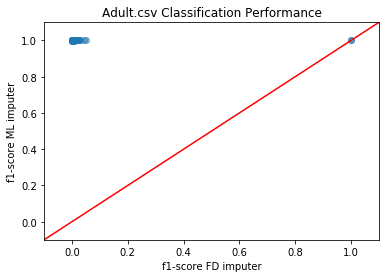

In [50]:
f1_fd = [y['f1'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'f1' in y.keys()]
f1_ml = [y['f1'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_fd, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score FD imputer',
      ylabel = 'f1-score ML imputer',
      xlim = [-0.1, 1.1],
      ylim  = [-0.1, 1.1])
fig.savefig('ml-fd-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')

## 1. How to split the dataset

In [ ]:
df = pd.read_csv(DATA_PATH, sep=';', header=None)
fd_imputer.save_df_split(DATA_TITLE, df, SPLITS_PATH, METANOME_DATA_PATH, [0.8, 0.2])

## 2. How to use ML-imputer

Impute test-set

In [49]:
df_train.iloc[:, :-2].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,22855,23,Private,113309,Some-college,10,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40
1,18912,24,NaN,412156,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,40
2,17454,51,Private,139347,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,7688,0,40
3,14966,20,Private,223811,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,40
4,12289,40,Self-emp-not-inc,48859,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32


In [86]:
df_imputed = fd_imputer.ml_imputer(df_train.iloc[:,[4,5]], 
                                   df_test.iloc[:,[4,5]],
                                   5)

2019-06-04 11:22:30,600 [INFO]  
========== start: fit model
2019-06-04 11:22:30,602 [WARNING]  Already bound, ignoring bind()
2019-06-04 11:22:32,287 [INFO]  Epoch[0] Batch [0-184]	Speed: 1763.98 samples/sec	cross-entropy=0.350771	5-accuracy=0.000000
2019-06-04 11:22:33,904 [INFO]  Epoch[0] Train-cross-entropy=0.176974
2019-06-04 11:22:33,907 [INFO]  Epoch[0] Train-5-accuracy=0.000000
2019-06-04 11:22:33,909 [INFO]  Epoch[0] Time cost=3.304
2019-06-04 11:22:33,913 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-06-04 11:22:34,267 [INFO]  Epoch[0] Validation-cross-entropy=0.000048
2019-06-04 11:22:34,269 [INFO]  Epoch[0] Validation-5-accuracy=0.000000
2019-06-04 11:22:35,904 [INFO]  Epoch[1] Batch [0-184]	Speed: 1821.23 samples/sec	cross-entropy=0.000005	5-accuracy=0.000000
2019-06-04 11:22:37,533 [INFO]  Epoch[1] Train-cross-entropy=0.000003
2019-06-04 11:22:37,931 [INFO]  Epoch[1] Train-5-accuracy=0.000000
2019-06-04 11:22:37,936 [INFO]  Epoch[1] Time cost=3.662
20

In [87]:
df_imputed.head()

,4,5,5_imputed
0,HS-grad,9,9.0
1,HS-grad,9,9.0
2,Assoc-voc,11,11.0
3,Some-college,10,10.0
4,Prof-school,15,15.0


In [ ]:
f1 = f1_score(df_imputed[impute_column], df_imputed[impute_column+'_imputed'].astype(int), average='weighted')
print(f1)

The ML model's mean relative error is roughly 0.2%

In [ ]:
average_rel_error = ((df_imputed[impute_column] - df_imputed[impute_column+'_imputed'])
 / df_imputed[impute_column]).mean()
print(average_rel_error)